## Importing Libraries and Data

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from statsmodels.graphics.tsaplots import plot_pacf
import random
import math
import mlflow
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import joblib
import os
from datetime import datetime
import json
from scipy.stats import percentileofscore
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
## SKIP TO FEATURE ENGINEERING IF ALREADY DOWNLOADED
for year in range(2016, 2026):
    delimiter = ';' if year > 2021 else ','
    file_path = f'../data/histo_cotation_{year}.csv'
    globals()[f'data_{year}'] = pd.read_csv(file_path, delimiter=delimiter, engine='python')
    print(f"Loaded data_{year}: {globals()[f'data_{year}'].shape}")

Loaded data_2016: (126065, 12)
Loaded data_2017: (133687, 11)
Loaded data_2018: (74594, 15)
Loaded data_2019: (77588, 14)
Loaded data_2020: (140415, 12)
Loaded data_2021: (137372, 11)
Loaded data_2022: (83939, 11)
Loaded data_2023: (147209, 11)
Loaded data_2024: (145381, 11)
Loaded data_2025: (142853, 11)


In [3]:
# Get all dataframes and their column names
dataframes = {f'data_{year}': globals()[f'data_{year}'] for year in range(2016, 2026)}

for name, df in dataframes.items():
    print(f"{name} has columns: {df.columns.tolist()}")

data_2016 has columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX', 'IND_RES']
data_2017 has columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX    IND_RES']
data_2018 has columns: ['SEANCE', 'C_GR_RLC', 'CODE_VAL', 'LIB_VAL', 'COURS_REF', 'COURS_VEILLE', 'OUVERTURE', 'DERNIER_COURS', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRAN', 'CAPITAUX', 'I']
data_2019 has columns: ['SEANCE', 'C_GR_RLC', 'CODE_VAL', 'LIB_VAL', 'COURS_REF', 'COURS_VEILLE', 'OUVERTURE', 'DERNIER_COURS', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRAN', 'CAPITAUX I']
data_2020 has columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX', 'IND_RES']
data_2021 has columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEU

In [4]:
display(globals()['data_2016']['IND_RES'].unique())
display(globals()['data_2018']['I'].unique())
globals()['data_2020']['IND_RES'].unique()

array([nan, 'H', 'B'], dtype=object)

array([nan, '+', '-'], dtype=object)

array([nan, 'B', 'H'], dtype=object)

In [5]:
# Clean data_2017 before normalization
# Split the 'CAPITAUX    IND_RES' column
globals()['data_2017']['CAPITAUX    IND_RES'] = globals()['data_2017']['CAPITAUX    IND_RES'].astype(str)

# Extract only numeric part for CAPITAUX (remove any non-numeric characters at the end)
globals()['data_2017']['CAPITAUX'] = globals()['data_2017']['CAPITAUX    IND_RES'].str.extract(r'([\d\.,]+)', expand=False)

# Convert CAPITAUX to numeric, handling any conversion errors
globals()['data_2017']['CAPITAUX'] = pd.to_numeric(globals()['data_2017']['CAPITAUX'].str.replace(',', '.'), errors='coerce')

# Extract non-numeric part for IND_RES (anything after the numbers)
globals()['data_2017']['IND_RES'] = globals()['data_2017']['CAPITAUX    IND_RES'].str.replace(r'^[\d\.,\s]+', '', regex=True)

# Drop the original combined column
globals()['data_2017'] = globals()['data_2017'].drop(columns=['CAPITAUX    IND_RES'])

print(f"Cleaned data_2017 columns: {globals()['data_2017'].columns.tolist()}")
print(f"Sample CAPITAUX values: {globals()['data_2017']['CAPITAUX'].head()}")
print(f"Sample IND_RES values: {globals()['data_2017']['IND_RES'].head()}")


Cleaned data_2017 columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX', 'IND_RES']
Sample CAPITAUX values: 0    29189.00
1    72703.57
2     2790.40
3    46802.41
4    51625.32
Name: CAPITAUX, dtype: float64
Sample IND_RES values: 0    
1    
2    
3    
4    
Name: IND_RES, dtype: object


In [6]:
# Clean data_2019 before normalization
# Split the 'CAPITAUX    I' column
globals()['data_2019']['CAPITAUX I'] = globals()['data_2019']['CAPITAUX I'].astype(str)

# Extract only numeric part for CAPITAUX (remove any non-numeric characters at the end)
globals()['data_2019']['CAPITAUX'] = globals()['data_2019']['CAPITAUX I'].str.extract(r'([\d\.,]+)', expand=False)

# Convert CAPITAUX to numeric, handling any conversion errors
globals()['data_2019']['CAPITAUX'] = pd.to_numeric(globals()['data_2019']['CAPITAUX'].str.replace(',', '.'), errors='coerce')

# Extract non-numeric part for IND_RES (anything after the numbers)
globals()['data_2019']['IND_RES'] = globals()['data_2019']['CAPITAUX I'].str.replace(r'^[\d\.,\s]+', '', regex=True)

# Drop the original combined column
globals()['data_2019'] = globals()['data_2019'].drop(columns=['CAPITAUX I'])

print(f"Cleaned data_2019 columns: {globals()['data_2019'].columns.tolist()}")
print(f"Sample CAPITAUX values: {globals()['data_2019']['CAPITAUX'].head()}")
print(f"Sample IND_RES values: {globals()['data_2019']['IND_RES'].head()}")


Cleaned data_2019 columns: ['SEANCE', 'C_GR_RLC', 'CODE_VAL', 'LIB_VAL', 'COURS_REF', 'COURS_VEILLE', 'OUVERTURE', 'DERNIER_COURS', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRAN', 'CAPITAUX', 'IND_RES']
Sample CAPITAUX values: 0     20620.80
1      7240.06
2     15924.09
3    118592.33
4      1948.72
Name: CAPITAUX, dtype: float64
Sample IND_RES values: 0    
1    
2    
3    
4    
Name: IND_RES, dtype: object


In [7]:
def normalize_columns(df, year):
    """Normalize column names and strip whitespace"""
    # Strip whitespace from all column names
    df.columns = df.columns.str.strip()
    
    # Create column mapping based on year
    if year in [2018, 2019]:
        column_mapping = {
            'C_GR_RLC': 'GROUPE',
            'CODE_VAL': 'CODE',
            'LIB_VAL': 'VALEUR',
            'NB_TRAN': 'NB_TRANSACTION'
        }
    else:
        column_mapping = {}
    
    # Rename columns
    df = df.rename(columns=column_mapping)
    
    # Select only common columns
    common_columns = [
        'SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 
        'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 
        'NB_TRANSACTION', 'CAPITAUX'
    ]
    
    # Keep only columns that exist
    available_columns = [col for col in common_columns if col in df.columns]
    
    return df[available_columns]

In [8]:
# Apply normalization to all dataframes
for year in range(2016, 2026):
    globals()[f'data_{year}'] = normalize_columns(globals()[f'data_{year}'], year)
    print(f"Normalized data_{year}: {globals()[f'data_{year}'].columns.tolist()}")

Normalized data_2016: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2017: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2018: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2019: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2020: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2021: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2022: ['SEANCE', '

In [9]:
# Clean data_2018 and data_2019 - convert comma decimals to dots and make numeric
for year in [2018, 2019]:
    df = globals()[f'data_{year}']
    
    # List of columns that should be numeric
    numeric_columns = ['COURS_REF', 'COURS_VEILLE', 'OUVERTURE', 'DERNIER_COURS', 
                      'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 
                      'NB_TRAN', 'CAPITAUX']
    
    # Convert columns: replace comma with dot and convert to numeric
    for col in numeric_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(',', '.').str.replace(' ', '')
    
    globals()[f'data_{year}'] = df
    print(f"Cleaned data_{year} numeric columns")
    print(f"Sample values: {df[['OUVERTURE', 'CLOTURE', 'CAPITAUX']].head()}")
    print()

Cleaned data_2018 numeric columns
Sample values:   OUVERTURE CLOTURE   CAPITAUX
0      5.25    5.39    15635.5
1     24.38      24      36918
2      6.27     6.1  219020.05
3         0       9        nan
4      4.15    4.18    15465.9

Cleaned data_2019 numeric columns
Sample values:   OUVERTURE CLOTURE   CAPITAUX
0       4.8     4.8    20620.8
1      27.8   27.75    7240.06
2      6.27    6.28   15924.09
3      7.79    8.02  118592.33
4      3.76    3.65    1948.72



In [10]:
# Combine all dataframes
all_data = pd.concat([globals()[f'data_{year}'] for year in range(2016, 2026)], ignore_index=True)
print(f"\nCombined dataset shape: {all_data.shape}")


Combined dataset shape: (1209103, 11)


In [11]:
dataset = all_data.copy()
display(dataset.head(3))
display(dataset.tail(3))

SEANCE GROUPE    CODE    VALEUR OUVERTURE CLOTURE PLUS_BAS PLUS_HAUT  \
0  04/01/2016     11  100010  MONOPRIX     14.19    13.9    13.77     14.19   
1  04/01/2016     11  110025      SFBT      22.8    23.4    22.45     23.43   
2  04/01/2016     11  120040  TUNISAIR      0.82    0.81      0.8      0.82   

  QUANTITE_NEGOCIEE NB_TRANSACTION   CAPITAUX  
0              2008             21   27847.95  
1              4801             28  109693.23  
2             12317             13    9941.51

SEANCE GROUPE          CODE              VALEUR OUVERTURE  \
1209100  31/12/2025        99  TN0007650013  TAWASOL GP HOLDING      0.77   
1209101  31/12/2025        99  TN0007690019  UADH                     0.6   
1209102  31/12/2025        99  TN0007730013  SANIMED                 0.57   

        CLOTURE PLUS_BAS PLUS_HAUT QUANTITE_NEGOCIEE NB_TRANSACTION CAPITAUX  
1209100     0.8      0.8       0.8             52534             40  42027.2  
1209101     0.6      0.6       0.6                10              1      6.0  
1209102    0.57      0.0       0.0                 0              0      0.0

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209103 entries, 0 to 1209102
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   SEANCE             1209101 non-null  object
 1   GROUPE             1209101 non-null  object
 2   CODE               1209101 non-null  object
 3   VALEUR             1209101 non-null  object
 4   OUVERTURE          1209101 non-null  object
 5   CLOTURE            1209101 non-null  object
 6   PLUS_BAS           1209101 non-null  object
 7   PLUS_HAUT          1209101 non-null  object
 8   QUANTITE_NEGOCIEE  1209101 non-null  object
 9   NB_TRANSACTION     1209101 non-null  object
 10  CAPITAUX           1209101 non-null  object
dtypes: object(11)
memory usage: 101.5+ MB


In [13]:
# Strip whitespace from SEANCE column first
dataset['SEANCE'] = dataset['SEANCE'].str.strip()

# Convert SEANCE to datetime (format: dd/mm/yyyy)
dataset['SEANCE'] = pd.to_datetime(dataset['SEANCE'], format='%d/%m/%Y', errors='coerce')

# Convert numeric columns to float
float_columns = ['OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'CAPITAUX']
for col in float_columns:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

# Convert to integer
int_columns = ['QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'GROUPE']
for col in int_columns:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce').astype('Int64')

print(dataset.dtypes)
display(dataset.head())

SEANCE               datetime64[ns]
GROUPE                        Int64
CODE                         object
VALEUR                       object
OUVERTURE                   float64
CLOTURE                     float64
PLUS_BAS                    float64
PLUS_HAUT                   float64
QUANTITE_NEGOCIEE             Int64
NB_TRANSACTION                Int64
CAPITAUX                    float64
dtype: object


SEANCE  GROUPE    CODE         VALEUR  OUVERTURE  CLOTURE  PLUS_BAS  \
0 2016-01-04      11  100010       MONOPRIX      14.19    13.90     13.77   
1 2016-01-04      11  110025           SFBT      22.80    23.40     22.45   
2 2016-01-04      11  120040       TUNISAIR       0.82     0.81      0.80   
3 2016-01-04      11  160015  ATTIJARI BANK      24.19    24.22     24.15   
4 2016-01-04      11  180045           BIAT      76.35    76.90     76.35   

   PLUS_HAUT  QUANTITE_NEGOCIEE  NB_TRANSACTION   CAPITAUX  
0      14.19               2008              21   27847.95  
1      23.43               4801              28  109693.23  
2       0.82              12317              13    9941.51  
3      24.30               6115              23  148030.95  
4      77.00                286               6   21948.34

## EDA

In [14]:
# Basic information about the dataset
print(f"\nShape: {dataset.shape}")
print(f"Number of rows: {dataset.shape[0]:,}")
print(f"Number of columns: {dataset.shape[1]}")
print(f"\nColumn names:\n{dataset.columns.tolist()}")
print(f"\nMemory usage:\n{dataset.memory_usage(deep=True)}")
print(f"\nTotal memory: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Shape: (1209103, 11)
Number of rows: 1,209,103
Number of columns: 11

Column names:
['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']

Memory usage:
Index                     132
SEANCE                9672824
GROUPE               10881927
CODE                 59945518
VALEUR               79447311
OUVERTURE             9672824
CLOTURE               9672824
PLUS_BAS              9672824
PLUS_HAUT             9672824
QUANTITE_NEGOCIEE    10881927
NB_TRANSACTION       10881927
CAPITAUX              9672824
dtype: int64

Total memory: 219.42 MB


MISSING VALUES ANALYSIS
               Column  Missing_Count  Missing_Percent
0              SEANCE              6         0.000496
1              GROUPE              6         0.000496
2                CODE              2         0.000165
3              VALEUR              2         0.000165
4           OUVERTURE              6         0.000496
5             CLOTURE              6         0.000496
6            PLUS_BAS              6         0.000496
7           PLUS_HAUT              6         0.000496
8   QUANTITE_NEGOCIEE              6         0.000496
9      NB_TRANSACTION              6         0.000496
10           CAPITAUX         110476         9.137021

Total missing values: 110,528
Any missing values: True


<Figure size 1200x600 with 0 Axes>

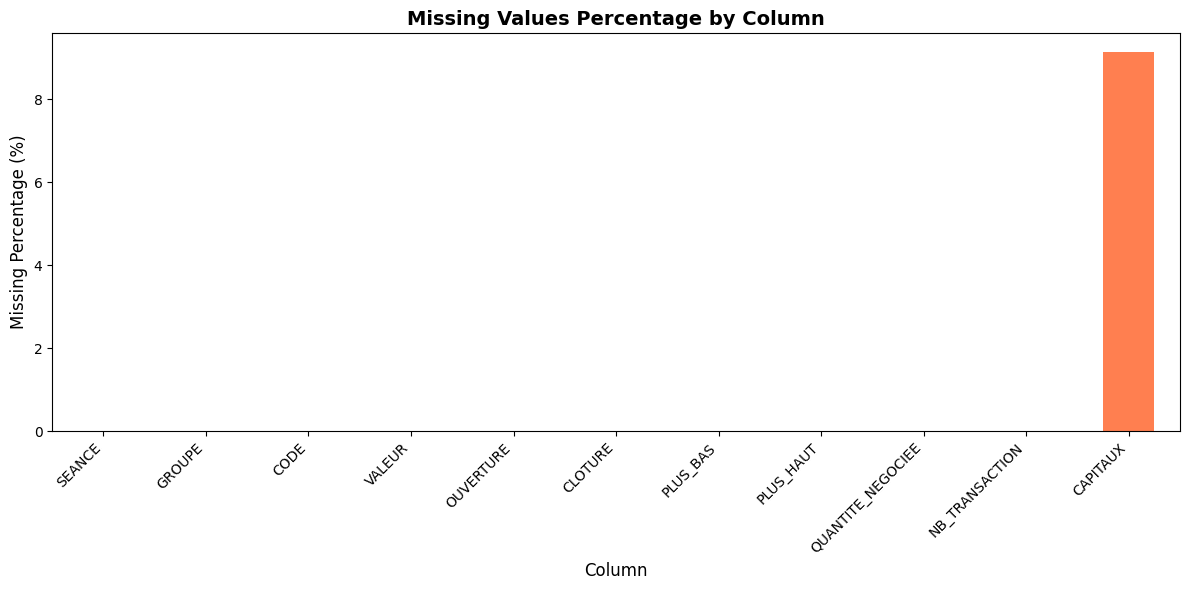

In [15]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_counts = dataset.isnull().sum()
missing_percent = (dataset.isnull().sum() / len(dataset)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})

print(missing_df)
print(f"\nTotal missing values: {dataset.isnull().sum().sum():,}")
print(f"Any missing values: {dataset.isnull().any().any()}")

# Visualize missing values
plt.figure(figsize=(12, 6))
missing_df.plot(x='Column', y='Missing_Percent', kind='bar', 
                color='coral', legend=False, figsize=(12, 6))
plt.title('Missing Values Percentage by Column', fontsize=14, fontweight='bold')
plt.xlabel('Column', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
# Select rows where CAPITAUX is null
missing_capitaux = dataset[dataset['CAPITAUX'].isnull()]

# View the range of dates in SEANCE for those rows
if not missing_capitaux.empty:
    min_date = missing_capitaux['SEANCE'].min()
    max_date = missing_capitaux['SEANCE'].max()
    print(f"Date range for missing CAPITAUX: {min_date} to {max_date}")
    print(f"Number of missing rows: {len(missing_capitaux)}")
else:
    print("No missing values in CAPITAUX column")

Date range for missing CAPITAUX: 2018-01-02 00:00:00 to 2019-12-31 00:00:00
Number of missing rows: 110476


In [17]:
# Filter rows where SEANCE is between 2018-01-02 and 2019-12-31 and CAPITAUX is not null
filtered_rows = dataset[
    (dataset['SEANCE'] >= '2018-01-02') & 
    (dataset['SEANCE'] <= '2019-12-31') & 
    (dataset['CAPITAUX'].notnull())
]

print(f"Number of rows with non-null CAPITAUX in 2018-2019: {len(filtered_rows)}")
if not filtered_rows.empty:
    display(filtered_rows.head())
else:
    print("No rows found with non-null CAPITAUX in that date range.")

Number of rows with non-null CAPITAUX in 2018-2019: 41712


SEANCE  GROUPE    CODE              VALEUR  OUVERTURE  CLOTURE  \
259752 2018-01-02      11  725001               ADWYA       5.25     5.39   
259753 2018-01-02      11  340005           AMEN BANK      24.38    24.00   
259754 2018-01-02      11  730001               ARTES       6.27     6.10   
259756 2018-01-02      11  360035                 ATB       4.15     4.18   
259757 2018-01-02      11  774001  ATELIER MEUBLE INT       2.42     2.49   

        PLUS_BAS  PLUS_HAUT  QUANTITE_NEGOCIEE  NB_TRANSACTION   CAPITAUX  
259752      5.25       5.39               2926               7   15635.50  
259753     24.00      24.38               1519              12   36918.00  
259754      6.09       6.27              35875              67  219020.05  
259756      4.15       4.18               3705               7   15465.90  
259757      2.42       2.49                195               3     472.25

In [18]:
# Check if all missing CAPITAUX rows have NB_TRANSACTION == 0
missing_capitaux = dataset[dataset['CAPITAUX'].isnull()]

# Count rows where NB_TRANSACTION is not 0 among missing CAPITAUX
non_zero_nb_trans = missing_capitaux[missing_capitaux['NB_TRANSACTION'] != 0]

if len(non_zero_nb_trans) == 0:
    print("All rows with missing CAPITAUX have NB_TRANSACTION == 0")
else:
    print(f"Number of rows with missing CAPITAUX but NB_TRANSACTION != 0: {len(non_zero_nb_trans)}")
    display(non_zero_nb_trans.head())

All rows with missing CAPITAUX have NB_TRANSACTION == 0


In [19]:
# Fill missing CAPITAUX values with 0 where NB_TRANSACTION == 0
dataset.loc[dataset['CAPITAUX'].isnull() & (dataset['NB_TRANSACTION'] == 0), 'CAPITAUX'] = 0

print(f"Missing CAPITAUX values after filling: {dataset['CAPITAUX'].isnull().sum()}")

Missing CAPITAUX values after filling: 6


MISSING VALUES ANALYSIS
               Column  Missing_Count  Missing_Percent
0              SEANCE              6         0.000496
1              GROUPE              6         0.000496
2                CODE              2         0.000165
3              VALEUR              2         0.000165
4           OUVERTURE              6         0.000496
5             CLOTURE              6         0.000496
6            PLUS_BAS              6         0.000496
7           PLUS_HAUT              6         0.000496
8   QUANTITE_NEGOCIEE              6         0.000496
9      NB_TRANSACTION              6         0.000496
10           CAPITAUX              6         0.000496

Total missing values: 58
Any missing values: True


<Figure size 1200x600 with 0 Axes>

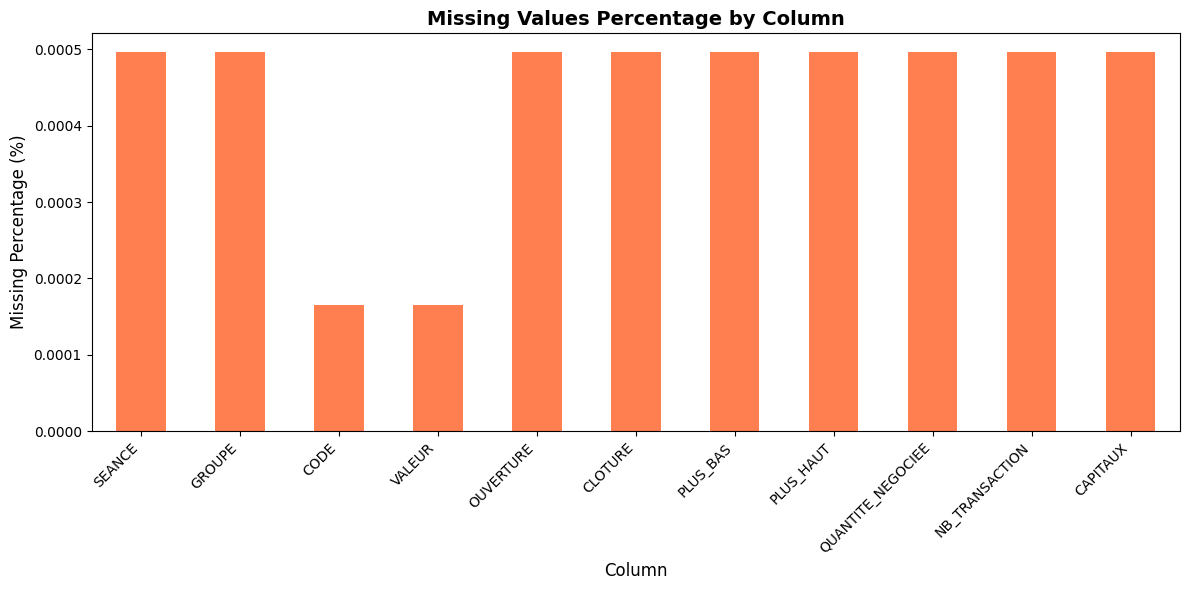

In [20]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_counts = dataset.isnull().sum()
missing_percent = (dataset.isnull().sum() / len(dataset)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})

print(missing_df)
print(f"\nTotal missing values: {dataset.isnull().sum().sum():,}")
print(f"Any missing values: {dataset.isnull().any().any()}")

# Visualize missing values
plt.figure(figsize=(12, 6))
missing_df.plot(x='Column', y='Missing_Percent', kind='bar', 
                color='coral', legend=False, figsize=(12, 6))
plt.title('Missing Values Percentage by Column', fontsize=14, fontweight='bold')
plt.xlabel('Column', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Find rows with any missing values
rows_with_missing = dataset[dataset.isnull().any(axis=1)]

print(f"\nTotal rows with at least one missing value: {len(rows_with_missing)}")
print(f"Percentage of dataset: {(len(rows_with_missing)/len(dataset))*100:.2f}%")

display(rows_with_missing)


Total rows with at least one missing value: 6
Percentage of dataset: 0.00%


SEANCE  GROUPE          CODE                VALEUR  OUVERTURE  CLOTURE  \
602346    NaT    <NA>           NaN                   NaN        NaN      NaN   
602347    NaT    <NA>          CODE                VALEUR        NaN      NaN   
602348    NaT    <NA>  ------------  --------------------        NaN      NaN   
652346    NaT    <NA>           NaN                   NaN        NaN      NaN   
652347    NaT    <NA>          CODE                VALEUR        NaN      NaN   
652348    NaT    <NA>  ------------  --------------------        NaN      NaN   

        PLUS_BAS  PLUS_HAUT  QUANTITE_NEGOCIEE  NB_TRANSACTION  CAPITAUX  
602346       NaN        NaN               <NA>            <NA>       NaN  
602347       NaN        NaN               <NA>            <NA>       NaN  
602348       NaN        NaN               <NA>            <NA>       NaN  
652346       NaN        NaN               <NA>            <NA>       NaN  
652347       NaN        NaN               <NA>            <NA>       NaN  
652348       NaN        NaN               <NA>            <NA>       NaN

In [22]:
# Drop all rows with missing values
print("DROPPING ROWS WITH MISSING VALUES")

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")

# Drop rows with any missing values
dataset = dataset.dropna()

# New shape after dropping
new_shape = dataset.shape
rows_dropped = original_shape[0] - new_shape[0]

print(f"\nDataset shape after dropping missing values: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows dropped: {rows_dropped}")
print(f"Percentage of data removed: {(rows_dropped/original_shape[0])*100:.2f}%")

# Sanity check - verify no missing values remain
print("SANITY CHECK - MISSING VALUES VERIFICATION")

missing_after = dataset.isnull().sum()
total_missing = missing_after.sum()

print(f"\nTotal missing values after cleanup: {total_missing}")
print(f"Any missing values remaining: {dataset.isnull().any().any()}")

if total_missing == 0:
    print("\n SUCCESS: No missing values remain in the dataset!")
else:
    print(f"\n WARNING: {total_missing} missing values still present!")
    print("\nMissing values by column:")
    print(missing_after[missing_after > 0])

print("FINAL DATASET SUMMARY")
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Columns: {dataset.shape[1]}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DROPPING ROWS WITH MISSING VALUES

Original dataset shape: (1209103, 11)
Original number of rows: 1,209,103

Dataset shape after dropping missing values: (1209097, 11)
New number of rows: 1,209,097
Rows dropped: 6
Percentage of data removed: 0.00%
SANITY CHECK - MISSING VALUES VERIFICATION

Total missing values after cleanup: 0
Any missing values remaining: False

 SUCCESS: No missing values remain in the dataset!
FINAL DATASET SUMMARY
Shape: (1209097, 11)
Rows: 1,209,097
Columns: 11
Memory usage: 228.64 MB


TRADING DAYS PER CODE (TICKER) ANALYSIS

Total unique CODEs: 1,584

Trading Days Statistics:
  Mean: 763.32 days
  Median: 752 days
  Min: 2 days
  Max: 1257 days
  Std: 422.80 days

TOP 10 MOST TRACKED CODES


CODE  Trading_Days
760   TN0001000108          1257
761   TN0001000116          1257
762   TN0001000124          1257
1277  TN0007630015          1257
1279  TN0007650013          1257
1281  TN0007670011          1257
1282  TN0007680010          1257
1283  TN0007680044          1257
1284  TN0007680051          1257
1286  TN0007690019          1257


BOTTOM 10 LEAST TRACKED CODES


CODE  Trading_Days
1409  TNA3Z7AYXXX2             9
1314  TN0008000564             8
1519  TNQEVW1AZTU8             8
1460  TNI7FVNGCJ77             8
549         720007             6
550         720008             6
1285  TN0007680077             5
718         783001             3
1121  TN0006640023             2
1120  TN0006640015             2


DISTRIBUTION OF TRADING DAYS
Days_Range
0-50         65
51-100       22
101-250     120
251-500     251
501-750     286
751-1000    239
1000+       601
Name: count, dtype: int64


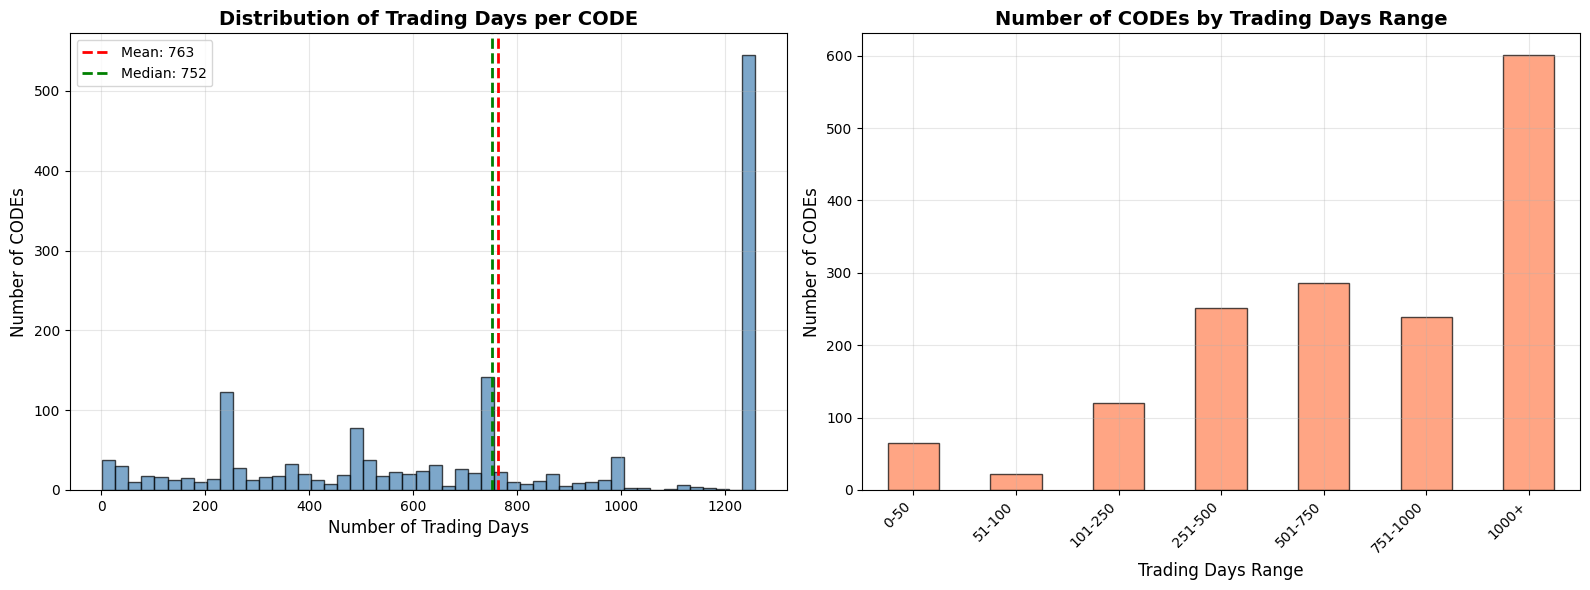

In [23]:
# Analyze how many trading days each CODE has been tracked
print("=" * 80)
print("TRADING DAYS PER CODE (TICKER) ANALYSIS")
print("=" * 80)

# Count unique SEANCE dates for each CODE
days_per_code = dataset.groupby('CODE')['SEANCE'].nunique().reset_index()
days_per_code.columns = ['CODE', 'Trading_Days']
days_per_code = days_per_code.sort_values('Trading_Days', ascending=False)

print(f"\nTotal unique CODEs: {len(days_per_code):,}")
print(f"\nTrading Days Statistics:")
print(f"  Mean: {days_per_code['Trading_Days'].mean():.2f} days")
print(f"  Median: {days_per_code['Trading_Days'].median():.0f} days")
print(f"  Min: {days_per_code['Trading_Days'].min()} days")
print(f"  Max: {days_per_code['Trading_Days'].max()} days")
print(f"  Std: {days_per_code['Trading_Days'].std():.2f} days")

print("\n" + "=" * 80)
print("TOP 10 MOST TRACKED CODES")
print("=" * 80)
display(days_per_code.head(10))

print("\n" + "=" * 80)
print("BOTTOM 10 LEAST TRACKED CODES")
print("=" * 80)
display(days_per_code.tail(10))

print("\n" + "=" * 80)
print("DISTRIBUTION OF TRADING DAYS")
print("=" * 80)

# Create bins for better understanding
bins = [0, 50, 100, 250, 500, 750, 1000, days_per_code['Trading_Days'].max() + 1]
labels = ['0-50', '51-100', '101-250', '251-500', '501-750', '751-1000', '1000+']
days_per_code['Days_Range'] = pd.cut(days_per_code['Trading_Days'], bins=bins, labels=labels, right=False)

distribution = days_per_code['Days_Range'].value_counts().sort_index()
print(distribution)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(days_per_code['Trading_Days'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Trading Days per CODE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Trading Days', fontsize=12)
axes[0].set_ylabel('Number of CODEs', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].axvline(days_per_code['Trading_Days'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {days_per_code["Trading_Days"].mean():.0f}')
axes[0].axvline(days_per_code['Trading_Days'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {days_per_code["Trading_Days"].median():.0f}')
axes[0].legend()

# Bar chart of ranges
distribution.plot(kind='bar', ax=axes[1], color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Number of CODEs by Trading Days Range', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Trading Days Range', fontsize=12)
axes[1].set_ylabel('Number of CODEs', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Unique values per column
print("=" * 60)
print("UNIQUE VALUES PER COLUMN")
print("=" * 60)

unique_df = pd.DataFrame({
    'Column': dataset.columns,
    'Unique_Count': [dataset[col].nunique() for col in dataset.columns],
    'Sample_Values': [dataset[col].unique()[:] if dataset[col].nunique() <= 10 
                      else f"{dataset[col].unique()[:3]}... (showing 3 of {dataset[col].nunique()})" 
                      for col in dataset.columns]
})

for idx, row in unique_df.iterrows():
    if(row['Column'] in ['SEANCE', 'GROUPE', 'CODE', 'VALEUR']):
        print(f"\n{row['Column']}:")
        print(f"  Unique values: {row['Unique_Count']:,}")
        print(f"  Sample: {row['Sample_Values']}")

UNIQUE VALUES PER COLUMN

SEANCE:
  Unique values: 2,508
  Sample: <DatetimeArray>
['2016-01-04 00:00:00', '2016-01-05 00:00:00', '2016-01-06 00:00:00']
Length: 3, dtype: datetime64[ns]... (showing 3 of 2508)

GROUPE:
  Unique values: 10
  Sample: <IntegerArray>
[11, 12, 13, 21, 32, 51, 52, 71, 99, 33]
Length: 10, dtype: Int64

CODE:
  Unique values: 1,584
  Sample: [100010 110025 120040]... (showing 3 of 1584)

VALEUR:
  Unique values: 1,444
  Sample: ['MONOPRIX' 'SFBT' 'TUNISAIR']... (showing 3 of 1444)


In [25]:
# Check for duplicate rows
print("=" * 60)
print("DUPLICATE ROWS ANALYSIS")
print("=" * 60)

# Check for exact duplicates (all columns)
total_duplicates = dataset.duplicated().sum()
print(f"\nTotal duplicate rows (all columns): {total_duplicates:,}")
print(f"Percentage of duplicates: {(total_duplicates/len(dataset))*100:.2f}%")

# Check for duplicates based on key columns (SEANCE, CODE)
key_duplicates = dataset.duplicated(subset=['SEANCE', 'CODE']).sum()
print(f"\nDuplicate rows based on SEANCE + CODE: {key_duplicates:,}")
print(f"Percentage: {(key_duplicates/len(dataset))*100:.2f}%")

# View some duplicate rows if they exist
if total_duplicates > 0:
    print("\nSample of duplicate rows:")
    duplicates_df = dataset[dataset.duplicated(keep=False)].sort_values(['SEANCE', 'CODE'])
    display(duplicates_df.head(10))
    
if key_duplicates > 0:
    print("\nSample of key duplicates (SEANCE + CODE):")
    key_dups = dataset[dataset.duplicated(subset=['SEANCE', 'CODE'], keep=False)].sort_values(['SEANCE', 'CODE'])
    display(key_dups.head(10))

DUPLICATE ROWS ANALYSIS

Total duplicate rows (all columns): 0
Percentage of duplicates: 0.00%

Duplicate rows based on SEANCE + CODE: 0
Percentage: 0.00%


CONSISTENCY CHECK ACROSS YEARS

Unique Values Per Year:


Year  Total_Rows  Unique_Trading_Days  Unique_Groups  Unique_Codes  \
0  2016      126065                  251              9           542   
1  2017      133687                  252             10           582   
2  2018       74594                  249              8           308   
3  2019       77588                  249              8           323   
4  2020      140415                  250              9           613   
5  2021      137366                  248              7           604   
6  2022       83939                  257              6           331   
7  2023      147209                  252              7           659   
8  2024      145381                  251              7           645   
9  2025      142853                  249              6           612   

   Unique_Values  
0            550  
1            588  
2            309  
3            324  
4            625  
5            793  
6            331  
7            659  
8            645  
9            612

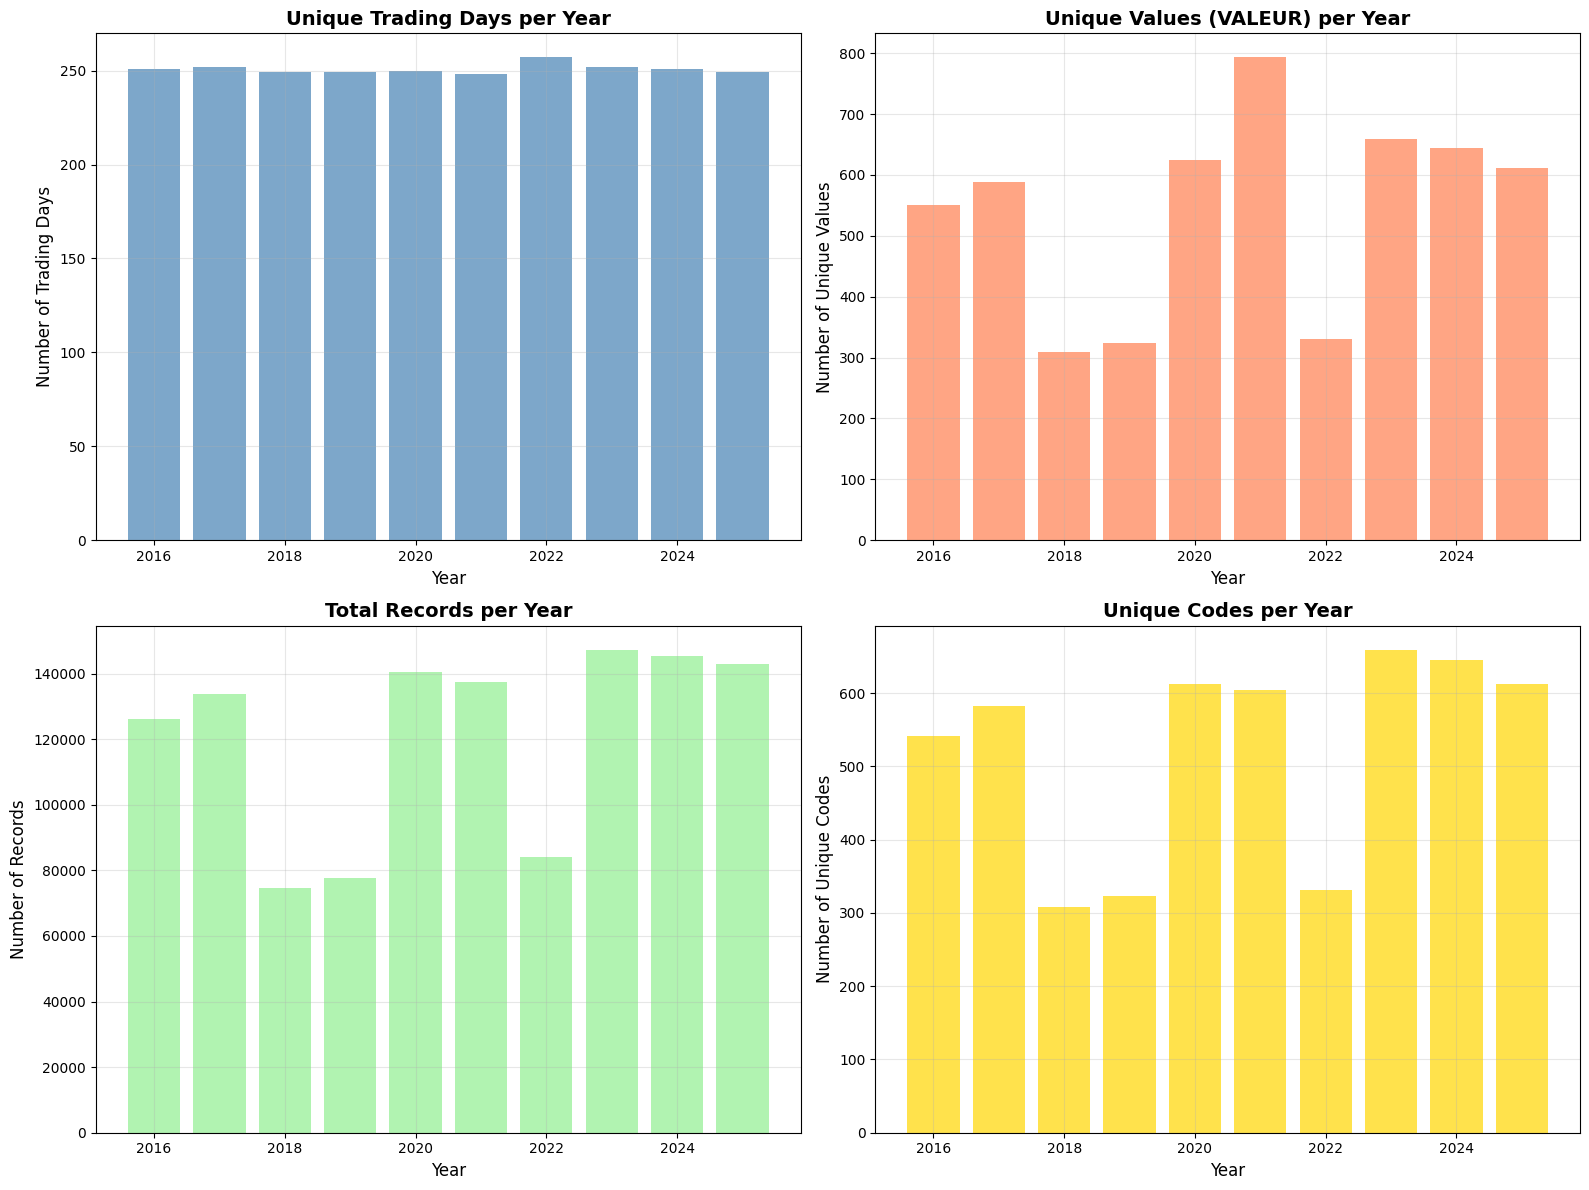

In [26]:
# Check consistency over years
print("=" * 80)
print("CONSISTENCY CHECK ACROSS YEARS")
print("=" * 80)

# Extract year from SEANCE column
dataset.loc[:, 'YEAR'] = dataset['SEANCE'].dt.year

# Group by year and count unique values for key columns
columns_to_check = ['SEANCE', 'GROUPE', 'CODE', 'VALEUR']

consistency_report = []
for year in sorted(dataset['YEAR'].unique()):
    year_data = dataset[dataset['YEAR'] == year]
    
    year_stats = {
        'Year': year,
        'Total_Rows': len(year_data),
        'Unique_Trading_Days': year_data['SEANCE'].nunique(),
        'Unique_Groups': year_data['GROUPE'].nunique(),
        'Unique_Codes': year_data['CODE'].nunique(),
        'Unique_Values': year_data['VALEUR'].nunique()
    }
    consistency_report.append(year_stats)

# Create DataFrame from the report
consistency_df = pd.DataFrame(consistency_report)

print("\nUnique Values Per Year:")
print("=" * 80)
display(consistency_df)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Trading Days per Year
axes[0, 0].bar(consistency_df['Year'], consistency_df['Unique_Trading_Days'], color='steelblue', alpha=0.7)
axes[0, 0].set_title('Unique Trading Days per Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Number of Trading Days', fontsize=12)
axes[0, 0].grid(alpha=0.3)

# 2. Unique Values per Year
axes[0, 1].bar(consistency_df['Year'], consistency_df['Unique_Values'], color='coral', alpha=0.7)
axes[0, 1].set_title('Unique Values (VALEUR) per Year', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Year', fontsize=12)
axes[0, 1].set_ylabel('Number of Unique Values', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# 3. Total Rows per Year
axes[1, 0].bar(consistency_df['Year'], consistency_df['Total_Rows'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Total Records per Year', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Number of Records', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# 4. Unique Codes per Year
axes[1, 1].bar(consistency_df['Year'], consistency_df['Unique_Codes'], color='gold', alpha=0.7)
axes[1, 1].set_title('Unique Codes per Year', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year', fontsize=12)
axes[1, 1].set_ylabel('Number of Unique Codes', fontsize=12)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
# Remove the YEAR column if not needed
dataset = dataset.drop('YEAR', axis=1)

In [27]:
# Analyze CODE to VALEUR mapping
print("=" * 80)
print("CODE to VALEUR MAPPING ANALYSIS")
print("=" * 80)

# For each CODE, count unique VALEUR values
code_to_valeur = dataset.groupby('CODE')['VALEUR'].nunique().reset_index()
code_to_valeur.columns = ['CODE', 'Unique_VALEUR_Count']
code_to_valeur = code_to_valeur.sort_values('Unique_VALEUR_Count', ascending=False)

print("\n1. For each CODE, how many unique VALEUR values:")
print(f"\nTotal unique CODEs: {len(code_to_valeur)}")
print(f"\nDistribution of VALEUR counts per CODE:")
print(code_to_valeur['Unique_VALEUR_Count'].value_counts().sort_index())

# For each VALEUR, count unique CODE values
print('\n' + "=" * 80)
print("VALEUR to CODE MAPPING ANALYSIS")
print( "=" * 80)

valeur_to_code = dataset.groupby('VALEUR')['CODE'].nunique().reset_index()
valeur_to_code.columns = ['VALEUR', 'Unique_CODE_Count']
valeur_to_code = valeur_to_code.sort_values('Unique_CODE_Count', ascending=False)

print("\n2. For each VALEUR, how many unique CODE values:")
print(f"\nTotal unique VALEURs: {len(valeur_to_code)}")
print(f"\nDistribution of CODE counts per VALEUR:")
print(valeur_to_code['Unique_CODE_Count'].value_counts().sort_index())

CODE to VALEUR MAPPING ANALYSIS

1. For each CODE, how many unique VALEUR values:

Total unique CODEs: 1584

Distribution of VALEUR counts per CODE:
Unique_VALEUR_Count
1    1243
2     262
3      79
Name: count, dtype: int64

VALEUR to CODE MAPPING ANALYSIS

2. For each VALEUR, how many unique CODE values:

Total unique VALEURs: 1444

Distribution of CODE counts per VALEUR:
Unique_CODE_Count
1    884
2    560
Name: count, dtype: int64


In [28]:
tickers_to_keep = ['ADWYA',                        'AETECH',
           'AIR LIQUIDE TUNISIE',                     'AMEN BANK',
                           'AMS',            'ARAB TUNISIAN BANK',
           'ARAB TUNISIAN LEASE',                         'ARTES',
                         'ASSAD',          'ASSURANCES MAGHREBIA',
                        'ASTREE',                 'ATTIJARI BANK',
              'ATTIJARI LEASING',             'BANQUE DE TUNISIE',
     'BANQUE NATIONALE AGRICOLE',                    'BEST LEASE',
                  'BH ASSURANCE',                       'BH BANK',
                    'BH LEASING',                          'BIAT',
                'BNA ASSURANCES',                     'BTE (ADP)',
               'CARTHAGE CEMENT',                       'CELLCOM',
                      'CEREALIS',                           'CIL',
            'CIMENTS DE BIZERTE',                     'CITY CARS',
                'DELICE HOLDING',                        'ELBENE',
                   'ELECTROSTAR',            'ENNAKL AUTOMOBILES',
                      'ESSOUKNA',                   'EURO-CYCLES',
                    'GIF FILTER',                'HANNIBAL LEASE',
                      'HEXABYTE',                           'ICF',
                       "LAND'OR",               'MAGASIN GENERAL',
                 'MAGHREBIA VIE',            'MEUBLES INTERIEURS',
                           'MIP',                      'MONOPRIX',
                          'MPBS',                 'NEW BODY LINE',
                  'OFFICE PLAST',                      'ONE TECH',
 'PLACEMENTS DE TUNISIE - SICAF',         'POULINA GROUP HOLDING',
                           'SAH',                       'SANIMED',
                      'SERVICOM',                          'SFBT',
                         'SIAME',                        'SIMPAR',
                        'SIPHAT',                          'SITS',
                 'SMART TUNISIE',      'SOCIETE CHIMIQUE ALKIMIA',
                       'SOMOCER',                         'SOPAT',
                      'SOTEMAIL',                       'SOTETEL',
                    'SOTIPAPIER',                      'SOTRAPIL',
                       'SOTUMAG',                       'SOTUVER',
                 'SPDIT - SICAF',                           'STA',
                          'STAR',                      'STB BANK',
                          'STEQ',                          'STIP',
               'SYPHAX AIRLINES',                       'TAWASOL',
                'TELNET HOLDING',                           'TPR',
                      'TUNINDEX',             'TUNINVEST - SICAR',
                      'TUNIS RE',                      'TUNISAIR',
           'TUNISIAN BOND INDEX',   'TUNISIE LEASING & FACTORING',
               'TUNISIE VALEURS',                          'UADH',
                          'UBCI',                           'UIB',
                        'UNIMED',                'WIFAK INT BANK']

In [29]:
tickers_to_keep_series = pd.Series(tickers_to_keep)
tickers_to_keep_series.nunique()

90

In [30]:
# Convert CODE and VALEUR columns to string type
dataset['CODE'] = dataset['CODE'].astype('string')
dataset['VALEUR'] = dataset['VALEUR'].astype('string')

# Strip whitespace from CODE and VALEUR
dataset['CODE'] = dataset['CODE'].str.strip()
dataset['VALEUR'] = dataset['VALEUR'].str.strip()

print("Column types after conversion:")
print(f"CODE: {dataset['CODE'].dtype}")
print(f"VALEUR: {dataset['VALEUR'].dtype}")

# Verify the conversion
dataset.info()

# Check unique values after stripping
print(f"\nUnique VALEUR values after stripping: {dataset['VALEUR'].nunique()}")
print(f"Unique CODE values after stripping: {dataset['CODE'].nunique()}")

Column types after conversion:
CODE: string
VALEUR: string
<class 'pandas.core.frame.DataFrame'>
Index: 1209097 entries, 0 to 1209102
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   SEANCE             1209097 non-null  datetime64[ns]
 1   GROUPE             1209097 non-null  Int64         
 2   CODE               1209097 non-null  string        
 3   VALEUR             1209097 non-null  string        
 4   OUVERTURE          1209097 non-null  float64       
 5   CLOTURE            1209097 non-null  float64       
 6   PLUS_BAS           1209097 non-null  float64       
 7   PLUS_HAUT          1209097 non-null  float64       
 8   QUANTITE_NEGOCIEE  1209097 non-null  Int64         
 9   NB_TRANSACTION     1209097 non-null  Int64         
 10  CAPITAUX           1209097 non-null  float64       
dtypes: Int64(3), datetime64[ns](1), float64(5), string(2)
memory usage: 114.2 MB

Unique VA

In [31]:
# Validate tickers_to_keep against dataset
print("=" * 80)
print("TICKER VALIDATION ANALYSIS")
print("=" * 80)

# Get all unique VALEUR values from dataset
dataset_valeurs = set(dataset['VALEUR'].unique())

# Convert tickers_to_keep to set for comparison
tickers_set = set(tickers_to_keep)

print(f"\nTotal tickers to keep: {len(tickers_to_keep)}")
print(f"Unique tickers in dataset: {len(dataset_valeurs)}")

# Find tickers that exist in dataset
existing_tickers = tickers_set.intersection(dataset_valeurs)
print(f"\nTickers that EXIST in dataset: {len(existing_tickers)}")

# Find tickers that DON'T exist in dataset
missing_tickers = tickers_set.difference(dataset_valeurs)
print(f"Tickers that are MISSING from dataset: {len(missing_tickers)}")

if missing_tickers:
    print("\n" + "=" * 80)
    print("WARNING: MISSING TICKERS - NOT FOUND IN DATASET")
    print("=" * 80)
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")
else:
    print("\nSUCCESS: All tickers exist in the dataset!")

# Statistics for existing tickers
if existing_tickers:
    print("\n" + "=" * 80)
    print("STATISTICS FOR EXISTING TICKERS")
    print("=" * 80)
    
    existing_data = dataset[dataset['VALEUR'].isin(existing_tickers)]
    print(f"\nTotal rows for existing tickers: {len(existing_data):,}")
    print(f"Percentage of dataset: {(len(existing_data)/len(dataset))*100:.2f}%")
    
    # Trading days per existing ticker
    ticker_stats = existing_data.groupby('VALEUR')['SEANCE'].nunique().describe()
    print(f"\nTrading days statistics for existing tickers:")
    print(ticker_stats)

TICKER VALIDATION ANALYSIS



Total tickers to keep: 90
Unique tickers in dataset: 1246

Tickers that EXIST in dataset: 65
Tickers that are MISSING from dataset: 25

  - AIR LIQUIDE TUNISIE
  - ARAB TUNISIAN BANK
  - ARAB TUNISIAN LEASE
  - ASSURANCES MAGHREBIA
  - BANQUE DE TUNISIE
  - BANQUE NATIONALE AGRICOLE
  - ELBENE
  - GIF FILTER
  - LAND'OR
  - MAGHREBIA VIE
  - MEUBLES INTERIEURS
  - MIP
  - OFFICE PLAST
  - ONE TECH
  - PLACEMENTS DE TUNISIE - SICAF
  - POULINA GROUP HOLDING
  - SOCIETE CHIMIQUE ALKIMIA
  - STB BANK
  - SYPHAX AIRLINES
  - TAWASOL
  - TUNINDEX
  - TUNINVEST - SICAR
  - TUNISIAN BOND INDEX
  - TUNISIE LEASING & FACTORING
  - WIFAK INT BANK

STATISTICS FOR EXISTING TICKERS

Total rows for existing tickers: 146,303
Percentage of dataset: 12.10%

Trading days statistics for existing tickers:
count      65.000000
mean     2250.815385
std       528.171282
min       459.000000
25%      2426.000000
50%      2508.000000
75%      2508.000000
max      2508.000000
Name: SEANCE, dtype: float64


In [32]:
# Convert CODE and VALEUR columns to string type
dataset['CODE'] = dataset['CODE'].astype('string')
dataset['VALEUR'] = dataset['VALEUR'].astype('string')

print("Column types after conversion:")
print(f"CODE: {dataset['CODE'].dtype}")
print(f"VALEUR: {dataset['VALEUR'].dtype}")

# Verify the conversion
dataset.info()

Column types after conversion:
CODE: string
VALEUR: string
<class 'pandas.core.frame.DataFrame'>
Index: 1209097 entries, 0 to 1209102
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   SEANCE             1209097 non-null  datetime64[ns]
 1   GROUPE             1209097 non-null  Int64         
 2   CODE               1209097 non-null  string        
 3   VALEUR             1209097 non-null  string        
 4   OUVERTURE          1209097 non-null  float64       
 5   CLOTURE            1209097 non-null  float64       
 6   PLUS_BAS           1209097 non-null  float64       
 7   PLUS_HAUT          1209097 non-null  float64       
 8   QUANTITE_NEGOCIEE  1209097 non-null  Int64         
 9   NB_TRANSACTION     1209097 non-null  Int64         
 10  CAPITAUX           1209097 non-null  float64       
dtypes: Int64(3), datetime64[ns](1), float64(5), string(2)
memory usage: 114.2 MB


In [33]:
# Analyze missing tickers to find potential name variations
print("=" * 80)
print("MISSING TICKERS NAME MATCHING ANALYSIS")
print("=" * 80)

# Get first words from missing tickers
missing_first_words = {ticker: ticker.split()[0] for ticker in missing_tickers}

# Get first words from dataset tickers
dataset_first_words = {ticker: ticker.split()[0] for ticker in dataset_valeurs}

# Find matches: missing ticker first word matches dataset ticker first word
print("\n1. POTENTIAL MATCHES (First word comparison):")
print("=" * 80)

matched_missing = set()
matched_dataset = set()

for missing_ticker in missing_tickers:
    missing_first = missing_ticker.split()[0]
    
    for dataset_ticker in dataset_valeurs:
        dataset_first = dataset_ticker.split()[0]
        
        if missing_first == dataset_first:
            print(f"\nMissing: {missing_ticker}")
            print(f"Dataset: {dataset_ticker}")
            matched_missing.add(missing_ticker)
            matched_dataset.add(dataset_ticker)

# Find unmatched missing tickers
unmatched_missing = missing_tickers - matched_missing

print("\n" + "=" * 80)
print("2. UNMATCHED MISSING TICKERS (No first-word match found):")
print("=" * 80)

if unmatched_missing:
    for ticker in sorted(unmatched_missing):
        print(f"  - {ticker}")
else:
    print("All missing tickers have potential matches!")

print("\n" + "=" * 80)
print("SUMMARY:")
print("=" * 80)
print(f"Total missing tickers: {len(missing_tickers)}")
print(f"Matched (potential name variations): {len(matched_missing)}")
print(f"Unmatched (likely not in dataset): {len(unmatched_missing)}")

MISSING TICKERS NAME MATCHING ANALYSIS

1. POTENTIAL MATCHES (First word comparison):

Missing: TUNISIE LEASING & FACTORING
Dataset: TUNISIE VALEURS

Missing: TUNISIE LEASING & FACTORING
Dataset: TUNISIE LEASING F

Missing: TUNISIE LEASING & FACTORING
Dataset: TUNISIE LEASING

Missing: STB BANK
Dataset: STB SA1124 10,5%P5

Missing: STB BANK
Dataset: STB SA1124T+2.3%P5

Missing: STB BANK
Dataset: STB SA0425 10.5%P5

Missing: STB BANK
Dataset: STB

Missing: STB BANK
Dataset: STB SB0119 6.1P7

Missing: STB BANK
Dataset: STB NS J 01072015

Missing: STB BANK
Dataset: STB SC1126 11%P7-2

Missing: STB BANK
Dataset: STB SA1124 10.5%P5

Missing: STB BANK
Dataset: STB SA0425 10,5%P5

Missing: STB BANK
Dataset: STB Sb0122T+1.3P10

Missing: STB BANK
Dataset: STB SC0427 11%P7-2

Missing: STB BANK
Dataset: STB SB0122T+1.3P10

Missing: POULINA GROUP HOLDING
Dataset: POULINA GP HOLDING

Missing: ONE TECH
Dataset: ONE TECH HOLDING

Missing: WIFAK INT BANK
Dataset: WIFAK DA1/2 121015

Missing: ASSURANCE

In [34]:
# Create mapping dictionary for ticker name corrections
ticker_mapping = {
    'TUNISIE LEASING F': 'TUNISIE LEASING & FACTORING',
    'TUNISIE LEASING': 'TUNISIE LEASING & FACTORING',
    'ELBENE INDUSTRIE': 'ELBENE',
    'POULINA GP HOLDING': 'POULINA GROUP HOLDING',
    'ONE TECH HOLDING': 'ONE TECH',
    'AIR LIQUIDE TSIE': 'AIR LIQUIDE TUNISIE',
    'AIR LIQUDE TSIE': 'AIR LIQUIDE TUNISIE',
    'STB': 'STB BANK',
    'TAWASOL GP HOLDING': 'TAWASOL'
}

print("RENAMING VALEUR VALUES TO MATCH TARGET TICKERS")

# Show current counts before replacement
print("\nBefore replacement:")
for old_name, new_name in ticker_mapping.items():
    count = (dataset['VALEUR'] == old_name).sum()
    if count > 0:
        print(f"  {old_name}: {count:,} rows")

# Apply the mapping
dataset['VALEUR'] = dataset['VALEUR'].replace(ticker_mapping)

# Show counts after replacement
print("\nAfter replacement:")
for new_name in set(ticker_mapping.values()):
    count = (dataset['VALEUR'] == new_name).sum()
    print(f"  {new_name}: {count:,} rows")

print("VALIDATION")

# Refresh dataset_valeurs after renaming
dataset_valeurs = set(dataset['VALEUR'].unique())

# Re-validate tickers
tickers_set = set(tickers_to_keep)
existing_tickers = tickers_set.intersection(dataset_valeurs)
missing_tickers = tickers_set.difference(dataset_valeurs)

print(f"\nTotal tickers to keep: {len(tickers_to_keep)}")
print(f"Tickers that NOW EXIST in dataset: {len(existing_tickers)}")
print(f"Tickers still MISSING from dataset: {len(missing_tickers)}")

if missing_tickers:
    print("\nRemaining missing tickers:")
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")
else:
    print("\n SUCCESS: All tickers now exist in the dataset!")

RENAMING VALEUR VALUES TO MATCH TARGET TICKERS

Before replacement:
  TUNISIE LEASING F: 1,856 rows
  TUNISIE LEASING: 652 rows
  ELBENE INDUSTRIE: 1,127 rows
  POULINA GP HOLDING: 2,508 rows
  ONE TECH HOLDING: 2,508 rows
  AIR LIQUIDE TSIE: 1,096 rows
  AIR LIQUDE TSIE: 1,412 rows
  STB: 2,508 rows
  TAWASOL GP HOLDING: 2,508 rows

After replacement:
  TUNISIE LEASING & FACTORING: 2,508 rows
  STB BANK: 2,508 rows
  ELBENE: 1,127 rows
  POULINA GROUP HOLDING: 2,508 rows
  AIR LIQUIDE TUNISIE: 2,508 rows
  TAWASOL: 2,508 rows
  ONE TECH: 2,508 rows
VALIDATION

Total tickers to keep: 90
Tickers that NOW EXIST in dataset: 72
Tickers still MISSING from dataset: 18

Remaining missing tickers:
  - ARAB TUNISIAN BANK
  - ARAB TUNISIAN LEASE
  - ASSURANCES MAGHREBIA
  - BANQUE DE TUNISIE
  - BANQUE NATIONALE AGRICOLE
  - GIF FILTER
  - LAND'OR
  - MAGHREBIA VIE
  - MEUBLES INTERIEURS
  - MIP
  - OFFICE PLAST
  - PLACEMENTS DE TUNISIE - SICAF
  - SOCIETE CHIMIQUE ALKIMIA
  - SYPHAX AIRLINES
 

In [35]:
base_data = dataset.copy()

In [36]:
print("FILTERING DATASET TO KEEP ONLY TARGET TICKERS")

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique VALEUR count: {dataset['VALEUR'].nunique()}")

# Filter dataset to keep only rows where VALEUR is in tickers_to_keep
dataset = dataset[dataset['VALEUR'].isin(tickers_to_keep)]

# New shape after filtering
new_shape = dataset.shape
rows_removed = original_shape[0] - new_shape[0]

print(f"\nFiltered dataset shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nNew unique VALEUR count: {dataset['VALEUR'].nunique()}")
print(f"Expected count (tickers_to_keep): {len(tickers_to_keep)}")

# Verify all tickers_to_keep are present
dataset_valeurs = set(dataset['VALEUR'].unique())
tickers_set = set(tickers_to_keep)
existing_tickers = tickers_set.intersection(dataset_valeurs)
missing_tickers = tickers_set.difference(dataset_valeurs)

print(f"\n Tickers present in filtered dataset: {len(existing_tickers)}")
print(f" Tickers still missing: {len(missing_tickers)}")

if missing_tickers:
    print("\nMissing tickers (not found in dataset):")
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")

print("\n" + "=" * 80)
print("FILTERED DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

FILTERING DATASET TO KEEP ONLY TARGET TICKERS

Original dataset shape: (1209097, 11)
Original number of rows: 1,209,097
Original unique VALEUR count: 1244

Filtered dataset shape: (162478, 11)
New number of rows: 162,478
Rows removed: 1,046,619
Percentage of data removed: 86.56%

New unique VALEUR count: 72
Expected count (tickers_to_keep): 90

 Tickers present in filtered dataset: 72
 Tickers still missing: 18

Missing tickers (not found in dataset):
  - ARAB TUNISIAN BANK
  - ARAB TUNISIAN LEASE
  - ASSURANCES MAGHREBIA
  - BANQUE DE TUNISIE
  - BANQUE NATIONALE AGRICOLE
  - GIF FILTER
  - LAND'OR
  - MAGHREBIA VIE
  - MEUBLES INTERIEURS
  - MIP
  - OFFICE PLAST
  - PLACEMENTS DE TUNISIE - SICAF
  - SOCIETE CHIMIQUE ALKIMIA
  - SYPHAX AIRLINES
  - TUNINDEX
  - TUNINVEST - SICAR
  - TUNISIAN BOND INDEX
  - WIFAK INT BANK

FILTERED DATASET SUMMARY
Shape: (162478, 11)
Rows: 162,478
Unique tickers: 72
Memory usage: 30.78 MB


In [37]:
# Analyze CODE to VALEUR mapping
print("=" * 80)
print("CODE to VALEUR MAPPING ANALYSIS")
print("=" * 80)

# For each CODE, count unique VALEUR values
code_to_valeur = dataset.groupby('CODE')['VALEUR'].nunique().reset_index()
code_to_valeur.columns = ['CODE', 'Unique_VALEUR_Count']
code_to_valeur = code_to_valeur.sort_values('Unique_VALEUR_Count', ascending=False)

print("\n1. For each CODE, how many unique VALEUR values:")
print(f"\nTotal unique CODEs: {len(code_to_valeur)}")
print(f"\nDistribution of VALEUR counts per CODE:")
print(code_to_valeur['Unique_VALEUR_Count'].value_counts().sort_index())

# For each VALEUR, count unique CODE values
print('\n' + "=" * 80)
print("VALEUR to CODE MAPPING ANALYSIS")
print( "=" * 80)

valeur_to_code = dataset.groupby('VALEUR')['CODE'].nunique().reset_index()
valeur_to_code.columns = ['VALEUR', 'Unique_CODE_Count']
valeur_to_code = valeur_to_code.sort_values('Unique_CODE_Count', ascending=False)

print("\n2. For each VALEUR, how many unique CODE values:")
print(f"\nTotal unique VALEURs: {len(valeur_to_code)}")
print(f"\nDistribution of CODE counts per VALEUR:")
print(valeur_to_code['Unique_CODE_Count'].value_counts().sort_index())

CODE to VALEUR MAPPING ANALYSIS

1. For each CODE, how many unique VALEUR values:

Total unique CODEs: 137

Distribution of VALEUR counts per CODE:
Unique_VALEUR_Count
1    137
Name: count, dtype: int64

VALEUR to CODE MAPPING ANALYSIS

2. For each VALEUR, how many unique CODE values:

Total unique VALEURs: 72

Distribution of CODE counts per VALEUR:
Unique_CODE_Count
1     7
2    65
Name: count, dtype: int64


In [38]:
print("INVESTIGATING CODE CHANGES OVER TIME")

# Get VALEUR values with 2 CODE values
valeur_with_2_codes = valeur_to_code[valeur_to_code['Unique_CODE_Count'] == 2]['VALEUR'].tolist()

print(f"\nNumber of VALEUR with exactly 2 CODEs: {len(valeur_with_2_codes)}")

# Check 1: Are there any rows with same SEANCE + VALEUR but different CODE?
print("CHECK 1: SAME DATE, SAME VALEUR, DIFFERENT CODE")

conflicts_found = False

for valeur in valeur_with_2_codes:
    valeur_data = dataset[dataset['VALEUR'] == valeur]
    
    # Group by SEANCE and count unique CODEs
    conflicts = valeur_data.groupby('SEANCE')['CODE'].nunique()
    conflicts = conflicts[conflicts > 1]
    
    if len(conflicts) > 0:
        conflicts_found = True
        print(f"\n CONFLICT FOUND for {valeur}:")
        print(f"   {len(conflicts)} dates have multiple CODEs")
        
        # Show example
        conflict_date = conflicts.index[0]
        conflict_rows = valeur_data[valeur_data['SEANCE'] == conflict_date][['SEANCE', 'CODE', 'VALEUR', 'CLOTURE']]
        print(f"\n   Example on {conflict_date}:")
        display(conflict_rows)

if not conflicts_found:
    print("\n NO CONFLICTS: No date has the same VALEUR with different CODEs")
    
    # Check 2: Date ranges for each CODE
    print("CHECK 2: DATE RANGES FOR EACH CODE (CODE Changes Over Time)")
    
    code_timeline = []
    
    for valeur in valeur_with_2_codes:
        valeur_data = dataset[dataset['VALEUR'] == valeur]
        
        for code in valeur_data['CODE'].unique():
            code_data = valeur_data[valeur_data['CODE'] == code]
            
            code_timeline.append({
                'VALEUR': valeur,
                'CODE': code,
                'First_Date': code_data['SEANCE'].min(),
                'Last_Date': code_data['SEANCE'].max(),
                'Total_Days': code_data['SEANCE'].nunique(),
                'Total_Rows': len(code_data)
            })
    
    timeline_df = pd.DataFrame(code_timeline)
    timeline_df = timeline_df.sort_values(['VALEUR', 'First_Date'])
    
    print(f"\nShowing timeline for all {len(valeur_with_2_codes)} VALEUR with 2 CODEs:\n")
    display(timeline_df)
    
    # Check for overlaps
    print("CHECK 3: DETECTING OVERLAPS")
    
    overlaps_found = False
    
    for valeur in valeur_with_2_codes:
        valeur_timeline = timeline_df[timeline_df['VALEUR'] == valeur].sort_values('First_Date')
        
        if len(valeur_timeline) == 2:
            first_record = valeur_timeline.iloc[0]
            second_record = valeur_timeline.iloc[1]
            
            # Check if date ranges overlap
            if first_record['Last_Date'] >= second_record['First_Date']:
                overlaps_found = True
                print(f"\n OVERLAP DETECTED for {valeur}:")
                print(f"   CODE {first_record['CODE']}: {first_record['First_Date'].date()} to {first_record['Last_Date'].date()}")
                print(f"   CODE {second_record['CODE']}: {second_record['First_Date'].date()} to {second_record['Last_Date'].date()}")
                print(f"   Overlap: {(first_record['Last_Date'] - second_record['First_Date']).days} days")
            else:
                print(f"\n NO OVERLAP for {valeur}:")
                print(f"   CODE {first_record['CODE']}: {first_record['First_Date'].date()} to {first_record['Last_Date'].date()}")
                print(f"   CODE {second_record['CODE']}: {second_record['First_Date'].date()} to {second_record['Last_Date'].date()}")
                print(f"   Gap: {(second_record['First_Date'] - first_record['Last_Date']).days} days")
    
    if not overlaps_found:
        print("\n✓ NO OVERLAPS: All CODE changes are sequential (no overlapping periods)")

print("SUMMARY")
print(f"Total VALEUR with 2 CODEs: {len(valeur_with_2_codes)}")
print(f"Total VALEUR with 1 CODE: {len(valeur_to_code[valeur_to_code['Unique_CODE_Count'] == 1])}")

INVESTIGATING CODE CHANGES OVER TIME

Number of VALEUR with exactly 2 CODEs: 65
CHECK 1: SAME DATE, SAME VALEUR, DIFFERENT CODE

 NO CONFLICTS: No date has the same VALEUR with different CODEs
CHECK 2: DATE RANGES FOR EACH CODE (CODE Changes Over Time)

Showing timeline for all 65 VALEUR with 2 CODEs:



VALEUR          CODE First_Date  Last_Date  Total_Days  \
0                  ADWYA        725001 2016-01-04 2020-12-31        1251   
1                  ADWYA  TN0007250012 2021-01-04 2023-01-05         509   
2                 AETECH        750001 2016-01-04 2020-12-31        1251   
3                 AETECH  TN0007500010 2021-01-04 2025-12-31        1257   
4    AIR LIQUIDE TUNISIE        230035 2016-01-04 2020-12-31        1251   
..                   ...           ...        ...        ...         ...   
129                 UBCI  TN0002400505 2021-01-04 2025-12-31        1257   
80                   UIB        390010 2016-01-04 2020-12-31        1251   
81                   UIB  TN0003900107 2021-01-04 2025-12-31        1257   
112               UNIMED        772001 2016-04-28 2020-12-31        1169   
113               UNIMED  TN0007720014 2021-01-04 2025-12-31        1257   

     Total_Rows  
0          1251  
1           509  
2          1251  
3          1257  
4          1251  
..          ...  
129        1257  
80         1251  
81         1257  
112        1169  
113        1257  

[130 rows x 6 columns]

CHECK 3: DETECTING OVERLAPS

 NO OVERLAP for ADWYA:
   CODE 725001: 2016-01-04 to 2020-12-31
   CODE TN0007250012: 2021-01-04 to 2023-01-05
   Gap: 4 days

 NO OVERLAP for AETECH:
   CODE 750001: 2016-01-04 to 2020-12-31
   CODE TN0007500010: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for AIR LIQUIDE TUNISIE:
   CODE 230035: 2016-01-04 to 2020-12-31
   CODE TN0002300358: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for AMEN BANK:
   CODE 340005: 2016-01-04 to 2020-12-31
   CODE TN0003400058: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for AMS:
   CODE 150085: 2016-01-04 to 2020-12-31
   CODE TN0001500859: 2021-01-04 to 2023-09-15
   Gap: 4 days

 NO OVERLAP for ARTES:
   CODE 730001: 2016-01-04 to 2020-12-31
   CODE TN0007300015: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for ASSAD:
   CODE 714001: 2016-01-04 to 2020-12-31
   CODE TN0007140015: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for ASTREE:
   CODE 300045: 2016-01-04 to 2020-12-31


In [39]:
print("REFORMATTING OLD CODES TO NEW FORMAT (TN000xxxx)")

# Get VALEUR values with 2 CODE values
valeur_with_2_codes = valeur_to_code[valeur_to_code['Unique_CODE_Count'] == 2]['VALEUR'].tolist()

print(f"\nProcessing {len(valeur_with_2_codes)} VALEUR with 2 CODEs...")

# Store changes for reporting
code_changes = []

# For each VALEUR with 2 codes
for valeur in valeur_with_2_codes:
    valeur_data = dataset[dataset['VALEUR'] == valeur]
    codes = valeur_data['CODE'].unique()
    
    # Identify old and new format codes
    old_code = None
    new_code = None
    
    for code in codes:
        if code.startswith('TN000'):
            new_code = code
        else:
            old_code = code
    
    if old_code and new_code:
        # Extract the numeric part from the new code
        # New format: TN000xxxx8 (where xxxx is the old code)
        # Old format: xxxx
        
        print(f"\n{valeur}:")
        print(f"  Old CODE: {old_code}")
        print(f"  New CODE: {new_code}")
        
        # Update all rows with old_code to new_code
        mask = (dataset['VALEUR'] == valeur) & (dataset['CODE'] == old_code)
        rows_affected = mask.sum()
        
        dataset.loc[mask, 'CODE'] = new_code
        
        print(f"  ✓ Updated {rows_affected:,} rows")
        
        code_changes.append({
            'VALEUR': valeur,
            'Old_CODE': old_code,
            'New_CODE': new_code,
            'Rows_Updated': rows_affected
        })

print("CODE REFORMATTING SUMMARY")

if code_changes:
    changes_df = pd.DataFrame(code_changes)
    print(f"\nTotal VALEUR processed: {len(code_changes)}")
    print(f"Total rows updated: {changes_df['Rows_Updated'].sum():,}")
    
    print("\nDetailed changes:")
    display(changes_df)
else:
    print("\nNo code changes needed.")

print("SANITY CHECK - VERIFYING CODE UNIFICATION")

# Re-run the CODE to VALEUR mapping analysis
code_to_valeur_new = dataset.groupby('CODE')['VALEUR'].nunique().reset_index()
code_to_valeur_new.columns = ['CODE', 'Unique_VALEUR_Count']
code_to_valeur_new = code_to_valeur_new.sort_values('Unique_VALEUR_Count', ascending=False)

print("\n1. For each CODE, how many unique VALEUR values:")
print(f"\nTotal unique CODEs: {len(code_to_valeur_new)}")
print(f"\nDistribution of VALEUR counts per CODE:")
print(code_to_valeur_new['Unique_VALEUR_Count'].value_counts().sort_index())

# For each VALEUR, count unique CODE values
valeur_to_code_new = dataset.groupby('VALEUR')['CODE'].nunique().reset_index()
valeur_to_code_new.columns = ['VALEUR', 'Unique_CODE_Count']
valeur_to_code_new = valeur_to_code_new.sort_values('Unique_CODE_Count', ascending=False)

print("\n2. For each VALEUR, how many unique CODE values:")
print(f"\nTotal unique VALEURs: {len(valeur_to_code_new)}")
print(f"\nDistribution of CODE counts per VALEUR:")
print(valeur_to_code_new['Unique_CODE_Count'].value_counts().sort_index())

# Check if we successfully unified all codes
valeur_with_multiple_codes = valeur_to_code_new[valeur_to_code_new['Unique_CODE_Count'] > 1]

if len(valeur_with_multiple_codes) == 0:
    print("\n SUCCESS: All VALEUR now have exactly 1 CODE!")
    print(" CODE-VALEUR mapping is now 1:1")
else:
    print(f"\n WARNING: {len(valeur_with_multiple_codes)} VALEUR still have multiple CODEs:")
    display(valeur_with_multiple_codes)

print("FINAL VERIFICATION")
print(f"Total unique CODEs: {dataset['CODE'].nunique()}")
print(f"Total unique VALEURs: {dataset['VALEUR'].nunique()}")
print(f"Dataset shape: {dataset.shape}")
print(f"Total rows: {dataset.shape[0]:,}")

REFORMATTING OLD CODES TO NEW FORMAT (TN000xxxx)

Processing 65 VALEUR with 2 CODEs...

ADWYA:
  Old CODE: 725001
  New CODE: TN0007250012
  ✓ Updated 1,251 rows

AETECH:
  Old CODE: 750001
  New CODE: TN0007500010
  ✓ Updated 1,251 rows

AIR LIQUIDE TUNISIE:
  Old CODE: 230035
  New CODE: TN0002300358
  ✓ Updated 1,251 rows

AMEN BANK:
  Old CODE: 340005
  New CODE: TN0003400058
  ✓ Updated 1,251 rows

AMS:
  Old CODE: 150085
  New CODE: TN0001500859
  ✓ Updated 1,251 rows

ARTES:
  Old CODE: 730001
  New CODE: TN0007300015
  ✓ Updated 1,251 rows

ASSAD:
  Old CODE: 714001
  New CODE: TN0007140015
  ✓ Updated 1,251 rows

ASTREE:
  Old CODE: 300045
  New CODE: TN0003000452
  ✓ Updated 1,251 rows

ATTIJARI BANK:
  Old CODE: 160015
  New CODE: TN0001600154
  ✓ Updated 1,251 rows

ATTIJARI LEASING:
  Old CODE: 661001
  New CODE: TN0006610018
  ✓ Updated 1,251 rows

BEST LEASE:
  Old CODE: 758001
  New CODE: TN0007580012
  ✓ Updated 1,251 rows

BH ASSURANCE:
  Old CODE: 655001
  New CODE: 

VALEUR Old_CODE      New_CODE  Rows_Updated
0                 ADWYA   725001  TN0007250012          1251
1                AETECH   750001  TN0007500010          1251
2   AIR LIQUIDE TUNISIE   230035  TN0002300358          1251
3             AMEN BANK   340005  TN0003400058          1251
4                   AMS   150085  TN0001500859          1251
..                  ...      ...           ...           ...
60       TELNET HOLDING   744001  TN0007440019          1251
61              TAWASOL   765001  TN0007650013          1251
62                  TPR   727001  TN0007270010          1251
63             TUNIS RE   738001  TN0007380017          1251
64                 UBCI   240050  TN0002400505          1251

[65 rows x 4 columns]

SANITY CHECK - VERIFYING CODE UNIFICATION

1. For each CODE, how many unique VALEUR values:

Total unique CODEs: 72

Distribution of VALEUR counts per CODE:
Unique_VALEUR_Count
1    72
Name: count, dtype: int64

2. For each VALEUR, how many unique CODE values:

Total unique VALEURs: 72

Distribution of CODE counts per VALEUR:
Unique_CODE_Count
1    72
Name: count, dtype: int64

 SUCCESS: All VALEUR now have exactly 1 CODE!
 CODE-VALEUR mapping is now 1:1
FINAL VERIFICATION
Total unique CODEs: 72
Total unique VALEURs: 72
Dataset shape: (162478, 11)
Total rows: 162,478


TRADING DAYS PER CODE (TICKER) ANALYSIS

Total unique CODEs: 72

Trading Days Statistics:
  Mean: 2256.64 days
  Median: 2508 days
  Min: 459 days
  Max: 2508 days
  Std: 524.22 days

TOP 10 MOST TRACKED CODES


CODE  Trading_Days
3   TN0001000108          2508
6   TN0001300557          2508
5   TN0001200401          2508
4   TN0001100254          2508
7   TN0001400704          2508
13  TN0002300358          2508
10  TN0001800457          2508
9   TN0001600154          2508
67  TN0007690019          2508
65  TN0007670011          2508


BOTTOM 10 LEAST TRACKED CODES


CODE  Trading_Days
27  TN0006550016          1574
36  TN0006720049          1484
32  TN0006640015          1253
1         749001          1186
0         330090          1127
11  TN0001900604          1096
71  TNQPQXRODTH8          1014
70  TNNGTFLC2986           960
66  TN0007680010           500
2         779001           459


DISTRIBUTION OF TRADING DAYS
Days_Range
0-50         0
51-100       0
101-250      0
251-500      1
501-750      1
751-1000     1
1000+       69
Name: count, dtype: int64


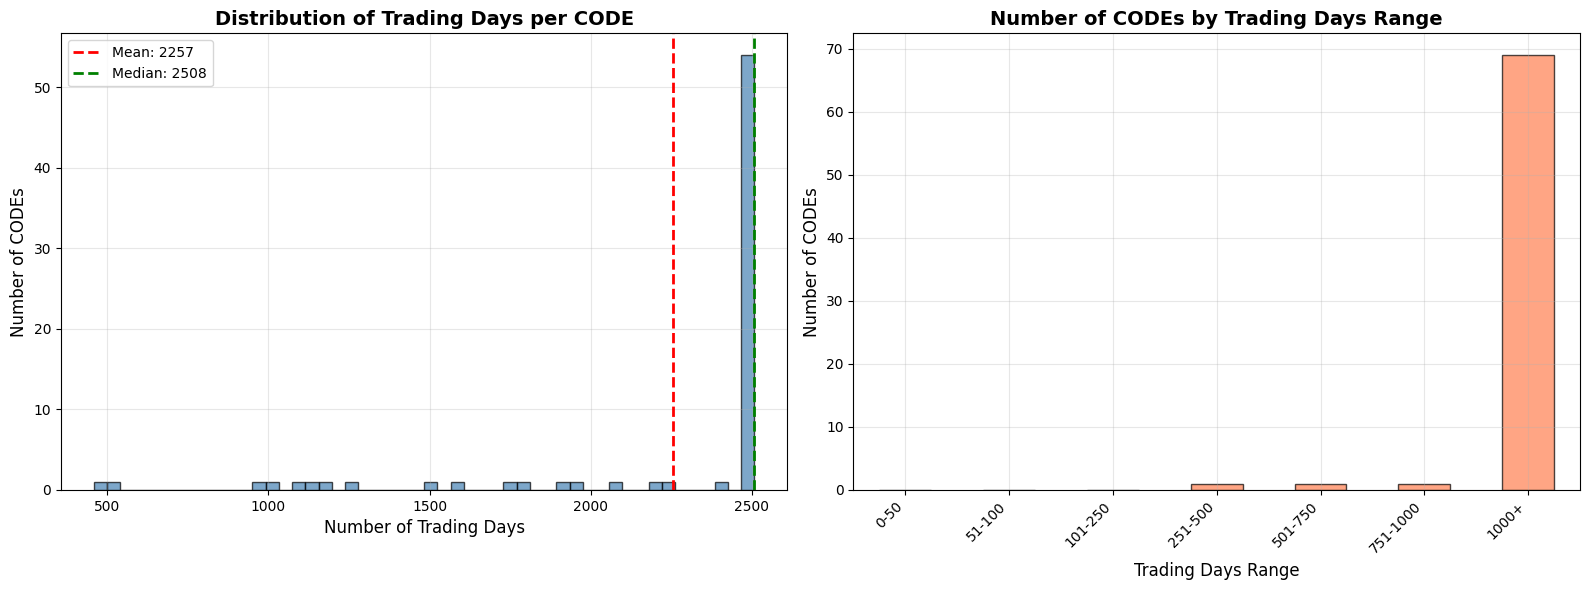

In [40]:
# Analyze how many trading days each CODE has been tracked
print("=" * 80)
print("TRADING DAYS PER CODE (TICKER) ANALYSIS")
print("=" * 80)

# Count unique SEANCE dates for each CODE
days_per_code = dataset.groupby('CODE')['SEANCE'].nunique().reset_index()
days_per_code.columns = ['CODE', 'Trading_Days']
days_per_code = days_per_code.sort_values('Trading_Days', ascending=False)

print(f"\nTotal unique CODEs: {len(days_per_code):,}")
print(f"\nTrading Days Statistics:")
print(f"  Mean: {days_per_code['Trading_Days'].mean():.2f} days")
print(f"  Median: {days_per_code['Trading_Days'].median():.0f} days")
print(f"  Min: {days_per_code['Trading_Days'].min()} days")
print(f"  Max: {days_per_code['Trading_Days'].max()} days")
print(f"  Std: {days_per_code['Trading_Days'].std():.2f} days")

print("\n" + "=" * 80)
print("TOP 10 MOST TRACKED CODES")
print("=" * 80)
display(days_per_code.head(10))

print("\n" + "=" * 80)
print("BOTTOM 10 LEAST TRACKED CODES")
print("=" * 80)
display(days_per_code.tail(10))

print("\n" + "=" * 80)
print("DISTRIBUTION OF TRADING DAYS")
print("=" * 80)

# Create bins for better understanding
bins = [0, 50, 100, 250, 500, 750, 1000, days_per_code['Trading_Days'].max() + 1]
labels = ['0-50', '51-100', '101-250', '251-500', '501-750', '751-1000', '1000+']
days_per_code['Days_Range'] = pd.cut(days_per_code['Trading_Days'], bins=bins, labels=labels, right=False)

distribution = days_per_code['Days_Range'].value_counts().sort_index()
print(distribution)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(days_per_code['Trading_Days'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Trading Days per CODE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Trading Days', fontsize=12)
axes[0].set_ylabel('Number of CODEs', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].axvline(days_per_code['Trading_Days'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {days_per_code["Trading_Days"].mean():.0f}')
axes[0].axvline(days_per_code['Trading_Days'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {days_per_code["Trading_Days"].median():.0f}')
axes[0].legend()

# Bar chart of ranges
distribution.plot(kind='bar', ax=axes[1], color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Number of CODEs by Trading Days Range', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Trading Days Range', fontsize=12)
axes[1].set_ylabel('Number of CODEs', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
print("CHECKING TICKERS TRACKED UNTIL END OF DATASET")

# Get the last date in the dataset
last_date = dataset['SEANCE'].max()
print(f"\nLast date in dataset: {last_date.date()}")

# For each CODE, get the last trading date
code_last_dates = dataset.groupby('CODE').agg({
    'SEANCE': ['min', 'max', 'nunique'],
    'VALEUR': 'first'
}).reset_index()

code_last_dates.columns = ['CODE', 'First_Date', 'Last_Date', 'Trading_Days', 'VALEUR']
code_last_dates = code_last_dates.sort_values('Last_Date', ascending=False)

# Split into active and inactive tickers - STRICT CHECK (must be on exact last date)
active_tickers = code_last_dates[code_last_dates['Last_Date'] == last_date]
inactive_tickers = code_last_dates[code_last_dates['Last_Date'] < last_date]

print("\nACTIVE TICKERS (Tracked until EXACT last date of dataset)")
print(f"\nTotal active tickers: {len(active_tickers)}")
print(f"\nStatistics for active tickers:")
print(f"  Mean trading days: {active_tickers['Trading_Days'].mean():.2f}")
print(f"  Median trading days: {active_tickers['Trading_Days'].median():.0f}")
print(f"  Min trading days: {active_tickers['Trading_Days'].min()}")
print(f"  Max trading days: {active_tickers['Trading_Days'].max()}")

# Check if any active tickers have old format codes
active_old_format = active_tickers[~active_tickers['CODE'].str.startswith('TN')]
print(f"\nActive tickers with OLD format codes: {len(active_old_format)}")
if len(active_old_format) > 0:
    print("\nWARNING: Found active tickers with old format codes:")
    display(active_old_format)

print("\nINACTIVE TICKERS (Stopped trading before last date)")
print(f"\nTotal inactive tickers: {len(inactive_tickers)}")
print(f"\nStatistics for inactive tickers:")
print(f"  Mean trading days: {inactive_tickers['Trading_Days'].mean():.2f}")
print(f"  Median trading days: {inactive_tickers['Trading_Days'].median():.0f}")
print(f"  Min trading days: {inactive_tickers['Trading_Days'].min()}")
print(f"  Max trading days: {inactive_tickers['Trading_Days'].max()}")

# Check old format codes in inactive tickers
inactive_old_format = inactive_tickers[~inactive_tickers['CODE'].str.startswith('TN')]
print(f"\nInactive tickers with OLD format codes: {len(inactive_old_format)}")

if len(inactive_old_format) > 0:
    print("\nInactive tickers with old format codes:")
    display(inactive_old_format[['CODE', 'VALEUR', 'First_Date', 'Last_Date', 'Trading_Days']])

print("\nBOTTOM 10 INACTIVE TICKERS (By Trading Days)")
display(inactive_tickers.nsmallest(20, 'Trading_Days')[['CODE', 'VALEUR', 'First_Date', 'Last_Date', 'Trading_Days']])

print("\nSUMMARY")
print(f"Total CODEs: {len(code_last_dates)}")
print(f"Active CODEs (tracked until {last_date.date()}): {len(active_tickers)} ({len(active_tickers)/len(code_last_dates)*100:.2f}%)")
print(f"Inactive CODEs: {len(inactive_tickers)} ({len(inactive_tickers)/len(code_last_dates)*100:.2f}%)")
print(f"\nOld format CODEs (not starting with 'TN'):")
print(f"  - Active: {len(active_old_format)}")
print(f"  - Inactive: {len(inactive_old_format)}")
print(f"  - Total: {len(active_old_format) + len(inactive_old_format)}")

CHECKING TICKERS TRACKED UNTIL END OF DATASET

Last date in dataset: 2025-12-31

ACTIVE TICKERS (Tracked until EXACT last date of dataset)

Total active tickers: 62

Statistics for active tickers:
  Mean trading days: 2366.66
  Median trading days: 2508
  Min trading days: 500
  Max trading days: 2508

Active tickers with OLD format codes: 0

INACTIVE TICKERS (Stopped trading before last date)

Total inactive tickers: 10

Statistics for inactive tickers:
  Mean trading days: 1574.50
  Median trading days: 1774
  Min trading days: 459
  Max trading days: 2181

Inactive tickers with OLD format codes: 3

Inactive tickers with old format codes:


CODE           VALEUR First_Date  Last_Date  Trading_Days
1  749001         HEXABYTE 2016-01-04 2020-09-29          1186
2  779001  TUNISIE VALEURS 2018-09-24 2020-07-24           459
0  330090           ELBENE 2016-01-04 2020-07-03          1127


BOTTOM 10 INACTIVE TICKERS (By Trading Days)


CODE           VALEUR First_Date  Last_Date  Trading_Days
2         779001  TUNISIE VALEURS 2018-09-24 2020-07-24           459
0         330090           ELBENE 2016-01-04 2020-07-03          1127
1         749001         HEXABYTE 2016-01-04 2020-09-29          1186
32  TN0006640015             STEQ 2016-01-04 2021-01-05          1253
41  TN0007250012            ADWYA 2016-01-04 2023-01-05          1760
63  TN0007640014         CEREALIS 2016-01-04 2023-02-13          1787
8   TN0001500859              AMS 2016-01-04 2023-09-15          1934
43  TN0007290018            SOPAT 2016-01-04 2023-11-03          1968
46  TN0007340011         SERVICOM 2016-01-04 2024-04-30          2090
33  TN0006650014      ELECTROSTAR 2016-01-04 2024-09-10          2181


SUMMARY
Total CODEs: 72
Active CODEs (tracked until 2025-12-31): 62 (86.11%)
Inactive CODEs: 10 (13.89%)

Old format CODEs (not starting with 'TN'):
  - Active: 0
  - Inactive: 3
  - Total: 3


In [42]:
print("DROPPING INACTIVE TICKERS FROM DATASET")

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique CODEs: {dataset['CODE'].nunique()}")

# Get list of active ticker CODEs
active_codes = active_tickers['CODE'].tolist()
print(f"\nActive CODEs to keep: {len(active_codes)}")

# Filter dataset to keep only active tickers
dataset = dataset[dataset['CODE'].isin(active_codes)]

# New shape after filtering
new_shape = dataset.shape
rows_removed = original_shape[0] - new_shape[0]

print(f"\nFiltered dataset shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nNew unique CODEs: {dataset['CODE'].nunique()}")
print(f"New unique VALEURs: {dataset['VALEUR'].nunique()}")

# Verify all remaining tickers are active
print("\nVERIFICATION")
final_last_dates = dataset.groupby('CODE')['SEANCE'].max()
all_active = (final_last_dates == last_date).all()

if all_active:
    print("SUCCESS: All remaining tickers are tracked until the last date")
else:
    print("WARNING: Some tickers may not be tracked until the last date")
    inactive_count = (final_last_dates < last_date).sum()
    print(f"Tickers not tracked until last date: {inactive_count}")

print("\nFINAL DATASET SUMMARY")
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique CODEs: {dataset['CODE'].nunique()}")
print(f"Unique VALEURs: {dataset['VALEUR'].nunique()}")
print(f"Date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DROPPING INACTIVE TICKERS FROM DATASET

Original dataset shape: (162478, 11)
Original number of rows: 162,478
Original unique CODEs: 72

Active CODEs to keep: 62

Filtered dataset shape: (146733, 11)
New number of rows: 146,733
Rows removed: 15,745
Percentage of data removed: 9.69%

New unique CODEs: 62
New unique VALEURs: 62

VERIFICATION
SUCCESS: All remaining tickers are tracked until the last date

FINAL DATASET SUMMARY
Shape: (146733, 11)
Rows: 146,733
Unique CODEs: 62
Unique VALEURs: 62
Date range: 2016-01-04 to 2025-12-31
Memory usage: 28.25 MB


In [43]:
# Statistical summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)

# Get numeric columns only
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns: {numeric_cols}")

if len(numeric_cols) > 0:
    display(dataset[numeric_cols].describe().T)
    
    # Additional statistics
    print("\n" + "=" * 60)
    print("ADDITIONAL STATISTICS")
    print("=" * 60)
    
    stats_df = pd.DataFrame({
        'Column': numeric_cols,
        'Mean': [dataset[col].mean() for col in numeric_cols],
        'Median': [dataset[col].median() for col in numeric_cols],
        'Std': [dataset[col].std() for col in numeric_cols],
        'Variance': [dataset[col].var() for col in numeric_cols],
        'Skewness': [dataset[col].skew() for col in numeric_cols],
        'Kurtosis': [dataset[col].kurtosis() for col in numeric_cols]
    })
    
    display(stats_df)
else:
    print("\nNo numeric columns found. Need to check data types.")

STATISTICAL SUMMARY

Numeric columns: ['GROUPE', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']


count           mean            std   min   25%  \
GROUPE             146733.0      19.396864      23.514198  11.0  11.0   
OUVERTURE          146733.0       15.09748      26.974373   0.0  1.98   
CLOTURE            146733.0      15.982548      27.465098   0.0  2.32   
PLUS_BAS           146733.0      12.843616      25.335434   0.0  0.51   
PLUS_HAUT          146733.0      12.936743        25.5593   0.0  0.48   
QUANTITE_NEGOCIEE  146733.0   12151.409363  164968.670065   0.0   4.0   
NB_TRANSACTION     146733.0      20.342159      41.936555   0.0   1.0   
CAPITAUX           146733.0  105656.111742  2493004.32432   0.0  23.8   

                       50%       75%          max  
GROUPE                11.0      12.0         99.0  
OUVERTURE             6.35     14.67        237.9  
CLOTURE                7.0      15.6       242.42  
PLUS_BAS              4.79     12.55       242.42  
PLUS_HAUT             4.82      12.7       242.42  
QUANTITE_NEGOCIEE    772.0    5074.0   45862421.0  
NB_TRANSACTION         6.0      23.0       1420.0  
CAPITAUX           5793.05  38126.41  802590290.5


ADDITIONAL STATISTICS


Column           Mean   Median           Std      Variance  \
0             GROUPE      19.396864    11.00  2.351420e+01  5.529175e+02   
1          OUVERTURE      15.097480     6.35  2.697437e+01  7.276168e+02   
2            CLOTURE      15.982548     7.00  2.746510e+01  7.543316e+02   
3           PLUS_BAS      12.843616     4.79  2.533543e+01  6.418842e+02   
4          PLUS_HAUT      12.936743     4.82  2.555930e+01  6.532778e+02   
5  QUANTITE_NEGOCIEE   12151.409363   772.00  1.649687e+05  2.721466e+10   
6     NB_TRANSACTION      20.342159     6.00  4.193656e+01  1.758675e+03   
7           CAPITAUX  105656.111742  5793.05  2.493004e+06  6.215071e+12   

     Skewness      Kurtosis  
0    2.806702      6.387768  
1    3.621838     15.242575  
2    3.501444     14.163471  
3    3.961043     18.300674  
4    3.971727     18.411341  
5  167.032542  42045.167257  
6    7.160176    101.477443  
7  239.345836  73870.241998

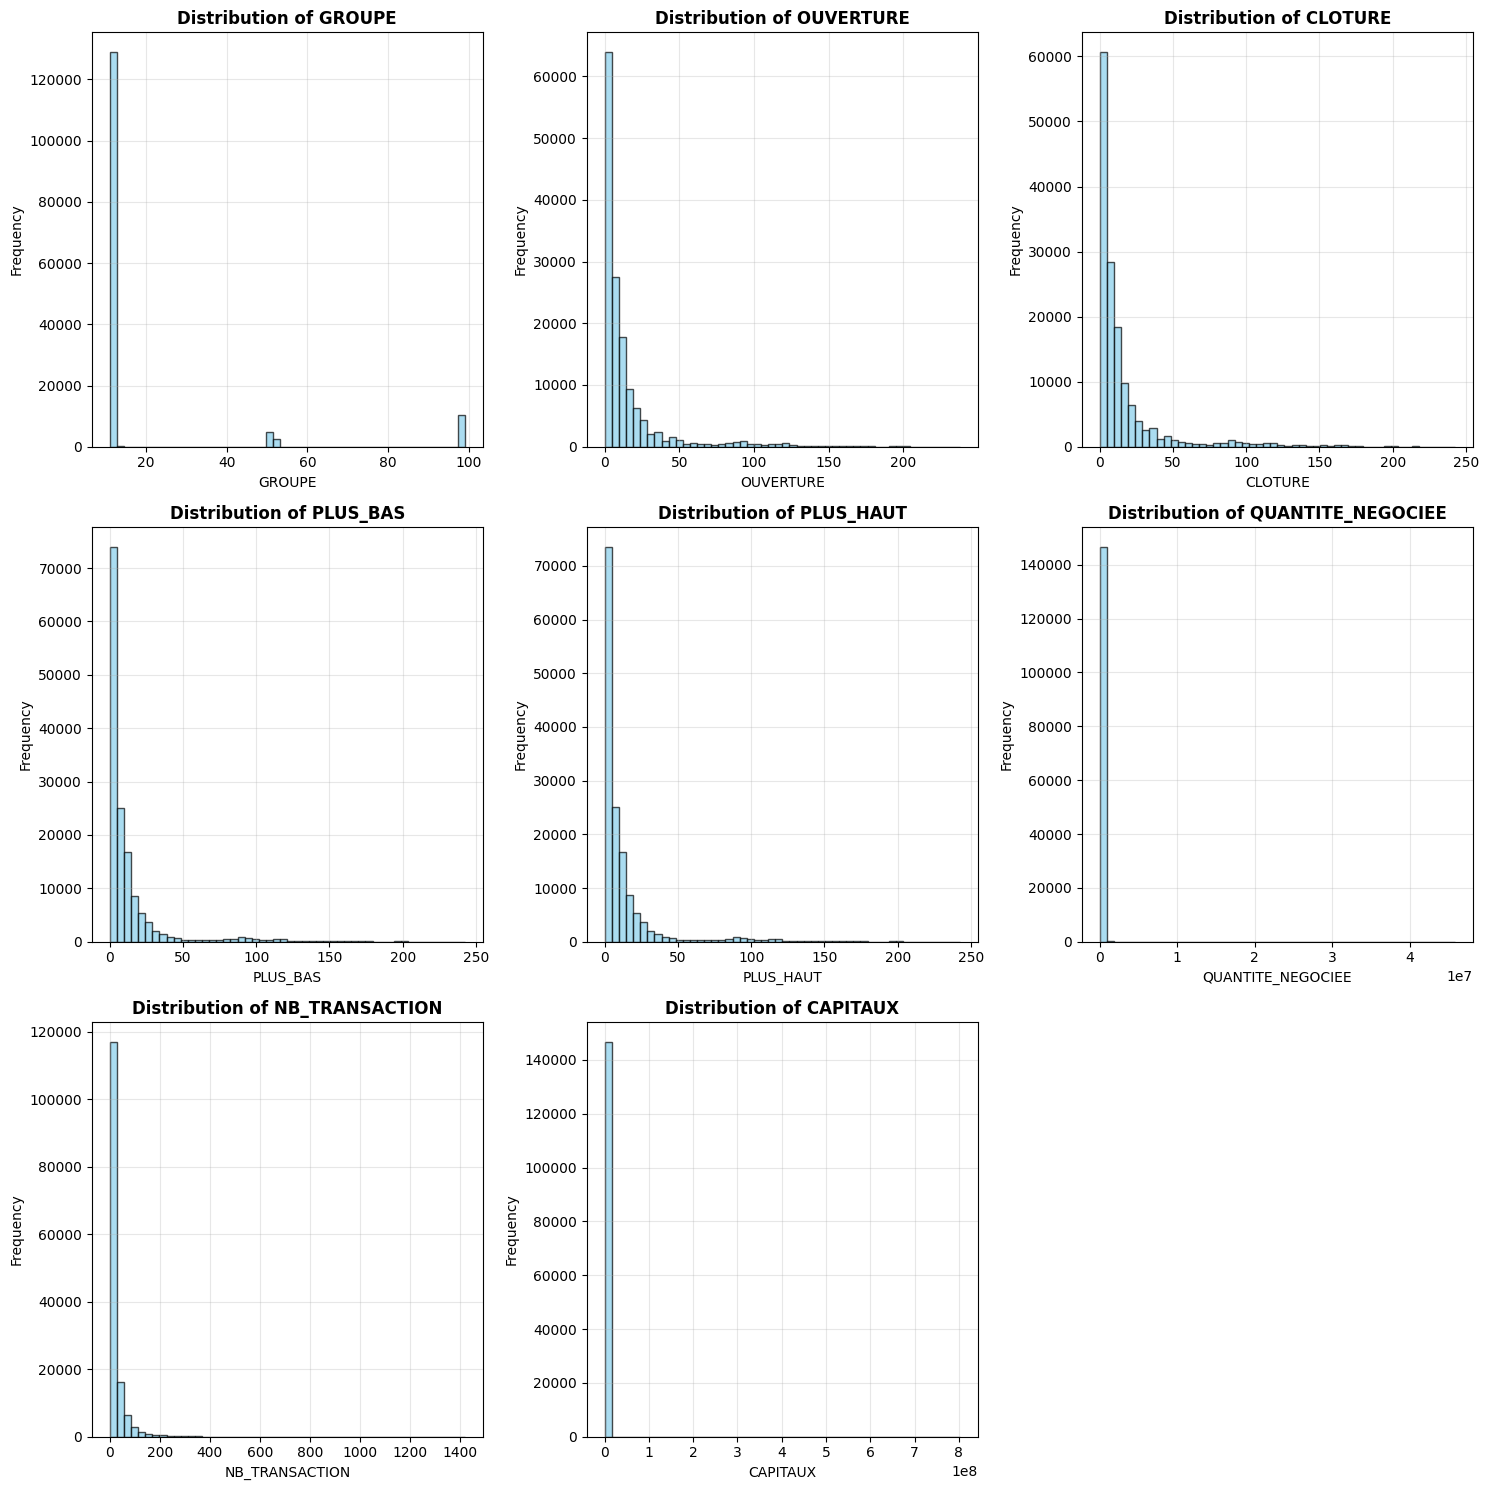

In [44]:
# Distribution plots for numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].hist(dataset[col].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns to plot.")

DISTRIBUTION ANALYSIS - NON-ZERO VALUES ONLY


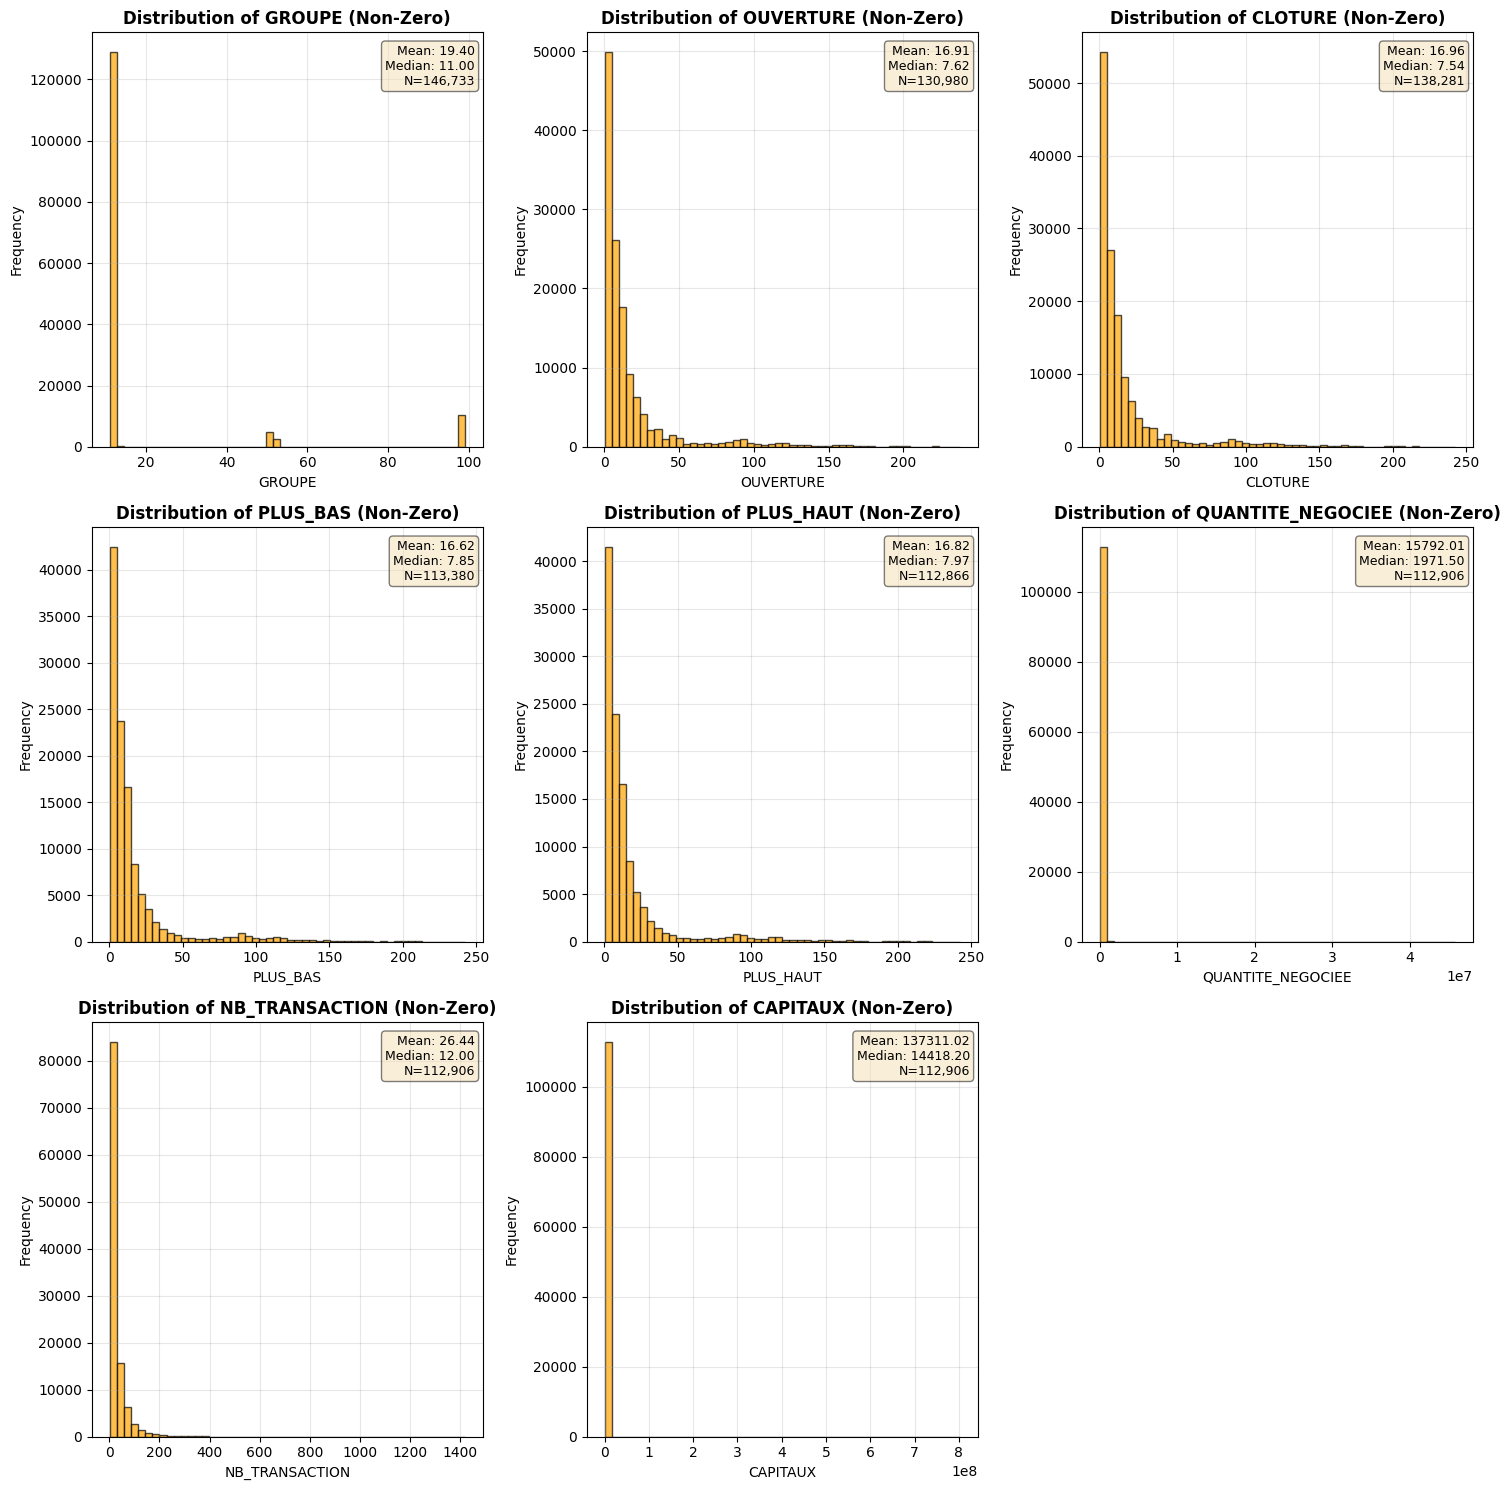


ZERO vs NON-ZERO VALUE STATISTICS


Column  Total_Count  Zero_Count  Non_Zero_Count  Zero_Percentage
0             GROUPE       146733           0          146733         0.000000
1          OUVERTURE       146733       15753          130980        10.735826
2            CLOTURE       146733        8452          138281         5.760122
3           PLUS_BAS       146733       33353          113380        22.730401
4          PLUS_HAUT       146733       33867          112866        23.080698
5  QUANTITE_NEGOCIEE       146733       33827          112906        23.053437
6     NB_TRANSACTION       146733       33827          112906        23.053437
7           CAPITAUX       146733       33827          112906        23.053437

In [45]:
# Distribution plots for numeric columns (excluding zero values)
print("=" * 80)
print("DISTRIBUTION ANALYSIS - NON-ZERO VALUES ONLY")
print("=" * 80)

numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        # Filter out zero values
        non_zero_data = dataset[dataset[col] != 0][col].dropna()
        
        if len(non_zero_data) > 0:
            axes[idx].hist(non_zero_data, bins=50, color='orange', edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'Distribution of {col} (Non-Zero)', fontweight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Frequency')
            axes[idx].grid(alpha=0.3)
            
            # Add statistics text
            mean_val = non_zero_data.mean()
            median_val = non_zero_data.median()
            stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nN={len(non_zero_data):,}'
            axes[idx].text(0.98, 0.97, stats_text, 
                          transform=axes[idx].transAxes,
                          verticalalignment='top',
                          horizontalalignment='right',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                          fontsize=9)
        else:
            axes[idx].text(0.5, 0.5, f'No non-zero values\nfor {col}',
                          transform=axes[idx].transAxes,
                          ha='center', va='center',
                          fontsize=12, color='red')
            axes[idx].set_title(f'Distribution of {col} (Non-Zero)', fontweight='bold')
    
    # Hide empty subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics about zero vs non-zero values
    print("\n" + "=" * 80)
    print("ZERO vs NON-ZERO VALUE STATISTICS")
    print("=" * 80)
    
    zero_stats = pd.DataFrame({
        'Column': numeric_cols,
        'Total_Count': [len(dataset[col].dropna()) for col in numeric_cols],
        'Zero_Count': [len(dataset[dataset[col] == 0][col]) for col in numeric_cols],
        'Non_Zero_Count': [len(dataset[dataset[col] != 0][col].dropna()) for col in numeric_cols],
        'Zero_Percentage': [(len(dataset[dataset[col] == 0][col]) / len(dataset[col].dropna()) * 100) 
                            if len(dataset[col].dropna()) > 0 else 0 for col in numeric_cols]
    })
    
    display(zero_stats)
else:
    print("No numeric columns to plot.")

TRADING DATA VALIDATION ANALYSIS

Validation Rules:
  1. CLOTURE > 0
  2. PLUS_HAUT >= max(OUVERTURE, CLOTURE)
  3. PLUS_BAS <= min(OUVERTURE, CLOTURE)

A row is VALID only if ALL three conditions are met.

OVERALL VALIDATION STATISTICS
Total rows: 146,733
Valid rows: 89,350 (60.89%)
Invalid rows: 57,383 (39.11%)

PER-TICKER VALIDATION STATISTICS

Total tickers analyzed: 62

Invalid Days Statistics:
  Mean: 40.22%
  Median: 34.33%
  Min: 10.81%
  Max: 86.76%
  Std: 22.53%

TOP 20 TICKERS WITH HIGHEST INVALID PERCENTAGE


VALEUR  Total_Days  Valid_Days  Invalid_Days  \
43               ASTREE        2508         332          2176   
56         BH ASSURANCE        1574         234          1340   
53                 STIP        2508         446          2062   
47           BEST LEASE        2508         504          2004   
55              SANIMED        2247         529          1718   
51             SOTEMAIL        2508         619          1889   
57           BH LEASING        1484         388          1096   
42                 UBCI        2508         717          1791   
61       BNA ASSURANCES         500         147           353   
46               SIPHAT        2508         741          1767   
9                SIMPAR        2508         764          1744   
25       HANNIBAL LEASE        2508         897          1611   
49               AETECH        2508         975          1533   
21                 SITS        2508         988          1520   
39            BTE (ADP)        2508        1030          1478   
45      MAGASIN GENERAL        2508        1049          1459   
26   CIMENTS DE BIZERTE        2508        1106          1402   
10                  CIL        2508        1107          1401   
41  AIR LIQUIDE TUNISIE        2508        1115          1393   
12                 STAR        2508        1220          1288   

    Invalid_Percentage  CLOTURE_Fail  PLUS_HAUT_Fail  PLUS_BAS_Fail  
43           86.762360           630            1495             75  
56           85.133418           141            1178             44  
53           82.216906           548            1307            230  
47           79.904306           524            1381            119  
55           76.457499           293            1309            140  
51           75.318979           384            1456             70  
57           73.854447           136             660            327  
42           71.411483           492            1121            194  
61           70.600000             1             201            153  
46           70.454545           374            1209            205  
9            69.537480           337            1352             78  
25           64.234450           370            1044            213  
49           61.124402           243            1192            113  
21           60.606061           191            1257             97  
39           58.931419           318             983            207  
45           58.173844           204            1134            148  
26           55.901116           237             980            211  
10           55.861244           294             898            227  
41           55.542265           309             772            327  
12           51.355662           196             889            225


TOP 20 TICKERS WITH LOWEST INVALID PERCENTAGE


VALEUR  Total_Days  Valid_Days  Invalid_Days  Invalid_Percentage  \
8               UIB        2508        1934           574           22.886762   
36       SOTIPAPIER        2508        2001           507           20.215311   
37   DELICE HOLDING        2508        2007           501           19.976077   
24            ARTES        2508        2012           496           19.776715   
15          SOTUMAG        2508        2022           486           19.377990   
54           UNIMED        2426        1956           470           19.373454   
13          SOTETEL        2508        2027           481           19.178628   
29   TELNET HOLDING        2508        2052           456           18.181818   
6          STB BANK        2508        2054           454           18.102073   
7         AMEN BANK        2508        2058           450           17.942584   
3     ATTIJARI BANK        2508        2086           422           16.826156   
32      EURO-CYCLES        2508        2092           416           16.586922   
30         ONE TECH        2508        2094           414           16.507177   
23              TPR        2508        2105           403           16.068581   
4              BIAT        2508        2124           384           15.311005   
19          SOMOCER        2508        2142           366           14.593301   
14          SOTUVER        2508        2149           359           14.314195   
48  CARTHAGE CEMENT        2508        2181           327           13.038278   
1              SFBT        2508        2205           303           12.081340   
34              SAH        2508        2237           271           10.805423   

    CLOTURE_Fail  PLUS_HAUT_Fail  PLUS_BAS_Fail  
8              7             432            141  
36            28             319            162  
37            55             338            110  
24            23             299            177  
15            20             300            168  
54            15             386             72  
13            35             368             84  
29            11             264            186  
6             21             376             59  
7             21             315            118  
3              2             221            202  
32             8             209            203  
30            56             278             83  
23             3             221            184  
4              4             248            135  
19             2             275             92  
14             4             288             70  
48            10             201            118  
1              1             230             75  
34             3             120            150


TICKERS WITH 100% VALID DATA: 0

TICKERS WITH >50% INVALID DATA: 21


VALEUR  Total_Days  Valid_Days  Invalid_Days  \
43               ASTREE        2508         332          2176   
56         BH ASSURANCE        1574         234          1340   
53                 STIP        2508         446          2062   
47           BEST LEASE        2508         504          2004   
55              SANIMED        2247         529          1718   
51             SOTEMAIL        2508         619          1889   
57           BH LEASING        1484         388          1096   
42                 UBCI        2508         717          1791   
61       BNA ASSURANCES         500         147           353   
46               SIPHAT        2508         741          1767   
9                SIMPAR        2508         764          1744   
25       HANNIBAL LEASE        2508         897          1611   
49               AETECH        2508         975          1533   
21                 SITS        2508         988          1520   
39            BTE (ADP)        2508        1030          1478   
45      MAGASIN GENERAL        2508        1049          1459   
26   CIMENTS DE BIZERTE        2508        1106          1402   
10                  CIL        2508        1107          1401   
41  AIR LIQUIDE TUNISIE        2508        1115          1393   
12                 STAR        2508        1220          1288   
33              CELLCOM        2508        1251          1257   

    Invalid_Percentage  CLOTURE_Fail  PLUS_HAUT_Fail  PLUS_BAS_Fail  
43           86.762360           630            1495             75  
56           85.133418           141            1178             44  
53           82.216906           548            1307            230  
47           79.904306           524            1381            119  
55           76.457499           293            1309            140  
51           75.318979           384            1456             70  
57           73.854447           136             660            327  
42           71.411483           492            1121            194  
61           70.600000             1             201            153  
46           70.454545           374            1209            205  
9            69.537480           337            1352             78  
25           64.234450           370            1044            213  
49           61.124402           243            1192            113  
21           60.606061           191            1257             97  
39           58.931419           318             983            207  
45           58.173844           204            1134            148  
26           55.901116           237             980            211  
10           55.861244           294             898            227  
41           55.542265           309             772            327  
12           51.355662           196             889            225  
33           50.119617            97             903            282

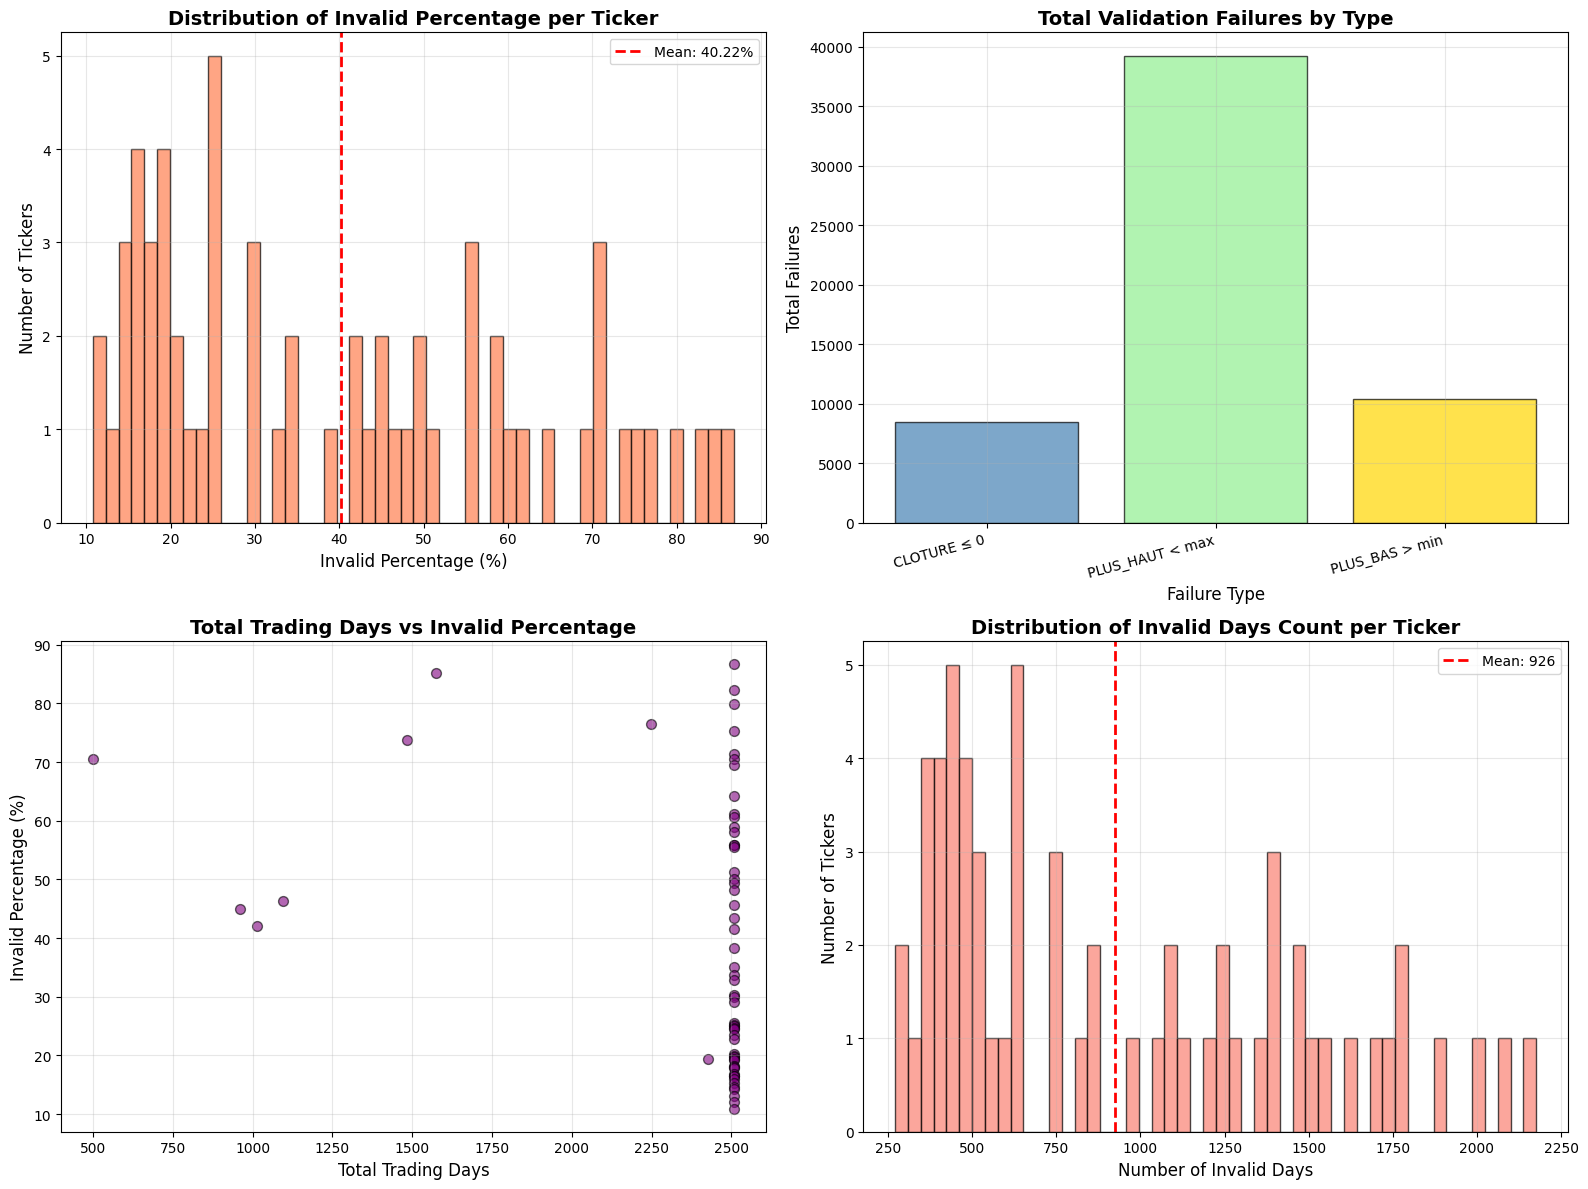


VALIDATION ANALYSIS COMPLETE

Validation DataFrame stored as 'ticker_validation_df'
Dataset now includes 'is_valid' column


In [46]:
print("=" * 80)
print("TRADING DATA VALIDATION ANALYSIS")
print("=" * 80)

print("\nValidation Rules:")
print("  1. CLOTURE > 0")
print("  2. PLUS_HAUT >= max(OUVERTURE, CLOTURE)")
print("  3. PLUS_BAS <= min(OUVERTURE, CLOTURE)")
print("\nA row is VALID only if ALL three conditions are met.")

# Create validation flags
dataset['is_valid'] = (
    (dataset['CLOTURE'] > 0) &
    (dataset['PLUS_HAUT'] >= dataset[['OUVERTURE', 'CLOTURE']].max(axis=1)) &
    (dataset['PLUS_BAS'] <= dataset[['OUVERTURE', 'CLOTURE']].min(axis=1))
)

# Overall validation statistics
total_rows = len(dataset)
valid_rows = dataset['is_valid'].sum()
invalid_rows = total_rows - valid_rows

print("\n" + "=" * 80)
print("OVERALL VALIDATION STATISTICS")
print("=" * 80)
print(f"Total rows: {total_rows:,}")
print(f"Valid rows: {valid_rows:,} ({valid_rows/total_rows*100:.2f}%)")
print(f"Invalid rows: {invalid_rows:,} ({invalid_rows/total_rows*100:.2f}%)")

# Per-ticker validation analysis
ticker_validation = []

for ticker in dataset['VALEUR'].unique():
    ticker_data = dataset[dataset['VALEUR'] == ticker]
    
    total_days = len(ticker_data)
    valid_days = ticker_data['is_valid'].sum()
    invalid_days = total_days - valid_days
    invalid_pct = (invalid_days / total_days) * 100 if total_days > 0 else 0
    
    # Breakdown of which conditions fail
    cloture_fail = (ticker_data['CLOTURE'] <= 0).sum()
    plus_haut_fail = (ticker_data['PLUS_HAUT'] < ticker_data[['OUVERTURE', 'CLOTURE']].max(axis=1)).sum()
    plus_bas_fail = (ticker_data['PLUS_BAS'] > ticker_data[['OUVERTURE', 'CLOTURE']].min(axis=1)).sum()
    
    ticker_validation.append({
        'VALEUR': ticker,
        'Total_Days': total_days,
        'Valid_Days': valid_days,
        'Invalid_Days': invalid_days,
        'Invalid_Percentage': invalid_pct,
        'CLOTURE_Fail': cloture_fail,
        'PLUS_HAUT_Fail': plus_haut_fail,
        'PLUS_BAS_Fail': plus_bas_fail
    })

ticker_validation_df = pd.DataFrame(ticker_validation)
ticker_validation_df = ticker_validation_df.sort_values('Invalid_Percentage', ascending=False)

print("\n" + "=" * 80)
print("PER-TICKER VALIDATION STATISTICS")
print("=" * 80)

print(f"\nTotal tickers analyzed: {len(ticker_validation_df)}")
print(f"\nInvalid Days Statistics:")
print(f"  Mean: {ticker_validation_df['Invalid_Percentage'].mean():.2f}%")
print(f"  Median: {ticker_validation_df['Invalid_Percentage'].median():.2f}%")
print(f"  Min: {ticker_validation_df['Invalid_Percentage'].min():.2f}%")
print(f"  Max: {ticker_validation_df['Invalid_Percentage'].max():.2f}%")
print(f"  Std: {ticker_validation_df['Invalid_Percentage'].std():.2f}%")

print("\n" + "=" * 80)
print("TOP 20 TICKERS WITH HIGHEST INVALID PERCENTAGE")
print("=" * 80)
display(ticker_validation_df.head(20))

print("\n" + "=" * 80)
print("TOP 20 TICKERS WITH LOWEST INVALID PERCENTAGE")
print("=" * 80)
display(ticker_validation_df.tail(20))

# Tickers with 100% valid data
perfect_tickers = ticker_validation_df[ticker_validation_df['Invalid_Percentage'] == 0]
print("\n" + "=" * 80)
print(f"TICKERS WITH 100% VALID DATA: {len(perfect_tickers)}")
print("=" * 80)
if len(perfect_tickers) > 0:
    display(perfect_tickers)

# Tickers with >50% invalid data
highly_invalid = ticker_validation_df[ticker_validation_df['Invalid_Percentage'] > 50]
print("\n" + "=" * 80)
print(f"TICKERS WITH >50% INVALID DATA: {len(highly_invalid)}")
print("=" * 80)
if len(highly_invalid) > 0:
    display(highly_invalid)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram of invalid percentages
axes[0, 0].hist(ticker_validation_df['Invalid_Percentage'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Invalid Percentage per Ticker', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Invalid Percentage (%)', fontsize=12)
axes[0, 0].set_ylabel('Number of Tickers', fontsize=12)
axes[0, 0].axvline(ticker_validation_df['Invalid_Percentage'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ticker_validation_df["Invalid_Percentage"].mean():.2f}%')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Bar chart - validation failure types
failure_types = ['CLOTURE_Fail', 'PLUS_HAUT_Fail', 'PLUS_BAS_Fail']
failure_counts = [ticker_validation_df[fail_type].sum() for fail_type in failure_types]
axes[0, 1].bar(range(len(failure_types)), failure_counts, color=['steelblue', 'lightgreen', 'gold'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Total Validation Failures by Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Failure Type', fontsize=12)
axes[0, 1].set_ylabel('Total Failures', fontsize=12)
axes[0, 1].set_xticks(range(len(failure_types)))
axes[0, 1].set_xticklabels(['CLOTURE ≤ 0', 'PLUS_HAUT < max', 'PLUS_BAS > min'], rotation=15, ha='right')
axes[0, 1].grid(alpha=0.3)

# 3. Scatter plot - Total days vs Invalid percentage
axes[1, 0].scatter(ticker_validation_df['Total_Days'], ticker_validation_df['Invalid_Percentage'], 
                   alpha=0.6, c='purple', edgecolors='black', s=50)
axes[1, 0].set_title('Total Trading Days vs Invalid Percentage', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Trading Days', fontsize=12)
axes[1, 0].set_ylabel('Invalid Percentage (%)', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# 4. Distribution of invalid days (absolute count)
axes[1, 1].hist(ticker_validation_df['Invalid_Days'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Invalid Days Count per Ticker', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Invalid Days', fontsize=12)
axes[1, 1].set_ylabel('Number of Tickers', fontsize=12)
axes[1, 1].axvline(ticker_validation_df['Invalid_Days'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ticker_validation_df["Invalid_Days"].mean():.0f}')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("VALIDATION ANALYSIS COMPLETE")
print("=" * 80)
print("\nValidation DataFrame stored as 'ticker_validation_df'")
print("Dataset now includes 'is_valid' column")

dataset = dataset.drop('is_valid', axis=1)

In [47]:
print("=" * 80)
print("DROPPING TICKERS WITH >50% INVALID DATA")
print("=" * 80)

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique tickers: {dataset['VALEUR'].nunique()}")

# Get tickers with >50% invalid data from ticker_validation_df
highly_invalid_tickers = ticker_validation_df[ticker_validation_df['Invalid_Percentage'] > 50]['VALEUR'].tolist()

print(f"\nTickers with >50% invalid data: {len(highly_invalid_tickers)}")
print("\nTickers to be removed:")
for ticker in highly_invalid_tickers:
    invalid_pct = ticker_validation_df[ticker_validation_df['VALEUR'] == ticker]['Invalid_Percentage'].values[0]
    print(f"  - {ticker}: {invalid_pct:.2f}% invalid")

# Filter out rows for these tickers
dataset = dataset[~dataset['VALEUR'].isin(highly_invalid_tickers)]

# New shape after filtering
new_shape = dataset.shape
rows_removed = original_shape[0] - new_shape[0]

print("\n" + "=" * 80)
print("REMOVAL SUMMARY")
print("=" * 80)
print(f"\nFiltered dataset shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nNew unique tickers (VALEUR): {dataset['VALEUR'].nunique()}")
print(f"Tickers removed: {original_shape[0] - new_shape[0]}")

# Verify removal
remaining_invalid = dataset[dataset['VALEUR'].isin(highly_invalid_tickers)]
if len(remaining_invalid) == 0:
    print("\n✓ SUCCESS: All highly invalid tickers have been removed!")
else:
    print(f"\n⚠ WARNING: {len(remaining_invalid)} rows from invalid tickers still remain")

print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Unique CODEs: {dataset['CODE'].nunique()}")
print(f"Date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Optional: Update ticker_validation_df to reflect removal
print("\n" + "=" * 80)
print("UPDATING VALIDATION DATAFRAME")
print("=" * 80)

ticker_validation_df = ticker_validation_df[~ticker_validation_df['VALEUR'].isin(highly_invalid_tickers)]
print(f"Remaining tickers in validation df: {len(ticker_validation_df)}")
print(f"\nNew validation statistics:")
print(f"  Mean invalid %: {ticker_validation_df['Invalid_Percentage'].mean():.2f}%")
print(f"  Median invalid %: {ticker_validation_df['Invalid_Percentage'].median():.2f}%")
print(f"  Max invalid %: {ticker_validation_df['Invalid_Percentage'].max():.2f}%")

DROPPING TICKERS WITH >50% INVALID DATA

Original dataset shape: (146733, 11)
Original number of rows: 146,733
Original unique tickers: 62

Tickers with >50% invalid data: 21

Tickers to be removed:
  - ASTREE: 86.76% invalid
  - BH ASSURANCE: 85.13% invalid
  - STIP: 82.22% invalid
  - BEST LEASE: 79.90% invalid
  - SANIMED: 76.46% invalid
  - SOTEMAIL: 75.32% invalid
  - BH LEASING: 73.85% invalid
  - UBCI: 71.41% invalid
  - BNA ASSURANCES: 70.60% invalid
  - SIPHAT: 70.45% invalid
  - SIMPAR: 69.54% invalid
  - HANNIBAL LEASE: 64.23% invalid
  - AETECH: 61.12% invalid
  - SITS: 60.61% invalid
  - BTE (ADP): 58.93% invalid
  - MAGASIN GENERAL: 58.17% invalid
  - CIMENTS DE BIZERTE: 55.90% invalid
  - CIL: 55.86% invalid
  - AIR LIQUIDE TUNISIE: 55.54% invalid
  - STAR: 51.36% invalid
  - CELLCOM: 50.12% invalid

REMOVAL SUMMARY

Filtered dataset shape: (98292, 11)
New number of rows: 98,292
Rows removed: 48,441
Percentage of data removed: 33.01%

New unique tickers (VALEUR): 41
Tick

In [48]:
print("=" * 80)
print("DROPPING ROWS WITH CLOTURE = 0")
print("=" * 80)

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique tickers: {dataset['VALEUR'].nunique()}")

# Count rows with CLOTURE = 0
zero_cloture_rows = (dataset['CLOTURE'] == 0).sum()
zero_cloture_pct = (zero_cloture_rows / len(dataset)) * 100

print(f"\nRows with CLOTURE = 0: {zero_cloture_rows:,} ({zero_cloture_pct:.2f}%)")

# Show breakdown by ticker
print("\n" + "=" * 80)
print("ZERO CLOTURE BREAKDOWN BY TICKER")
print("=" * 80)

zero_by_ticker = dataset[dataset['CLOTURE'] == 0].groupby('VALEUR').size().reset_index(name='Zero_Count')
zero_by_ticker = zero_by_ticker.sort_values('Zero_Count', ascending=False)

if len(zero_by_ticker) > 0:
    print(f"\nTickers affected: {len(zero_by_ticker)}")
    print("\nTop 10 tickers with most zero CLOTURE rows:")
    display(zero_by_ticker.head(10))
else:
    print("\nNo tickers with zero CLOTURE found.")

# Filter out rows where CLOTURE = 0
dataset = dataset[dataset['CLOTURE'] > 0]

# New shape after filtering
new_shape = dataset.shape
rows_removed = original_shape[0] - new_shape[0]

print("\n" + "=" * 80)
print("REMOVAL SUMMARY")
print("=" * 80)
print(f"\nFiltered dataset shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nRemaining unique tickers: {dataset['VALEUR'].nunique()}")

# Verify removal
remaining_zero_cloture = (dataset['CLOTURE'] == 0).sum()
if remaining_zero_cloture == 0:
    print("\n✓ SUCCESS: All rows with CLOTURE = 0 have been removed!")
else:
    print(f"\n⚠ WARNING: {remaining_zero_cloture} rows with CLOTURE = 0 still remain")

print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Unique CODEs: {dataset['CODE'].nunique()}")
print(f"Date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Update statistics
print("\n" + "=" * 80)
print("CLOTURE STATISTICS AFTER CLEANUP")
print("=" * 80)
print(f"Min CLOTURE: {dataset['CLOTURE'].min():.2f}")
print(f"Max CLOTURE: {dataset['CLOTURE'].max():.2f}")
print(f"Mean CLOTURE: {dataset['CLOTURE'].mean():.2f}")
print(f"Median CLOTURE: {dataset['CLOTURE'].median():.2f}")

DROPPING ROWS WITH CLOTURE = 0

Original dataset shape: (98292, 11)
Original number of rows: 98,292
Original unique tickers: 41

Rows with CLOTURE = 0: 2,133 (2.17%)

ZERO CLOTURE BREAKDOWN BY TICKER

Tickers affected: 41

Top 10 tickers with most zero CLOTURE rows:


VALEUR  Zero_Count
29                SPDIT - SICAF         304
13                          ICF         261
4              ATTIJARI LEASING         223
11                     ESSOUKNA         173
37  TUNISIE LEASING & FACTORING         145
16                NEW BODY LINE         122
26                     SOTRAPIL          87
35                     TUNIS RE          75
8                     CITY CARS          71
15                         MPBS          70


REMOVAL SUMMARY

Filtered dataset shape: (96159, 11)
New number of rows: 96,159
Rows removed: 2,133
Percentage of data removed: 2.17%

Remaining unique tickers: 41

✓ SUCCESS: All rows with CLOTURE = 0 have been removed!

FINAL DATASET SUMMARY
Shape: (96159, 11)
Rows: 96,159
Unique tickers: 41
Unique CODEs: 41
Date range: 2016-01-04 to 2025-12-31
Memory usage: 18.52 MB

CLOTURE STATISTICS AFTER CLEANUP
Min CLOTURE: 0.21
Max CLOTURE: 222.90
Mean CLOTURE: 14.08
Median CLOTURE: 8.15


In [49]:
print("=" * 80)
print("FIXING PLUS_HAUT AND PLUS_BAS VALUES")
print("=" * 80)

# Calculate max(OUVERTURE, CLOTURE) and min(OUVERTURE, CLOTURE)
dataset['max_oc'] = dataset[['OUVERTURE', 'CLOTURE']].max(axis=1)
dataset['min_oc'] = dataset[['OUVERTURE', 'CLOTURE']].min(axis=1)

# Identify rows that need correction
plus_haut_invalid = dataset['PLUS_HAUT'] < dataset['max_oc']
plus_bas_invalid = dataset['PLUS_BAS'] > dataset['min_oc']

# Count invalid rows before correction
plus_haut_issues = plus_haut_invalid.sum()
plus_bas_issues = plus_bas_invalid.sum()
total_issues = (plus_haut_invalid | plus_bas_invalid).sum()

print(f"\nRows with issues BEFORE correction:")
print(f"  PLUS_HAUT < max(OUVERTURE, CLOTURE): {plus_haut_issues:,} ({plus_haut_issues/len(dataset)*100:.2f}%)")
print(f"  PLUS_BAS > min(OUVERTURE, CLOTURE): {plus_bas_issues:,} ({plus_bas_issues/len(dataset)*100:.2f}%)")
print(f"  Total rows with at least one issue: {total_issues:,} ({total_issues/len(dataset)*100:.2f}%)")

# Show examples before correction
if total_issues > 0:
    print("\n" + "=" * 80)
    print("EXAMPLES BEFORE CORRECTION (First 5 rows with issues)")
    print("=" * 80)
    issues_df = dataset[plus_haut_invalid | plus_bas_invalid][['SEANCE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_HAUT', 'PLUS_BAS', 'max_oc', 'min_oc']].head()
    display(issues_df)

# Apply corrections
print("\n" + "=" * 80)
print("APPLYING CORRECTIONS")
print("=" * 80)

# Fix PLUS_HAUT: set to max(OUVERTURE, CLOTURE) if it's less
dataset.loc[plus_haut_invalid, 'PLUS_HAUT'] = dataset.loc[plus_haut_invalid, 'max_oc']
print(f"✓ Fixed {plus_haut_issues:,} PLUS_HAUT values")

# Fix PLUS_BAS: set to min(OUVERTURE, CLOTURE) if it's greater
dataset.loc[plus_bas_invalid, 'PLUS_BAS'] = dataset.loc[plus_bas_invalid, 'min_oc']
print(f"✓ Fixed {plus_bas_issues:,} PLUS_BAS values")

# Verify corrections
print("\n" + "=" * 80)
print("VERIFICATION AFTER CORRECTION")
print("=" * 80)

plus_haut_still_invalid = (dataset['PLUS_HAUT'] < dataset['max_oc']).sum()
plus_bas_still_invalid = (dataset['PLUS_BAS'] > dataset['min_oc']).sum()
total_still_invalid = ((dataset['PLUS_HAUT'] < dataset['max_oc']) | (dataset['PLUS_BAS'] > dataset['min_oc'])).sum()

print(f"\nRows with issues AFTER correction:")
print(f"  PLUS_HAUT < max(OUVERTURE, CLOTURE): {plus_haut_still_invalid:,}")
print(f"  PLUS_BAS > min(OUVERTURE, CLOTURE): {plus_bas_still_invalid:,}")
print(f"  Total rows with at least one issue: {total_still_invalid:,}")

if total_still_invalid == 0:
    print("\n✓ SUCCESS: All PLUS_HAUT and PLUS_BAS values are now valid!")
else:
    print(f"\n⚠ WARNING: {total_still_invalid} rows still have issues")

# Show examples after correction (same rows as before)
if total_issues > 0:
    print("\n" + "=" * 80)
    print("EXAMPLES AFTER CORRECTION (Same rows as before)")
    print("=" * 80)
    # Get the same indices as before
    issue_indices = dataset[plus_haut_invalid | plus_bas_invalid].head().index
    corrected_df = dataset.loc[issue_indices, ['SEANCE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_HAUT', 'PLUS_BAS', 'max_oc', 'min_oc']]
    display(corrected_df)

# Clean up temporary columns
dataset = dataset.drop(columns=['max_oc', 'min_oc'])

print("\n" + "=" * 80)
print("CORRECTION SUMMARY")
print("=" * 80)
print(f"Total rows corrected: {total_issues:,}")
print(f"PLUS_HAUT corrections: {plus_haut_issues:,}")
print(f"PLUS_BAS corrections: {plus_bas_issues:,}")
print(f"Percentage of data corrected: {total_issues/len(dataset)*100:.2f}%")

print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")

FIXING PLUS_HAUT AND PLUS_BAS VALUES

Rows with issues BEFORE correction:
  PLUS_HAUT < max(OUVERTURE, CLOTURE): 16,487 (17.15%)
  PLUS_BAS > min(OUVERTURE, CLOTURE): 6,691 (6.96%)
  Total rows with at least one issue: 22,968 (23.89%)

EXAMPLES BEFORE CORRECTION (First 5 rows with issues)


SEANCE         VALEUR  OUVERTURE  CLOTURE  PLUS_HAUT  PLUS_BAS  \
259755 2018-01-02          ASSAD        0.0     9.00        0.0       0.0   
259801 2018-01-02         UNIMED        0.0     7.85        0.0       0.0   
259811 2018-01-02            ICF        0.0    28.13        0.0       0.0   
259815 2018-01-02  SPDIT - SICAF        0.0     8.20        0.0       0.0   
260405 2018-01-04  SPDIT - SICAF        0.0     8.10        0.0       0.0   

        max_oc  min_oc  
259755    9.00     0.0  
259801    7.85     0.0  
259811   28.13     0.0  
259815    8.20     0.0  
260405    8.10     0.0


APPLYING CORRECTIONS
✓ Fixed 16,487 PLUS_HAUT values
✓ Fixed 6,691 PLUS_BAS values

VERIFICATION AFTER CORRECTION

Rows with issues AFTER correction:
  PLUS_HAUT < max(OUVERTURE, CLOTURE): 0
  PLUS_BAS > min(OUVERTURE, CLOTURE): 0
  Total rows with at least one issue: 0

✓ SUCCESS: All PLUS_HAUT and PLUS_BAS values are now valid!

EXAMPLES AFTER CORRECTION (Same rows as before)


SEANCE         VALEUR  OUVERTURE  CLOTURE  PLUS_HAUT  PLUS_BAS  \
259755 2018-01-02          ASSAD        0.0     9.00       9.00       0.0   
259801 2018-01-02         UNIMED        0.0     7.85       7.85       0.0   
259811 2018-01-02            ICF        0.0    28.13      28.13       0.0   
259815 2018-01-02  SPDIT - SICAF        0.0     8.20       8.20       0.0   
260405 2018-01-04  SPDIT - SICAF        0.0     8.10       8.10       0.0   

        max_oc  min_oc  
259755    9.00     0.0  
259801    7.85     0.0  
259811   28.13     0.0  
259815    8.20     0.0  
260405    8.10     0.0


CORRECTION SUMMARY
Total rows corrected: 22,968
PLUS_HAUT corrections: 16,487
PLUS_BAS corrections: 6,691
Percentage of data corrected: 23.89%

FINAL DATASET SUMMARY
Shape: (96159, 11)
Rows: 96,159
Unique tickers: 41
Date range: 2016-01-04 to 2025-12-31


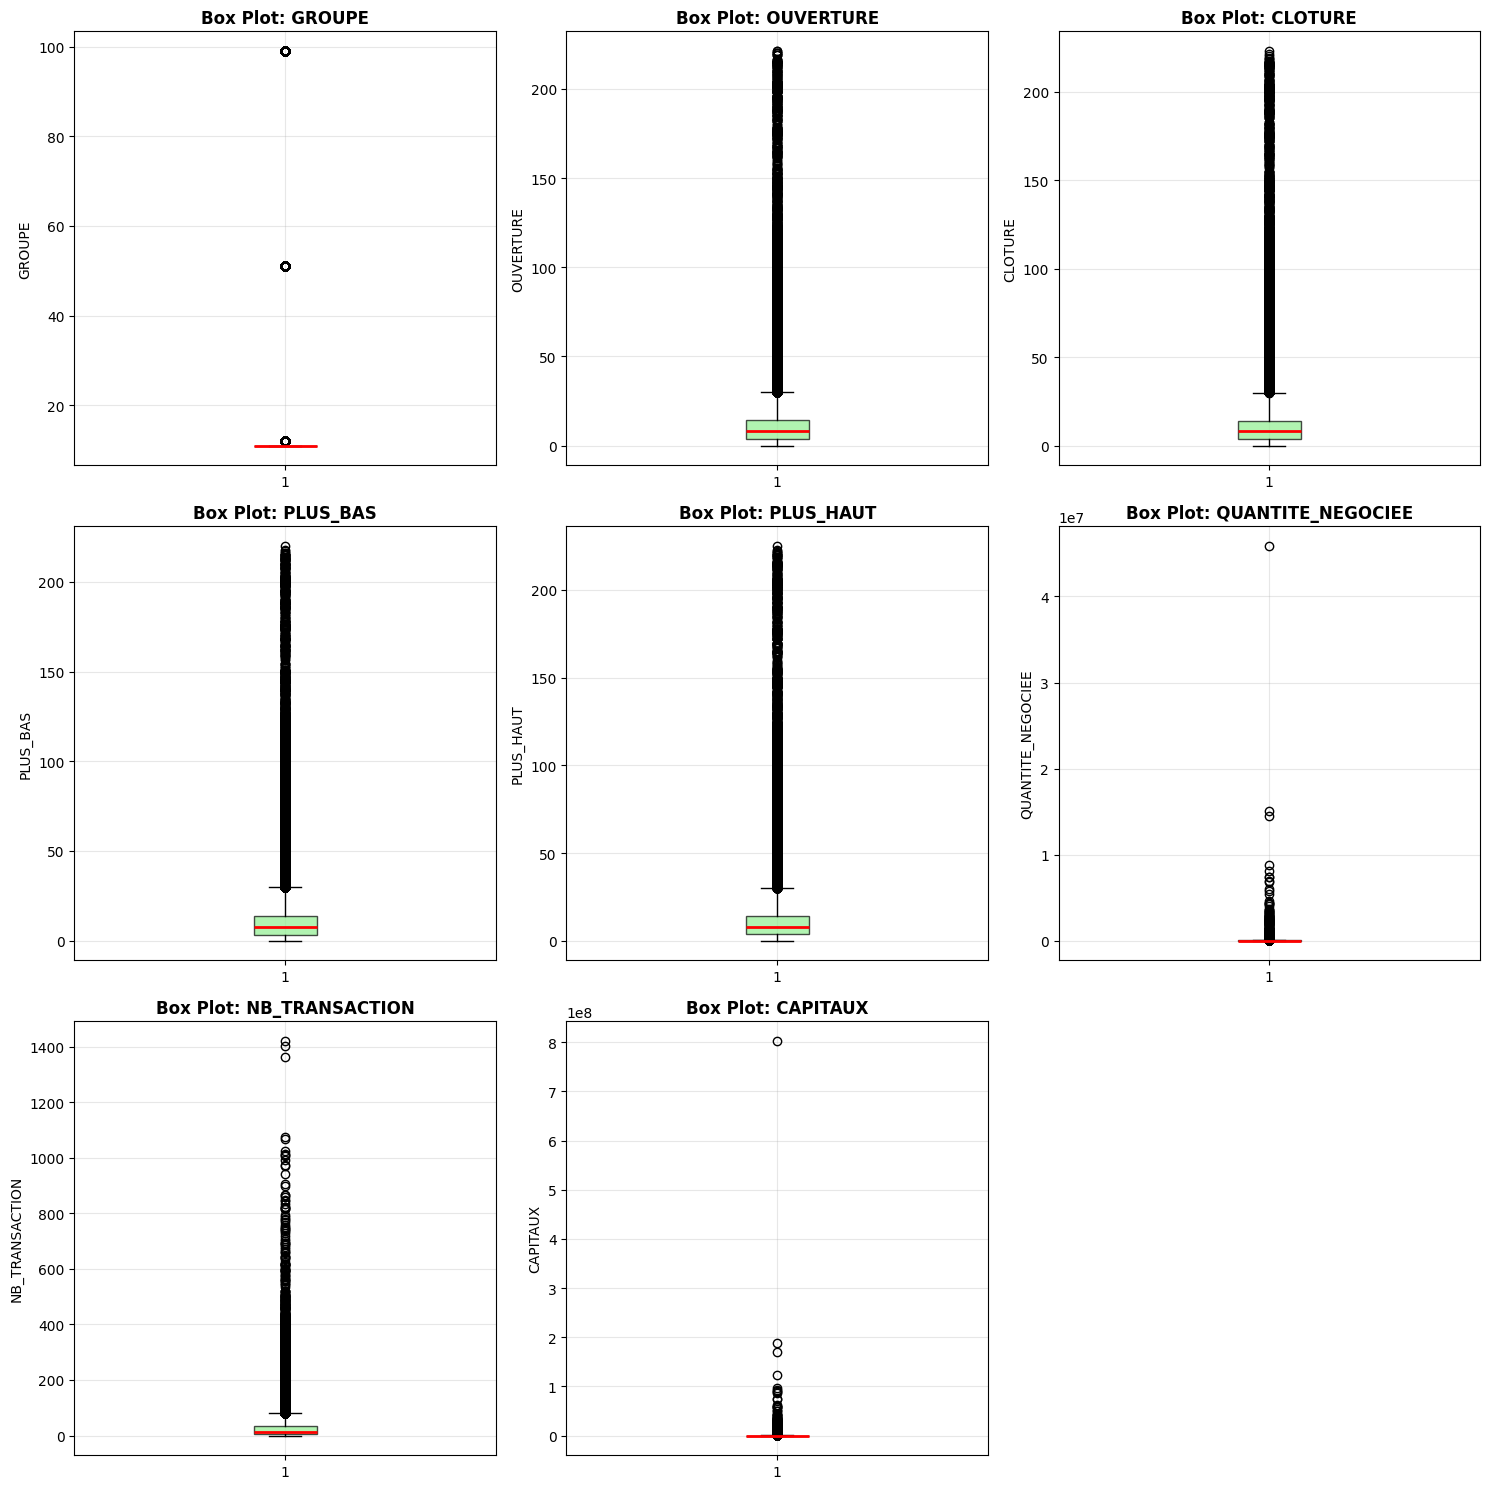


OUTLIER STATISTICS (IQR Method)

GROUPE:
  Lower bound: 11.00
  Upper bound: 11.00
  Number of outliers: 12,942 (13.46%)

OUVERTURE:
  Lower bound: -12.10
  Upper bound: 29.98
  Number of outliers: 8,107 (8.43%)

CLOTURE:
  Lower bound: -12.00
  Upper bound: 30.12
  Number of outliers: 8,201 (8.53%)

PLUS_BAS:
  Lower bound: -12.72
  Upper bound: 29.68
  Number of outliers: 8,009 (8.33%)

PLUS_HAUT:
  Lower bound: -11.98
  Upper bound: 30.23
  Number of outliers: 8,240 (8.57%)

QUANTITE_NEGOCIEE:
  Lower bound: -12710.75
  Upper bound: 22459.25
  Number of outliers: 11,745 (12.21%)

NB_TRANSACTION:
  Lower bound: -40.00
  Upper bound: 80.00
  Number of outliers: 7,666 (7.97%)

CAPITAUX:
  Lower bound: -99205.81
  Upper bound: 174544.80
  Number of outliers: 11,803 (12.27%)


In [50]:
# Box plots for outlier detection
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].boxplot(dataset[col].dropna(), vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightgreen', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2))
        axes[idx].set_title(f'Box Plot: {col}', fontweight='bold')
        axes[idx].set_ylabel(col)
        axes[idx].grid(alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate outliers using IQR method
    print("\n" + "=" * 60)
    print("OUTLIER STATISTICS (IQR Method)")
    print("=" * 60)
    
    for col in numeric_cols:
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataset[(dataset[col] < lower_bound) | (dataset[col] > upper_bound)][col]
        
        print(f"\n{col}:")
        print(f"  Lower bound: {lower_bound:.2f}")
        print(f"  Upper bound: {upper_bound:.2f}")
        print(f"  Number of outliers: {len(outliers):,} ({(len(outliers)/len(dataset))*100:.2f}%)")
else:
    print("No numeric columns to plot.")

CORRELATION MATRIX


GROUPE  OUVERTURE   CLOTURE  PLUS_BAS  PLUS_HAUT  \
GROUPE             1.000000  -0.166735 -0.168955 -0.162425  -0.168610   
OUVERTURE         -0.166735   1.000000  0.993659  0.990307   0.994709   
CLOTURE           -0.168955   0.993659  1.000000  0.985947   0.999093   
PLUS_BAS          -0.162425   0.990307  0.985947  1.000000   0.985322   
PLUS_HAUT         -0.168610   0.994709  0.999093  0.985322   1.000000   
QUANTITE_NEGOCIEE  0.018228  -0.024671 -0.025348 -0.023102  -0.025249   
NB_TRANSACTION     0.003972   0.040514  0.036400  0.050463   0.037719   
CAPITAUX          -0.008786   0.017965  0.017698  0.018744   0.017752   

                   QUANTITE_NEGOCIEE  NB_TRANSACTION  CAPITAUX  
GROUPE                      0.018228        0.003972 -0.008786  
OUVERTURE                  -0.024671        0.040514  0.017965  
CLOTURE                    -0.025348        0.036400  0.017698  
PLUS_BAS                   -0.023102        0.050463  0.018744  
PLUS_HAUT                  -0.025249        0.037719  0.017752  
QUANTITE_NEGOCIEE           1.000000        0.214229  0.876364  
NB_TRANSACTION              0.214229        1.000000  0.084175  
CAPITAUX                    0.876364        0.084175  1.000000

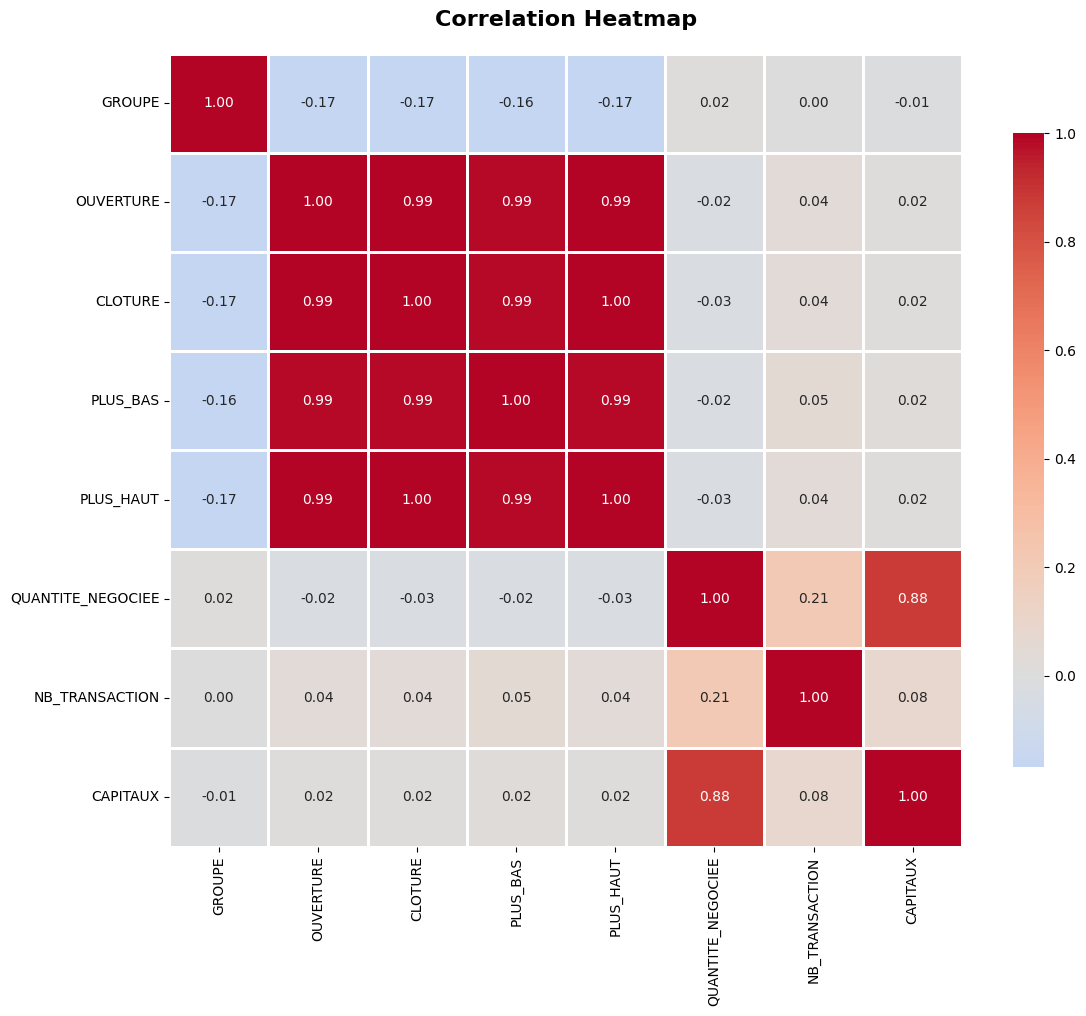


HIGHLY CORRELATED PAIRS (|correlation| > 0.7)
OUVERTURE <-> CLOTURE: 0.994
OUVERTURE <-> PLUS_BAS: 0.990
OUVERTURE <-> PLUS_HAUT: 0.995
CLOTURE <-> PLUS_BAS: 0.986
CLOTURE <-> PLUS_HAUT: 0.999
PLUS_BAS <-> PLUS_HAUT: 0.985
QUANTITE_NEGOCIEE <-> CAPITAUX: 0.876


In [51]:
# Correlation matrix for numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    correlation_matrix = dataset[numeric_cols].corr()
    
    print("=" * 60)
    print("CORRELATION MATRIX")
    print("=" * 60)
    display(correlation_matrix)
    
    # Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs
    print("\n" + "=" * 60)
    print("HIGHLY CORRELATED PAIRS (|correlation| > 0.7)")
    print("=" * 60)
    
    # Get correlation pairs
    corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                corr_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    
    if corr_pairs:
        for pair in corr_pairs:
            print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
    else:
        print("No highly correlated pairs found.")
else:
    print("Not enough numeric columns for correlation analysis.")

In [52]:
# Comprehensive data quality report
print("=" * 70)
print("COMPREHENSIVE DATA QUALITY SUMMARY")
print("=" * 70)

quality_report = pd.DataFrame({
    'Column': dataset.columns,
    'Data_Type': [dataset[col].dtype for col in dataset.columns],
    'Non_Null_Count': [dataset[col].notna().sum() for col in dataset.columns],
    'Null_Count': [dataset[col].isna().sum() for col in dataset.columns],
    'Null_Percentage': [(dataset[col].isna().sum() / len(dataset)) * 100 for col in dataset.columns],
    'Unique_Values': [dataset[col].nunique() for col in dataset.columns],
    'Cardinality': [dataset[col].nunique() / len(dataset) * 100 for col in dataset.columns]
})

print("\nData Quality Report:")
display(quality_report)

print("\n" + "=" * 70)
print("KEY INSIGHTS")
print("=" * 70)
print(f"✓ Total Rows: {len(dataset):,}")
print(f"✓ Total Columns: {len(dataset.columns)}")
print(f"✓ Total Missing Values: {dataset.isnull().sum().sum():,}")
print(f"✓ Total Duplicate Rows: {dataset.duplicated().sum():,}")
print(f"✓ Memory Usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"✓ Numeric Columns: {len(dataset.select_dtypes(include=[np.number]).columns)}")
print(f"✓ Categorical Columns: {len(dataset.select_dtypes(include=['object']).columns)}")
print(f"✓ Date Columns: {len(dataset.select_dtypes(include=['datetime64']).columns)}")

print("\n" + "=" * 70)
print("EDA COMPLETE!")
print("=" * 70)

COMPREHENSIVE DATA QUALITY SUMMARY

Data Quality Report:


Column       Data_Type  Non_Null_Count  Null_Count  \
0              SEANCE  datetime64[ns]           96159           0   
1              GROUPE           Int64           96159           0   
2                CODE  string[python]           96159           0   
3              VALEUR  string[python]           96159           0   
4           OUVERTURE         float64           96159           0   
5             CLOTURE         float64           96159           0   
6            PLUS_BAS         float64           96159           0   
7           PLUS_HAUT         float64           96159           0   
8   QUANTITE_NEGOCIEE           Int64           96159           0   
9      NB_TRANSACTION           Int64           96159           0   
10           CAPITAUX         float64           96159           0   

    Null_Percentage  Unique_Values  Cardinality  
0               0.0           2507     2.607140  
1               0.0              4     0.004160  
2               0.0             41     0.042638  
3               0.0             41     0.042638  
4               0.0           5587     5.810169  
5               0.0           5628     5.852806  
6               0.0           5517     5.737372  
7               0.0           5464     5.682255  
8               0.0          27359    28.451835  
9               0.0            551     0.573009  
10              0.0          85458    88.871556


KEY INSIGHTS
✓ Total Rows: 96,159
✓ Total Columns: 11
✓ Total Missing Values: 0
✓ Total Duplicate Rows: 0
✓ Memory Usage: 20.54 MB
✓ Numeric Columns: 8
✓ Categorical Columns: 0
✓ Date Columns: 1

EDA COMPLETE!


## Visualization

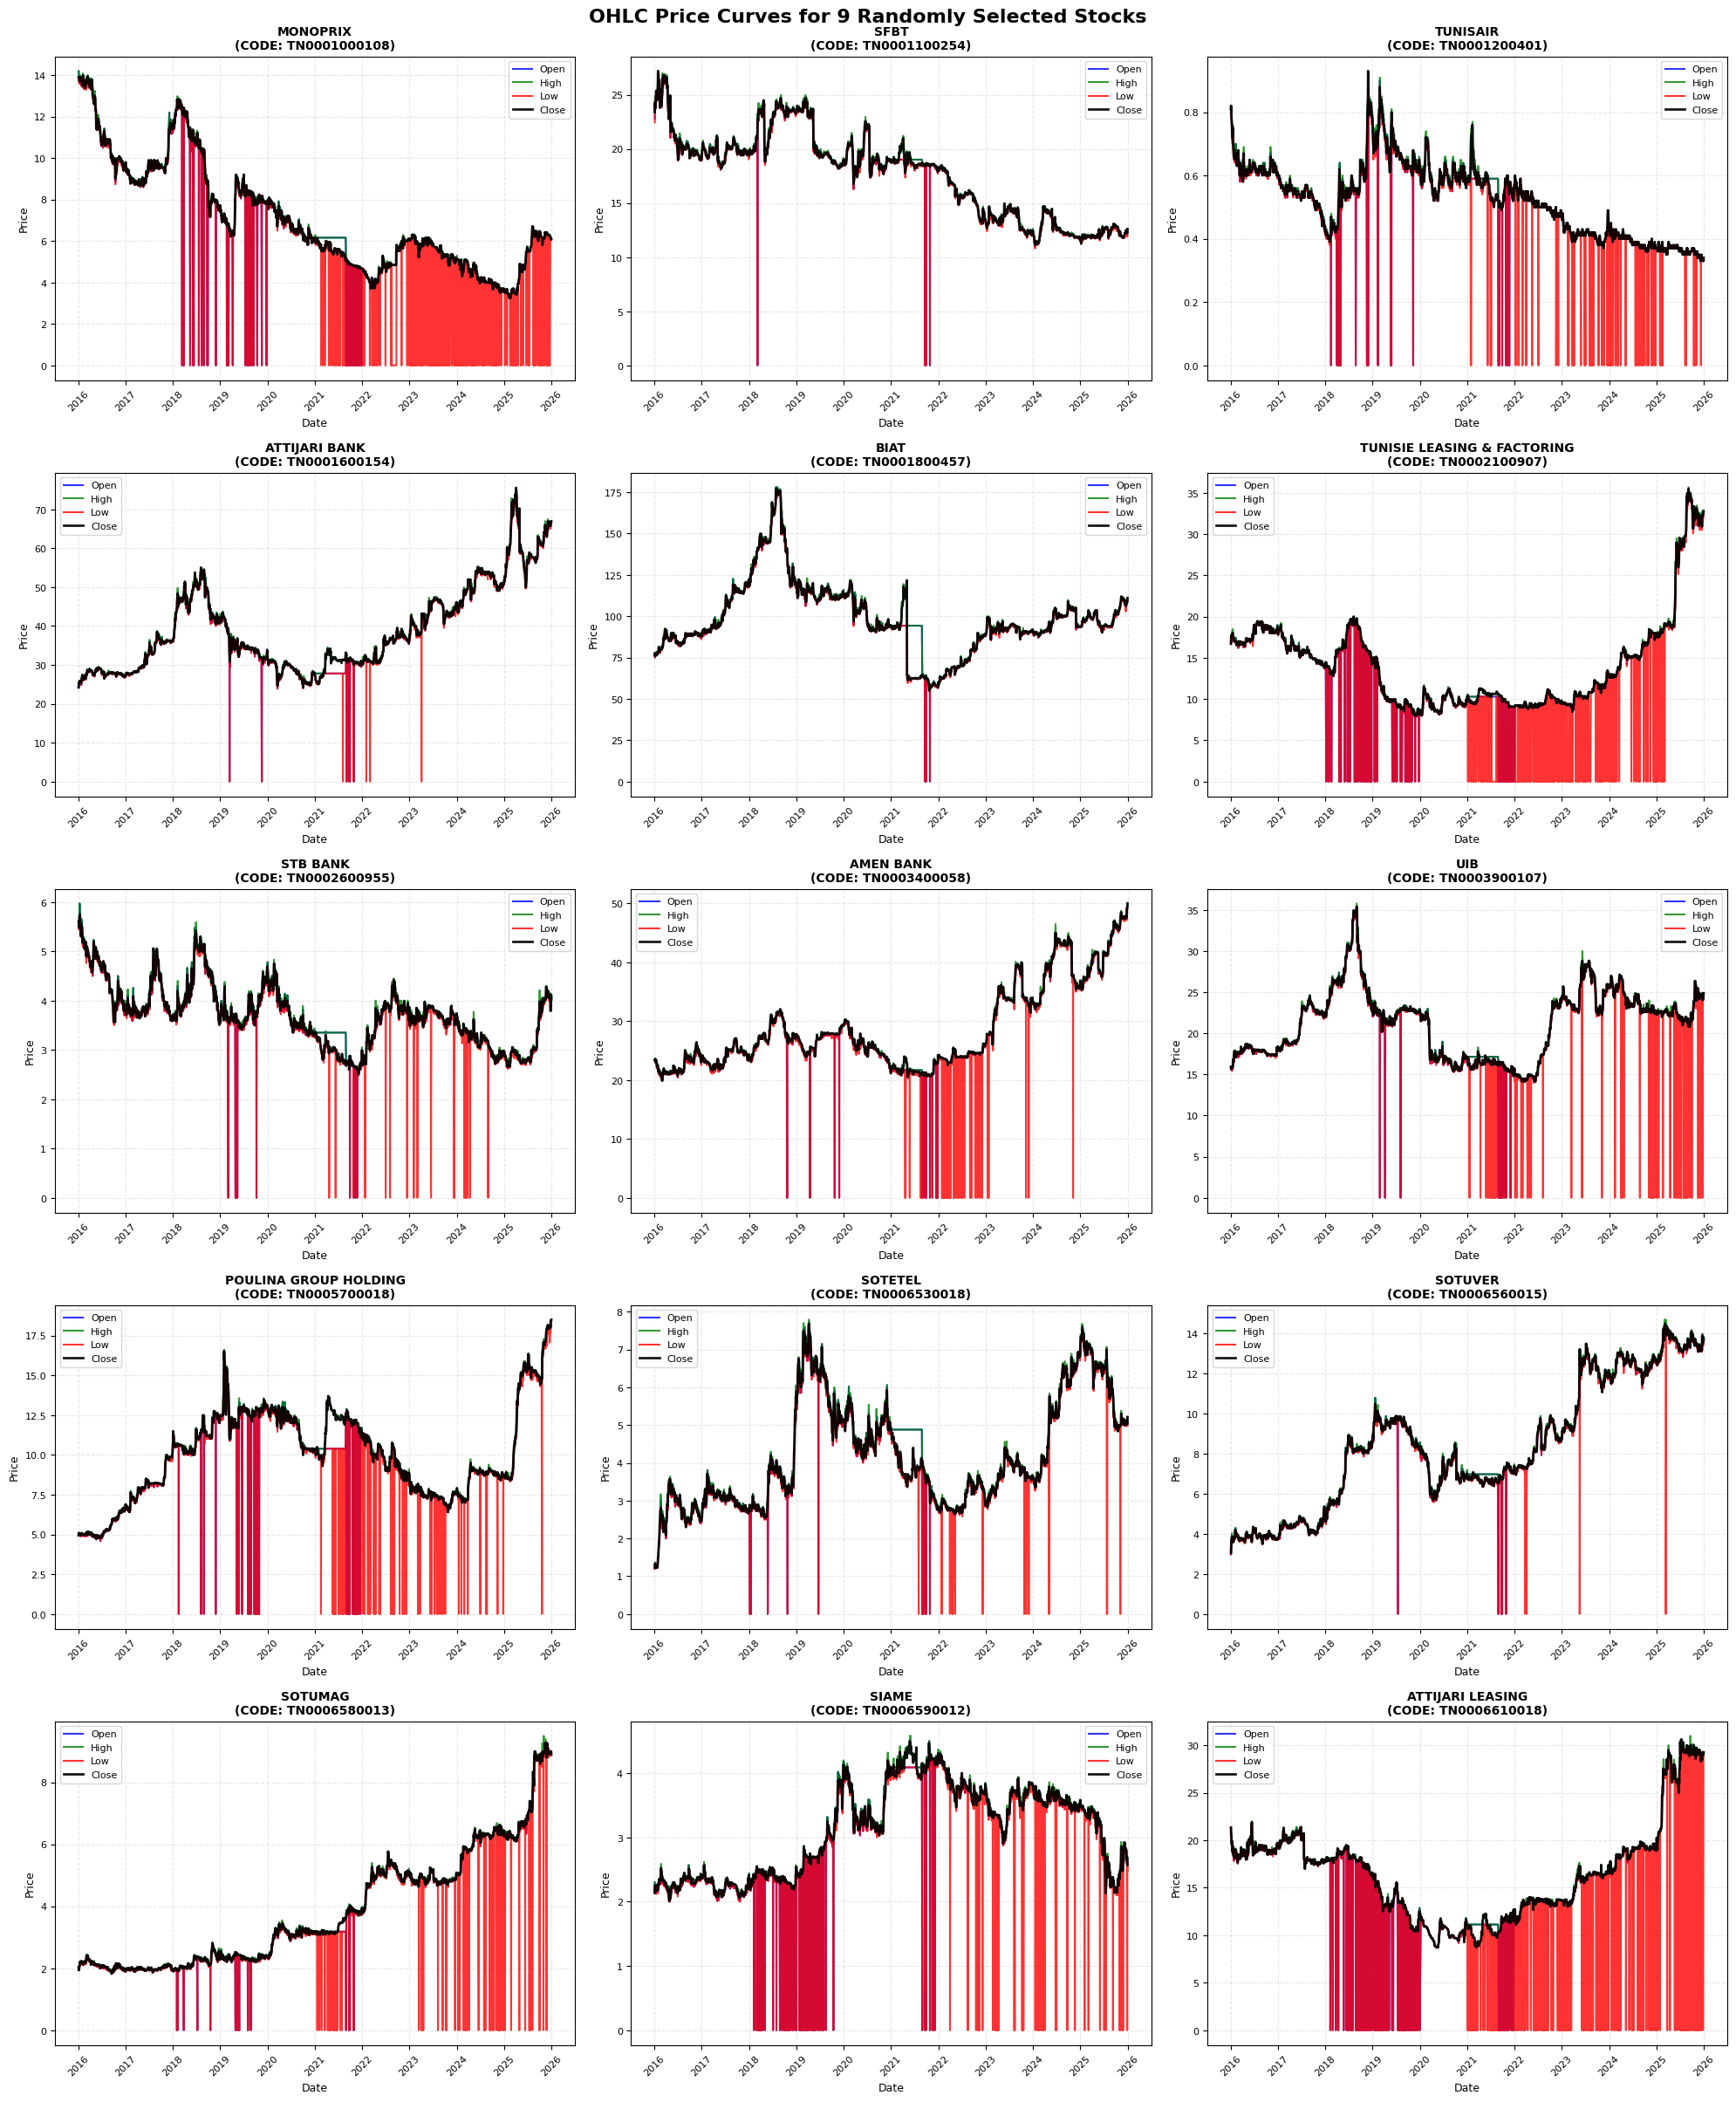

In [55]:
# Get all unique CODEs
sample_codes = dataset['CODE'].unique().tolist()[:15]

# Create 3x3 subplot grid
fig, axes = plt.subplots(5, 3, figsize=(20, 24))
axes = axes.flatten()

# Plot each stock
for idx, code in enumerate(sample_codes):
    # Filter data for this CODE
    stock_data = dataset[dataset['CODE'] == code].sort_values('SEANCE').reset_index(drop=True)
    
    # Get stock name
    valeur = stock_data['VALEUR'].iloc[0]
    
    # Plot OHLC curves
    axes[idx].plot(stock_data['SEANCE'], stock_data['OUVERTURE'], 
                   label='Open', color='blue', linewidth=1.5, alpha=0.8)
    axes[idx].plot(stock_data['SEANCE'], stock_data['PLUS_HAUT'], 
                   label='High', color='green', linewidth=1.5, alpha=0.8)
    axes[idx].plot(stock_data['SEANCE'], stock_data['PLUS_BAS'], 
                   label='Low', color='red', linewidth=1.5, alpha=0.8)
    axes[idx].plot(stock_data['SEANCE'], stock_data['CLOTURE'], 
                   label='Close', color='black', linewidth=2, alpha=0.9)
    
    # Formatting
    axes[idx].set_title(f'{valeur}\n(CODE: {code})', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=9)
    axes[idx].set_ylabel('Price', fontsize=9)
    axes[idx].legend(loc='best', fontsize=8)
    axes[idx].grid(alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.suptitle('OHLC Price Curves for 9 Randomly Selected Stocks', 
             fontsize=16, fontweight='bold', y=1.002)
plt.show()

In [56]:
# Collect detailed statistics for each stock in a DataFrame
print("\n" + "="*80)
print("DETAILED STATISTICS FOR SELECTED STOCKS")
print("="*80)

stats_list = []

for code in sample_codes:
    stock_data = dataset[dataset['CODE'] == code]
    valeur = stock_data['VALEUR'].iloc[0]
    
    stats_dict = {
        'Stock Name': valeur,
        'CODE': code,
        'Start Date': stock_data['SEANCE'].min().strftime('%Y-%m-%d'),
        'End Date': stock_data['SEANCE'].max().strftime('%Y-%m-%d'),
        'Trading Days': len(stock_data),
        'Min Price': f"{stock_data['CLOTURE'].min():.2f}",
        'Max Price': f"{stock_data['CLOTURE'].max():.2f}",
        'Mean Close': f"{stock_data['CLOTURE'].mean():.2f}",
        'Total Volume': f"{stock_data['QUANTITE_NEGOCIEE'].sum():,.0f}"
    }
    stats_list.append(stats_dict)

# Create DataFrame and display
stats_df = pd.DataFrame(stats_list)
display(stats_df)


DETAILED STATISTICS FOR SELECTED STOCKS


Stock Name          CODE  Start Date    End Date  \
0                      MONOPRIX  TN0001000108  2016-01-04  2025-12-31   
1                          SFBT  TN0001100254  2016-01-04  2025-12-31   
2                      TUNISAIR  TN0001200401  2016-01-04  2025-12-31   
3                 ATTIJARI BANK  TN0001600154  2016-01-04  2025-12-31   
4                          BIAT  TN0001800457  2016-01-04  2025-12-31   
5   TUNISIE LEASING & FACTORING  TN0002100907  2016-01-04  2025-12-31   
6                      STB BANK  TN0002600955  2016-01-04  2025-12-31   
7                     AMEN BANK  TN0003400058  2016-01-04  2025-12-31   
8                           UIB  TN0003900107  2016-01-04  2025-12-31   
9         POULINA GROUP HOLDING  TN0005700018  2016-01-04  2025-12-31   
10                      SOTETEL  TN0006530018  2016-01-04  2025-12-31   
11                      SOTUVER  TN0006560015  2016-01-04  2025-12-31   
12                      SOTUMAG  TN0006580013  2016-01-04  2025-12-31   
13                        SIAME  TN0006590012  2016-01-04  2025-12-31   
14             ATTIJARI LEASING  TN0006610018  2016-01-04  2025-12-31   

    Trading Days Min Price Max Price Mean Close Total Volume  
0           2485      3.24     14.00       7.13    8,644,634  
1           2507     11.10     27.20      17.69   99,017,972  
2           2496      0.33      0.93       0.53   66,238,984  
3           2506     24.20     75.50      38.97   19,353,657  
4           2504     55.00    177.00      98.42   10,250,541  
5           2363      7.99     35.49      14.22    7,551,875  
6           2487      2.50      5.75       3.71   36,435,190  
7           2487     19.90     50.00      28.77   17,995,943  
8           2501     14.12     35.40      21.19   24,949,464  
9           2486      4.70     18.50      10.09   47,572,424  
10          2473      1.23      7.69       4.21   23,060,751  
11          2504      3.06     14.50       8.42   48,609,436  
12          2488      1.82      9.28       3.87   25,906,420  
13          2459      2.01      4.50       3.15   27,988,083  
14          2285      8.70     30.60      16.91    1,611,837

Selected Stock: ATTIJARI LEASING (CODE: TN0006610018)
Period: 2016-01-04 to 2025-12-31
Trading Days: 2285



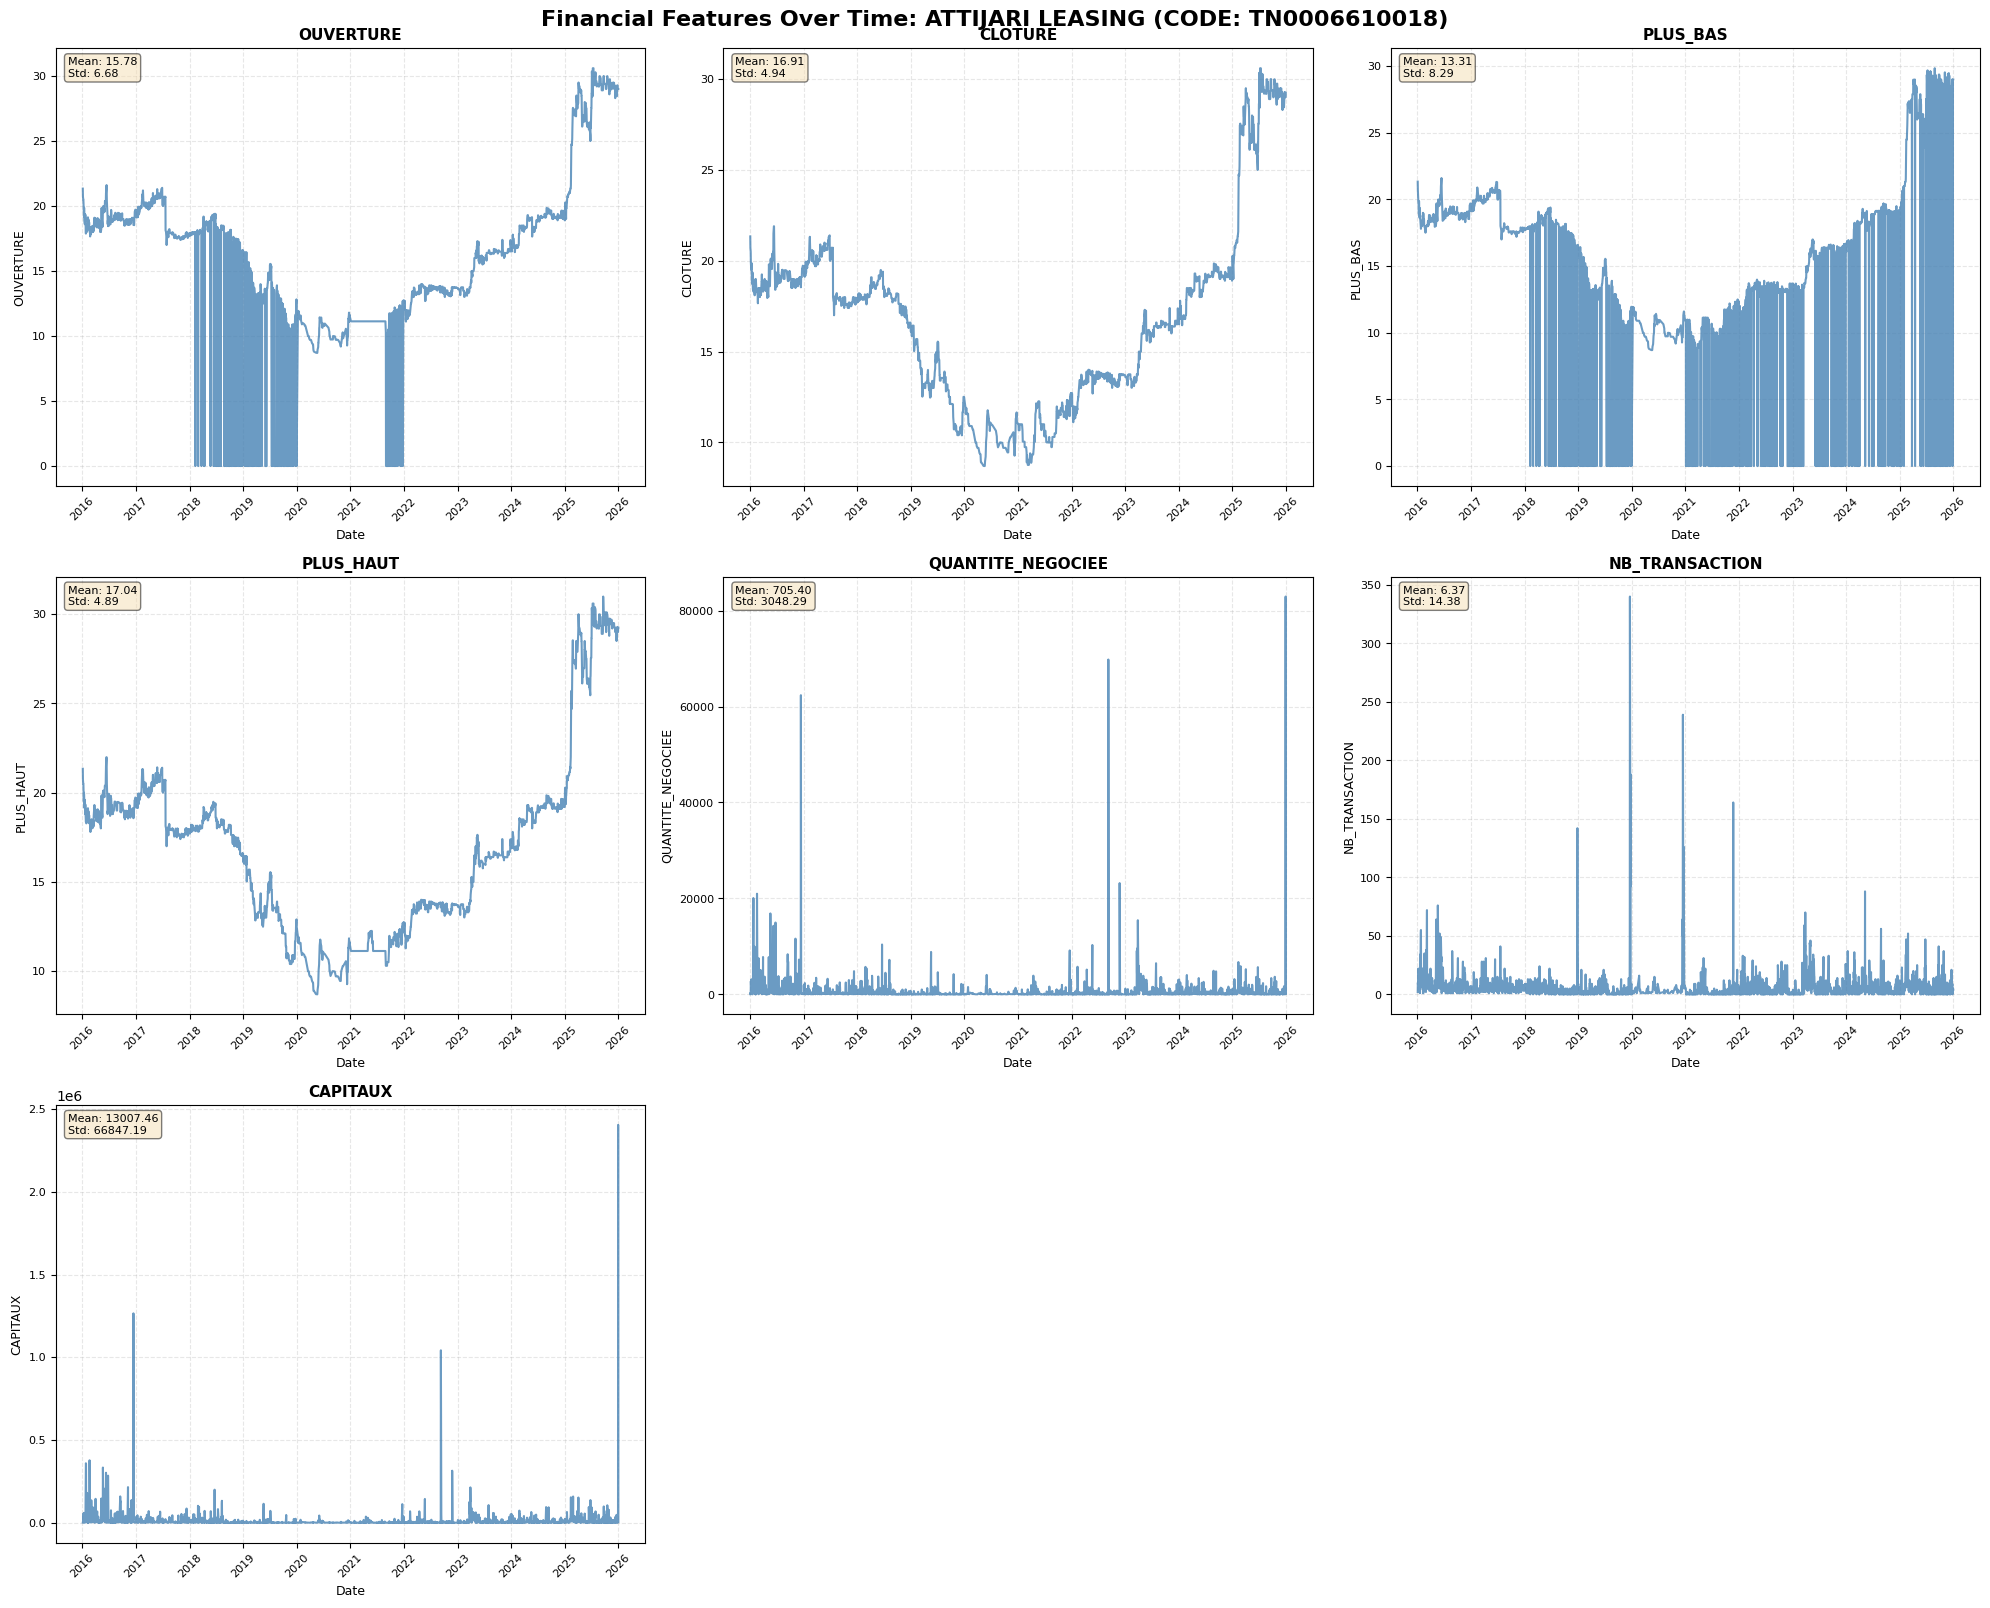

In [61]:
# Select one random CODE
random.seed(8)
selected_code = random.choice(list(dataset['CODE'].unique()))
stock_data = dataset[dataset['CODE'] == selected_code].sort_values('SEANCE').reset_index(drop=True)

valeur = stock_data['VALEUR'].iloc[0]
print(f"Selected Stock: {valeur} (CODE: {selected_code})")
print(f"Period: {stock_data['SEANCE'].min().strftime('%Y-%m-%d')} to {stock_data['SEANCE'].max().strftime('%Y-%m-%d')}")
print(f"Trading Days: {len(stock_data)}\n")

# Define all financial features to plot
financial_features = [
    # Original OHLC
    'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT',
    # Original Volume/Transaction data
    'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX',
]

# Create subplot grid (3 rows x 3 columns = 9 plots for 7 features)
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
axes = axes.flatten()

# Plot each feature
for idx, feature in enumerate(financial_features):
    axes[idx].plot(stock_data['SEANCE'], stock_data[feature], 
                   color='steelblue', linewidth=1.5, alpha=0.8)
    
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=9)
    axes[idx].set_ylabel(feature, fontsize=9)
    axes[idx].grid(alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)
    
    # Add statistics annotation
    mean_val = stock_data[feature].mean()
    std_val = stock_data[feature].std()
    stats_text = f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}'
    axes[idx].text(0.02, 0.98, stats_text, 
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hide unused subplots
for idx in range(len(financial_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle(f'Financial Features Over Time: {valeur} (CODE: {selected_code})', 
             fontsize=16, fontweight='bold', y=1.002)
plt.show()

In [127]:
# dataset.to_csv('../data/cleaned_data.csv', index=False)
dataset = pd.read_csv('../data/cleaned_data.csv', parse_dates=['SEANCE'])

## Integrated Up-To-Date 2026 Data

In [128]:
data_2026 = pd.read_csv('../data/2026_ohlc_data.csv')
data_2026['SEANCE'] = pd.to_datetime(data_2026['SEANCE'], format='%d/%m/%Y')
display(data_2026.head(3))
display(data_2026.info())
data_2026.columns

SEANCE          CODE              VALEUR  OUVERTURE  CLOTURE  PLUS_HAUT  \
0 2026-02-06  TN0005030010                STIP       0.00     0.00       0.00   
1 2026-02-06  TN0007600018            SOTEMAIL       0.00     0.00       0.00   
2 2026-02-06  TN0007650013  TAWASOL GP HOLDING       0.84     0.84       0.84   

   PLUS_BAS   CMP  NB_TRANSACTION  QUANTITE_NEGOCIEE  CAPITAUX  
0      0.00  0.00               0                  0      0.00  
1      0.00  0.00               0                  0      0.00  
2      0.84  0.84              16               7099   5963.16

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6350 entries, 0 to 6349
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SEANCE             6350 non-null   datetime64[ns]
 1   CODE               6350 non-null   object        
 2   VALEUR             6350 non-null   object        
 3   OUVERTURE          6350 non-null   float64       
 4   CLOTURE            6350 non-null   float64       
 5   PLUS_HAUT          6350 non-null   float64       
 6   PLUS_BAS           6350 non-null   float64       
 7   CMP                6350 non-null   float64       
 8   NB_TRANSACTION     6350 non-null   int64         
 9   QUANTITE_NEGOCIEE  6350 non-null   int64         
 10  CAPITAUX           6350 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 545.8+ KB


None

Index(['SEANCE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_HAUT',
       'PLUS_BAS', 'CMP', 'NB_TRANSACTION', 'QUANTITE_NEGOCIEE', 'CAPITAUX'],
      dtype='object')

In [129]:
data_2026.drop(columns=['CMP'], inplace=True)

In [130]:
print("=" * 80)
print("FINDING TICKERS IN DATASET BUT NOT IN DATA_2026")
print("=" * 80)

# Get unique VALEUR values from both datasets
dataset_valeurs = set(dataset['VALEUR'].unique())
data_2026_valeurs = set(data_2026['VALEUR'].unique())

print(f"\nUnique tickers in dataset: {len(dataset_valeurs)}")
print(f"Unique tickers in data_2026: {len(data_2026_valeurs)}")

# Find tickers that exist in dataset but NOT in data_2026
missing_tickers = dataset_valeurs - data_2026_valeurs

print(f"\n" + "=" * 80)
print(f"TICKERS IN DATASET BUT MISSING FROM DATA_2026: {len(missing_tickers)}")
print("=" * 80)

if missing_tickers:
    print("\nMissing tickers:")
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")
else:
    print("\n✓ All dataset tickers are present in data_2026!")

# Find tickers that exist in both datasets (intersection)
common_tickers = dataset_valeurs.intersection(data_2026_valeurs)
print(f"\n" + "=" * 80)
print(f"COMMON TICKERS (present in both): {len(common_tickers)}")
print("=" * 80)

# Find tickers that exist in data_2026 but NOT in dataset
extra_tickers = data_2026_valeurs - dataset_valeurs
print(f"\n" + "=" * 80)
print(f"EXTRA TICKERS (in data_2026 but not in dataset): {len(extra_tickers)}")
print("=" * 80)

if extra_tickers:
    print("\nExtra tickers in data_2026:")
    for ticker in sorted(extra_tickers):
        print(f"  - {ticker}")

FINDING TICKERS IN DATASET BUT NOT IN DATA_2026

Unique tickers in dataset: 41
Unique tickers in data_2026: 254

TICKERS IN DATASET BUT MISSING FROM DATA_2026: 5

Missing tickers:
  - ONE TECH
  - POULINA GROUP HOLDING
  - STB BANK
  - TAWASOL
  - TUNISIE LEASING & FACTORING

COMMON TICKERS (present in both): 36

EXTRA TICKERS (in data_2026 but not in dataset): 218

Extra tickers in data_2026:
  - AB DA1/24 01082016
  - AB DA1/25 300617
  - AB Da 1/10 110613
  - AB Da 1/27
  - AB Da 26 3/37
  - AB Da 29 3/40
  - AB Da 3/37 281209
  - AB Da 34 2/59
  - ABDA 1/14 11122007
  - AETECH
  - AIR LIQ Da1/4 0999
  - AIR LIQ Da1/6 0601
  - AIR LIQ Da1/8 0903
  - AIR LIQUIDE TSIE
  - AL Da 1/11 030908
  - AL Da 1/12 030909
  - ALK Da 1/10 240603
  - ALKIM Da
  - ALKIM Da 04
  - ALKIMIA
  - ALQ DA 1/12 150914
  - ALQ DA 1/25 070915
  - ALQ DA 1/28 050916
  - ALQ Da 1/11 020913
  - ALQ Da 1/11 050911
  - ALQ Da 1/11 060910
  - ALQ Da 1/12  0907
  - ALQ Da 1/15 030912
  - ALQ Da1/10 7/09/04
  - ALQ 

In [131]:
print("=" * 80)
print("CHECKING FIRST WORD MATCHES FOR MISSING TICKERS")
print("=" * 80)

missing_tickers_to_check = [
    'ONE TECH',
    'POULINA GROUP HOLDING',
    'STB BANK',
    'TAWASOL',
    'TUNISIE LEASING & FACTORING'
]

# Get all VALEUR from data_2026
data_2026_valeurs = data_2026['VALEUR'].unique()

print(f"\nChecking {len(missing_tickers_to_check)} missing tickers...\n")

for missing_ticker in missing_tickers_to_check:
    # Get first word from missing ticker
    missing_first_word = missing_ticker.split()[0]
    
    print("=" * 80)
    print(f"Missing ticker: {missing_ticker}")
    print(f"First word: '{missing_first_word}'")
    print("-" * 80)
    
    # Find matches in data_2026
    matches = []
    for data_ticker in data_2026_valeurs:
        data_first_word = data_ticker.split()[0]
        if missing_first_word == data_first_word:
            matches.append(data_ticker)
    
    if matches:
        print(f"✓ MATCHES FOUND ({len(matches)}):")
        for match in matches:
            print(f"    → {match}")
    else:
        print(f"✗ NO MATCHES: No ticker in data_2026 starts with '{missing_first_word}'")
    
    print()

print("=" * 80)
print("SUMMARY")
print("=" * 80)

# Count how many have matches
total_checked = len(missing_tickers_to_check)
tickers_with_matches = 0

for missing_ticker in missing_tickers_to_check:
    missing_first_word = missing_ticker.split()[0]
    has_match = any(ticker.split()[0] == missing_first_word for ticker in data_2026_valeurs)
    if has_match:
        tickers_with_matches += 1

print(f"\nTotal tickers checked: {total_checked}")
print(f"Tickers with first-word matches: {tickers_with_matches}")
print(f"Tickers without matches: {total_checked - tickers_with_matches}")

CHECKING FIRST WORD MATCHES FOR MISSING TICKERS

Checking 5 missing tickers...

Missing ticker: ONE TECH
First word: 'ONE'
--------------------------------------------------------------------------------
✓ MATCHES FOUND (1):
    → ONE TECH HOLDING

Missing ticker: POULINA GROUP HOLDING
First word: 'POULINA'
--------------------------------------------------------------------------------
✓ MATCHES FOUND (1):
    → POULINA GP HOLDING

Missing ticker: STB BANK
First word: 'STB'
--------------------------------------------------------------------------------
✓ MATCHES FOUND (1):
    → STB

Missing ticker: TAWASOL
First word: 'TAWASOL'
--------------------------------------------------------------------------------
✓ MATCHES FOUND (1):
    → TAWASOL GP HOLDING

Missing ticker: TUNISIE LEASING & FACTORING
First word: 'TUNISIE'
--------------------------------------------------------------------------------
✓ MATCHES FOUND (1):
    → TUNISIE LEASING F

SUMMARY

Total tickers checked: 5
Ticker

In [132]:
print("=" * 80)
print("RENAMING TICKERS IN DATA_2026 TO MATCH DATASET")
print("=" * 80)

# Create mapping dictionary for data_2026 ticker name corrections
ticker_mapping_2026 = {
    'ONE TECH HOLDING': 'ONE TECH',
    'POULINA GP HOLDING': 'POULINA GROUP HOLDING',
    'STB': 'STB BANK',
    'TAWASOL GP HOLDING': 'TAWASOL',
    'TUNISIE LEASING F': 'TUNISIE LEASING & FACTORING'
}

# Show current counts before replacement
print("\nBefore replacement:")
for old_name, new_name in ticker_mapping_2026.items():
    count = (data_2026['VALEUR'] == old_name).sum()
    if count > 0:
        print(f"  {old_name}: {count:,} rows")
    else:
        print(f"  {old_name}: NOT FOUND")

# Apply the mapping
data_2026['VALEUR'] = data_2026['VALEUR'].replace(ticker_mapping_2026)

# Show counts after replacement
print("\nAfter replacement:")
for new_name in set(ticker_mapping_2026.values()):
    count = (data_2026['VALEUR'] == new_name).sum()
    print(f"  {new_name}: {count:,} rows")

print("\n" + "=" * 80)
print("VALIDATION - CHECKING MATCHES BETWEEN DATASET AND DATA_2026")
print("=" * 80)

# Refresh valeur sets after renaming
dataset_valeurs = set(dataset['VALEUR'].unique())
data_2026_valeurs = set(data_2026['VALEUR'].unique())

# Find tickers that exist in dataset but NOT in data_2026
missing_tickers = dataset_valeurs - data_2026_valeurs

print(f"\nUnique tickers in dataset: {len(dataset_valeurs)}")
print(f"Unique tickers in data_2026: {len(data_2026_valeurs)}")
print(f"Tickers in dataset but MISSING from data_2026: {len(missing_tickers)}")

if missing_tickers:
    print("\nRemaining missing tickers:")
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")
else:
    print("\n✓ SUCCESS: All dataset tickers now exist in data_2026!")

# Find tickers in both datasets
common_tickers = dataset_valeurs.intersection(data_2026_valeurs)
print(f"\n✓ Common tickers (present in both): {len(common_tickers)}")

print("\n" + "=" * 80)
print("DATA_2026 SUMMARY AFTER RENAMING")
print("=" * 80)
print(f"Shape: {data_2026.shape}")
print(f"Rows: {data_2026.shape[0]:,}")
print(f"Unique tickers: {data_2026['VALEUR'].nunique()}")
print(f"Date range: {data_2026['SEANCE'].min().date()} to {data_2026['SEANCE'].max().date()}")

RENAMING TICKERS IN DATA_2026 TO MATCH DATASET

Before replacement:
  ONE TECH HOLDING: 25 rows
  POULINA GP HOLDING: 25 rows
  STB: 25 rows
  TAWASOL GP HOLDING: 25 rows
  TUNISIE LEASING F: 25 rows

After replacement:
  TUNISIE LEASING & FACTORING: 25 rows
  STB BANK: 25 rows
  TAWASOL: 25 rows
  ONE TECH: 25 rows
  POULINA GROUP HOLDING: 25 rows

VALIDATION - CHECKING MATCHES BETWEEN DATASET AND DATA_2026

Unique tickers in dataset: 41
Unique tickers in data_2026: 254
Tickers in dataset but MISSING from data_2026: 0

✓ SUCCESS: All dataset tickers now exist in data_2026!

✓ Common tickers (present in both): 41

DATA_2026 SUMMARY AFTER RENAMING
Shape: (6350, 10)
Rows: 6,350
Unique tickers: 254
Date range: 2026-01-02 to 2026-02-06


In [133]:
print("=" * 80)
print("FILTERING 2026 DATA AND CHECKING FOR MISSING TICKERS")
print("=" * 80)

# Get unique VALEUR values from both datasets
dataset_valeurs = set(dataset['VALEUR'].unique())
data_2026_valeurs = set(data_2026['VALEUR'].unique())

print(f"\nUnique tickers in dataset: {len(dataset_valeurs)}")
print(f"Unique tickers in data_2026: {len(data_2026_valeurs)}")

# Find tickers that exist in dataset but NOT in data_2026
missing_tickers = dataset_valeurs - data_2026_valeurs

print(f"\nTickers in dataset but MISSING from data_2026: {len(missing_tickers)}")

if missing_tickers:
    print("\n" + "=" * 80)
    print("MISSING TICKERS (present in dataset but absent in data_2026):")
    print("=" * 80)
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")
else:
    print("\n✓ All dataset tickers are present in data_2026!")

# Find tickers that exist in both datasets (intersection)
common_tickers = dataset_valeurs.intersection(data_2026_valeurs)
print(f"\n" + "=" * 80)
print(f"COMMON TICKERS: {len(common_tickers)}")
print("=" * 80)

# Filter data_2026 to keep only rows with VALEUR in dataset
original_2026_rows = len(data_2026)
data_2026_filtered = data_2026[data_2026['VALEUR'].isin(dataset_valeurs)]
filtered_2026_rows = len(data_2026_filtered)

print(f"\nOriginal data_2026 rows: {original_2026_rows:,}")
print(f"Filtered data_2026 rows: {filtered_2026_rows:,}")
print(f"Rows removed: {original_2026_rows - filtered_2026_rows:,}")
print(f"Percentage kept: {(filtered_2026_rows/original_2026_rows)*100:.2f}%")

# Verify filtering
print("\n" + "=" * 80)
print("VERIFICATION")
print("=" * 80)
print(f"Unique tickers in filtered data_2026: {data_2026_filtered['VALEUR'].nunique()}")
print(f"All filtered tickers in dataset: {data_2026_filtered['VALEUR'].isin(dataset_valeurs).all()}")

# Show sample of filtered data
print("\n" + "=" * 80)
print("SAMPLE OF FILTERED DATA_2026")
print("=" * 80)
display(data_2026_filtered.head(10))

# Replace original data_2026 with filtered version
data_2026 = data_2026_filtered.copy()

print("\n✓ data_2026 has been filtered successfully!")

FILTERING 2026 DATA AND CHECKING FOR MISSING TICKERS

Unique tickers in dataset: 41
Unique tickers in data_2026: 254

Tickers in dataset but MISSING from data_2026: 0

✓ All dataset tickers are present in data_2026!

COMMON TICKERS: 41

Original data_2026 rows: 6,350
Filtered data_2026 rows: 1,025
Rows removed: 5,325
Percentage kept: 16.14%

VERIFICATION
Unique tickers in filtered data_2026: 41
All filtered tickers in dataset: True

SAMPLE OF FILTERED DATA_2026


SEANCE          CODE                       VALEUR  OUVERTURE  CLOTURE  \
2   2026-02-06  TN0007650013                      TAWASOL       0.84     0.84   
5   2026-02-06  TN0007540016                NEW BODY LINE       3.76     3.76   
7   2026-02-06  TN0007400013              CARTHAGE CEMENT       1.86     1.93   
191 2026-02-06  TN0001400704                SPDIT - SICAF      12.96    12.80   
194 2026-02-06  TN0003200755                          ICF      77.05    77.00   
202 2026-02-06  TN0007720014                       UNIMED       9.06     9.19   
203 2026-02-06  TN0003900107                          UIB      26.57    26.60   
204 2026-02-06  TN0007690019                         UADH       0.52     0.52   
205 2026-02-06  TN0002100907  TUNISIE LEASING & FACTORING      41.00    41.50   
206 2026-02-06  TN0001200401                     TUNISAIR       0.33     0.33   

     PLUS_HAUT  PLUS_BAS  NB_TRANSACTION  QUANTITE_NEGOCIEE   CAPITAUX  
2         0.84      0.84              16               7099    5963.16  
5         3.83      3.76               5                443    1668.97  
7         1.95      1.86             277             251586  483703.69  
191      12.96     12.80               2                  6      76.96  
194      79.00     76.90              32                855   66040.48  
202       9.20      9.06              39               9922   90791.11  
203      26.60     26.57              15               1881   50010.57  
204       0.52      0.52               4               9450    4914.00  
205      41.50     41.00              32               2605  107434.25  
206       0.33      0.33               7               2588     854.04


✓ data_2026 has been filtered successfully!


In [134]:
print("=" * 80)
print("DATA_2026 QUALITY CHECKS")
print("=" * 80)

# ============================================================================
# CHECK 1: NULL/NaN VALUES
# ============================================================================
print("\n" + "=" * 80)
print("CHECK 1: NULL/NaN VALUES")
print("=" * 80)

missing_counts = data_2026.isnull().sum()
missing_percent = (data_2026.isnull().sum() / len(data_2026)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})

print("\nMissing Values Summary:")
display(missing_df)

total_missing = data_2026.isnull().sum().sum()
print(f"\nTotal missing values: {total_missing:,}")
print(f"Any missing values: {data_2026.isnull().any().any()}")

if total_missing > 0:
    print("\n⚠ WARNING: Missing values found!")
    print("\nSample rows with missing values:")
    rows_with_missing = data_2026[data_2026.isnull().any(axis=1)]
    display(rows_with_missing.head(10))
else:
    print("\n✓ SUCCESS: No missing values found!")

# ============================================================================
# CHECK 2: DUPLICATE ROWS
# ============================================================================
print("\n" + "=" * 80)
print("CHECK 2: DUPLICATE ROWS")
print("=" * 80)

# Check for exact duplicates (all columns)
total_duplicates = data_2026.duplicated().sum()
print(f"Total duplicate rows (all columns): {total_duplicates:,}")
print(f"Percentage: {(total_duplicates/len(data_2026))*100:.2f}%")

# Check for duplicates based on key columns (SEANCE, VALEUR)
key_duplicates = data_2026.duplicated(subset=['SEANCE', 'VALEUR']).sum()
print(f"\nDuplicate rows based on SEANCE + VALEUR: {key_duplicates:,}")
print(f"Percentage: {(key_duplicates/len(data_2026))*100:.2f}%")

if total_duplicates > 0:
    print("\n⚠ WARNING: Exact duplicates found!")
    print("\nSample of duplicate rows:")
    duplicates_df = data_2026[data_2026.duplicated(keep=False)].sort_values(['SEANCE', 'VALEUR'])
    display(duplicates_df.head(10))
else:
    print("\n✓ SUCCESS: No exact duplicate rows!")

if key_duplicates > 0:
    print("\n⚠ WARNING: Key duplicates (SEANCE + VALEUR) found!")
    print("\nSample of key duplicates:")
    key_dups = data_2026[data_2026.duplicated(subset=['SEANCE', 'VALEUR'], keep=False)].sort_values(['SEANCE', 'VALEUR'])
    display(key_dups.head(10))
else:
    print("\n✓ SUCCESS: No key duplicates (SEANCE + VALEUR)!")

# ============================================================================
# CHECK 3: CLOTURE = 0
# ============================================================================
print("\n" + "=" * 80)
print("CHECK 3: ROWS WITH CLOTURE = 0")
print("=" * 80)

zero_cloture_rows = (data_2026['CLOTURE'] == 0).sum()
zero_cloture_pct = (zero_cloture_rows / len(data_2026)) * 100

print(f"Rows with CLOTURE = 0: {zero_cloture_rows:,} ({zero_cloture_pct:.2f}%)")

if zero_cloture_rows > 0:
    print("\n⚠ WARNING: Rows with CLOTURE = 0 found!")
    
    # Show breakdown by ticker
    zero_by_ticker = data_2026[data_2026['CLOTURE'] == 0].groupby('VALEUR').size().reset_index(name='Zero_Count')
    zero_by_ticker = zero_by_ticker.sort_values('Zero_Count', ascending=False)
    
    print(f"\nTickers affected: {len(zero_by_ticker)}")
    print("\nTop 10 tickers with most zero CLOTURE rows:")
    display(zero_by_ticker.head(10))
    
    print("\nSample rows with CLOTURE = 0:")
    display(data_2026[data_2026['CLOTURE'] == 0][['SEANCE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_HAUT', 'PLUS_BAS']].head(10))
else:
    print("\n✓ SUCCESS: No rows with CLOTURE = 0!")

# ============================================================================
# CHECK 4: PLUS_HAUT < max(OUVERTURE, CLOTURE) OR PLUS_BAS > min(OUVERTURE, CLOTURE)
# ============================================================================
print("\n" + "=" * 80)
print("CHECK 4: INVALID PLUS_HAUT AND PLUS_BAS VALUES")
print("=" * 80)

# Calculate max(OUVERTURE, CLOTURE) and min(OUVERTURE, CLOTURE)
data_2026_temp = data_2026.copy()
data_2026_temp['max_oc'] = data_2026_temp[['OUVERTURE', 'CLOTURE']].max(axis=1)
data_2026_temp['min_oc'] = data_2026_temp[['OUVERTURE', 'CLOTURE']].min(axis=1)

# Identify invalid rows
plus_haut_invalid = data_2026_temp['PLUS_HAUT'] < data_2026_temp['max_oc']
plus_bas_invalid = data_2026_temp['PLUS_BAS'] > data_2026_temp['min_oc']

plus_haut_issues = plus_haut_invalid.sum()
plus_bas_issues = plus_bas_invalid.sum()
total_issues = (plus_haut_invalid | plus_bas_invalid).sum()

print(f"Rows with PLUS_HAUT < max(OUVERTURE, CLOTURE): {plus_haut_issues:,} ({plus_haut_issues/len(data_2026)*100:.2f}%)")
print(f"Rows with PLUS_BAS > min(OUVERTURE, CLOTURE): {plus_bas_issues:,} ({plus_bas_issues/len(data_2026)*100:.2f}%)")
print(f"Total rows with at least one issue: {total_issues:,} ({total_issues/len(data_2026)*100:.2f}%)")

if total_issues > 0:
    print("\n⚠ WARNING: Invalid PLUS_HAUT/PLUS_BAS values found!")
    
    print("\nSample rows with invalid PLUS_HAUT (PLUS_HAUT < max(OUVERTURE, CLOTURE)):")
    if plus_haut_issues > 0:
        display(data_2026_temp[plus_haut_invalid][['SEANCE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_HAUT', 'PLUS_BAS', 'max_oc', 'min_oc']].head(10))
    
    print("\nSample rows with invalid PLUS_BAS (PLUS_BAS > min(OUVERTURE, CLOTURE)):")
    if plus_bas_issues > 0:
        display(data_2026_temp[plus_bas_invalid][['SEANCE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_HAUT', 'PLUS_BAS', 'max_oc', 'min_oc']].head(10))
    
    # Breakdown by ticker
    print("\nBreakdown by ticker:")
    issue_rows = data_2026_temp[plus_haut_invalid | plus_bas_invalid]
    issues_by_ticker = issue_rows.groupby('VALEUR').size().reset_index(name='Issue_Count')
    issues_by_ticker = issues_by_ticker.sort_values('Issue_Count', ascending=False)
    print(f"Tickers affected: {len(issues_by_ticker)}")
    display(issues_by_ticker.head(10))
else:
    print("\n✓ SUCCESS: All PLUS_HAUT and PLUS_BAS values are valid!")

# ============================================================================
# COMPREHENSIVE SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("DATA_2026 QUALITY SUMMARY")
print("=" * 80)

print(f"\n✓ Dataset Shape: {data_2026.shape}")
print(f"✓ Total Rows: {len(data_2026):,}")
print(f"✓ Date Range: {data_2026['SEANCE'].min().date()} to {data_2026['SEANCE'].max().date()}")
print(f"✓ Unique Tickers: {data_2026['VALEUR'].nunique()}")

print("\nIssues Found:")
print(f"  - Missing Values: {total_missing:,} ({(total_missing/(len(data_2026)*len(data_2026.columns)))*100:.2f}% of all cells)")
print(f"  - Exact Duplicates: {total_duplicates:,} ({(total_duplicates/len(data_2026))*100:.2f}%)")
print(f"  - Key Duplicates (SEANCE+VALEUR): {key_duplicates:,} ({(key_duplicates/len(data_2026))*100:.2f}%)")
print(f"  - CLOTURE = 0: {zero_cloture_rows:,} ({zero_cloture_pct:.2f}%)")
print(f"  - Invalid PLUS_HAUT: {plus_haut_issues:,} ({plus_haut_issues/len(data_2026)*100:.2f}%)")
print(f"  - Invalid PLUS_BAS: {plus_bas_issues:,} ({plus_bas_issues/len(data_2026)*100:.2f}%)")
print(f"  - Total Validation Issues: {total_issues:,} ({total_issues/len(data_2026)*100:.2f}%)")

total_all_issues = total_missing + total_duplicates + zero_cloture_rows + total_issues

if total_all_issues == 0:
    print("\n" + "🎉" * 40)
    print("✓ PERFECT! DATA_2026 HAS NO QUALITY ISSUES!")
    print("🎉" * 40)
else:
    print(f"\n⚠ Total rows with any issue: ~{total_all_issues:,}")
    print("⚠ Data cleaning/correction recommended before use!")

DATA_2026 QUALITY CHECKS

CHECK 1: NULL/NaN VALUES

Missing Values Summary:


Column  Missing_Count  Missing_Percent
0             SEANCE              0              0.0
1               CODE              0              0.0
2             VALEUR              0              0.0
3          OUVERTURE              0              0.0
4            CLOTURE              0              0.0
5          PLUS_HAUT              0              0.0
6           PLUS_BAS              0              0.0
7     NB_TRANSACTION              0              0.0
8  QUANTITE_NEGOCIEE              0              0.0
9           CAPITAUX              0              0.0


Total missing values: 0
Any missing values: False

✓ SUCCESS: No missing values found!

CHECK 2: DUPLICATE ROWS
Total duplicate rows (all columns): 0
Percentage: 0.00%

Duplicate rows based on SEANCE + VALEUR: 0
Percentage: 0.00%

✓ SUCCESS: No exact duplicate rows!

✓ SUCCESS: No key duplicates (SEANCE + VALEUR)!

CHECK 3: ROWS WITH CLOTURE = 0
Rows with CLOTURE = 0: 38 (3.71%)

⚠ WARNING: Rows with CLOTURE = 0 found!

Tickers affected: 13

Top 10 tickers with most zero CLOTURE rows:


VALEUR  Zero_Count
6            SOMOCER           7
11              UADH           6
0              ASSAD           6
9            TAWASOL           5
1   ATTIJARI LEASING           3
3           MONOPRIX           3
8      SPDIT - SICAF           2
4               MPBS           1
2            BH BANK           1
7            SOTETEL           1


Sample rows with CLOTURE = 0:


SEANCE            VALEUR  OUVERTURE  CLOTURE  PLUS_HAUT  PLUS_BAS
460  2026-02-05          TUNISAIR        0.0      0.0        0.0       0.0
472  2026-02-05           SOMOCER        0.0      0.0        0.0       0.0
726  2026-02-04           SOMOCER        0.0      0.0        0.0       0.0
767  2026-02-03     NEW BODY LINE        0.0      0.0        0.0       0.0
966  2026-02-03              UADH        0.0      0.0        0.0       0.0
980  2026-02-03           SOMOCER        0.0      0.0        0.0       0.0
1006 2026-02-03  ATTIJARI LEASING        0.0      0.0        0.0       0.0
1207 2026-02-02     SPDIT - SICAF        0.0      0.0        0.0       0.0
1234 2026-02-02           SOMOCER        0.0      0.0        0.0       0.0
1498 2026-01-30          MONOPRIX        0.0      0.0        0.0       0.0


CHECK 4: INVALID PLUS_HAUT AND PLUS_BAS VALUES
Rows with PLUS_HAUT < max(OUVERTURE, CLOTURE): 0 (0.00%)
Rows with PLUS_BAS > min(OUVERTURE, CLOTURE): 0 (0.00%)
Total rows with at least one issue: 0 (0.00%)

✓ SUCCESS: All PLUS_HAUT and PLUS_BAS values are valid!

DATA_2026 QUALITY SUMMARY

✓ Dataset Shape: (1025, 10)
✓ Total Rows: 1,025
✓ Date Range: 2026-01-02 to 2026-02-06
✓ Unique Tickers: 41

Issues Found:
  - Missing Values: 0 (0.00% of all cells)
  - Exact Duplicates: 0 (0.00%)
  - Key Duplicates (SEANCE+VALEUR): 0 (0.00%)
  - CLOTURE = 0: 38 (3.71%)
  - Invalid PLUS_HAUT: 0 (0.00%)
  - Invalid PLUS_BAS: 0 (0.00%)
  - Total Validation Issues: 0 (0.00%)

⚠ Total rows with any issue: ~38
⚠ Data cleaning/correction recommended before use!


In [135]:
print("=" * 80)
print("DROPPING ROWS WITH CLOTURE = 0 FROM DATA_2026")
print("=" * 80)

# Store original shape
original_shape = data_2026.shape
print(f"\nOriginal data_2026 shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique tickers: {data_2026['VALEUR'].nunique()}")

# Count rows with CLOTURE = 0
zero_cloture_rows = (data_2026['CLOTURE'] == 0).sum()
zero_cloture_pct = (zero_cloture_rows / len(data_2026)) * 100

print(f"\nRows with CLOTURE = 0: {zero_cloture_rows:,} ({zero_cloture_pct:.2f}%)")

# Show breakdown by ticker before removal
if zero_cloture_rows > 0:
    print("\n" + "=" * 80)
    print("ZERO CLOTURE BREAKDOWN BY TICKER")
    print("=" * 80)
    
    zero_by_ticker = data_2026[data_2026['CLOTURE'] == 0].groupby('VALEUR').size().reset_index(name='Zero_Count')
    zero_by_ticker = zero_by_ticker.sort_values('Zero_Count', ascending=False)
    
    print(f"\nTickers affected: {len(zero_by_ticker)}")
    print("\nTop 10 tickers with most zero CLOTURE rows:")
    display(zero_by_ticker.head(10))

# Filter out rows where CLOTURE = 0
data_2026 = data_2026[data_2026['CLOTURE'] > 0]

# New shape after filtering
new_shape = data_2026.shape
rows_removed = original_shape[0] - new_shape[0]

print("\n" + "=" * 80)
print("REMOVAL SUMMARY")
print("=" * 80)
print(f"\nFiltered data_2026 shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nRemaining unique tickers: {data_2026['VALEUR'].nunique()}")

# Verify removal
remaining_zero_cloture = (data_2026['CLOTURE'] == 0).sum()
if remaining_zero_cloture == 0:
    print("\n✓ SUCCESS: All rows with CLOTURE = 0 have been removed!")
else:
    print(f"\n⚠ WARNING: {remaining_zero_cloture} rows with CLOTURE = 0 still remain")

print("\n" + "=" * 80)
print("FINAL DATA_2026 SUMMARY")
print("=" * 80)
print(f"Shape: {data_2026.shape}")
print(f"Rows: {data_2026.shape[0]:,}")
print(f"Unique tickers: {data_2026['VALEUR'].nunique()}")
print(f"Date range: {data_2026['SEANCE'].min().date()} to {data_2026['SEANCE'].max().date()}")
print(f"Memory usage: {data_2026.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Update statistics
print("\n" + "=" * 80)
print("CLOTURE STATISTICS AFTER CLEANUP")
print("=" * 80)
print(f"Min CLOTURE: {data_2026['CLOTURE'].min():.2f}")
print(f"Max CLOTURE: {data_2026['CLOTURE'].max():.2f}")
print(f"Mean CLOTURE: {data_2026['CLOTURE'].mean():.2f}")
print(f"Median CLOTURE: {data_2026['CLOTURE'].median():.2f}")

DROPPING ROWS WITH CLOTURE = 0 FROM DATA_2026

Original data_2026 shape: (1025, 10)
Original number of rows: 1,025
Original unique tickers: 41

Rows with CLOTURE = 0: 38 (3.71%)

ZERO CLOTURE BREAKDOWN BY TICKER

Tickers affected: 13

Top 10 tickers with most zero CLOTURE rows:


VALEUR  Zero_Count
6            SOMOCER           7
11              UADH           6
0              ASSAD           6
9            TAWASOL           5
1   ATTIJARI LEASING           3
3           MONOPRIX           3
8      SPDIT - SICAF           2
4               MPBS           1
2            BH BANK           1
7            SOTETEL           1


REMOVAL SUMMARY

Filtered data_2026 shape: (987, 10)
New number of rows: 987
Rows removed: 38
Percentage of data removed: 3.71%

Remaining unique tickers: 41

✓ SUCCESS: All rows with CLOTURE = 0 have been removed!

FINAL DATA_2026 SUMMARY
Shape: (987, 10)
Rows: 987
Unique tickers: 41
Date range: 2026-01-02 to 2026-02-06
Memory usage: 0.18 MB

CLOTURE STATISTICS AFTER CLEANUP
Min CLOTURE: 0.33
Max CLOTURE: 134.00
Mean CLOTURE: 19.17
Median CLOTURE: 12.10


In [136]:
print("=" * 80)
print("CONCATENATING DATA_2026 TO DATASET")
print("=" * 80)

# Store original shapes
original_dataset_shape = dataset.shape
original_2026_shape = data_2026.shape

print(f"\nOriginal dataset shape: {original_dataset_shape}")
print(f"Original dataset rows: {original_dataset_shape[0]:,}")
print(f"Original dataset date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")

print(f"\nData_2026 shape: {original_2026_shape}")
print(f"Data_2026 rows: {original_2026_shape[0]:,}")
print(f"Data_2026 date range: {data_2026['SEANCE'].min().date()} to {data_2026['SEANCE'].max().date()}")

# Check column alignment
print("\n" + "=" * 80)
print("COLUMN ALIGNMENT CHECK")
print("=" * 80)

dataset_cols = set(dataset.columns)
data_2026_cols = set(data_2026.columns)

common_cols = dataset_cols.intersection(data_2026_cols)
dataset_only = dataset_cols - data_2026_cols
data_2026_only = data_2026_cols - dataset_cols

print(f"\nCommon columns: {len(common_cols)}")
print(f"Columns only in dataset: {len(dataset_only)}")
print(f"Columns only in data_2026: {len(data_2026_only)}")

if dataset_only:
    print(f"\n⚠ Columns only in dataset: {sorted(dataset_only)}")
if data_2026_only:
    print(f"\n⚠ Columns only in data_2026: {sorted(data_2026_only)}")

# Concatenate
print("\n" + "=" * 80)
print("PERFORMING CONCATENATION")
print("=" * 80)

dataset = pd.concat([dataset, data_2026], ignore_index=True)

# Sort by CODE and SEANCE
dataset = dataset.sort_values(['CODE', 'SEANCE']).reset_index(drop=True)

print(f"\n✓ Concatenation complete!")

# New shape after concatenation
new_shape = dataset.shape
total_rows_added = new_shape[0] - original_dataset_shape[0]

print("\n" + "=" * 80)
print("CONCATENATION SUMMARY")
print("=" * 80)
print(f"\nNew dataset shape: {new_shape}")
print(f"New dataset rows: {new_shape[0]:,}")
print(f"Total rows added: {total_rows_added:,}")
print(f"Expected rows added: {original_2026_shape[0]:,}")

if total_rows_added == original_2026_shape[0]:
    print("\n✓ SUCCESS: All data_2026 rows were added!")
else:
    print(f"\n⚠ WARNING: Row count mismatch! Difference: {abs(total_rows_added - original_2026_shape[0]):,}")

print(f"\nNew date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Unique CODEs: {dataset['CODE'].nunique()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verify no duplicates created
print("\n" + "=" * 80)
print("DUPLICATE CHECK AFTER CONCATENATION")
print("=" * 80)

duplicates = dataset.duplicated(subset=['SEANCE', 'CODE']).sum()
print(f"Duplicate rows (SEANCE + CODE): {duplicates:,}")

if duplicates > 0:
    print(f"\n⚠ WARNING: {duplicates} duplicate rows found after concatenation!")
    print("\nSample duplicates:")
    dup_rows = dataset[dataset.duplicated(subset=['SEANCE', 'CODE'], keep=False)].sort_values(['CODE', 'SEANCE'])
    display(dup_rows.head(10))
else:
    print("\n✓ SUCCESS: No duplicates created!")

print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Columns: {dataset.shape[1]}")
print(f"Date Range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")
print(f"Unique Tickers: {dataset['VALEUR'].nunique()}")
print(f"Memory: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

CONCATENATING DATA_2026 TO DATASET

Original dataset shape: (96159, 11)
Original dataset rows: 96,159
Original dataset date range: 2016-01-04 to 2025-12-31

Data_2026 shape: (987, 10)
Data_2026 rows: 987
Data_2026 date range: 2026-01-02 to 2026-02-06

COLUMN ALIGNMENT CHECK

Common columns: 10
Columns only in dataset: 1
Columns only in data_2026: 0

⚠ Columns only in dataset: ['GROUPE']

PERFORMING CONCATENATION

✓ Concatenation complete!

CONCATENATION SUMMARY

New dataset shape: (97146, 11)
New dataset rows: 97,146
Total rows added: 987
Expected rows added: 987

✓ SUCCESS: All data_2026 rows were added!

New date range: 2016-01-04 to 2026-02-06
Unique tickers: 41
Unique CODEs: 41
Memory usage: 17.69 MB

DUPLICATE CHECK AFTER CONCATENATION
Duplicate rows (SEANCE + CODE): 0

✓ SUCCESS: No duplicates created!

FINAL DATASET SUMMARY
Shape: (97146, 11)
Rows: 97,146
Columns: 11
Date Range: 2016-01-04 to 2026-02-06
Unique Tickers: 41
Memory: 17.69 MB


In [137]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97146 entries, 0 to 97145
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SEANCE             97146 non-null  datetime64[ns]
 1   GROUPE             96159 non-null  float64       
 2   CODE               97146 non-null  object        
 3   VALEUR             97146 non-null  object        
 4   OUVERTURE          97146 non-null  float64       
 5   CLOTURE            97146 non-null  float64       
 6   PLUS_BAS           97146 non-null  float64       
 7   PLUS_HAUT          97146 non-null  float64       
 8   QUANTITE_NEGOCIEE  97146 non-null  int64         
 9   NB_TRANSACTION     97146 non-null  int64         
 10  CAPITAUX           97146 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 8.2+ MB


In [138]:
print("=" * 80)
print("FILLING MISSING GROUPE VALUES FOR 2026 DATA")
print("=" * 80)

# Check missing GROUPE values
missing_group = dataset['GROUPE'].isnull().sum()
missing_group_pct = (missing_group / len(dataset)) * 100

print(f"\nRows with missing GROUPE: {missing_group:,} ({missing_group_pct:.2f}%)")

if missing_group > 0:
    print(f"\n⚠ Missing GROUPE values detected!")
    
    # Identify which rows have missing GROUPE (should be 2026 data)
    missing_group_rows = dataset[dataset['GROUPE'].isnull()]
    print(f"\nDate range of missing GROUPE rows: {missing_group_rows['SEANCE'].min().date()} to {missing_group_rows['SEANCE'].max().date()}")
    print(f"Unique tickers with missing GROUPE: {missing_group_rows['VALEUR'].nunique()}")
    
    print("\n" + "=" * 80)
    print("CREATING TICKER TO GROUPE MAPPING")
    print("=" * 80)
    
    # Create a mapping from VALEUR (ticker) to GROUPE using non-null GROUPE values
    ticker_to_groupe = dataset[dataset['GROUPE'].notna()].groupby('VALEUR')['GROUPE'].first().to_dict()
    
    print(f"\nTotal unique ticker-to-groupe mappings: {len(ticker_to_groupe)}")
    print("\nSample mappings:")
    sample_tickers = list(ticker_to_groupe.items())[:10]
    for ticker, groupe in sample_tickers:
        print(f"  {ticker} → {groupe}")
    
    # Check if all tickers with missing GROUPE have a mapping
    missing_tickers = missing_group_rows['VALEUR'].unique()
    tickers_without_mapping = [t for t in missing_tickers if t not in ticker_to_groupe]
    
    print(f"\nTickers with missing GROUPE: {len(missing_tickers)}")
    print(f"Tickers without mapping: {len(tickers_without_mapping)}")
    
    if tickers_without_mapping:
        print(f"\n⚠ WARNING: {len(tickers_without_mapping)} tickers have no GROUPE mapping!")
        print(f"These tickers: {tickers_without_mapping[:20]}")
    
    print("\n" + "=" * 80)
    print("FILLING MISSING GROUPE VALUES")
    print("=" * 80)
    
    # Fill missing GROUPE values using the mapping
    rows_before = dataset['GROUPE'].isnull().sum()
    
    # Use map to fill missing values
    dataset.loc[dataset['GROUPE'].isnull(), 'GROUPE'] = dataset.loc[dataset['GROUPE'].isnull(), 'VALEUR'].map(ticker_to_groupe)
    
    rows_after = dataset['GROUPE'].isnull().sum()
    rows_filled = rows_before - rows_after
    
    print(f"\nRows with missing GROUPE before: {rows_before:,}")
    print(f"Rows with missing GROUPE after: {rows_after:,}")
    print(f"Rows filled: {rows_filled:,}")
    print(f"Fill success rate: {(rows_filled/rows_before)*100:.2f}%")
    
    if rows_after > 0:
        print(f"\n⚠ WARNING: {rows_after:,} rows still have missing GROUPE!")
        remaining_missing = dataset[dataset['GROUPE'].isnull()]
        print(f"\nRemaining tickers with missing GROUPE:")
        print(remaining_missing['VALEUR'].value_counts())
    else:
        print("\n✓ SUCCESS: All missing GROUPE values have been filled!")
    
    print("\n" + "=" * 80)
    print("VERIFICATION")
    print("=" * 80)
    
    # Verify that each ticker still maps to only one GROUPE
    ticker_group_counts = dataset.groupby('VALEUR')['GROUPE'].nunique()
    multi_group_tickers = ticker_group_counts[ticker_group_counts > 1]
    
    print(f"\nTotal tickers: {len(ticker_group_counts)}")
    print(f"Tickers mapped to multiple GROUPEs: {len(multi_group_tickers)}")
    
    if len(multi_group_tickers) > 0:
        print(f"\n⚠ WARNING: {len(multi_group_tickers)} tickers are mapped to multiple GROUPEs!")
        print("\nTickers with multiple GROUPEs (showing first 10):")
        for ticker in multi_group_tickers.head(10).index:
            groupes = dataset[dataset['VALEUR'] == ticker]['GROUPE'].unique()
            print(f"  {ticker}: {list(groupes)}")
    else:
        print("\n✓ SUCCESS: Each ticker consistently maps to one GROUPE!")
    
    # Summary by GROUPE
    print("\n" + "=" * 80)
    print("GROUPE DISTRIBUTION")
    print("=" * 80)
    
    group_summary = dataset.groupby('GROUPE').agg({
        'VALEUR': 'nunique',
        'SEANCE': 'count'
    }).rename(columns={'VALEUR': 'Unique_Tickers', 'SEANCE': 'Total_Rows'})
    
    group_summary = group_summary.sort_values('Total_Rows', ascending=False)
    
    print("\nRows and tickers per GROUPE:")
    display(group_summary)

else:
    print("\n✓ SUCCESS: No missing GROUPE values found!")

print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Missing GROUPE: {dataset['GROUPE'].isnull().sum()}")
print(f"Unique GROUPEs: {dataset['GROUPE'].nunique()}")
print(f"Unique Tickers: {dataset['VALEUR'].nunique()}")
print(f"Date Range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")

FILLING MISSING GROUPE VALUES FOR 2026 DATA

Rows with missing GROUPE: 987 (1.02%)

⚠ Missing GROUPE values detected!

Date range of missing GROUPE rows: 2026-01-02 to 2026-02-06
Unique tickers with missing GROUPE: 41

CREATING TICKER TO GROUPE MAPPING

Total unique ticker-to-groupe mappings: 41

Sample mappings:
  AMEN BANK → 11.0
  ARTES → 11.0
  ASSAD → 11.0
  ATTIJARI BANK → 11.0
  ATTIJARI LEASING → 11.0
  BH BANK → 11.0
  BIAT → 11.0
  CARTHAGE CEMENT → 51.0
  CITY CARS → 11.0
  DELICE HOLDING → 11.0

Tickers with missing GROUPE: 41
Tickers without mapping: 0

FILLING MISSING GROUPE VALUES

Rows with missing GROUPE before: 987
Rows with missing GROUPE after: 0
Rows filled: 987
Fill success rate: 100.00%

✓ SUCCESS: All missing GROUPE values have been filled!

VERIFICATION

Total tickers: 41
Tickers mapped to multiple GROUPEs: 13

⚠ WARNING: 13 tickers are mapped to multiple GROUPEs!

Tickers with multiple GROUPEs (showing first 10):
  ASSAD: [np.float64(11.0), np.float64(99.0)]
 

Unique_Tickers  Total_Rows
GROUPE                            
11.0                41       84087
12.0                 6        5027
99.0                 5        4392
51.0                 3        3640


FINAL DATASET SUMMARY
Shape: (97146, 11)
Rows: 97,146
Missing GROUPE: 0
Unique GROUPEs: 4
Unique Tickers: 41
Date Range: 2016-01-04 to 2026-02-06


In [139]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97146 entries, 0 to 97145
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SEANCE             97146 non-null  datetime64[ns]
 1   GROUPE             97146 non-null  float64       
 2   CODE               97146 non-null  object        
 3   VALEUR             97146 non-null  object        
 4   OUVERTURE          97146 non-null  float64       
 5   CLOTURE            97146 non-null  float64       
 6   PLUS_BAS           97146 non-null  float64       
 7   PLUS_HAUT          97146 non-null  float64       
 8   QUANTITE_NEGOCIEE  97146 non-null  int64         
 9   NB_TRANSACTION     97146 non-null  int64         
 10  CAPITAUX           97146 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 8.2+ MB


In [167]:
# dataset.to_csv('../data/up_to_date_data.csv', index=False)
dataset = pd.read_csv('../data/up_to_date_data.csv', parse_dates=['SEANCE'])

## Feature Engineering - Financial Domain Features

In [168]:
print("=" * 80)
print("FEATURE ENGINEERING - FINANCIAL DOMAIN FEATURES")
print("=" * 80)

# Sort by CODE and SEANCE to ensure proper ordering
dataset = dataset.sort_values(['CODE', 'SEANCE']).reset_index(drop=True)

# Define function to compute financial features per CODE group
def compute_financial_features(group):
    """Compute financial features for each CODE group independently"""
    
    # 1. Intraday Volatility (Price Range as % of Close)
    group['Intraday_Range_Pct'] = 0.0
    valid_mask = group['CLOTURE'] > 0
    group.loc[valid_mask, 'Intraday_Range_Pct'] = (
        (group.loc[valid_mask, 'PLUS_HAUT'] - group.loc[valid_mask, 'PLUS_BAS']) / 
        group.loc[valid_mask, 'CLOTURE']
    ) * 100
    
    # 2. Daily Return (% change from open to close)
    group['Daily_Return_Pct'] = 0.0
    valid_mask = group['OUVERTURE'] > 0
    group.loc[valid_mask, 'Daily_Return_Pct'] = (
        (group.loc[valid_mask, 'CLOTURE'] - group.loc[valid_mask, 'OUVERTURE']) / 
        group.loc[valid_mask, 'OUVERTURE']
    ) * 100
    
    # 3. Price Position in Range (0 to 1)
    group['Price_Position'] = 0.5  # default to middle
    range_diff = group['PLUS_HAUT'] - group['PLUS_BAS']
    valid_mask = range_diff > 0
    group.loc[valid_mask, 'Price_Position'] = (
        (group.loc[valid_mask, 'CLOTURE'] - group.loc[valid_mask, 'PLUS_BAS']) / 
        range_diff[valid_mask]
    )
    
    # 4. Average Trade Size
    group['Avg_Trade_Size'] = 0.0
    valid_mask = group['NB_TRANSACTION'] > 0
    group.loc[valid_mask, 'Avg_Trade_Size'] = (
        group.loc[valid_mask, 'QUANTITE_NEGOCIEE'] / 
        group.loc[valid_mask, 'NB_TRANSACTION']
    )
    
    # 5. Price Impact
    group['Price_Impact'] = 0.0
    valid_mask = group['QUANTITE_NEGOCIEE'] > 0
    price_change = abs(group['CLOTURE'] - group['OUVERTURE'])
    group.loc[valid_mask, 'Price_Impact'] = (
        price_change[valid_mask] / group.loc[valid_mask, 'QUANTITE_NEGOCIEE']
    )
    
    # 6. Upper Shadow Ratio
    group['Upper_Shadow_Ratio'] = 0.0
    upper_body = group[['OUVERTURE', 'CLOTURE']].max(axis=1)
    valid_mask = range_diff > 0
    group.loc[valid_mask, 'Upper_Shadow_Ratio'] = (
        (group.loc[valid_mask, 'PLUS_HAUT'] - upper_body[valid_mask]) / 
        range_diff[valid_mask]
    )
    
    # 7. Lower Shadow Ratio
    group['Lower_Shadow_Ratio'] = 0.0
    lower_body = group[['OUVERTURE', 'CLOTURE']].min(axis=1)
    valid_mask = range_diff > 0
    group.loc[valid_mask, 'Lower_Shadow_Ratio'] = (
        (lower_body[valid_mask] - group.loc[valid_mask, 'PLUS_BAS']) / 
        range_diff[valid_mask]
    )
    
    # Clamp ratios to [0, 1]
    group['Price_Position'] = group['Price_Position'].clip(0, 1)
    group['Upper_Shadow_Ratio'] = group['Upper_Shadow_Ratio'].clip(0, 1)
    group['Lower_Shadow_Ratio'] = group['Lower_Shadow_Ratio'].clip(0, 1)
    
    return group

# Apply feature engineering per CODE group
print("Computing financial features grouped by CODE...")
dataset = dataset.groupby('CODE', group_keys=True).apply(compute_financial_features)

feature_cols = ['Intraday_Range_Pct', 'Daily_Return_Pct', 'Price_Position', 
                'Avg_Trade_Size', 'Price_Impact', 'Upper_Shadow_Ratio', 'Lower_Shadow_Ratio']

print("\n✓ Financial features computed successfully!")
print(f"Total features created: {len(feature_cols)}")

# Display statistics
feature_stats = dataset[feature_cols].describe().T
feature_stats['zeros_count'] = (dataset[feature_cols] == 0).sum()
feature_stats['zeros_pct'] = ((dataset[feature_cols] == 0).sum() / len(dataset) * 100).round(2)

display(feature_stats)

FEATURE ENGINEERING - FINANCIAL DOMAIN FEATURES
Computing financial features grouped by CODE...

✓ Financial features computed successfully!
Total features created: 7


C:\Users\louay\AppData\Local\Temp\ipykernel_23248\346872519.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.groupby('CODE', group_keys=True).apply(compute_financial_features)


count        mean           std       min        25%  \
Intraday_Range_Pct  97146.0    8.769351     27.027343   0.00000   0.805802   
Daily_Return_Pct    97146.0   -0.028332      4.303479 -82.67148  -0.552486   
Price_Position      97146.0    0.601653      0.388448   0.00000   0.250000   
Avg_Trade_Size      97146.0  476.319851  11518.003141   0.00000  62.333333   
Price_Impact        97146.0    0.001985      0.063976   0.00000   0.000000   
Upper_Shadow_Ratio  97146.0    0.111101      0.239416   0.00000   0.000000   
Lower_Shadow_Ratio  97146.0    0.287555      0.373125   0.00000   0.000000   

                           50%         75%           max  zeros_count  \
Intraday_Range_Pct    1.851852    3.068423  5.770833e+02        10153   
Daily_Return_Pct      0.000000    0.682927  8.268293e+01        27073   
Price_Position        0.666667    1.000000  1.000000e+00        18254   
Avg_Trade_Size      156.361818  330.666667  3.057495e+06         5942   
Price_Impact          0.000006    0.000058  1.298000e+01        28320   
Upper_Shadow_Ratio    0.000000    0.055556  1.000000e+00        70526   
Lower_Shadow_Ratio    0.000000    0.571429  1.000000e+00        50509   

                    zeros_pct  
Intraday_Range_Pct      10.45  
Daily_Return_Pct        27.87  
Price_Position          18.79  
Avg_Trade_Size           6.12  
Price_Impact            29.15  
Upper_Shadow_Ratio      72.60  
Lower_Shadow_Ratio      51.99

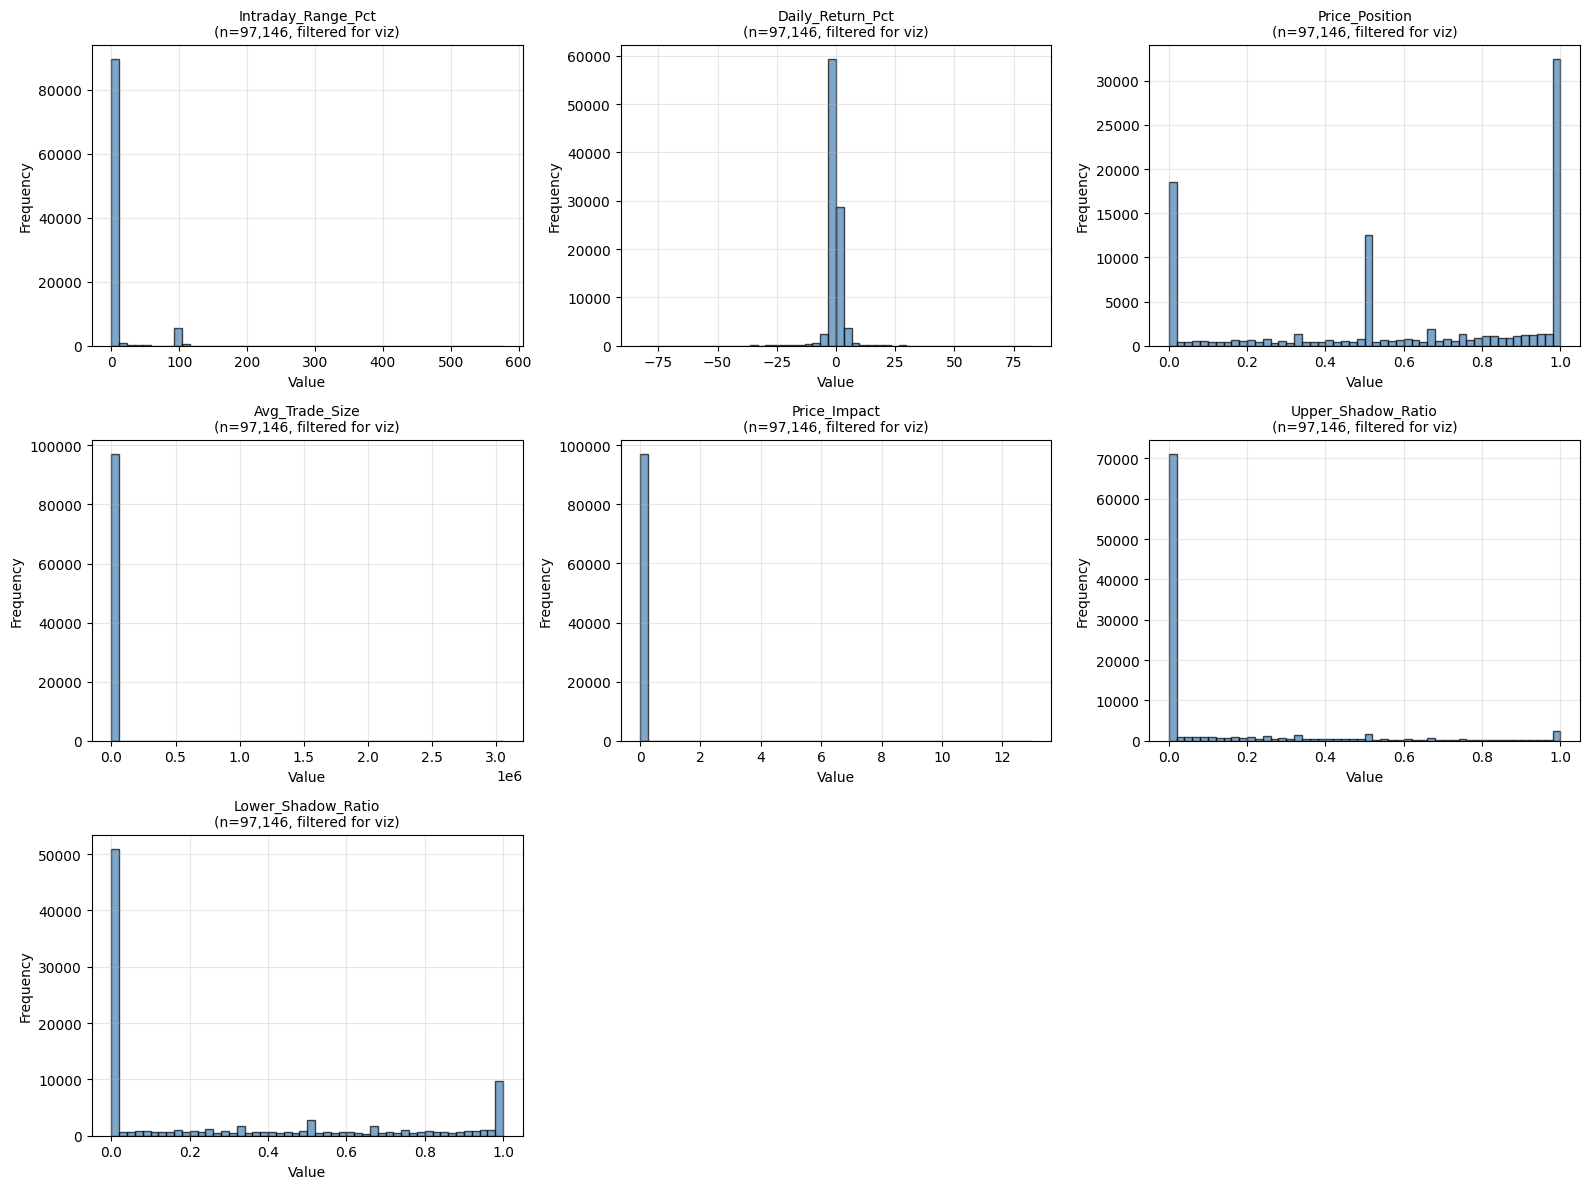

In [169]:
# Visualize the new financial features
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

feature_cols = ['Intraday_Range_Pct', 'Daily_Return_Pct', 'Price_Position', 
                'Avg_Trade_Size', 'Price_Impact', 'Upper_Shadow_Ratio', 'Lower_Shadow_Ratio']

for idx, col in enumerate(feature_cols):
    if len(dataset) > 0:
        axes[idx].hist(dataset[col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[idx].set_title(f'{col}\n(n={len(dataset):,}, filtered for viz)', fontsize=10)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)

# Remove unused subplot
axes[-2].axis('off')
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [170]:
dataset.head()

SEANCE  GROUPE          CODE    VALEUR  OUVERTURE  CLOTURE  \
CODE                                                                            
TN0001000108 0 2016-01-04    11.0  TN0001000108  MONOPRIX      14.19    13.90   
             1 2016-01-05    11.0  TN0001000108  MONOPRIX      14.20    13.90   
             2 2016-01-06    11.0  TN0001000108  MONOPRIX      13.90    13.90   
             3 2016-01-07    11.0  TN0001000108  MONOPRIX      13.95    13.90   
             4 2016-01-08    11.0  TN0001000108  MONOPRIX      13.90    13.87   

                PLUS_BAS  PLUS_HAUT  QUANTITE_NEGOCIEE  NB_TRANSACTION  \
CODE                                                                     
TN0001000108 0     13.77      14.19               2008              21   
             1     13.78      14.20               2588              26   
             2     13.84      13.98              10930              42   
             3     13.81      13.95               4203              24   
             4     13.60      13.90               9588              43   

                 CAPITAUX  Intraday_Range_Pct  Daily_Return_Pct  \
CODE                                                              
TN0001000108 0   27847.95            3.021583         -2.043693   
             1   36058.30            3.021583         -2.112676   
             2  152123.86            1.007194          0.000000   
             3   58550.95            1.007194         -0.358423   
             4  132692.72            2.162942         -0.215827   

                Price_Position  Avg_Trade_Size  Price_Impact  \
CODE                                                           
TN0001000108 0        0.309524       95.619048      0.000144   
             1        0.285714       99.538462      0.000116   
             2        0.428571      260.238095      0.000000   
             3        0.642857      175.125000      0.000012   
             4        0.900000      222.976744      0.000003   

                Upper_Shadow_Ratio  Lower_Shadow_Ratio  
CODE                                                    
TN0001000108 0            0.000000            0.309524  
             1            0.000000            0.285714  
             2            0.571429            0.428571  
             3            0.000000            0.642857  
             4            0.000000            0.900000

In [171]:
# Flatten the MultiIndex
dataset = dataset.reset_index(level=1, drop=False)  # Keep CODE from the MultiIndex
dataset = dataset.reset_index(drop=True)  # Remove the numeric index

# Remove any duplicate CODE columns if they exist
if dataset.columns.duplicated().any():
    dataset = dataset.loc[:, ~dataset.columns.duplicated()]

# Verify the structure
print(f"✓ CODE column preserved: {'CODE' in dataset.columns}")
print(f"✓ Unique CODEs: {dataset['CODE'].nunique()}")
print(f"Dataset shape: {dataset.shape}")
dataset.info()
display(dataset.head())

✓ CODE column preserved: True
✓ Unique CODEs: 41
Dataset shape: (97146, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97146 entries, 0 to 97145
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   level_1             97146 non-null  int64         
 1   SEANCE              97146 non-null  datetime64[ns]
 2   GROUPE              97146 non-null  float64       
 3   CODE                97146 non-null  object        
 4   VALEUR              97146 non-null  object        
 5   OUVERTURE           97146 non-null  float64       
 6   CLOTURE             97146 non-null  float64       
 7   PLUS_BAS            97146 non-null  float64       
 8   PLUS_HAUT           97146 non-null  float64       
 9   QUANTITE_NEGOCIEE   97146 non-null  int64         
 10  NB_TRANSACTION      97146 non-null  int64         
 11  CAPITAUX            97146 non-null  float64       
 12  Intraday_Range_Pct  97146 

level_1     SEANCE  GROUPE          CODE    VALEUR  OUVERTURE  CLOTURE  \
0        0 2016-01-04    11.0  TN0001000108  MONOPRIX      14.19    13.90   
1        1 2016-01-05    11.0  TN0001000108  MONOPRIX      14.20    13.90   
2        2 2016-01-06    11.0  TN0001000108  MONOPRIX      13.90    13.90   
3        3 2016-01-07    11.0  TN0001000108  MONOPRIX      13.95    13.90   
4        4 2016-01-08    11.0  TN0001000108  MONOPRIX      13.90    13.87   

   PLUS_BAS  PLUS_HAUT  QUANTITE_NEGOCIEE  NB_TRANSACTION   CAPITAUX  \
0     13.77      14.19               2008              21   27847.95   
1     13.78      14.20               2588              26   36058.30   
2     13.84      13.98              10930              42  152123.86   
3     13.81      13.95               4203              24   58550.95   
4     13.60      13.90               9588              43  132692.72   

   Intraday_Range_Pct  Daily_Return_Pct  Price_Position  Avg_Trade_Size  \
0            3.021583         -2.043693        0.309524       95.619048   
1            3.021583         -2.112676        0.285714       99.538462   
2            1.007194          0.000000        0.428571      260.238095   
3            1.007194         -0.358423        0.642857      175.125000   
4            2.162942         -0.215827        0.900000      222.976744   

   Price_Impact  Upper_Shadow_Ratio  Lower_Shadow_Ratio  
0      0.000144            0.000000            0.309524  
1      0.000116            0.000000            0.285714  
2      0.000000            0.571429            0.428571  
3      0.000012            0.000000            0.642857  
4      0.000003            0.000000            0.900000

In [172]:
dataset.drop(columns=['level_1'], inplace=True)

In [173]:
dataset['GROUPE'] = dataset['GROUPE'].astype('Int64')

ADDING VARIATION FEATURE (Daily Price Change %)

Computing VARIATION grouped by CODE...

✓ VARIATION feature created successfully!
✓ Missing values before filling: 41
✓ Missing values after filling with 0: 0

VARIATION FEATURE STATISTICS
count    97146.000000
mean         0.024559
std          1.679576
min        -50.604839
25%         -0.568182
50%          0.000000
75%          0.529101
max         22.857143
Name: VARIATION, dtype: float64

✓ Zero values: 26,406 (27.18%)
✓ Positive variations: 32,403 (33.35%)
✓ Negative variations: 38,337 (39.46%)

SAMPLE DATA WITH VARIATION


C:\Users\louay\AppData\Local\Temp\ipykernel_23248\2674637427.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.groupby('CODE', group_keys=False).apply(compute_variation)


SEANCE          CODE    VALEUR  CLOTURE  VARIATION
0 2016-01-04  TN0001000108  MONOPRIX    13.90   0.000000
1 2016-01-05  TN0001000108  MONOPRIX    13.90   0.000000
2 2016-01-06  TN0001000108  MONOPRIX    13.90   0.000000
3 2016-01-07  TN0001000108  MONOPRIX    13.90   0.000000
4 2016-01-08  TN0001000108  MONOPRIX    13.87  -0.215827
5 2016-01-11  TN0001000108  MONOPRIX    13.70  -1.225667
6 2016-01-12  TN0001000108  MONOPRIX    13.79   0.656934
7 2016-01-13  TN0001000108  MONOPRIX    13.90   0.797679
8 2016-01-15  TN0001000108  MONOPRIX    13.80  -0.719424
9 2016-01-18  TN0001000108  MONOPRIX    13.90   0.724638

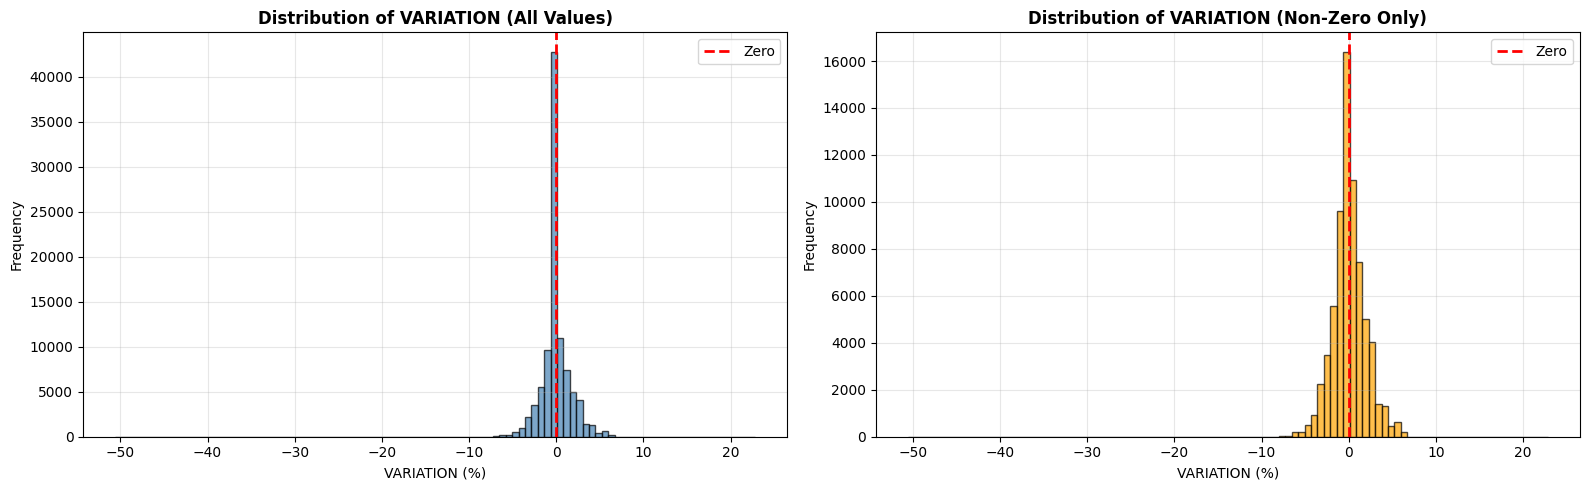


DATASET INFO AFTER ADDING VARIATION
✓ Dataset shape: (97146, 19)
✓ Total features: 19
✓ VARIATION feature added: True


In [174]:
print("=" * 80)
print("ADDING VARIATION FEATURE (Daily Price Change %)")
print("=" * 80)

# Sort by CODE and SEANCE to ensure proper ordering
dataset = dataset.sort_values(['CODE', 'SEANCE']).reset_index(drop=True)

# Calculate VARIATION per CODE group
# VARIATION = (CLOTURE_today - CLOTURE_yesterday) / CLOTURE_yesterday * 100
def compute_variation(group):
    """Compute VARIATION for each CODE group independently"""
    # Calculate percentage change from previous day's CLOTURE
    group['VARIATION'] = group['CLOTURE'].pct_change() * 100
    return group

print("\nComputing VARIATION grouped by CODE...")
dataset = dataset.groupby('CODE', group_keys=False).apply(compute_variation)

# Fill NaN values (first day of each ticker) with 0
missing_before = dataset['VARIATION'].isnull().sum()
dataset['VARIATION'] = dataset['VARIATION'].fillna(0)
missing_after = dataset['VARIATION'].isnull().sum()

print(f"\n✓ VARIATION feature created successfully!")
print(f"✓ Missing values before filling: {missing_before:,}")
print(f"✓ Missing values after filling with 0: {missing_after:,}")

# Display statistics
print("\n" + "=" * 80)
print("VARIATION FEATURE STATISTICS")
print("=" * 80)

variation_stats = dataset['VARIATION'].describe()
print(variation_stats)

print(f"\n✓ Zero values: {(dataset['VARIATION'] == 0).sum():,} ({(dataset['VARIATION'] == 0).sum()/len(dataset)*100:.2f}%)")
print(f"✓ Positive variations: {(dataset['VARIATION'] > 0).sum():,} ({(dataset['VARIATION'] > 0).sum()/len(dataset)*100:.2f}%)")
print(f"✓ Negative variations: {(dataset['VARIATION'] < 0).sum():,} ({(dataset['VARIATION'] < 0).sum()/len(dataset)*100:.2f}%)")

# Show sample data
print("\n" + "=" * 80)
print("SAMPLE DATA WITH VARIATION")
print("=" * 80)
sample_code = dataset['CODE'].iloc[0]
sample_data = dataset[dataset['CODE'] == sample_code][['SEANCE', 'CODE', 'VALEUR', 'CLOTURE', 'VARIATION']].head(10)
display(sample_data)

# Visualize VARIATION distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of all VARIATION values
axes[0].hist(dataset['VARIATION'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribution of VARIATION (All Values)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('VARIATION (%)', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histogram of non-zero VARIATION values
non_zero_variation = dataset[dataset['VARIATION'] != 0]['VARIATION']
axes[1].hist(non_zero_variation, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribution of VARIATION (Non-Zero Only)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('VARIATION (%)', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("DATASET INFO AFTER ADDING VARIATION")
print("=" * 80)
print(f"✓ Dataset shape: {dataset.shape}")
print(f"✓ Total features: {len(dataset.columns)}")
print(f"✓ VARIATION feature added: {'VARIATION' in dataset.columns}")

In [175]:
dataset.head()

SEANCE  GROUPE          CODE    VALEUR  OUVERTURE  CLOTURE  PLUS_BAS  \
0 2016-01-04      11  TN0001000108  MONOPRIX      14.19    13.90     13.77   
1 2016-01-05      11  TN0001000108  MONOPRIX      14.20    13.90     13.78   
2 2016-01-06      11  TN0001000108  MONOPRIX      13.90    13.90     13.84   
3 2016-01-07      11  TN0001000108  MONOPRIX      13.95    13.90     13.81   
4 2016-01-08      11  TN0001000108  MONOPRIX      13.90    13.87     13.60   

   PLUS_HAUT  QUANTITE_NEGOCIEE  NB_TRANSACTION   CAPITAUX  \
0      14.19               2008              21   27847.95   
1      14.20               2588              26   36058.30   
2      13.98              10930              42  152123.86   
3      13.95               4203              24   58550.95   
4      13.90               9588              43  132692.72   

   Intraday_Range_Pct  Daily_Return_Pct  Price_Position  Avg_Trade_Size  \
0            3.021583         -2.043693        0.309524       95.619048   
1            3.021583         -2.112676        0.285714       99.538462   
2            1.007194          0.000000        0.428571      260.238095   
3            1.007194         -0.358423        0.642857      175.125000   
4            2.162942         -0.215827        0.900000      222.976744   

   Price_Impact  Upper_Shadow_Ratio  Lower_Shadow_Ratio  VARIATION  
0      0.000144            0.000000            0.309524   0.000000  
1      0.000116            0.000000            0.285714   0.000000  
2      0.000000            0.571429            0.428571   0.000000  
3      0.000012            0.000000            0.642857   0.000000  
4      0.000003            0.000000            0.900000  -0.215827

## Feature Engineering - Indices

In [191]:
## SKIP IF ALREADY DOWNLOADED
for year in range(2016, 2026):
    delimiter = ';' if year > 2021 else ','
    file_path = f'../data/histo_indice_{year}.csv'
    globals()[f'indice_{year}'] = pd.read_csv(file_path, delimiter=delimiter, engine='python')
    print(f"Loaded indice_{year}: {globals()[f'indice_{year}'].shape}")

Loaded indice_2016: (3765, 9)
Loaded indice_2017: (3780, 9)
Loaded indice_2018: (3735, 9)
Loaded indice_2019: (3735, 9)
Loaded indice_2020: (3750, 9)
Loaded indice_2021: (3475, 9)
Loaded indice_2022: (3598, 8)
Loaded indice_2023: (3528, 8)
Loaded indice_2024: (3514, 8)
Loaded indice_2025: (3486, 8)


In [192]:
# Get all dataframes and their column names
idx_dataframes = {f'indice_{year}': globals()[f'indice_{year}'] for year in range(2016, 2026)}

for name, df in idx_dataframes.items():
    print(f"{name} has columns: {df.columns.tolist()}")

indice_2016 has columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS', 'INDICE_OUV']
indice_2017 has columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS', 'INDICE_OUV']
indice_2018 has columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS', 'INDICE_OUV']
indice_2019 has columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS', 'INDICE_OUV']
indice_2020 has columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS', 'INDICE_OUV']
indice_2021 has columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_

In [193]:
for year in range(2016, 2022):
    globals()[f'indice_{year}'].drop(columns=['INDICE_OUV'], inplace=True)

for year in range(2016, 2026):
    df_name = f'indice_{year}'
    globals()[df_name].columns = globals()[df_name].columns.str.strip()
    print(f"Cleaned {df_name} columns: {globals()[df_name].columns.tolist()}")

idx_dataframes = {f'indice_{year}': globals()[f'indice_{year}'] for year in range(2016, 2026)}
reference_cols = idx_dataframes['indice_2016'].columns.tolist()

all_same = all(df.columns.tolist() == reference_cols for df in idx_dataframes.values())
print(f"\nAll dataframes have identical column names: {all_same}")

Cleaned indice_2016 columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS']
Cleaned indice_2017 columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS']
Cleaned indice_2018 columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS']
Cleaned indice_2019 columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS']
Cleaned indice_2020 columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS']
Cleaned indice_2021 columns: ['SEANCE', 'CODE_INDICE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE', 'INDICE_PLUS_HAUT', 'INDICE_PLUS_BAS']
Cleaned indice_2022 columns: ['SEANCE', 

In [194]:
# Concatenate all dataframes in chronological order
idx_dataset = pd.concat([globals()[f'indice_{year}'] for year in range(2016, 2026)], ignore_index=True)

print(f"Combined dataset shape: {idx_dataset.shape}")
display(idx_dataset.head(3))
display(idx_dataset.tail(3))

Combined dataset shape: (36366, 8)


SEANCE  CODE_INDICE LIB_INDICE  INDICE_JOUR  INDICE_VEILLE  \
0  04/01/2016       905001   TUNINDEX      5089.89        5042.16   
1  04/01/2016       905002      INDSF      3546.33        3523.79   
2  04/01/2016       905003      INDBQ      3177.74        3158.49   

   VARIATION_VEILLE  INDICE_PLUS_HAUT  INDICE_PLUS_BAS  
0              0.95           5089.89          5038.91  
1              0.64           3560.17          3531.27  
2              0.61           3196.27          3165.71

SEANCE  CODE_INDICE          LIB_INDICE  INDICE_JOUR  \
36363  31/12/2025          905018  BATIM MATE CONSTRU      778.494   
36364  31/12/2025          905020  MATERIAUX DE BASE      6794.466   
36365  31/12/2025          905028  TUNINDEX20             5975.277   

       INDICE_VEILLE  VARIATION_VEILLE  INDICE_PLUS_HAUT  INDICE_PLUS_BAS  
36363        776.246              0.29           838.631          728.166  
36364       6725.185              1.03          7182.744         5047.171  
36365       5934.310              0.69          5975.277         4334.940

In [195]:
# Strip whitespace from SEANCE column first
idx_dataset['SEANCE'] = idx_dataset['SEANCE'].str.strip()

# Convert SEANCE to datetime (format: dd/mm/yyyy)
idx_dataset['SEANCE'] = pd.to_datetime(idx_dataset['SEANCE'], format='%d/%m/%Y', errors='coerce')

# Convert numeric columns to float
float_columns = ['INDICE_JOUR', 'INDICE_VEILLE', 'INDICE_PLUS_BAS', 'INDICE_PLUS_HAUT', 'VARIATION_VEILLE']
for col in float_columns:
    idx_dataset[col] = pd.to_numeric(idx_dataset[col], errors='coerce')

# Convert to integer
int_columns = ['CODE_INDICE']
for col in int_columns:
    idx_dataset[col] = pd.to_numeric(idx_dataset[col], errors='coerce').astype('Int64')

print(idx_dataset.dtypes)
display(idx_dataset.head())

SEANCE              datetime64[ns]
CODE_INDICE                  Int64
LIB_INDICE                  object
INDICE_JOUR                float64
INDICE_VEILLE              float64
VARIATION_VEILLE           float64
INDICE_PLUS_HAUT           float64
INDICE_PLUS_BAS            float64
dtype: object


SEANCE  CODE_INDICE LIB_INDICE  INDICE_JOUR  INDICE_VEILLE  \
0 2016-01-04       905001   TUNINDEX      5089.89        5042.16   
1 2016-01-04       905002      INDSF      3546.33        3523.79   
2 2016-01-04       905003      INDBQ      3177.74        3158.49   
3 2016-01-04       905004      INDAS      9945.94        9789.53   
4 2016-01-04       905005      INSFI      5631.63        5615.89   

   VARIATION_VEILLE  INDICE_PLUS_HAUT  INDICE_PLUS_BAS  
0              0.95           5089.89          5038.91  
1              0.64           3560.17          3531.27  
2              0.61           3196.27          3165.71  
3              1.60           9945.94          9801.29  
4              0.28           5634.10          5615.37

In [196]:
idx_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36366 entries, 0 to 36365
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SEANCE            36366 non-null  datetime64[ns]
 1   CODE_INDICE       36366 non-null  Int64         
 2   LIB_INDICE        36366 non-null  object        
 3   INDICE_JOUR       36366 non-null  float64       
 4   INDICE_VEILLE     36366 non-null  float64       
 5   VARIATION_VEILLE  36366 non-null  float64       
 6   INDICE_PLUS_HAUT  36366 non-null  float64       
 7   INDICE_PLUS_BAS   36366 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(5), object(1)
memory usage: 2.3+ MB


In [197]:
idx_dataset['LIB_INDICE'] = idx_dataset['LIB_INDICE'].str.strip()
idx_dataset['LIB_INDICE'].unique()

array(['TUNINDEX', 'INDSF', 'INDBQ', 'INDAS', 'INSFI', 'INDSC', 'INDDI',
       'INBCO', 'INAUE', 'INAAB', 'INPMP', 'INDIN', 'INBMC', 'INDMB',
       'TUNINDEX20', 'TUNFIN', 'TUNBANQ', 'TUNASS', 'TUNSEFI', 'TUNSAC',
       'TUNDIS', 'TUNCONS', 'TUNAUTO', 'TUNALIM', 'TUNMENAG', 'TUNIND',
       'TUNBATIM', 'TUNBASE', 'STES FINANCIERES', 'BANQUES', 'ASSURANCES',
       'SERVICES FINANCIER', 'SERVICES AUX CONSO', 'DISTRIBUTION',
       'BIENS CONSOMMATION', 'AGROALIMENT BOISSO', 'PROD MENAGER SOIN',
       'INDUSTRIES', 'BATIM MATE CONSTRU', 'MATERIAUX DE BASE', 'PX1',
       'TUN20'], dtype=object)

In [198]:
idx_dataset['CODE_INDICE'].unique()

<IntegerArray>
[905001, 905002, 905003, 905004, 905005, 905008, 905009, 905013, 905014,
 905015, 905016, 905017, 905018, 905020, 905028, 350000]
Length: 16, dtype: Int64

In [199]:
target_indices_labels = ['TUNINDEX', 'TUNINDEX20', 'TUNFIN', 'TUNBANQ', 'TUNSAC']
target_indices_codes = idx_dataset[idx_dataset['LIB_INDICE'].isin(target_indices_labels)]['CODE_INDICE'].unique().tolist()
print(f"Target indices codes: {target_indices_codes}")

Target indices codes: [905001, 905028, 350000, 905002, 905003, 905008]


In [200]:
for code in target_indices_codes:
    names = idx_dataset[idx_dataset['CODE_INDICE'] == code]['LIB_INDICE'].unique().tolist()
    print(f"CODE_INDICE: {code} corresponds to LIB_INDICE: {names}")

CODE_INDICE: 905001 corresponds to LIB_INDICE: ['TUNINDEX', 'PX1']
CODE_INDICE: 905028 corresponds to LIB_INDICE: ['TUNINDEX20', 'TUN20']
CODE_INDICE: 350000 corresponds to LIB_INDICE: ['TUNINDEX']
CODE_INDICE: 905002 corresponds to LIB_INDICE: ['INDSF', 'TUNFIN', 'STES FINANCIERES']
CODE_INDICE: 905003 corresponds to LIB_INDICE: ['INDBQ', 'TUNBANQ', 'BANQUES']
CODE_INDICE: 905008 corresponds to LIB_INDICE: ['INDSC', 'TUNSAC', 'SERVICES AUX CONSO']


In [201]:
first_tunindex = idx_dataset[idx_dataset['CODE_INDICE'] == 350000 ]
second_tunindex = idx_dataset[idx_dataset['CODE_INDICE'] == 905001 ]
print(f"TUNINDEX (350000) shape: {first_tunindex.shape}")
print(f"TUNINDEX (905001) shape: {second_tunindex.shape}")
print("Date ranges:")
print(f"  350000: {first_tunindex['SEANCE'].min().date()} to {first_tunindex['SEANCE'].max().date()}")
print(f"  905001: {second_tunindex['SEANCE'].min().date()} to {second_tunindex['SEANCE'].max().date()}")

TUNINDEX (350000) shape: (161, 8)
TUNINDEX (905001) shape: (2347, 8)
Date ranges:
  350000: 2021-01-04 to 2021-08-27
  905001: 2016-01-04 to 2025-12-31


In [202]:
idx_dataset.loc[idx_dataset['CODE_INDICE'] == 350000, 'CODE_INDICE'] = 905001

print(f"Updated idx_dataset shape: {idx_dataset.shape}")
print(f"Unique CODE_INDICE values: {sorted(idx_dataset['CODE_INDICE'].unique())}")

# Verify the change
tunindex_count = len(idx_dataset[idx_dataset['CODE_INDICE'] == 905001])
print(f"Total rows with CODE_INDICE 905001 (TUNINDEX): {tunindex_count}")

Updated idx_dataset shape: (36366, 8)
Unique CODE_INDICE values: [np.int64(905001), np.int64(905002), np.int64(905003), np.int64(905004), np.int64(905005), np.int64(905008), np.int64(905009), np.int64(905013), np.int64(905014), np.int64(905015), np.int64(905016), np.int64(905017), np.int64(905018), np.int64(905020), np.int64(905028)]
Total rows with CODE_INDICE 905001 (TUNINDEX): 2508


In [203]:
idx_dataset = idx_dataset[idx_dataset['CODE_INDICE'].isin(target_indices_codes)].copy()
print(f"Filtered idx_dataset shape: {idx_dataset.shape}")

Filtered idx_dataset shape: (12540, 8)


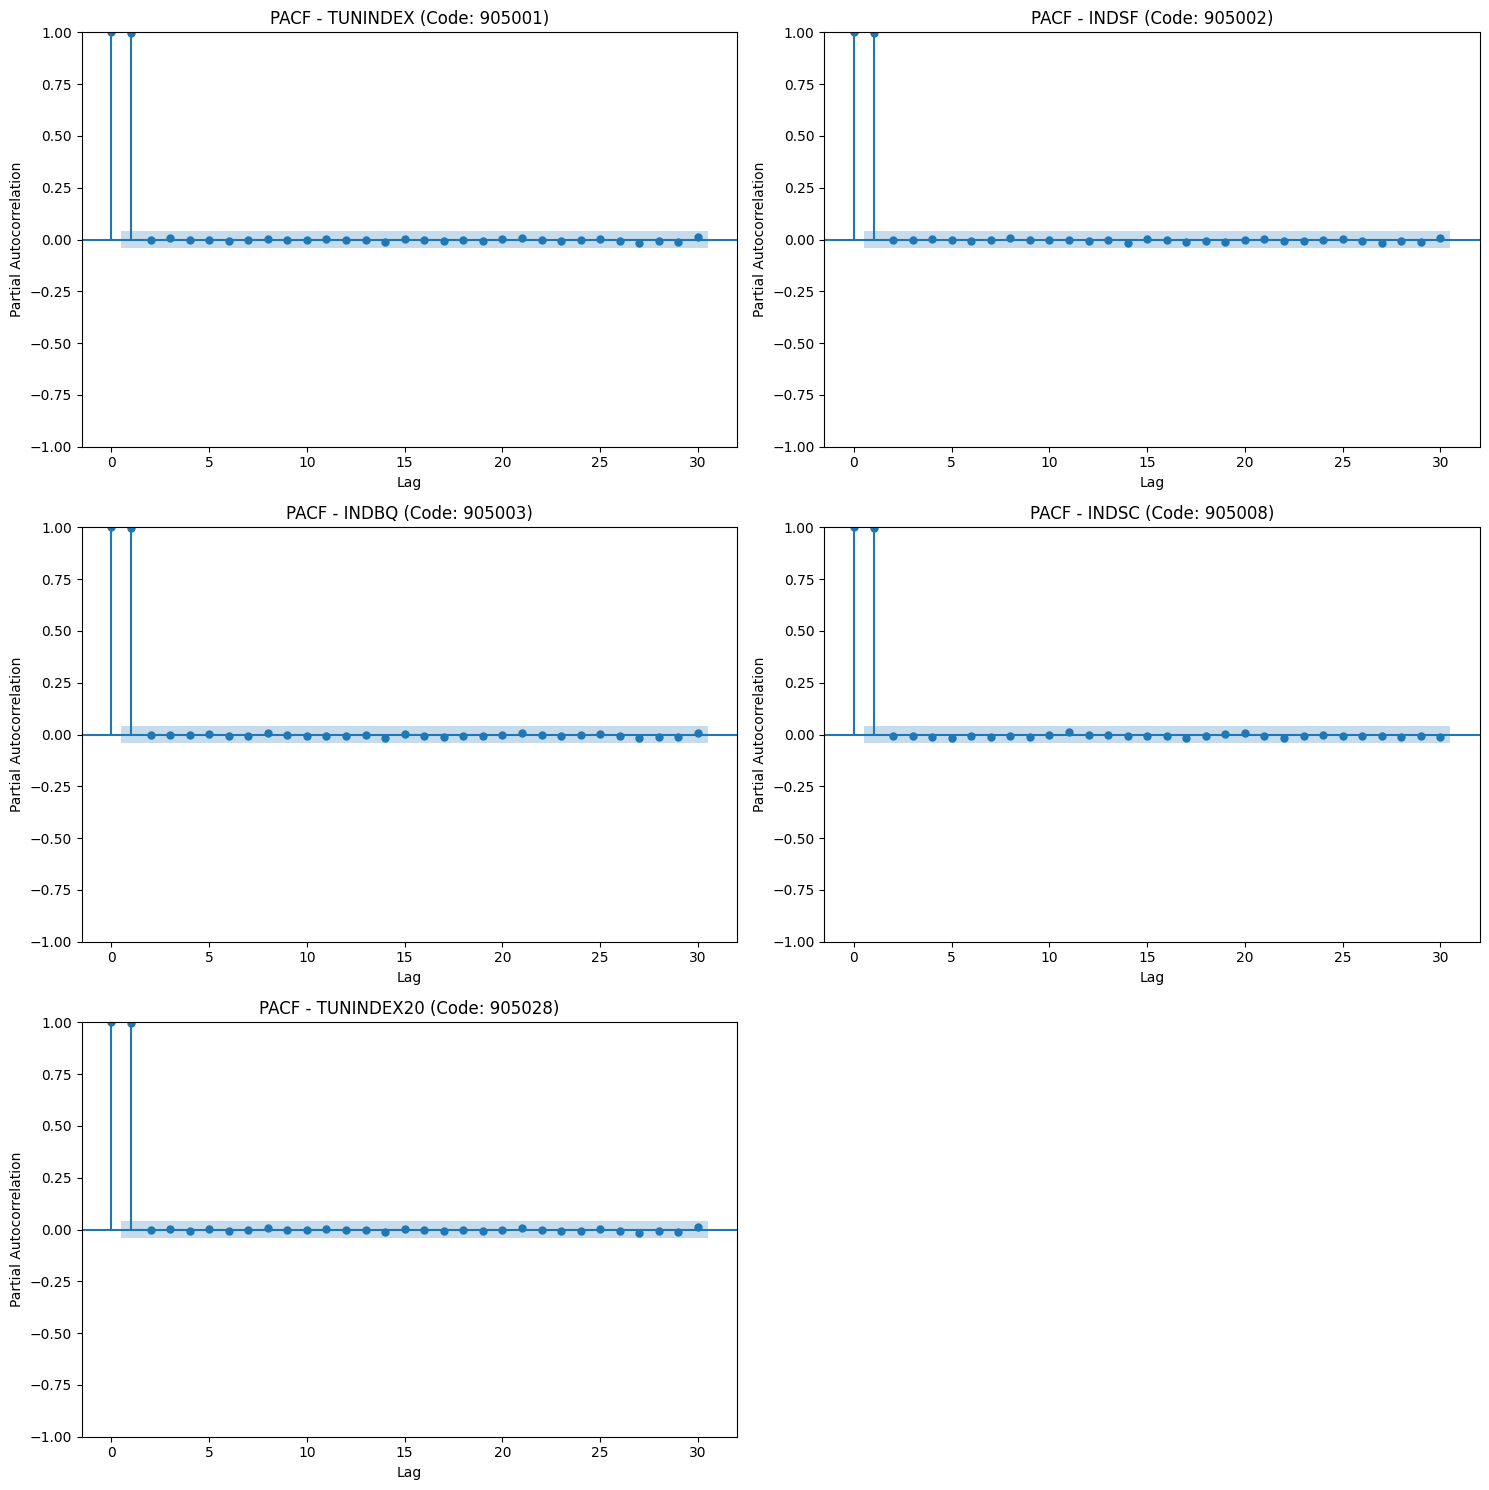

In [205]:
# Plot PACF for each index
unique_codes = idx_dataset['CODE_INDICE'].unique()
n_plots = len(unique_codes)
cols = 2
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten()

for i, code in enumerate(unique_codes):
    # Get data for specific index
    subset = idx_dataset[idx_dataset['CODE_INDICE'] == code].sort_values('SEANCE')
    
    # Get index name for title
    idx_name = subset['LIB_INDICE'].iloc[0]
    
    # Plot PACF on INDICE_JOUR
    clean_series = subset['INDICE_JOUR'].dropna()
    
    if len(clean_series) > 0:
        plot_pacf(clean_series, lags=30, ax=axes[i], method='ywm', title=f'PACF - {idx_name} (Code: {code})')
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Partial Autocorrelation')
    else:
        axes[i].text(0.5, 0.5, 'Not enough data', ha='center')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [206]:
# Standardize LIB_INDICE names for consistency
idx_dataset.loc[idx_dataset['CODE_INDICE'] == 905002, 'LIB_INDICE'] = 'TUNFIN'
idx_dataset.loc[idx_dataset['CODE_INDICE'] == 905003, 'LIB_INDICE'] = 'TUNBANQ'
idx_dataset.loc[idx_dataset['CODE_INDICE'] == 905008, 'LIB_INDICE'] = 'TUNSAC'
idx_dataset.loc[idx_dataset['CODE_INDICE'] == 905028, 'LIB_INDICE'] = 'TUNINDEX20'
idx_dataset.loc[idx_dataset['CODE_INDICE'] == 905001, 'LIB_INDICE'] = 'TUNINDEX'

print("Updated LIB_INDICE names for consistency")
print("\nMapping:")
for code in sorted(idx_dataset['CODE_INDICE'].unique()):
    names = idx_dataset[idx_dataset['CODE_INDICE'] == code]['LIB_INDICE'].unique()
    print(f"  CODE_INDICE {code}: {names[0]}")

print(f"\nTotal unique LIB_INDICE: {idx_dataset['LIB_INDICE'].nunique()}")
print(f"Unique names: {sorted(idx_dataset['LIB_INDICE'].unique())}")

Updated LIB_INDICE names for consistency

Mapping:
  CODE_INDICE 905001: TUNINDEX
  CODE_INDICE 905002: TUNFIN
  CODE_INDICE 905003: TUNBANQ
  CODE_INDICE 905008: TUNSAC
  CODE_INDICE 905028: TUNINDEX20

Total unique LIB_INDICE: 5
Unique names: ['TUNBANQ', 'TUNFIN', 'TUNINDEX', 'TUNINDEX20', 'TUNSAC']


In [207]:
# Select only the columns we need
idx_subset = idx_dataset[['SEANCE', 'LIB_INDICE', 'INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE']].copy()

# Pivot the data: each date becomes a row, each index becomes multiple columns
idx_wide = idx_subset.pivot(
    index='SEANCE',
    columns='LIB_INDICE',
    values=['INDICE_JOUR', 'INDICE_VEILLE', 'VARIATION_VEILLE']
)

# Flatten the multi-level column names
# From ('INDICE_JOUR', 'TUNINDEX') to 'TUNINDEX_INDICE_JOUR'
idx_wide.columns = [f'{col[1]}_{col[0]}' for col in idx_wide.columns]

# Reset index to make SEANCE a regular column
idx_wide = idx_wide.reset_index()

print(f"Reshaped idx_dataset:")
print(f"  Original shape: {idx_dataset.shape}")
print(f"  New shape: {idx_wide.shape}")
print(f"  Columns: {idx_wide.columns.tolist()}")
print(f"\nFirst few rows:")
display(idx_wide.head())

# Replace idx_dataset with the wide format
idx_dataset = idx_wide

Reshaped idx_dataset:
  Original shape: (12540, 8)
  New shape: (2508, 16)
  Columns: ['SEANCE', 'TUNBANQ_INDICE_JOUR', 'TUNFIN_INDICE_JOUR', 'TUNINDEX_INDICE_JOUR', 'TUNINDEX20_INDICE_JOUR', 'TUNSAC_INDICE_JOUR', 'TUNBANQ_INDICE_VEILLE', 'TUNFIN_INDICE_VEILLE', 'TUNINDEX_INDICE_VEILLE', 'TUNINDEX20_INDICE_VEILLE', 'TUNSAC_INDICE_VEILLE', 'TUNBANQ_VARIATION_VEILLE', 'TUNFIN_VARIATION_VEILLE', 'TUNINDEX_VARIATION_VEILLE', 'TUNINDEX20_VARIATION_VEILLE', 'TUNSAC_VARIATION_VEILLE']

First few rows:


SEANCE  TUNBANQ_INDICE_JOUR  TUNFIN_INDICE_JOUR  TUNINDEX_INDICE_JOUR  \
0 2016-01-04              3177.74             3546.33               5089.89   
1 2016-01-05              3185.85             3553.03               5141.03   
2 2016-01-06              3229.88             3599.30               5176.11   
3 2016-01-07              3254.56             3626.89               5171.78   
4 2016-01-08              3248.61             3619.58               5165.50   

   TUNINDEX20_INDICE_JOUR  TUNSAC_INDICE_JOUR  TUNBANQ_INDICE_VEILLE  \
0                 2133.23             3249.11                3158.49   
1                 2153.09             3238.56                3177.74   
2                 2165.63             3226.14                3185.85   
3                 2161.46             3228.20                3229.88   
4                 2153.19             3222.95                3254.56   

   TUNFIN_INDICE_VEILLE  TUNINDEX_INDICE_VEILLE  TUNINDEX20_INDICE_VEILLE  \
0               3523.79                 5042.16                   2113.71   
1               3546.33                 5089.89                   2133.23   
2               3553.03                 5141.03                   2153.09   
3               3599.30                 5176.11                   2165.63   
4               3626.89                 5171.78                   2161.46   

   TUNSAC_INDICE_VEILLE  TUNBANQ_VARIATION_VEILLE  TUNFIN_VARIATION_VEILLE  \
0               3285.71                      0.61                     0.64   
1               3249.11                      0.26                     0.19   
2               3238.56                      1.38                     1.30   
3               3226.14                      0.76                     0.77   
4               3228.20                     -0.18                    -0.20   

   TUNINDEX_VARIATION_VEILLE  TUNINDEX20_VARIATION_VEILLE  \
0                       0.95                         0.92   
1                       1.00                         0.93   
2                       0.68                         0.58   
3                      -0.08                        -0.19   
4                      -0.12                        -0.38   

   TUNSAC_VARIATION_VEILLE  
0                    -1.11  
1                    -0.32  
2                    -0.38  
3                     0.06  
4                    -0.16

In [208]:
indices_2026 = pd.read_csv('../data/2026_indices_data.csv', parse_dates=['SEANCE'])
indices_2026.head()

SEANCE TUNBANQ_PRIX TUNFIN_PRIX TUNINDEX_PRIX TUNINDEX20_PRIX  \
0 2026-01-02     9,540.90   10,298.66     13,341.96        5,921.35   
1 2026-01-05     9,453.34   10,200.32     13,223.56        5,867.11   
2 2026-01-06     9,396.41   10,145.61     13,172.11        5,837.13   
3 2026-01-07     9,368.94   10,119.63     13,152.00        5,828.66   
4 2026-01-08     9,352.37   10,105.95     13,119.98        5,814.06   

  TUNSAC_PRIX  
0    4,965.90  
1    4,905.68  
2    4,930.63  
3    4,928.54  
4    4,880.78

In [211]:
columns_to_convert = [col for col in indices_2026.columns if col != 'SEANCE']
for col in columns_to_convert:
    # Convert to string, remove commas, then convert to float
    indices_2026[col] = indices_2026[col].astype(str).str.replace(',', '').astype(float)
indices_2026.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SEANCE           26 non-null     datetime64[ns]
 1   TUNBANQ_PRIX     26 non-null     float64       
 2   TUNFIN_PRIX      26 non-null     float64       
 3   TUNINDEX_PRIX    26 non-null     float64       
 4   TUNINDEX20_PRIX  26 non-null     float64       
 5   TUNSAC_PRIX      26 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.3 KB


In [212]:
print("=" * 80)
print("INTEGRATING 2026 INDICES DATA")
print("=" * 80)

# Store original shapes
original_idx_shape = idx_dataset.shape
original_2026_shape = indices_2026.shape

print(f"\nOriginal idx_dataset shape: {original_idx_shape}")
print(f"Original idx_dataset date range: {idx_dataset['SEANCE'].min().date()} to {idx_dataset['SEANCE'].max().date()}")

print(f"\nIndices_2026 shape: {original_2026_shape}")
print(f"Indices_2026 date range: {indices_2026['SEANCE'].min().date()} to {indices_2026['SEANCE'].max().date()}")

# ============================================================================
# STEP 1: RENAME COLUMNS IN indices_2026
# ============================================================================
print("\n" + "=" * 80)
print("STEP 1: RENAMING COLUMNS IN indices_2026")
print("=" * 80)

# Create mapping: x_PRIX -> x_INDICE_JOUR
column_mapping = {
    'TUNBANQ_PRIX': 'TUNBANQ_INDICE_JOUR',
    'TUNFIN_PRIX': 'TUNFIN_INDICE_JOUR',
    'TUNINDEX_PRIX': 'TUNINDEX_INDICE_JOUR',
    'TUNINDEX20_PRIX': 'TUNINDEX20_INDICE_JOUR',
    'TUNSAC_PRIX': 'TUNSAC_INDICE_JOUR'
}

print("\nColumn mapping:")
for old_name, new_name in column_mapping.items():
    print(f"  {old_name} → {new_name}")

# Apply renaming
indices_2026 = indices_2026.rename(columns=column_mapping)

print(f"\n✓ Columns renamed successfully!")
print(f"New columns: {indices_2026.columns.tolist()}")

# ============================================================================
# STEP 2: CONCATENATE WITH idx_dataset
# ============================================================================
print("\n" + "=" * 80)
print("STEP 2: CONCATENATING indices_2026 WITH idx_dataset")
print("=" * 80)

# Concatenate
idx_dataset = pd.concat([idx_dataset, indices_2026], ignore_index=True)

# Sort by SEANCE
idx_dataset = idx_dataset.sort_values('SEANCE').reset_index(drop=True)

print(f"\n✓ Concatenation complete!")
print(f"New idx_dataset shape: {idx_dataset.shape}")
print(f"New date range: {idx_dataset['SEANCE'].min().date()} to {idx_dataset['SEANCE'].max().date()}")

# ============================================================================
# STEP 3: CALCULATE MISSING COLUMNS FOR 2026 ROWS
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: CALCULATING MISSING COLUMNS FOR 2026 ROWS")
print("=" * 80)

# List of indices
indices = ['TUNBANQ', 'TUNFIN', 'TUNINDEX', 'TUNINDEX20', 'TUNSAC']

for idx_name in indices:
    print(f"\nProcessing {idx_name}...")
    
    # Column names
    jour_col = f'{idx_name}_INDICE_JOUR'
    veille_col = f'{idx_name}_INDICE_VEILLE'
    variation_col = f'{idx_name}_VARIATION_VEILLE'
    
    # Calculate INDICE_VEILLE: shift INDICE_JOUR by 1 (previous day's value)
    idx_dataset[veille_col] = idx_dataset[jour_col].shift(1)
    
    # Calculate VARIATION_VEILLE: (INDICE_JOUR - INDICE_VEILLE) / INDICE_VEILLE * 100
    idx_dataset[variation_col] = 0.0
    valid_mask = idx_dataset[veille_col] > 0
    idx_dataset.loc[valid_mask, variation_col] = (
        (idx_dataset.loc[valid_mask, jour_col] - idx_dataset.loc[valid_mask, veille_col]) / 
        idx_dataset.loc[valid_mask, veille_col]
    ) * 100
    
    print(f"  ✓ {veille_col} calculated")
    print(f"  ✓ {variation_col} calculated")

print("\n✓ All missing columns calculated successfully!")

# ============================================================================
# STEP 4: VERIFICATION
# ============================================================================
print("\n" + "=" * 80)
print("STEP 4: VERIFICATION")
print("=" * 80)

# Check for missing values
missing_counts = idx_dataset.isnull().sum()
print(f"\nMissing values per column:")
display(missing_counts[missing_counts > 0])

# Show sample of 2026 data
print("\n" + "=" * 80)
print("SAMPLE OF 2026 DATA (After Calculations)")
print("=" * 80)
data_2026_rows = idx_dataset[idx_dataset['SEANCE'] >= '2026-01-01']
display(data_2026_rows.head(10))

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("FINAL idx_dataset SUMMARY")
print("=" * 80)
print(f"Shape: {idx_dataset.shape}")
print(f"Rows: {idx_dataset.shape[0]:,}")
print(f"Columns: {idx_dataset.shape[1]}")
print(f"Date range: {idx_dataset['SEANCE'].min().date()} to {idx_dataset['SEANCE'].max().date()}")
print(f"Total missing values: {idx_dataset.isnull().sum().sum():,}")
print(f"\n✓ 2026 indices integration complete!")

INTEGRATING 2026 INDICES DATA

Original idx_dataset shape: (2508, 16)
Original idx_dataset date range: 2016-01-04 to 2025-12-31

Indices_2026 shape: (26, 6)
Indices_2026 date range: 2026-01-02 to 2026-02-06

STEP 1: RENAMING COLUMNS IN indices_2026

Column mapping:
  TUNBANQ_PRIX → TUNBANQ_INDICE_JOUR
  TUNFIN_PRIX → TUNFIN_INDICE_JOUR
  TUNINDEX_PRIX → TUNINDEX_INDICE_JOUR
  TUNINDEX20_PRIX → TUNINDEX20_INDICE_JOUR
  TUNSAC_PRIX → TUNSAC_INDICE_JOUR

✓ Columns renamed successfully!
New columns: ['SEANCE', 'TUNBANQ_INDICE_JOUR', 'TUNFIN_INDICE_JOUR', 'TUNINDEX_INDICE_JOUR', 'TUNINDEX20_INDICE_JOUR', 'TUNSAC_INDICE_JOUR']

STEP 2: CONCATENATING indices_2026 WITH idx_dataset

✓ Concatenation complete!
New idx_dataset shape: (2534, 16)
New date range: 2016-01-04 to 2026-02-06

STEP 3: CALCULATING MISSING COLUMNS FOR 2026 ROWS

Processing TUNBANQ...
  ✓ TUNBANQ_INDICE_VEILLE calculated
  ✓ TUNBANQ_VARIATION_VEILLE calculated

Processing TUNFIN...
  ✓ TUNFIN_INDICE_VEILLE calculated
  ✓ TUN

TUNBANQ_INDICE_VEILLE       1
TUNFIN_INDICE_VEILLE        1
TUNINDEX_INDICE_VEILLE      1
TUNINDEX20_INDICE_VEILLE    1
TUNSAC_INDICE_VEILLE        1
dtype: int64


SAMPLE OF 2026 DATA (After Calculations)


SEANCE  TUNBANQ_INDICE_JOUR  TUNFIN_INDICE_JOUR  \
2508 2026-01-02              9540.90            10298.66   
2509 2026-01-05              9453.34            10200.32   
2510 2026-01-06              9396.41            10145.61   
2511 2026-01-07              9368.94            10119.63   
2512 2026-01-08              9352.37            10105.95   
2513 2026-01-09              9382.72            10127.56   
2514 2026-01-12              9445.19            10183.82   
2515 2026-01-13              9579.72            10309.33   
2516 2026-01-14              9708.66            10431.17   
2517 2026-01-15              9884.96            10626.06   

      TUNINDEX_INDICE_JOUR  TUNINDEX20_INDICE_JOUR  TUNSAC_INDICE_JOUR  \
2508              13341.96                 5921.35             4965.90   
2509              13223.56                 5867.11             4905.68   
2510              13172.11                 5837.13             4930.63   
2511              13152.00                 5828.66             4928.54   
2512              13119.98                 5814.06             4880.78   
2513              13136.87                 5828.13             4851.51   
2514              13194.73                 5855.77             4897.90   
2515              13331.86                 5926.76             4921.30   
2516              13441.43                 5979.16             4921.58   
2517              13701.64                 6104.87             4944.08   

      TUNBANQ_INDICE_VEILLE  TUNFIN_INDICE_VEILLE  TUNINDEX_INDICE_VEILLE  \
2508               9669.603             10424.623               13449.953   
2509               9540.900             10298.660               13341.960   
2510               9453.340             10200.320               13223.560   
2511               9396.410             10145.610               13172.110   
2512               9368.940             10119.630               13152.000   
2513               9352.370             10105.950               13119.980   
2514               9382.720             10127.560               13136.870   
2515               9445.190             10183.820               13194.730   
2516               9579.720             10309.330               13331.860   
2517               9708.660             10431.170               13441.430   

      TUNINDEX20_INDICE_VEILLE  TUNSAC_INDICE_VEILLE  \
2508                  5975.277              4984.055   
2509                  5921.350              4965.900   
2510                  5867.110              4905.680   
2511                  5837.130              4930.630   
2512                  5828.660              4928.540   
2513                  5814.060              4880.780   
2514                  5828.130              4851.510   
2515                  5855.770              4897.900   
2516                  5926.760              4921.300   
2517                  5979.160              4921.580   

      TUNBANQ_VARIATION_VEILLE  TUNFIN_VARIATION_VEILLE  \
2508                 -1.331006                -1.208322   
2509                 -0.917733                -0.954882   
2510                 -0.602221                -0.536356   
2511                 -0.292346                -0.256071   
2512                 -0.176861                -0.135183   
2513                  0.324517                 0.213834   
2514                  0.665798                 0.555514   
2515                  1.424323                 1.232445   
2516                  1.345968                 1.181842   
2517                  1.815905                 1.868343   

      TUNINDEX_VARIATION_VEILLE  TUNINDEX20_VARIATION_VEILLE  \
2508                  -0.802925                    -0.902502   
2509                  -0.887426                    -0.916007   
2510                  -0.389078                    -0.510984   
2511                  -0.152671                    -0.145106   
2512                  -0.243461                    -0.250486   
2513                   0.128735   


FINAL idx_dataset SUMMARY
Shape: (2534, 16)
Rows: 2,534
Columns: 16
Date range: 2016-01-04 to 2026-02-06
Total missing values: 5

✓ 2026 indices integration complete!


In [213]:
print("=" * 80)
print("IDENTIFYING MISSING VALUES IN idx_dataset")
print("=" * 80)

# Get columns with exactly 1 missing value
columns_with_one_missing = idx_dataset.columns[idx_dataset.isnull().sum() == 1].tolist()

print(f"\nColumns with exactly 1 missing value: {len(columns_with_one_missing)}")
print(f"Columns: {columns_with_one_missing}")

# Find the rows with missing values
print("\n" + "=" * 80)
print("ROWS WITH MISSING VALUES")
print("=" * 80)

for col in columns_with_one_missing:
    missing_row = idx_dataset[idx_dataset[col].isnull()]
    if not missing_row.empty:
        print(f"\nColumn: {col}")
        print(f"Date: {missing_row['SEANCE'].iloc[0]}")
        print(f"Row index: {missing_row.index[0]}")

# Display the full rows with missing values
print("\n" + "=" * 80)
print("FULL ROW(S) WITH MISSING VALUES")
print("=" * 80)

# Get rows where ANY column (except SEANCE) has missing values
rows_with_missing = idx_dataset[idx_dataset.drop(columns=['SEANCE']).isnull().any(axis=1)]

print(f"\nTotal rows with missing values: {len(rows_with_missing)}")
display(rows_with_missing)

# Show which columns are missing in each row
print("\n" + "=" * 80)
print("MISSING COLUMNS BREAKDOWN")
print("=" * 80)

for idx in rows_with_missing.index:
    row = idx_dataset.loc[idx]
    missing_cols = row[row.isnull()].index.tolist()
    print(f"\nRow {idx} (Date: {row['SEANCE']})")
    print(f"  Missing columns ({len(missing_cols)}): {missing_cols}")

IDENTIFYING MISSING VALUES IN idx_dataset

Columns with exactly 1 missing value: 5
Columns: ['TUNBANQ_INDICE_VEILLE', 'TUNFIN_INDICE_VEILLE', 'TUNINDEX_INDICE_VEILLE', 'TUNINDEX20_INDICE_VEILLE', 'TUNSAC_INDICE_VEILLE']

ROWS WITH MISSING VALUES

Column: TUNBANQ_INDICE_VEILLE
Date: 2016-01-04 00:00:00
Row index: 0

Column: TUNFIN_INDICE_VEILLE
Date: 2016-01-04 00:00:00
Row index: 0

Column: TUNINDEX_INDICE_VEILLE
Date: 2016-01-04 00:00:00
Row index: 0

Column: TUNINDEX20_INDICE_VEILLE
Date: 2016-01-04 00:00:00
Row index: 0

Column: TUNSAC_INDICE_VEILLE
Date: 2016-01-04 00:00:00
Row index: 0

FULL ROW(S) WITH MISSING VALUES

Total rows with missing values: 1


SEANCE  TUNBANQ_INDICE_JOUR  TUNFIN_INDICE_JOUR  TUNINDEX_INDICE_JOUR  \
0 2016-01-04              3177.74             3546.33               5089.89   

   TUNINDEX20_INDICE_JOUR  TUNSAC_INDICE_JOUR  TUNBANQ_INDICE_VEILLE  \
0                 2133.23             3249.11                    NaN   

   TUNFIN_INDICE_VEILLE  TUNINDEX_INDICE_VEILLE  TUNINDEX20_INDICE_VEILLE  \
0                   NaN                     NaN                       NaN   

   TUNSAC_INDICE_VEILLE  TUNBANQ_VARIATION_VEILLE  TUNFIN_VARIATION_VEILLE  \
0                   NaN                       0.0                      0.0   

   TUNINDEX_VARIATION_VEILLE  TUNINDEX20_VARIATION_VEILLE  \
0                        0.0                          0.0   

   TUNSAC_VARIATION_VEILLE  
0                      0.0


MISSING COLUMNS BREAKDOWN

Row 0 (Date: 2016-01-04 00:00:00)
  Missing columns (5): ['TUNBANQ_INDICE_VEILLE', 'TUNFIN_INDICE_VEILLE', 'TUNINDEX_INDICE_VEILLE', 'TUNINDEX20_INDICE_VEILLE', 'TUNSAC_INDICE_VEILLE']


In [214]:
print("=" * 80)
print("DROPPING ROWS WITH DATE 2016-01-04")
print("=" * 80)

# Identify the date to drop
date_to_drop = pd.to_datetime('2016-01-04')

print(f"\nBefore dropping:")
print(f"  idx_dataset shape: {idx_dataset.shape}")
print(f"  dataset shape: {dataset.shape}")

# Drop from idx_dataset
idx_dataset = idx_dataset[idx_dataset['SEANCE'] != date_to_drop].reset_index(drop=True)

# Drop from dataset
dataset = dataset[dataset['SEANCE'] != date_to_drop].reset_index(drop=True)

print(f"\nAfter dropping:")
print(f"  idx_dataset shape: {idx_dataset.shape}")
print(f"  dataset shape: {dataset.shape}")

# Verify no missing values remain in idx_dataset
print("\n" + "=" * 80)
print("VERIFICATION: Missing values after dropping")
print("=" * 80)
print(f"\nMissing values in idx_dataset:")
print(idx_dataset.isnull().sum()[idx_dataset.isnull().sum() > 0])

print(f"\nMissing values in dataset:")
print(dataset.isnull().sum()[dataset.isnull().sum() > 0])

print("\n✓ Rows with date 2016-01-04 have been dropped from both datasets")

DROPPING ROWS WITH DATE 2016-01-04

Before dropping:
  idx_dataset shape: (2534, 16)
  dataset shape: (97146, 19)

After dropping:
  idx_dataset shape: (2533, 16)
  dataset shape: (97111, 19)

VERIFICATION: Missing values after dropping

Missing values in idx_dataset:
Series([], dtype: int64)

Missing values in dataset:
Series([], dtype: int64)

✓ Rows with date 2016-01-04 have been dropped from both datasets


In [215]:
# idx_dataset.to_csv('../data/index_historical_data.csv', index=False)
idx_dataset = pd.read_csv('../data/index_historical_data.csv', parse_dates=['SEANCE'])

In [216]:
# Merge idx_dataset with the main dataset on SEANCE
print(f"Before merge:")
print(f"  dataset shape: {dataset.shape}")
print(f"  idx_dataset shape: {idx_dataset.shape}")

# Perform left join to keep all rows from dataset
dataset = pd.merge(dataset, idx_dataset, on='SEANCE', how='left')

print(f"\nAfter merge:")
print(f"  dataset shape: {dataset.shape}")
print(f"  New columns added: {idx_dataset.shape[1] - 1}")  # -1 for SEANCE

# Display sample with index data
print("\nSample rows with index data:")
index_cols = [col for col in dataset.columns if any(idx_name in col for idx_name in ['TUNINDEX', 'TUNFIN', 'TUNBANQ', 'TUNSAC'])]
display(dataset[['SEANCE', 'VALEUR'] + index_cols[:6]].head())

# Check for missing values in index columns
missing_idx = dataset[index_cols].isnull().sum()
if missing_idx.sum() > 0:
    print(f"\nWarning: Some index values are missing:")
    print(missing_idx[missing_idx > 0])

Before merge:
  dataset shape: (97111, 19)
  idx_dataset shape: (2533, 16)

After merge:
  dataset shape: (97111, 34)
  New columns added: 15

Sample rows with index data:


SEANCE    VALEUR  TUNBANQ_INDICE_JOUR  TUNFIN_INDICE_JOUR  \
0 2016-01-05  MONOPRIX              3185.85             3553.03   
1 2016-01-06  MONOPRIX              3229.88             3599.30   
2 2016-01-07  MONOPRIX              3254.56             3626.89   
3 2016-01-08  MONOPRIX              3248.61             3619.58   
4 2016-01-11  MONOPRIX              3299.31             3668.82   

   TUNINDEX_INDICE_JOUR  TUNINDEX20_INDICE_JOUR  TUNSAC_INDICE_JOUR  \
0               5141.03                 2153.09             3238.56   
1               5176.11                 2165.63             3226.14   
2               5171.78                 2161.46             3228.20   
3               5165.50                 2153.19             3222.95   
4               5200.51                 2167.32             3210.30   

   TUNBANQ_INDICE_VEILLE  
0                3177.74  
1                3185.85  
2                3229.88  
3                3254.56  
4                3248.61

## Feature Engineering - Sentiment Analysis

In [218]:
with open('../data/articles_with_sentiment.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)

sentiment_df = pd.DataFrame(json_data['articles'])
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
print(f"Sentiment data shape: {sentiment_df.shape}")
sentiment_df.head()

Sentiment data shape: (4626, 9)


id                                           headline  \
0  ilboursa_8c9564a3  la biat et la bad signent une convention de 50...   
1  ilboursa_d60b3003  projet puro kairouan : l'uib contribue à haute...   
2  ilboursa_c5f3724e  entre résilience et mutation, alkimia prépare ...   
3    tustex_725fddcc  bourse de tunis : le tunindex poursuit son asc...   
4    tustex_1386d3b8  la sotumag cherche deux administrateurs indépe...   

                                             content       date  \
0  la biat marque aujourd'hui une avancée majeure... 2026-02-06   
1  le groupe union internationale de banques (uib... 2026-02-06   
2  l'année 2025 s'est révélée être une période de... 2026-02-06   
3  le tunindex continue à arracher des gains à la... 2026-02-06   
4  dans le cadre du renforcement de sa gouvernanc... 2026-02-06   

                                                 url  \
0  https://www.ilboursa.com/marches/la-biat-et-la...   
1  https://www.ilboursa.com/marches/projet-puro-k...   
2  https://www.ilboursa.com/marches/entre-resilie...   
3  https://www.tustex.com/bourse-analyse-marche/b...   
4  https://www.tustex.com/bourse-nominations/la-s...   

                                             tickers language  \
0                                             [BIAT]       fr   
1              [ARAB TUNISIAN BANK, UBCI, BIAT, UIB]       fr   
2                         [SOCIETE CHIMIQUE ALKIMIA]       fr   
3  [ATTIJARI BANK, POULINA GROUP HOLDING, TUNIS R...       fr   
4                                          [SOTUMAG]       fr   

   sentiment_score  confidence  
0                1       0.683  
1                1       0.716  
2               -1       0.252  
3               -1       0.321  
4                0       0.438

In [223]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4626 entries, 0 to 4625
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               4626 non-null   object        
 1   headline         4626 non-null   object        
 2   content          4626 non-null   object        
 3   date             4626 non-null   datetime64[ns]
 4   url              4626 non-null   object        
 5   tickers          4626 non-null   object        
 6   language         4626 non-null   object        
 7   sentiment_score  4626 non-null   int64         
 8   confidence       4626 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 325.4+ KB


In [224]:
sentiment_df = sentiment_df[['date', 'tickers', 'sentiment_score', 'confidence']].reset_index(drop=True)
sentiment_df.head()

date                                            tickers  \
0 2026-02-06                                             [BIAT]   
1 2026-02-06              [ARAB TUNISIAN BANK, UBCI, BIAT, UIB]   
2 2026-02-06                         [SOCIETE CHIMIQUE ALKIMIA]   
3 2026-02-06  [ATTIJARI BANK, POULINA GROUP HOLDING, TUNIS R...   
4 2026-02-06                                          [SOTUMAG]   

   sentiment_score  confidence  
0                1       0.683  
1                1       0.716  
2               -1       0.252  
3               -1       0.321  
4                0       0.438

In [225]:
# Convert tickers column from string representation of list to actual list
sentiment_df['tickers'] = sentiment_df['tickers'].astype(str)
sentiment_df['tickers'] = sentiment_df['tickers'].apply(eval)

# Explode the tickers list into separate rows
sentiment_df = sentiment_df.explode('tickers')

# Rename tickers to VALEUR
sentiment_df = sentiment_df.rename(columns={'tickers': 'VALEUR'})

# Reset index to get consecutive row numbers
sentiment_df = sentiment_df.reset_index(drop=True)

print(f"Sentiment data shape after exploding: {sentiment_df.shape}")
sentiment_df.head()

Sentiment data shape after exploding: (7372, 4)


date              VALEUR  sentiment_score  confidence
0 2026-02-06                BIAT                1       0.683
1 2026-02-06  ARAB TUNISIAN BANK                1       0.716
2 2026-02-06                UBCI                1       0.716
3 2026-02-06                BIAT                1       0.716
4 2026-02-06                 UIB                1       0.716

In [226]:
# Feature Engineering - Sentiment Analysis
# Article-level sentiment signal (atomic)
# s_i = sentiment_score_i × confidence_i
sentiment_df['weighted_sentiment'] = sentiment_df['sentiment_score'] * sentiment_df['confidence']

print(f"✓ Weighted sentiment computed for {len(sentiment_df)} articles")
print(f"Sample weighted sentiments:")
display(sentiment_df.head())

✓ Weighted sentiment computed for 7372 articles
Sample weighted sentiments:


date              VALEUR  sentiment_score  confidence  \
0 2026-02-06                BIAT                1       0.683   
1 2026-02-06  ARAB TUNISIAN BANK                1       0.716   
2 2026-02-06                UBCI                1       0.716   
3 2026-02-06                BIAT                1       0.716   
4 2026-02-06                 UIB                1       0.716   

   weighted_sentiment  
0               0.683  
1               0.716  
2               0.716  
3               0.716  
4               0.716

In [227]:
# Daily aggregation per ticker

# Group by VALEUR and date
daily_sentiment = sentiment_df.groupby(['VALEUR', 'date']).agg({
    'weighted_sentiment': ['mean'],  # Mean weighted sentiment
    'sentiment_score': 'count'  # Article count
}).reset_index()

# Flatten column names
daily_sentiment.columns = ['VALEUR', 'date', 'Mean_Weighted_Sentiment', 'Article_Count']

# Rename date to SEANCE for merging
daily_sentiment = daily_sentiment.rename(columns={'date': 'SEANCE'})

print(f"✓ Daily sentiment aggregation complete")
print(f"Shape: {daily_sentiment.shape}")
print(f"Date range: {daily_sentiment['SEANCE'].min().date()} to {daily_sentiment['SEANCE'].max().date()}")
print(f"Unique tickers: {daily_sentiment['VALEUR'].nunique()}")

display(daily_sentiment.head())

✓ Daily sentiment aggregation complete
Shape: (6820, 4)
Date range: 2021-01-04 to 2026-02-06
Unique tickers: 90


VALEUR     SEANCE  Mean_Weighted_Sentiment  Article_Count
0  ADWYA 2021-01-19                    0.679              1
1  ADWYA 2021-01-25                    0.640              1
2  ADWYA 2021-01-27                    0.000              1
3  ADWYA 2021-02-01                    0.571              1
4  ADWYA 2021-03-10                   -0.570              1

In [228]:
# Compute absolute sentiment intensity (sum of |s_i|)
sentiment_df['abs_weighted_sentiment'] = sentiment_df['weighted_sentiment'].abs()

absolute_intensity = sentiment_df.groupby(['VALEUR', 'date']).agg({
    'abs_weighted_sentiment': 'sum'
}).reset_index()

absolute_intensity.columns = ['VALEUR', 'SEANCE', 'Sentiment_Intensity']

# Merge absolute intensity with daily_sentiment
daily_sentiment = daily_sentiment.merge(absolute_intensity, on=['VALEUR', 'SEANCE'], how='left')

display(daily_sentiment[daily_sentiment['Article_Count'] > 1].head())

VALEUR     SEANCE  Mean_Weighted_Sentiment  Article_Count  \
18                ADWYA 2022-06-07                   0.4360              3   
23                ADWYA 2022-08-30                  -0.1865              2   
27                ADWYA 2022-11-25                   0.2790              2   
67  AIR LIQUIDE TUNISIE 2021-02-01                   0.6870              2   
69  AIR LIQUIDE TUNISIE 2021-02-15                   0.2965              2   

    Sentiment_Intensity  
18                1.308  
23                0.373  
27                0.558  
67                1.374  
69                0.593

In [229]:
# Merge with main dataset
print("\n" + "="*70)
print("MERGING SENTIMENT FEATURES WITH MAIN DATASET")
print("="*70)

print(f"Before merge: dataset shape = {dataset.shape}")

# Merge with main dataset
dataset = pd.merge(
    dataset, 
    daily_sentiment[['VALEUR', 'SEANCE', 'Mean_Weighted_Sentiment', 
                     'Sentiment_Intensity', 'Article_Count']], 
    on=['VALEUR', 'SEANCE'], 
    how='left'
)

# Fill missing values (days without news)
dataset['Mean_Weighted_Sentiment'] = dataset['Mean_Weighted_Sentiment'].fillna(0)
dataset['Sentiment_Intensity'] = dataset['Sentiment_Intensity'].fillna(0)
dataset['Article_Count'] = dataset['Article_Count'].fillna(0)

print(f"After merge: dataset shape = {dataset.shape}")

# Create rolling features to capture lingering effects
print("\nCreating rolling sentiment features...")
for window in [3, 7]:
    dataset[f'Mean_Sentiment_{window}d'] = dataset.groupby('CODE')['Mean_Weighted_Sentiment'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    dataset[f'Intensity_{window}d'] = dataset.groupby('CODE')['Sentiment_Intensity'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    dataset[f'Article_Count_{window}d'] = dataset.groupby('CODE')['Article_Count'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

print(f"✓ Rolling features created for windows: 3, 7 days")


MERGING SENTIMENT FEATURES WITH MAIN DATASET
Before merge: dataset shape = (97111, 34)
After merge: dataset shape = (97111, 37)

Creating rolling sentiment features...
✓ Rolling features created for windows: 3, 7 days


In [230]:
daily_sentiment.to_csv('../data/sentiment_features.csv', index=False)

In [231]:
print("Sentiment data integrated successfully.")
dataset[dataset['Mean_Sentiment_7d'] > 0][['SEANCE', 'VALEUR', 'Mean_Weighted_Sentiment', 'Mean_Sentiment_3d', 'Mean_Sentiment_7d', 'Article_Count_3d', 'Article_Count_7d','Article_Count', 'Sentiment_Intensity','Intensity_3d','Intensity_7d']].head()

Sentiment data integrated successfully.


SEANCE    VALEUR  Mean_Weighted_Sentiment  Mean_Sentiment_3d  \
1238 2021-01-19  MONOPRIX                    0.679           0.226333   
1239 2021-01-20  MONOPRIX                    0.000           0.226333   
1240 2021-01-21  MONOPRIX                    0.749           0.476000   
1241 2021-01-22  MONOPRIX                    0.000           0.249667   
1242 2021-01-25  MONOPRIX                    0.000           0.249667   

      Mean_Sentiment_7d  Article_Count_3d  Article_Count_7d  Article_Count  \
1238              0.097          0.333333          0.142857            1.0   
1239              0.097          0.333333          0.142857            0.0   
1240              0.204          0.666667          0.285714            1.0   
1241              0.204          0.333333          0.285714            0.0   
1242              0.204          0.333333          0.285714            0.0   

      Sentiment_Intensity  Intensity_3d  Intensity_7d  
1238                0.679      0.226333         0.097  
1239                0.000      0.226333         0.097  
1240                0.749      0.476000         0.204  
1241                0.000      0.249667         0.204  
1242                0.000      0.249667         0.204

## Liquidity probability

In [282]:
epsilon = 1e-6

def compute_liquidity(volume, close, avg_range, epsilon=1e-6):
    """Compute liquidity score. Returns -inf when volume*close <= 0."""
    numerator = volume * close
    if numerator <= 0:
        return float('-inf')  # No trades → lowest possible liquidity
    denom = avg_range + (epsilon if avg_range == 0 else 0)
    if denom <= 0:
        denom = epsilon
    return np.log(numerator / denom)

print("Using rolling 5-day average range for liquidity calculation")
print("Zero-volume days will get PROB_LIQUIDITY = 0.0 (minimum liquidity)")

Using rolling 5-day average range for liquidity calculation
Zero-volume days will get PROB_LIQUIDITY = 0.0 (minimum liquidity)


In [283]:
warnings.filterwarnings('ignore', category=RuntimeWarning, message='divide by zero encountered in log')

# Compute historical liquidity for each ticker (training data) using rolling 5-day average range
historical_liquidity = {}

for code in dataset['CODE'].unique():
    stock_df = dataset[dataset['CODE'] == code].sort_values('SEANCE').reset_index(drop=True)
    
    # Calculate rolling 5-day average range
    stock_df['range'] = stock_df['PLUS_HAUT'] - stock_df['PLUS_BAS']
    stock_df['rolling_avg_range'] = stock_df['range'].rolling(window=5, min_periods=1).mean()
    
    volume = stock_df['QUANTITE_NEGOCIEE'].values
    close = stock_df['CLOTURE'].values
    rolling_avg_range = stock_df['rolling_avg_range'].values
    
    liq = []
    for i in range(len(volume)):
        liq_val = compute_liquidity(volume[i], close[i], rolling_avg_range[i], epsilon)
        if np.isfinite(liq_val):
            liq.append(liq_val)
    
    # If we have finite values, add a floor value for zero-volume days
    # so that percentileofscore can rank them at the bottom
    if len(liq) > 0:
        floor_val = min(liq) - 1.0  # slightly below the observed minimum
        liq.append(floor_val)
    
    historical_liquidity[code] = np.array(liq)

print("Historical liquidity distributions computed (with rolling 5-day avg range)")
print("Added floor value to each distribution for zero-volume days")
for code, liq in historical_liquidity.items():
    valeur = code_to_valeur.get(code, code)
    print(f"  {valeur}: n={len(liq)}, min={liq.min():.2f}, median={np.median(liq):.2f}, max={liq.max():.2f}")

Historical liquidity distributions computed (with rolling 5-day avg range)
Added floor value to each distribution for zero-volume days
  TN0001000108: n=2117, min=-0.74, median=10.64, max=24.91
  TN0001100254: n=2530, min=6.69, median=13.78, max=19.95
  TN0001200401: n=2401, min=2.17, median=13.27, max=25.64
  TN0001400704: n=1700, min=-0.52, median=9.94, max=26.03
  TN0001600154: n=2522, min=0.78, median=12.14, max=18.82
  TN0001800457: n=2528, min=3.15, median=11.68, max=17.99
  TN0001900604: n=979, min=-0.13, median=9.99, max=20.51
  TN0002100907: n=1946, min=-0.78, median=9.92, max=24.39
  TN0002600955: n=2485, min=0.11, median=12.34, max=18.24
  TN0003200755: n=2167, min=-0.11, median=9.91, max=24.11
  TN0003400058: n=2450, min=2.62, median=11.38, max=22.50
  TN0003900107: n=2445, min=0.55, median=12.04, max=18.69
  TN0005700018: n=2382, min=-0.16, median=11.81, max=22.92
  TN0006530018: n=2473, min=0.12, median=11.79, max=15.38
  TN0006560015: n=2521, min=2.15, median=12.85, max=

In [284]:
# Add PROB_LIQUIDITY to the historical dataset
print("Computing PROB_LIQUIDITY for historical dataset...")

# Initialize PROB_LIQUIDITY column
dataset['PROB_LIQUIDITY'] = np.nan

for code in dataset['CODE'].unique():
    if code not in historical_liquidity:
        continue
    
    # Get indices for this code in the original dataset
    code_mask = dataset['CODE'] == code
    stock_indices = dataset[code_mask].index
    
    # Get stock data for this code
    stock_df = dataset[code_mask].sort_values('SEANCE').copy()
    
    # Calculate rolling 5-day average range
    stock_df['range'] = stock_df['PLUS_HAUT'] - stock_df['PLUS_BAS']
    stock_df['rolling_avg_range'] = stock_df['range'].rolling(window=5, min_periods=1).mean()
    
    # Get historical liquidity distribution for this ticker
    hist_liq = historical_liquidity[code]
    
    # Calculate liquidity and probability for each row
    for idx, row in stock_df.iterrows():
        volume = row['QUANTITE_NEGOCIEE']
        close = row['CLOTURE']
        rolling_avg_range = row['rolling_avg_range']
        
        # Compute liquidity
        liquidity_val = compute_liquidity(volume, close, rolling_avg_range, epsilon)
        
        # Compute probability based on historical distribution
        if np.isfinite(liquidity_val):
            prob = percentileofscore(hist_liq, liquidity_val) / 100.0
        else:
            # Zero volume → minimum liquidity → probability = 0
            prob = 0.0
        
        # Update the dataset with the computed probability using the original index
        dataset.loc[idx, 'PROB_LIQUIDITY'] = prob

print(f"PROB_LIQUIDITY computed for {dataset['PROB_LIQUIDITY'].notna().sum()} rows")
print(f"Missing values (NaN): {dataset['PROB_LIQUIDITY'].isna().sum()}")
print(f"Zero-liquidity days (prob=0): {(dataset['PROB_LIQUIDITY'] == 0).sum()}")
print(f"\nPROB_LIQUIDITY statistics:")
print(dataset['PROB_LIQUIDITY'].describe())

Computing PROB_LIQUIDITY for historical dataset...
PROB_LIQUIDITY computed for 97111 rows
Missing values (NaN): 0
Zero-liquidity days (prob=0): 5942

PROB_LIQUIDITY statistics:
count    97111.000000
mean         0.469828
std          0.304223
min          0.000000
25%          0.201716
50%          0.467882
75%          0.734069
max          1.000000
Name: PROB_LIQUIDITY, dtype: float64


In [239]:
#save historical data
historical_df = dataset.copy()
historical_df = historical_df[
       ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX',
       'VARIATION', 'PROB_LIQUIDITY',
       'TUNINDEX_INDICE_JOUR', 'TUNINDEX20_INDICE_JOUR',
       'Mean_Weighted_Sentiment', 'Article_Count', 'Sentiment_Intensity']]
historical_df.to_csv('../data/historical_data.csv', index=False)

## Hybrid (ARIMA + XGBoost)

### Closing Price Prediction

In [242]:
xgb_residual_features = [col for col in dataset.columns if col not in ['SEANCE', 'GROUPE', 'CODE', 'VALEUR']]

In [243]:
def directional_accuracy(y_true, y_pred, y_prev):
    '''
    Calculates Directional Accuracy.
    Correct Direction: (y_true - y_prev) * (y_pred - y_prev) > 0
    '''
    diff_true = y_true - y_prev
    diff_pred = y_pred - y_prev
    matches = (np.sign(diff_true) == np.sign(diff_pred))
    return np.mean(matches) * 100


In [256]:
# Replace your MLflow setup code with this:

import shutil
import os
import mlflow

# Remove and recreate mlruns directory
mlruns_dir = './mlruns'
if os.path.exists(mlruns_dir):
    shutil.rmtree(mlruns_dir)
    print("Removed existing mlruns directory")

os.makedirs(mlruns_dir, exist_ok=True)

# Set tracking URI (use absolute path for clarity)
tracking_uri = f"file:///{os.path.abspath(mlruns_dir).replace(os.sep, '/')}"
mlflow.set_tracking_uri(tracking_uri)
print(f"✓ MLflow tracking URI set to: {tracking_uri}")

# Create/set experiment
experiment_name = "Hybrid_ARIMA_XGBoost_Forecasting"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"✓ Created new experiment: {experiment_name} (ID: {experiment_id})")
except:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    print(f"✓ Using existing experiment: {experiment_name} (ID: {experiment_id})")

mlflow.set_experiment(experiment_name)

# Verify setup
print(f"\n✓ Active experiment: {mlflow.get_experiment(experiment_id).name}")
print(f"✓ Experiment location: {mlflow.get_experiment(experiment_id).artifact_location}")

Removed existing mlruns directory
✓ MLflow tracking URI set to: file:///c:/Users/louay/OneDrive/Bureau/IHEC Hackathon/Project/Forecasting/mlruns
✓ Created new experiment: Hybrid_ARIMA_XGBoost_Forecasting (ID: 806459687220216922)

✓ Active experiment: Hybrid_ARIMA_XGBoost_Forecasting
✓ Experiment location: file:///c:/Users/louay/OneDrive/Bureau/IHEC Hackathon/Project/Forecasting/mlruns/806459687220216922


In [257]:
# Start MLflow UI server
import subprocess
import time

# Kill any existing MLflow UI processes
try:
    subprocess.run(['taskkill', '/F', '/IM', 'mlflow.exe'], 
                   capture_output=True, shell=True)
    time.sleep(2)
except:
    pass

# Start MLflow UI
print("Starting MLflow UI...")
print("Access at: http://localhost:5000")
print("Press Ctrl+C in terminal to stop")

# This will block - run in separate terminal or use subprocess
subprocess.Popen(['mlflow', 'ui', '--backend-store-uri', './mlruns', '--port', '5000'])

Starting MLflow UI...
Access at: http://localhost:5000
Press Ctrl+C in terminal to stop


<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', './ml...>

In [259]:
# HYBRID MODEL (ARIMA + XGBoost Residuals) - Fixed Validation with MLflow Tracking
print("=" * 80)
print("HYBRID MODEL TRAINING WITH FIXED VALIDATION AND MLFLOW TRACKING")
print("=" * 80)

HORIZON = 5
MODELS_DIR = '../models'

# Create models directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)
print(f"✓ Models will be saved to: {MODELS_DIR}")

# Set up MLflow experiment
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("Hybrid_ARIMA_XGBoost_Forecasting")
print(f"✓ MLflow experiment set up")

tickers = dataset['CODE'].unique()
metrics_list = []

print(f"\nStarting Hybrid Training for {len(tickers)} tickers...")
print(f"Validation strategy: Fixed validation (last 5 days as test, 6th day from end excluded)")
print("=" * 80)

# Start parent MLflow run for the entire training session
with mlflow.start_run(run_name="Hybrid_Model_Training_Session"):
    
    # Log global parameters
    mlflow.log_param("total_tickers", len(tickers))
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("validation_strategy", "fixed_last_5_days")
    mlflow.log_param("arima_order", "(5,1,0)")
    mlflow.log_param("xgb_n_estimators", 256)
    mlflow.log_param("xgb_max_depth", 7)
    mlflow.log_param("xgb_learning_rate", 0.05)
    
    for code in tqdm(tickers, desc="Training tickers"):
        print(f"\nProcessing {code}...")
        ticker_df = dataset[dataset['CODE'] == code].sort_values('SEANCE').reset_index(drop=True)
        
        # Check minimum data requirement
        min_required = HORIZON + 6 + 50  # At least 50 training samples
        if len(ticker_df) < min_required:
            print(f"  Skipping {code}: Insufficient data ({len(ticker_df)} < {min_required})")
            continue
        
        # Start nested run for this ticker
        with mlflow.start_run(run_name=f"Ticker_{code}", nested=True):
            
            # Log ticker-specific parameters
            mlflow.log_param("ticker", code)
            mlflow.log_param("total_data_points", len(ticker_df))
            
            # ==============================================================
            # DATA SPLITTING - Fixed Validation Strategy
            # ==============================================================
            # Split: All data except last 6 days = training
            #        6th day from end = origin (for features)
            #        Last 5 days = validation/test
            
            train_end_idx = len(ticker_df) - 6  # Everything before last 6 days
            val_origin_idx = len(ticker_df) - 6  # The 6th day from end
            val_start_idx = len(ticker_df) - 5   # Last 5 days
            
            # Create splits
            train_data = ticker_df.iloc[:train_end_idx].copy()
            val_origin = ticker_df.iloc[val_origin_idx].copy()  # Single row for origin features
            val_data = ticker_df.iloc[val_start_idx:].copy()
            
            # Verify splits
            assert len(train_data) >= 50, f"Training data too small: {len(train_data)}"
            assert len(val_data) == HORIZON, f"Validation data size mismatch: {len(val_data)} != {HORIZON}"
            
            mlflow.log_param("train_samples", len(train_data))
            mlflow.log_param("val_samples", len(val_data))
            mlflow.log_param("origin_date", val_origin['SEANCE'].strftime('%Y-%m-%d'))
            
            print(f"  Training data: {len(train_data)} samples (up to {train_data['SEANCE'].iloc[-1].date()})")
            print(f"  Origin day: {val_origin['SEANCE'].date()}")
            print(f"  Validation data: {len(val_data)} samples ({val_data['SEANCE'].iloc[0].date()} to {val_data['SEANCE'].iloc[-1].date()})")
            
            # ==============================================================
            # 1. ARIMA TRAINING - Fixed order (5,1,0)
            # ==============================================================
            arima_order = (5, 1, 0)
            
            try:
                model_arima = ARIMA(train_data['CLOTURE'], order=arima_order)
                fit_arima = model_arima.fit()
                
                print(f"  Using ARIMA order: {arima_order}")
                
                mlflow.log_param("arima_p", arima_order[0])
                mlflow.log_param("arima_d", arima_order[1])
                mlflow.log_param("arima_q", arima_order[2])
                
                # Save ARIMA parameters
                arima_params = {"ticker": code, "order": arima_order}
                arima_params_path = os.path.join(MODELS_DIR, f"arima_params_{code}.json")
                with open(arima_params_path, "w") as f:
                    json.dump(arima_params, f)
                
                # Save ARIMA model
                arima_model_path = os.path.join(MODELS_DIR, f"arima_model_{code}.pkl")
                joblib.dump(fit_arima, arima_model_path)
                
                mlflow.log_artifact(arima_params_path)
                mlflow.log_artifact(arima_model_path)
                
                # Get in-sample fitted values for training metrics
                arima_train_fitted = fit_arima.fittedvalues
                
                # Forecast for the validation horizon (5 steps)
                arima_forecast = fit_arima.forecast(steps=HORIZON)
                train_resid = fit_arima.resid
                
            except Exception as e:
                print(f"  ARIMA failed: {e}. Using fallback.")
                mlflow.log_param("arima_fallback", True)
                arima_forecast = pd.Series([train_data['CLOTURE'].iloc[-1]] * HORIZON)
                arima_train_fitted = train_data['CLOTURE'].copy()
                train_resid = train_data['CLOTURE'] - train_data['CLOTURE'].shift(1).bfill()
            
            # ==============================================================
            # 2. XGBOOST RESIDUAL MODEL TRAINING (Multi-Output)
            # ==============================================================
            feature_data = train_data[xgb_residual_features].values
            resid_data = train_resid.values
            
            X_xgb = []
            y_xgb = []
            train_indices = []  # Track which indices we're using
            
            # Build training samples for XGBoost
            for k in range(len(train_data) - HORIZON):
                if np.isnan(feature_data[k]).any():
                    continue
                X_xgb.append(feature_data[k])
                y_xgb.append(resid_data[k+1 : k+1+HORIZON])
                train_indices.append(k)
            
            X_xgb = np.array(X_xgb)
            y_xgb = np.array(y_xgb)
            
            mlflow.log_param("xgb_training_samples", len(X_xgb))
            
            if len(X_xgb) > 10:
                # Train Multi-Output XGBoost
                xgb_model = MultiOutputRegressor(
                    XGBRegressor(
                        n_estimators=256, 
                        max_depth=7, 
                        learning_rate=0.05, 
                        n_jobs=-1, 
                        subsample=0.8, 
                        colsample_bytree=0.8,
                        random_state=42
                    )
                )
                xgb_model.fit(X_xgb, y_xgb)
                
                # Save XGBoost model
                xgb_model_path = os.path.join(MODELS_DIR, f"xgb_residual_model_{code}.pkl")
                joblib.dump(xgb_model, xgb_model_path)
                mlflow.log_artifact(xgb_model_path)
                
                # ==============================================================
                # COMPUTE TRAINING METRICS
                # ==============================================================
                # Get XGBoost predictions on training data
                xgb_train_pred = xgb_model.predict(X_xgb)
                
                # For each training sample, combine ARIMA + XGBoost
                train_forecasts = []
                train_actuals = []
                
                for i, k in enumerate(train_indices):
                    # ARIMA forecast starting from position k
                    if k + HORIZON < len(arima_train_fitted):
                        arima_vals = arima_train_fitted.iloc[k+1:k+1+HORIZON].values
                        xgb_resid = xgb_train_pred[i]
                        combined = arima_vals + xgb_resid
                        actual = train_data['CLOTURE'].iloc[k+1:k+1+HORIZON].values
                        
                        if len(combined) == HORIZON and len(actual) == HORIZON:
                            train_forecasts.append(combined)
                            train_actuals.append(actual)
                
                if len(train_forecasts) > 0:
                    train_forecasts = np.array(train_forecasts)
                    train_actuals = np.array(train_actuals)
                    
                    # Calculate training metrics
                    train_mse = mean_squared_error(train_actuals.flatten(), train_forecasts.flatten())
                    train_rmse = np.sqrt(train_mse)
                    train_mae = mean_absolute_error(train_actuals.flatten(), train_forecasts.flatten())
                    
                    # Log training metrics
                    mlflow.log_metric("train_rmse", train_rmse)
                    mlflow.log_metric("train_mae", train_mae)
                    mlflow.log_metric("train_mse", train_mse)
                    
                    print(f"  Training - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")
                
                # Predict residuals for validation using the origin day's features
                origin_features = val_origin[xgb_residual_features].values.reshape(1, -1)
                xgb_pred = xgb_model.predict(origin_features)[0]
            else:
                print(f"  Insufficient XGBoost samples. Using zero residuals.")
                mlflow.log_param("xgb_fallback", True)
                xgb_pred = np.zeros(HORIZON)
                
                # Log zero training metrics for fallback
                mlflow.log_metric("train_rmse", 0.0)
                mlflow.log_metric("train_mae", 0.0)
                mlflow.log_metric("train_mse", 0.0)
            
            # ==============================================================
            # 3. COMBINE FORECASTS FOR VALIDATION
            # ==============================================================
            if isinstance(arima_forecast, pd.Series):
                arima_values = arima_forecast.values
            else:
                arima_values = np.array(arima_forecast)
            
            final_forecast = arima_values + xgb_pred
            
            # ==============================================================
            # 4. VALIDATION EVALUATION
            # ==============================================================
            true_values = val_data['CLOTURE'].values
            origin_price = val_origin['CLOTURE']
            
            # Ensure we have exactly HORIZON predictions and actuals
            if len(true_values) >= HORIZON:
                true_values = true_values[:HORIZON]
                final_forecast = final_forecast[:HORIZON]
                
                mse = mean_squared_error(true_values, final_forecast)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(true_values, final_forecast)
                
                # Directional Accuracy
                da_1 = directional_accuracy(
                    np.array([true_values[0]]), 
                    np.array([final_forecast[0]]), 
                    np.array([origin_price])
                )
                
                da_5 = directional_accuracy(
                    np.array([true_values[-1]]), 
                    np.array([final_forecast[-1]]), 
                    np.array([origin_price])
                )
                
                da_means = []
                for h in range(HORIZON):
                    da_h = directional_accuracy(
                        np.array([true_values[h]]), 
                        np.array([final_forecast[h]]), 
                        np.array([origin_price])
                    )
                    da_means.append(da_h)
                da_avg = np.mean(da_means)
                
                # Log validation metrics with 'val_' prefix
                mlflow.log_metric("val_rmse", rmse)
                mlflow.log_metric("val_mae", mae)
                mlflow.log_metric("val_mse", mse)
                mlflow.log_metric("val_da_t1", da_1)
                mlflow.log_metric("val_da_t5", da_5)
                mlflow.log_metric("val_da_avg", da_avg)
                
                # Store metrics (both training and validation)
                metrics_list.append({
                    'Ticker': code,
                    'Train_RMSE': train_rmse if 'train_rmse' in locals() else np.nan,
                    'Train_MAE': train_mae if 'train_mae' in locals() else np.nan,
                    'Val_RMSE': rmse,
                    'Val_MRP_RMSE': (rmse / np.mean(true_values)) * 100,
                    'Val_MAE': mae,
                    'Val_DA_t+1': da_1,
                    'Val_DA_t+5': da_5,
                    'Val_DA_Avg': da_avg
                })
                
                print(f"  Validation - RMSE: {rmse:.4f}, MAE: {mae:.4f}, DA_Avg: {da_avg:.4f}")
            else:
                print(f"  Insufficient validation data for evaluation")

    # ==============================================================
    # OVERALL SUMMARY
    # ==============================================================
    print("\n" + "=" * 80)
    print("TRAINING COMPLETE")
    print("=" * 80)
    
    if len(metrics_list) > 0:
        metrics_df = pd.DataFrame(metrics_list)
        
        # Save metrics to CSV
        metrics_path = os.path.join(MODELS_DIR, "hybrid_model_metrics.csv")
        metrics_df.to_csv(metrics_path, index=False)
        mlflow.log_artifact(metrics_path)
        
        print("\n=== Hybrid Model Evaluation (Fixed Validation) ===")
        display(metrics_df)
        
        print("\n=== Average Metrics Across All Tickers ===")
        avg_metrics = metrics_df.mean(numeric_only=True)
        print(avg_metrics)
        
        # Log average metrics
        mlflow.log_metric("avg_train_rmse", avg_metrics['Train_RMSE'])
        mlflow.log_metric("avg_train_mae", avg_metrics['Train_MAE'])
        mlflow.log_metric("avg_val_rmse", avg_metrics['Val_RMSE'])
        mlflow.log_metric("avg_val_mae", avg_metrics['Val_MAE'])
        mlflow.log_metric("avg_val_mrp_rmse", avg_metrics['Val_MRP_RMSE'])
        mlflow.log_metric("avg_val_da_t1", avg_metrics['Val_DA_t+1'])
        mlflow.log_metric("avg_val_da_t5", avg_metrics['Val_DA_t+5'])
        mlflow.log_metric("avg_val_da_avg", avg_metrics['Val_DA_Avg'])
        
        print(f"\n✓ Models saved to: {MODELS_DIR}")
        print(f"✓ Metrics saved to: {metrics_path}")
        print(f"✓ MLflow tracking complete!")
    else:
        print("No tickers were successfully trained.")

HYBRID MODEL TRAINING WITH FIXED VALIDATION AND MLFLOW TRACKING
✓ Models will be saved to: ../models
✓ MLflow experiment set up

Starting Hybrid Training for 41 tickers...
Validation strategy: Fixed validation (last 5 days as test, 6th day from end excluded)


Training tickers:   0%|          | 0/41 [00:00<?, ?it/s]


Processing TN0001000108...
  Training data: 2500 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:   2%|▏         | 1/41 [00:02<01:56,  2.91s/it]

  Training - RMSE: 0.0317, MAE: 0.0227
  Validation - RMSE: 0.2273, MAE: 0.1846, DA_Avg: 20.0000

Processing TN0001100254...
  Training data: 2525 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:   5%|▍         | 2/41 [00:05<01:54,  2.93s/it]

  Training - RMSE: 0.0556, MAE: 0.0398
  Validation - RMSE: 0.2410, MAE: 0.2248, DA_Avg: 100.0000

Processing TN0001200401...
  Training data: 2513 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:   7%|▋         | 3/41 [00:08<01:45,  2.77s/it]

  Training - RMSE: 0.0032, MAE: 0.0024
  Validation - RMSE: 0.0100, MAE: 0.0092, DA_Avg: 40.0000

Processing TN0001400704...
  Training data: 2221 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  10%|▉         | 4/41 [00:10<01:35,  2.59s/it]

  Training - RMSE: 0.0346, MAE: 0.0231
  Validation - RMSE: 0.1286, MAE: 0.1132, DA_Avg: 60.0000

Processing TN0001600154...
  Training data: 2524 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  12%|█▏        | 5/41 [00:13<01:32,  2.58s/it]

  Training - RMSE: 0.1549, MAE: 0.1093
  Validation - RMSE: 0.5484, MAE: 0.4571, DA_Avg: 100.0000

Processing TN0001800457...
  Training data: 2522 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  15%|█▍        | 6/41 [00:15<01:28,  2.51s/it]

  Training - RMSE: 0.3756, MAE: 0.2644
  Validation - RMSE: 2.6740, MAE: 2.6431, DA_Avg: 80.0000

Processing TN0001900604...
  Training data: 1113 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  17%|█▋        | 7/41 [00:17<01:21,  2.40s/it]

  Training - RMSE: 0.0203, MAE: 0.0145
  Validation - RMSE: 0.2322, MAE: 0.2171, DA_Avg: 40.0000

Processing TN0002100907...
  Training data: 2381 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  20%|█▉        | 8/41 [00:20<01:18,  2.37s/it]

  Training - RMSE: 0.0657, MAE: 0.0464
  Validation - RMSE: 1.0409, MAE: 0.9615, DA_Avg: 40.0000

Processing TN0002600955...
  Training data: 2505 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  22%|██▏       | 9/41 [00:22<01:20,  2.50s/it]

  Training - RMSE: 0.0183, MAE: 0.0134
  Validation - RMSE: 0.0547, MAE: 0.0435, DA_Avg: 20.0000

Processing TN0003200755...
  Training data: 2266 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  24%|██▍       | 10/41 [00:25<01:17,  2.51s/it]

  Training - RMSE: 0.4259, MAE: 0.3102
  Validation - RMSE: 1.9457, MAE: 1.7908, DA_Avg: 40.0000

Processing TN0003400058...
  Training data: 2505 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  27%|██▋       | 11/41 [00:28<01:18,  2.60s/it]

  Training - RMSE: 0.0934, MAE: 0.0630
  Validation - RMSE: 0.8531, MAE: 0.7057, DA_Avg: 100.0000

Processing TN0003900107...
  Training data: 2519 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  29%|██▉       | 12/41 [00:31<01:18,  2.71s/it]

  Training - RMSE: 0.0780, MAE: 0.0551
  Validation - RMSE: 0.3171, MAE: 0.2806, DA_Avg: 100.0000

Processing TN0005700018...
  Training data: 2504 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  32%|███▏      | 13/41 [00:34<01:18,  2.81s/it]

  Training - RMSE: 0.0411, MAE: 0.0285
  Validation - RMSE: 0.1717, MAE: 0.1419, DA_Avg: 60.0000

Processing TN0006530018...
  Training data: 2490 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  34%|███▍      | 14/41 [00:37<01:16,  2.84s/it]

  Training - RMSE: 0.0255, MAE: 0.0189
  Validation - RMSE: 0.1353, MAE: 0.1220, DA_Avg: 80.0000

Processing TN0006560015...
  Training data: 2522 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  37%|███▋      | 15/41 [00:40<01:14,  2.85s/it]

  Training - RMSE: 0.0340, MAE: 0.0246
  Validation - RMSE: 0.0769, MAE: 0.0645, DA_Avg: 80.0000

Processing TN0006580013...
  Training data: 2506 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  39%|███▉      | 16/41 [00:42<01:09,  2.79s/it]

  Training - RMSE: 0.0163, MAE: 0.0118
  Validation - RMSE: 0.5489, MAE: 0.4930, DA_Avg: 0.0000

Processing TN0006590012...
  Training data: 2477 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  41%|████▏     | 17/41 [00:45<01:08,  2.84s/it]

  Training - RMSE: 0.0132, MAE: 0.0094
  Validation - RMSE: 0.0954, MAE: 0.0864, DA_Avg: 40.0000

Processing TN0006610018...
  Training data: 2300 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  44%|████▍     | 18/41 [00:48<01:03,  2.75s/it]

  Training - RMSE: 0.0597, MAE: 0.0415
  Validation - RMSE: 1.2882, MAE: 0.9072, DA_Avg: 60.0000

Processing TN0006660013...
  Training data: 2439 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  46%|████▋     | 19/41 [00:50<00:59,  2.72s/it]

  Training - RMSE: 0.0557, MAE: 0.0396
  Validation - RMSE: 0.3021, MAE: 0.2484, DA_Avg: 20.0000

Processing TN0006780019...
  Training data: 2517 samples (up to 2026-01-21)
  Origin day: 2026-01-22
  Validation data: 5 samples (2026-01-26 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  49%|████▉     | 20/41 [00:53<00:56,  2.69s/it]

  Training - RMSE: 0.0052, MAE: 0.0038
  Validation - RMSE: 0.0782, MAE: 0.0718, DA_Avg: 20.0000

Processing TN0007140015...
  Training data: 2501 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  51%|█████     | 21/41 [00:56<00:54,  2.75s/it]

  Training - RMSE: 0.0224, MAE: 0.0161
  Validation - RMSE: 0.0748, MAE: 0.0687, DA_Avg: 100.0000

Processing TN0007210016...
  Training data: 2353 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  54%|█████▎    | 22/41 [00:59<00:52,  2.76s/it]

  Training - RMSE: 0.0130, MAE: 0.0095
  Validation - RMSE: 0.1378, MAE: 0.1305, DA_Avg: 40.0000

Processing TN0007270010...
  Training data: 2523 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  56%|█████▌    | 23/41 [01:02<00:50,  2.82s/it]

  Training - RMSE: 0.0204, MAE: 0.0147
  Validation - RMSE: 0.7031, MAE: 0.6003, DA_Avg: 20.0000

Processing TN0007300015...
  Training data: 2503 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  59%|█████▊    | 24/41 [01:04<00:48,  2.83s/it]

  Training - RMSE: 0.0276, MAE: 0.0197
  Validation - RMSE: 0.2030, MAE: 0.1764, DA_Avg: 60.0000

Processing TN0007380017...
  Training data: 2451 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  61%|██████    | 25/41 [01:07<00:44,  2.79s/it]

  Training - RMSE: 0.0263, MAE: 0.0185
  Validation - RMSE: 0.4748, MAE: 0.4637, DA_Avg: 40.0000

Processing TN0007400013...
  Training data: 2516 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  63%|██████▎   | 26/41 [01:10<00:42,  2.87s/it]

  Training - RMSE: 0.0089, MAE: 0.0067
  Validation - RMSE: 0.0213, MAE: 0.0188, DA_Avg: 60.0000

Processing TN0007410012...
  Training data: 2494 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  66%|██████▌   | 27/41 [01:13<00:41,  2.94s/it]

  Training - RMSE: 0.0384, MAE: 0.0256
  Validation - RMSE: 1.0670, MAE: 0.7175, DA_Avg: 60.0000

Processing TN0007440019...
  Training data: 2515 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  68%|██████▊   | 28/41 [01:16<00:37,  2.92s/it]

  Training - RMSE: 0.0316, MAE: 0.0232
  Validation - RMSE: 0.1873, MAE: 0.1564, DA_Avg: 60.0000

Processing TN0007530017...
  Training data: 2470 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  71%|███████   | 29/41 [01:19<00:35,  2.96s/it]

  Training - RMSE: 0.0382, MAE: 0.0274
  Validation - RMSE: 0.9730, MAE: 0.6126, DA_Avg: 40.0000

Processing TN0007540016...
  Training data: 2403 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  73%|███████▎  | 30/41 [01:22<00:32,  2.93s/it]

  Training - RMSE: 0.0202, MAE: 0.0142
  Validation - RMSE: 0.1007, MAE: 0.0883, DA_Avg: 40.0000

Processing TN0007550015...
  Training data: 2455 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  76%|███████▌  | 31/41 [01:25<00:29,  2.91s/it]

  Training - RMSE: 0.0478, MAE: 0.0333
  Validation - RMSE: 2.6877, MAE: 2.4264, DA_Avg: 0.0000

Processing TN0007570013...
  Training data: 2518 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  78%|███████▊  | 32/41 [01:28<00:26,  2.89s/it]

  Training - RMSE: 0.1197, MAE: 0.0861
  Validation - RMSE: 0.1090, MAE: 0.1049, DA_Avg: 80.0000

Processing TN0007610017...
  Training data: 2523 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  80%|████████  | 33/41 [01:31<00:23,  2.99s/it]

  Training - RMSE: 0.0409, MAE: 0.0297
  Validation - RMSE: 0.3203, MAE: 0.3125, DA_Avg: 0.0000

Processing TN0007620016...
  Training data: 2455 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  83%|████████▎ | 34/41 [01:34<00:19,  2.83s/it]

  Training - RMSE: 0.0356, MAE: 0.0260
  Validation - RMSE: 0.1082, MAE: 0.0831, DA_Avg: 60.0000

Processing TN0007630015...
  Training data: 2498 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  85%|████████▌ | 35/41 [01:37<00:17,  2.92s/it]

  Training - RMSE: 0.0231, MAE: 0.0169
  Validation - RMSE: 0.1786, MAE: 0.1450, DA_Avg: 0.0000

Processing TN0007650013...
  Training data: 2468 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  88%|████████▊ | 36/41 [01:39<00:14,  2.89s/it]

  Training - RMSE: 0.0039, MAE: 0.0029
  Validation - RMSE: 0.0293, MAE: 0.0190, DA_Avg: 40.0000

Processing TN0007670011...
  Training data: 2471 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  90%|█████████ | 37/41 [01:42<00:11,  2.77s/it]

  Training - RMSE: 0.0752, MAE: 0.0533
  Validation - RMSE: 0.1022, MAE: 0.0853, DA_Avg: 100.0000

Processing TN0007690019...
  Training data: 2460 samples (up to 2026-01-27)
  Origin day: 2026-01-28
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  93%|█████████▎| 38/41 [01:45<00:08,  2.75s/it]

  Training - RMSE: 0.0094, MAE: 0.0071
  Validation - RMSE: 0.0287, MAE: 0.0218, DA_Avg: 60.0000

Processing TN0007720014...
  Training data: 2429 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  95%|█████████▌| 39/41 [01:48<00:05,  2.84s/it]

  Training - RMSE: 0.0354, MAE: 0.0259
  Validation - RMSE: 0.1733, MAE: 0.1703, DA_Avg: 0.0000

Processing TNNGTFLC2986...
  Training data: 978 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  98%|█████████▊| 40/41 [01:50<00:02,  2.70s/it]

  Training - RMSE: 0.0393, MAE: 0.0280
  Validation - RMSE: 7.4515, MAE: 6.5181, DA_Avg: 0.0000

Processing TNQPQXRODTH8...
  Training data: 1032 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers: 100%|██████████| 41/41 [01:53<00:00,  2.76s/it]

  Training - RMSE: 0.0259, MAE: 0.0185
  Validation - RMSE: 0.2701, MAE: 0.2300, DA_Avg: 100.0000

TRAINING COMPLETE

=== Hybrid Model Evaluation (Fixed Validation) ===


Ticker  Train_RMSE  Train_MAE  Val_RMSE  Val_MRP_RMSE   Val_MAE  \
0   TN0001000108    0.031652   0.022717  0.227293      3.756910  0.184638   
1   TN0001100254    0.055646   0.039811  0.240994      1.788853  0.224814   
2   TN0001200401    0.003231   0.002370  0.010036      3.004691  0.009205   
3   TN0001400704    0.034597   0.023111  0.128582      0.995988  0.113223   
4   TN0001600154    0.154853   0.109325  0.548400      0.805547  0.457080   
5   TN0001800457    0.375586   0.264442  2.674000      2.066620  2.643136   
6   TN0001900604    0.020257   0.014458  0.232177      2.280267  0.217109   
7   TN0002100907    0.065738   0.046426  1.040915      2.523553  0.961546   
8   TN0002600955    0.018336   0.013367  0.054747      1.446798  0.043457   
9   TN0003200755    0.425915   0.310214  1.945681      2.489293  1.790786   
10  TN0003400058    0.093389   0.062988  0.853092      1.535056  0.705723   
11  TN0003900107    0.078006   0.055111  0.317139      1.205577  0.280647   
12  TN0005700018    0.041094   0.028466  0.171749      0.812361  0.141889   
13  TN0006530018    0.025502   0.018948  0.135333      2.187030  0.121963   
14  TN0006560015    0.033980   0.024633  0.076903      0.527166  0.064471   
15  TN0006580013    0.016280   0.011752  0.548945      5.656895  0.493017   
16  TN0006590012    0.013194   0.009367  0.095414      3.357278  0.086380   
17  TN0006610018    0.059743   0.041520  1.288246      4.220158  0.907170   
18  TN0006660013    0.055651   0.039595  0.302083      1.287651  0.248395   
19  TN0006780019    0.005159   0.003804  0.078227     12.377621  0.071778   
20  TN0007140015    0.022394   0.016108  0.074767      2.317652  0.068651   
21  TN0007210016    0.012991   0.009518  0.137834      3.656064  0.130500   
22  TN0007270010    0.020425   0.014723  0.703105      5.288091  0.600321   
23  TN0007300015    0.027581   0.019667  0.203037      1.588210  0.176388   
24  TN0007380017    0.026278   0.018487  0.474819      3.693367  0.463697   
25  TN0007400013    0.008928   0.006679  0.021348      1.124775  0.018768   
26  TN0007410012    0.038414   0.025605  1.066957      6.680172  0.717509   
27  TN0007440019    0.031646   0.023226  0.187252      2.904935  0.156415   
28  TN0007530017    0.038216   0.027357  0.972998     10.959656  0.612572   
29  TN0007540016    0.020246   0.014171  0.100679      2.653641  0.088300   
30  TN0007550015    0.047776   0.033268  2.687682     11.671367  2.426424   
31  TN0007570013    0.119702   0.086068  0.109050      0.936530  0.104874   
32  TN0007610017    0.040857   0.029658  0.320287      2.237578  0.312474   
33  TN0007620016    0.035641   0.026024  0.108161      1.311678  0.083124   
34  TN0007630015    0.023138   0.016881  0.178569      6.841715  0.144951   
35  TN0007650013    0.003905   0.002887  0.029313      3.548798  0.018975   
36  TN0007670011    0.075238   0.053280  0.102225      0.703353  0.085337   
37  TN0007690019    0.009385   0.007084  0.028690      5.332804  0.021837   
38  TN0007720014    0.035398   0.025867  0.173324      1.902568  0.170256   
39  TNNGTFLC2986    0.039314   0.028036  7.451471     12.197530  6.518059   
40  TNQPQXRODTH8    0.025863   0.018491  0.270109      1.391599  0.229980   

    Val_DA_t+1  Val_DA_t+5  Val_DA_Avg  
0          0.0         0.0        20.0  
1        100.0       100.0       100.0  
2        100.0         0.0        40.0  
3        100.0         0.0        60.0  
4        100.0       100.0       100.0  
5          0.0       100.0        80.0  
6        100.0         0.0        40.0  
7        100.0         0.0        40.0  
8          0.0         0.0        20.0  
9        100.0         0.0        40.0  
10       100.0       100.0       100.0  
11       100.0       100.0       100.0  
12         0.0       100.0        60.0  
13       100.0       100.0        80.0  
14         0.0       100.0        80.0  
15         0.0         0.0         0.0  
16       100.0         0.0        40.0  
17       100.0         0.0        60.


=== Average Metrics Across All Tickers ===
Train_RMSE       0.056369
Train_MAE        0.040134
Val_RMSE         0.643211
Val_MRP_RMSE     3.494327
Val_MAE          0.558923
Val_DA_t+1      53.658537
Val_DA_t+5      43.902439
Val_DA_Avg      50.243902
dtype: float64

✓ Models saved to: ../models
✓ Metrics saved to: ../models\hybrid_model_metrics.csv
✓ MLflow tracking complete!


### Volume Prediction

In [261]:
# HYBRID MODEL (ARIMA + XGBoost Residuals) - VOLUME PREDICTION - Fixed Validation with MLflow Tracking
print("=" * 80)
print("HYBRID MODEL TRAINING FOR VOLUME PREDICTION WITH FIXED VALIDATION AND MLFLOW TRACKING")
print("=" * 80)

HORIZON = 5
MODELS_DIR = '../models/volume'

# Create models directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)
print(f"✓ Models will be saved to: {MODELS_DIR}")

# Set up MLflow experiment
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("Hybrid_ARIMA_XGBoost_Volume_Forecasting")
print(f"✓ MLflow experiment set up")

tickers = dataset['CODE'].unique()
metrics_list = []

print(f"\nStarting Hybrid Training for Volume Prediction - {len(tickers)} tickers...")
print(f"Validation strategy: Fixed validation (last 5 days as test, 6th day from end excluded)")
print("=" * 80)

# Start parent MLflow run for the entire training session
with mlflow.start_run(run_name="Hybrid_Volume_Training_Session"):
    
    # Log global parameters
    mlflow.log_param("total_tickers", len(tickers))
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("target_variable", "QUANTITE_NEGOCIEE")
    mlflow.log_param("validation_strategy", "fixed_last_5_days")
    mlflow.log_param("arima_order", "(5,1,0)")
    mlflow.log_param("xgb_n_estimators", 256)
    mlflow.log_param("xgb_max_depth", 7)
    mlflow.log_param("xgb_learning_rate", 0.05)
    
    for code in tqdm(tickers, desc="Training tickers"):
        print(f"\nProcessing {code}...")
        ticker_df = dataset[dataset['CODE'] == code].sort_values('SEANCE').reset_index(drop=True)
        
        # Check minimum data requirement
        min_required = HORIZON + 6 + 50  # At least 50 training samples
        if len(ticker_df) < min_required:
            print(f"  Skipping {code}: Insufficient data ({len(ticker_df)} < {min_required})")
            continue
        
        # Start nested run for this ticker
        with mlflow.start_run(run_name=f"Ticker_{code}_Volume", nested=True):
            
            # Log ticker-specific parameters
            mlflow.log_param("ticker", code)
            mlflow.log_param("total_data_points", len(ticker_df))
            
            # ==============================================================
            # DATA SPLITTING - Fixed Validation Strategy
            # ==============================================================
            train_end_idx = len(ticker_df) - 6  # Everything before last 6 days
            val_origin_idx = len(ticker_df) - 6  # The 6th day from end
            val_start_idx = len(ticker_df) - 5   # Last 5 days
            
            # Create splits
            train_data = ticker_df.iloc[:train_end_idx].copy()
            val_origin = ticker_df.iloc[val_origin_idx].copy()  # Single row for origin features
            val_data = ticker_df.iloc[val_start_idx:].copy()
            
            # Verify splits
            assert len(train_data) >= 50, f"Training data too small: {len(train_data)}"
            assert len(val_data) == HORIZON, f"Validation data size mismatch: {len(val_data)} != {HORIZON}"
            
            mlflow.log_param("train_samples", len(train_data))
            mlflow.log_param("val_samples", len(val_data))
            mlflow.log_param("origin_date", val_origin['SEANCE'].strftime('%Y-%m-%d'))
            
            print(f"  Training data: {len(train_data)} samples (up to {train_data['SEANCE'].iloc[-1].date()})")
            print(f"  Origin day: {val_origin['SEANCE'].date()}")
            print(f"  Validation data: {len(val_data)} samples ({val_data['SEANCE'].iloc[0].date()} to {val_data['SEANCE'].iloc[-1].date()})")
            
            # ==============================================================
            # 1. ARIMA TRAINING - Fixed order (5,1,0) for VOLUME
            # ==============================================================
            arima_order = (5, 1, 0)
            
            try:
                # Use QUANTITE_NEGOCIEE instead of CLOTURE
                model_arima = ARIMA(train_data['QUANTITE_NEGOCIEE'], order=arima_order)
                fit_arima = model_arima.fit()
                
                print(f"  Using ARIMA order: {arima_order}")
                
                mlflow.log_param("arima_p", arima_order[0])
                mlflow.log_param("arima_d", arima_order[1])
                mlflow.log_param("arima_q", arima_order[2])
                
                # Save ARIMA parameters
                arima_params = {"ticker": code, "order": arima_order, "target": "QUANTITE_NEGOCIEE"}
                arima_params_path = os.path.join(MODELS_DIR, f"arima_params_volume_{code}.json")
                with open(arima_params_path, "w") as f:
                    json.dump(arima_params, f)
                
                # Save ARIMA model
                arima_model_path = os.path.join(MODELS_DIR, f"arima_model_volume_{code}.pkl")
                joblib.dump(fit_arima, arima_model_path)
                
                mlflow.log_artifact(arima_params_path)
                mlflow.log_artifact(arima_model_path)
                
                # Get in-sample fitted values for training metrics
                arima_train_fitted = fit_arima.fittedvalues
                
                # Forecast for the validation horizon (5 steps)
                arima_forecast = fit_arima.forecast(steps=HORIZON)
                train_resid = fit_arima.resid
                
            except Exception as e:
                print(f"  ARIMA failed: {e}. Using fallback.")
                mlflow.log_param("arima_fallback", True)
                arima_forecast = pd.Series([train_data['QUANTITE_NEGOCIEE'].iloc[-1]] * HORIZON)
                arima_train_fitted = train_data['QUANTITE_NEGOCIEE'].copy()
                train_resid = train_data['QUANTITE_NEGOCIEE'] - train_data['QUANTITE_NEGOCIEE'].shift(1).bfill()
            
            # ==============================================================
            # 2. XGBOOST RESIDUAL MODEL TRAINING (Multi-Output)
            # ==============================================================
            feature_data = train_data[xgb_residual_features].values
            resid_data = train_resid.values
            
            X_xgb = []
            y_xgb = []
            train_indices = []  # Track which indices we're using
            
            # Build training samples for XGBoost
            for k in range(len(train_data) - HORIZON):
                if np.isnan(feature_data[k]).any():
                    continue
                X_xgb.append(feature_data[k])
                y_xgb.append(resid_data[k+1 : k+1+HORIZON])
                train_indices.append(k)
            
            X_xgb = np.array(X_xgb)
            y_xgb = np.array(y_xgb)
            
            mlflow.log_param("xgb_training_samples", len(X_xgb))
            
            if len(X_xgb) > 10:
                # Train Multi-Output XGBoost
                xgb_model = MultiOutputRegressor(
                    XGBRegressor(
                        n_estimators=256, 
                        max_depth=7, 
                        learning_rate=0.05, 
                        n_jobs=-1, 
                        subsample=0.8, 
                        colsample_bytree=0.8,
                        random_state=42
                    )
                )
                xgb_model.fit(X_xgb, y_xgb)
                
                # Save XGBoost model
                xgb_model_path = os.path.join(MODELS_DIR, f"xgb_residual_model_volume_{code}.pkl")
                joblib.dump(xgb_model, xgb_model_path)
                mlflow.log_artifact(xgb_model_path)
                
                # ==============================================================
                # COMPUTE TRAINING METRICS
                # ==============================================================
                # Get XGBoost predictions on training data
                xgb_train_pred = xgb_model.predict(X_xgb)
                
                # For each training sample, combine ARIMA + XGBoost
                train_forecasts = []
                train_actuals = []
                
                for i, k in enumerate(train_indices):
                    # ARIMA forecast starting from position k
                    if k + HORIZON < len(arima_train_fitted):
                        arima_vals = arima_train_fitted.iloc[k+1:k+1+HORIZON].values
                        xgb_resid = xgb_train_pred[i]
                        combined = arima_vals + xgb_resid
                        actual = train_data['QUANTITE_NEGOCIEE'].iloc[k+1:k+1+HORIZON].values
                        
                        if len(combined) == HORIZON and len(actual) == HORIZON:
                            train_forecasts.append(combined)
                            train_actuals.append(actual)
                
                if len(train_forecasts) > 0:
                    train_forecasts = np.array(train_forecasts)
                    train_actuals = np.array(train_actuals)
                    
                    # Calculate training metrics
                    train_mse = mean_squared_error(train_actuals.flatten(), train_forecasts.flatten())
                    train_rmse = np.sqrt(train_mse)
                    train_mae = mean_absolute_error(train_actuals.flatten(), train_forecasts.flatten())
                    
                    # Log training metrics
                    mlflow.log_metric("train_rmse", train_rmse)
                    mlflow.log_metric("train_mae", train_mae)
                    mlflow.log_metric("train_mse", train_mse)
                    
                    print(f"  Training - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")
                
                # Predict residuals for validation using the origin day's features
                origin_features = val_origin[xgb_residual_features].values.reshape(1, -1)
                xgb_pred = xgb_model.predict(origin_features)[0]
            else:
                print(f"  Insufficient XGBoost samples. Using zero residuals.")
                mlflow.log_param("xgb_fallback", True)
                xgb_pred = np.zeros(HORIZON)
                
                # Log zero training metrics for fallback
                mlflow.log_metric("train_rmse", 0.0)
                mlflow.log_metric("train_mae", 0.0)
                mlflow.log_metric("train_mse", 0.0)
            
            # ==============================================================
            # 3. COMBINE FORECASTS FOR VALIDATION
            # ==============================================================
            if isinstance(arima_forecast, pd.Series):
                arima_values = arima_forecast.values
            else:
                arima_values = np.array(arima_forecast)
            
            final_forecast = arima_values + xgb_pred
            
            # Ensure non-negative volume predictions
            final_forecast = np.maximum(final_forecast, 0)
            
            # ==============================================================
            # 4. VALIDATION EVALUATION
            # ==============================================================
            true_values = val_data['QUANTITE_NEGOCIEE'].values
            origin_volume = val_origin['QUANTITE_NEGOCIEE']
            
            # Ensure we have exactly HORIZON predictions and actuals
            if len(true_values) >= HORIZON:
                true_values = true_values[:HORIZON]
                final_forecast = final_forecast[:HORIZON]
                
                mse = mean_squared_error(true_values, final_forecast)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(true_values, final_forecast)
                
                # Directional Accuracy
                da_1 = directional_accuracy(
                    np.array([true_values[0]]), 
                    np.array([final_forecast[0]]), 
                    np.array([origin_volume])
                )
                
                da_5 = directional_accuracy(
                    np.array([true_values[-1]]), 
                    np.array([final_forecast[-1]]), 
                    np.array([origin_volume])
                )
                
                da_means = []
                for h in range(HORIZON):
                    da_h = directional_accuracy(
                        np.array([true_values[h]]), 
                        np.array([final_forecast[h]]), 
                        np.array([origin_volume])
                    )
                    da_means.append(da_h)
                da_avg = np.mean(da_means)
                
                # Log validation metrics with 'val_' prefix
                mlflow.log_metric("val_rmse", rmse)
                mlflow.log_metric("val_mae", mae)
                mlflow.log_metric("val_mse", mse)
                mlflow.log_metric("val_da_t1", da_1)
                mlflow.log_metric("val_da_t5", da_5)
                mlflow.log_metric("val_da_avg", da_avg)
                
                # Store metrics (both training and validation)
                metrics_list.append({
                    'Ticker': code,
                    'Train_RMSE': train_rmse if 'train_rmse' in locals() else np.nan,
                    'Train_MAE': train_mae if 'train_mae' in locals() else np.nan,
                    'Val_RMSE': rmse,
                    'Val_MRP_RMSE': (rmse / np.mean(true_values)) * 100,
                    'Val_MAE': mae,
                    'Val_DA_t+1': da_1,
                    'Val_DA_t+5': da_5,
                    'Val_DA_Avg': da_avg
                })
                
                print(f"  Validation - RMSE: {rmse:.4f}, MAE: {mae:.4f}, DA_Avg: {da_avg:.4f}")
            else:
                print(f"  Insufficient validation data for evaluation")

    # ==============================================================
    # OVERALL SUMMARY
    # ==============================================================
    print("\n" + "=" * 80)
    print("VOLUME TRAINING COMPLETE")
    print("=" * 80)
    
    if len(metrics_list) > 0:
        metrics_df = pd.DataFrame(metrics_list)
        
        # Save metrics to CSV
        metrics_path = os.path.join(MODELS_DIR, "hybrid_volume_model_metrics.csv")
        metrics_df.to_csv(metrics_path, index=False)
        mlflow.log_artifact(metrics_path)
        
        print("\n=== Hybrid Volume Model Evaluation (Fixed Validation) ===")
        display(metrics_df)
        
        print("\n=== Average Metrics Across All Tickers ===")
        avg_metrics = metrics_df.mean(numeric_only=True)
        print(avg_metrics)
        
        # Log average metrics
        mlflow.log_metric("avg_train_rmse", avg_metrics['Train_RMSE'])
        mlflow.log_metric("avg_train_mae", avg_metrics['Train_MAE'])
        mlflow.log_metric("avg_val_rmse", avg_metrics['Val_RMSE'])
        mlflow.log_metric("avg_val_mae", avg_metrics['Val_MAE'])
        mlflow.log_metric("avg_val_mrp_rmse", avg_metrics['Val_MRP_RMSE'])
        mlflow.log_metric("avg_val_da_t1", avg_metrics['Val_DA_t+1'])
        mlflow.log_metric("avg_val_da_t5", avg_metrics['Val_DA_t+5'])
        mlflow.log_metric("avg_val_da_avg", avg_metrics['Val_DA_Avg'])
        
        print(f"\n✓ Volume models saved to: {MODELS_DIR}")
        print(f"✓ Metrics saved to: {metrics_path}")
        print(f"✓ MLflow tracking complete!")
    else:
        print("No tickers were successfully trained.")

2026/02/08 05:30:24 INFO mlflow.tracking.fluent: Experiment with name 'Hybrid_ARIMA_XGBoost_Volume_Forecasting' does not exist. Creating a new experiment.


HYBRID MODEL TRAINING FOR VOLUME PREDICTION WITH FIXED VALIDATION AND MLFLOW TRACKING
✓ Models will be saved to: ../models/volume
✓ MLflow experiment set up

Starting Hybrid Training for Volume Prediction - 41 tickers...
Validation strategy: Fixed validation (last 5 days as test, 6th day from end excluded)


Training tickers:   0%|          | 0/41 [00:00<?, ?it/s]


Processing TN0001000108...
  Training data: 2500 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:   2%|▏         | 1/41 [00:02<01:34,  2.36s/it]

  Training - RMSE: 1897.3242, MAE: 1229.9688
  Validation - RMSE: 100456.6387, MAE: 81262.5957, DA_Avg: 80.0000

Processing TN0001100254...
  Training data: 2525 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:   5%|▍         | 2/41 [00:05<01:39,  2.56s/it]

  Training - RMSE: 32112.2027, MAE: 17793.6010
  Validation - RMSE: 111166.4471, MAE: 87786.7220, DA_Avg: 20.0000

Processing TN0001200401...
  Training data: 2513 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:   7%|▋         | 3/41 [00:07<01:29,  2.34s/it]

  Training - RMSE: 12098.6295, MAE: 8080.4249
  Validation - RMSE: 27868.8274, MAE: 25656.0760, DA_Avg: 20.0000

Processing TN0001400704...
  Training data: 2221 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  10%|▉         | 4/41 [00:08<01:19,  2.15s/it]

  Training - RMSE: 2708.9454, MAE: 1464.5643
  Validation - RMSE: 21946.5222, MAE: 18891.1160, DA_Avg: 80.0000

Processing TN0001600154...
  Training data: 2524 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  12%|█▏        | 5/41 [00:11<01:20,  2.24s/it]

  Training - RMSE: 6668.2723, MAE: 3639.3731
  Validation - RMSE: 11745.1451, MAE: 8779.1699, DA_Avg: 20.0000

Processing TN0001800457...
  Training data: 2522 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  15%|█▍        | 6/41 [00:14<01:25,  2.45s/it]

  Training - RMSE: 2680.2871, MAE: 1614.6047
  Validation - RMSE: 4355.5133, MAE: 4155.1357, DA_Avg: 80.0000

Processing TN0001900604...
  Training data: 1113 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  17%|█▋        | 7/41 [00:16<01:15,  2.22s/it]

  Training - RMSE: 3951.5958, MAE: 2280.3451
  Validation - RMSE: 4237.4249, MAE: 2431.4369, DA_Avg: 100.0000

Processing TN0002100907...
  Training data: 2381 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  20%|█▉        | 8/41 [00:18<01:12,  2.19s/it]

  Training - RMSE: 2574.8579, MAE: 1447.2379
  Validation - RMSE: 18597.4808, MAE: 17777.9927, DA_Avg: 0.0000

Processing TN0002600955...
  Training data: 2505 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  22%|██▏       | 9/41 [00:20<01:12,  2.28s/it]

  Training - RMSE: 6441.0203, MAE: 4181.6547
  Validation - RMSE: 32867.5090, MAE: 28727.5740, DA_Avg: 40.0000

Processing TN0003200755...
  Training data: 2266 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  24%|██▍       | 10/41 [00:23<01:12,  2.33s/it]

  Training - RMSE: 288.1850, MAE: 194.9871
  Validation - RMSE: 1642.9728, MAE: 1255.6242, DA_Avg: 40.0000

Processing TN0003400058...
  Training data: 2505 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  27%|██▋       | 11/41 [00:25<01:10,  2.35s/it]

  Training - RMSE: 5299.9289, MAE: 2916.8800
  Validation - RMSE: 85816.6542, MAE: 59945.8642, DA_Avg: 0.0000

Processing TN0003900107...
  Training data: 2519 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  29%|██▉       | 12/41 [00:27<01:08,  2.36s/it]

  Training - RMSE: 8350.0686, MAE: 4706.7811
  Validation - RMSE: 9763.2093, MAE: 6364.2650, DA_Avg: 40.0000

Processing TN0005700018...
  Training data: 2504 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  32%|███▏      | 13/41 [00:30<01:07,  2.41s/it]

  Training - RMSE: 16916.4024, MAE: 9210.8095
  Validation - RMSE: 183798.9210, MAE: 116669.0760, DA_Avg: 60.0000

Processing TN0006530018...
  Training data: 2490 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  34%|███▍      | 14/41 [00:32<01:06,  2.48s/it]

  Training - RMSE: 3103.8037, MAE: 2142.8458
  Validation - RMSE: 14983.7899, MAE: 13170.6911, DA_Avg: 0.0000

Processing TN0006560015...
  Training data: 2522 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  37%|███▋      | 15/41 [00:35<01:05,  2.53s/it]

  Training - RMSE: 11306.7603, MAE: 6781.5858
  Validation - RMSE: 101514.3476, MAE: 63736.7130, DA_Avg: 60.0000

Processing TN0006580013...
  Training data: 2506 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  39%|███▉      | 16/41 [00:38<01:05,  2.62s/it]

  Training - RMSE: 3781.8100, MAE: 2606.4199
  Validation - RMSE: 1660.3899, MAE: 1495.4618, DA_Avg: 40.0000

Processing TN0006590012...
  Training data: 2477 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  41%|████▏     | 17/41 [00:41<01:04,  2.67s/it]

  Training - RMSE: 6272.4927, MAE: 3941.0512
  Validation - RMSE: 11686.6062, MAE: 10423.5861, DA_Avg: 100.0000

Processing TN0006610018...
  Training data: 2300 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  44%|████▍     | 18/41 [00:43<00:58,  2.55s/it]

  Training - RMSE: 453.2751, MAE: 287.9894
  Validation - RMSE: 18835.7040, MAE: 10984.8813, DA_Avg: 80.0000

Processing TN0006660013...
  Training data: 2439 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  46%|████▋     | 19/41 [00:46<00:55,  2.55s/it]

  Training - RMSE: 671.7798, MAE: 456.2001
  Validation - RMSE: 2386.0398, MAE: 1932.7459, DA_Avg: 40.0000

Processing TN0006780019...
  Training data: 2517 samples (up to 2026-01-21)
  Origin day: 2026-01-22
  Validation data: 5 samples (2026-01-26 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  49%|████▉     | 20/41 [00:48<00:54,  2.58s/it]

  Training - RMSE: 13500.0948, MAE: 9278.0623
  Validation - RMSE: 63544.4383, MAE: 56379.2649, DA_Avg: 40.0000

Processing TN0007140015...
  Training data: 2501 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  51%|█████     | 21/41 [00:51<00:51,  2.57s/it]

  Training - RMSE: 5837.4711, MAE: 3998.7381
  Validation - RMSE: 29566.7892, MAE: 25674.4768, DA_Avg: 80.0000

Processing TN0007210016...
  Training data: 2353 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  54%|█████▎    | 22/41 [00:53<00:47,  2.51s/it]

  Training - RMSE: 811.9288, MAE: 533.8639
  Validation - RMSE: 24896.5086, MAE: 23811.5431, DA_Avg: 100.0000

Processing TN0007270010...
  Training data: 2523 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  56%|█████▌    | 23/41 [00:56<00:45,  2.55s/it]

  Training - RMSE: 13457.0918, MAE: 7739.2250
  Validation - RMSE: 69402.0277, MAE: 63646.0732, DA_Avg: 60.0000

Processing TN0007300015...
  Training data: 2503 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  59%|█████▊    | 24/41 [00:58<00:43,  2.54s/it]

  Training - RMSE: 22169.6149, MAE: 10481.8605
  Validation - RMSE: 45844.7356, MAE: 28657.1154, DA_Avg: 60.0000

Processing TN0007380017...
  Training data: 2451 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  61%|██████    | 25/41 [01:01<00:39,  2.46s/it]

  Training - RMSE: 2114.8460, MAE: 1234.0859
  Validation - RMSE: 142327.2099, MAE: 97052.6844, DA_Avg: 60.0000

Processing TN0007400013...
  Training data: 2516 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  63%|██████▎   | 26/41 [01:03<00:37,  2.50s/it]

  Training - RMSE: 59332.6060, MAE: 38468.6381
  Validation - RMSE: 230626.2276, MAE: 178423.2970, DA_Avg: 60.0000

Processing TN0007410012...
  Training data: 2494 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  66%|██████▌   | 27/41 [01:06<00:34,  2.47s/it]

  Training - RMSE: 1724.5820, MAE: 993.8351
  Validation - RMSE: 8471.5845, MAE: 4800.0564, DA_Avg: 80.0000

Processing TN0007440019...
  Training data: 2515 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  68%|██████▊   | 28/41 [01:08<00:32,  2.50s/it]

  Training - RMSE: 6476.1373, MAE: 4161.3269
  Validation - RMSE: 33436.5151, MAE: 19480.8291, DA_Avg: 40.0000

Processing TN0007530017...
  Training data: 2470 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  71%|███████   | 29/41 [01:11<00:29,  2.47s/it]

  Training - RMSE: 16303.3519, MAE: 8520.0561
  Validation - RMSE: 230637.4768, MAE: 210579.2643, DA_Avg: 20.0000

Processing TN0007540016...
  Training data: 2403 samples (up to 2026-01-28)
  Origin day: 2026-01-29
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  73%|███████▎  | 30/41 [01:13<00:27,  2.52s/it]

  Training - RMSE: 1356.0251, MAE: 858.8707
  Validation - RMSE: 3847.4771, MAE: 3267.4059, DA_Avg: 40.0000

Processing TN0007550015...
  Training data: 2455 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  76%|███████▌  | 31/41 [01:16<00:25,  2.52s/it]

  Training - RMSE: 2648.3495, MAE: 1632.9084
  Validation - RMSE: 49668.2875, MAE: 38933.9107, DA_Avg: 20.0000

Processing TN0007570013...
  Training data: 2518 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  78%|███████▊  | 32/41 [01:19<00:24,  2.70s/it]

  Training - RMSE: 2511.5075, MAE: 1753.7991
  Validation - RMSE: 14599.6736, MAE: 12500.5842, DA_Avg: 40.0000

Processing TN0007610017...
  Training data: 2523 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  80%|████████  | 33/41 [01:22<00:21,  2.72s/it]

  Training - RMSE: 22199.0824, MAE: 13108.4287
  Validation - RMSE: 87659.1907, MAE: 72520.1450, DA_Avg: 20.0000

Processing TN0007620016...
  Training data: 2455 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  83%|████████▎ | 34/41 [01:24<00:19,  2.72s/it]

  Training - RMSE: 3189.3552, MAE: 2082.9675
  Validation - RMSE: 6075.9117, MAE: 4702.5073, DA_Avg: 100.0000

Processing TN0007630015...
  Training data: 2498 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  85%|████████▌ | 35/41 [01:27<00:15,  2.62s/it]

  Training - RMSE: 24667.4175, MAE: 12793.0050
  Validation - RMSE: 44688.3656, MAE: 28745.0464, DA_Avg: 20.0000

Processing TN0007650013...
  Training data: 2468 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  88%|████████▊ | 36/41 [01:29<00:12,  2.56s/it]

  Training - RMSE: 16847.0466, MAE: 11362.2333
  Validation - RMSE: 19810.2130, MAE: 17835.0474, DA_Avg: 100.0000

Processing TN0007670011...
  Training data: 2471 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  90%|█████████ | 37/41 [01:31<00:09,  2.48s/it]

  Training - RMSE: 25312.2648, MAE: 11787.4492
  Validation - RMSE: 46445.3897, MAE: 35576.9936, DA_Avg: 60.0000

Processing TN0007690019...
  Training data: 2460 samples (up to 2026-01-27)
  Origin day: 2026-01-28
  Validation data: 5 samples (2026-01-30 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  93%|█████████▎| 38/41 [01:34<00:07,  2.49s/it]

  Training - RMSE: 6710.3713, MAE: 4356.4733
  Validation - RMSE: 10928.0547, MAE: 9214.9597, DA_Avg: 80.0000

Processing TN0007720014...
  Training data: 2429 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  95%|█████████▌| 39/41 [01:37<00:05,  2.62s/it]

  Training - RMSE: 10879.7178, MAE: 6107.7485
  Validation - RMSE: 106124.2380, MAE: 73237.4338, DA_Avg: 60.0000

Processing TNNGTFLC2986...
  Training data: 978 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers:  98%|█████████▊| 40/41 [01:39<00:02,  2.42s/it]

  Training - RMSE: 936.0206, MAE: 609.0250
  Validation - RMSE: 23115.7403, MAE: 12299.9844, DA_Avg: 80.0000

Processing TNQPQXRODTH8...
  Training data: 1032 samples (up to 2026-01-29)
  Origin day: 2026-01-30
  Validation data: 5 samples (2026-02-02 to 2026-02-06)
  Using ARIMA order: (5, 1, 0)


Training tickers: 100%|██████████| 41/41 [01:41<00:00,  2.47s/it]

  Training - RMSE: 2283.4764, MAE: 1422.0009
  Validation - RMSE: 38484.5437, MAE: 18943.2752, DA_Avg: 20.0000

VOLUME TRAINING COMPLETE

=== Hybrid Volume Model Evaluation (Fixed Validation) ===


Ticker    Train_RMSE     Train_MAE       Val_RMSE  Val_MRP_RMSE  \
0   TN0001000108   1897.324187   1229.968768  100456.638678  12507.051628   
1   TN0001100254  32112.202744  17793.601045  111166.447134    244.394912   
2   TN0001200401  12098.629489   8080.424925   27868.827436    607.746586   
3   TN0001400704   2708.945372   1464.564349   21946.522201    452.337734   
4   TN0001600154   6668.272296   3639.373072   11745.145073    111.952351   
5   TN0001800457   2680.287124   1614.604684    4355.513326    218.080980   
6   TN0001900604   3951.595788   2280.345115    4237.424919    604.655382   
7   TN0002100907   2574.857867   1447.237866   18597.480816    622.488982   
8   TN0002600955   6441.020320   4181.654654   32867.508972    203.753698   
9   TN0003200755    288.185015    194.987066    1642.972769    219.121468   
10  TN0003400058   5299.928900   2916.879990   85816.654198    859.455726   
11  TN0003900107   8350.068592   4706.781113    9763.209339    640.967000   
12  TN0005700018  16916.402378   9210.809531  183798.921032    819.294640   
13  TN0006530018   3103.803655   2142.845756   14983.789873    177.293583   
14  TN0006560015  11306.760260   6781.585755  101514.347601    363.335007   
15  TN0006580013   3781.809970   2606.419884    1660.389911    224.924128   
16  TN0006590012   6272.492678   3941.051226   11686.606199    215.341924   
17  TN0006610018    453.275138    287.989409   18835.704001   2446.195325   
18  TN0006660013    671.779838    456.200149    2386.039820    166.669448   
19  TN0006780019  13500.094778   9278.062269   63544.438280     50.486427   
20  TN0007140015   5837.471136   3998.738133   29566.789190    147.678883   
21  TN0007210016    811.928841    533.863946   24896.508604    677.898726   
22  TN0007270010  13457.091788   7739.225010   69402.027670    311.605519   
23  TN0007300015  22169.614891  10481.860455   45844.735632    991.837991   
24  TN0007380017   2114.845989   1234.085875  142327.209910    764.246799   
25  TN0007400013  59332.605953  38468.638141  230626.227553    192.776814   
26  TN0007410012   1724.582041    993.835139    8471.584453    527.495919   
27  TN0007440019   6476.137263   4161.326920   33436.515062   1016.925641   
28  TN0007530017  16303.351853   8520.056140  230637.476815    512.621137   
29  TN0007540016   1356.025134    858.870678    3847.477085    248.416651   
30  TN0007550015   2648.349524   1632.908356   49668.287513   1328.739634   
31  TN0007570013   2511.507521   1753.799145   14599.673564    210.303269   
32  TN0007610017  22199.082393  13108.428681   87659.190698    535.454100   
33  TN0007620016   3189.355185   2082.967468    6075.911749    119.769599   
34  TN0007630015  24667.417484  12793.004960   44688.365592    922.284344   
35  TN0007650013  16847.046583  11362.233317   19810.212958     39.867124   
36  TN0007670011  25312.264767  11787.449161   46445.389723    296.991992   
37  TN0007690019   6710.371296   4356.473295   10928.054704    124.061198   
38  TN0007720014  10879.717816   6107.748512  106124.238043    524.127254   
39  TNNGTFLC2986    936.020645    609.024984   23115.740326    829.591599   
40  TNQPQXRODTH8   2283.476411   1422.000861   38484.543686   1766.967111   

          Val_MAE  Val_DA_t+1  Val_DA_t+5  Val_DA_Avg  
0    81262.595743       100.0         0.0        80.0  
1    87786.722009       100.0         0.0        20.0  
2    25656.076045         0.0         0.0        20.0  
3    18891.116001       100.0         0.0        80.0  
4     8779.169906         0.0         0.0        20.0  
5     4155.135746       100.0         0.0        80.0  
6     2431.436943       100.0       100.0       100.0  
7    17777.992732         0.0         0.0         0.0  
8    28727.574000         0.0         0.0        40.0  
9     1255.624187         0.0       100.0        40.0  
10   59945.864221         0.0         0.0         0.0  
11    6364.265031       100.0       100.0        40.0  
12  116669.075993       100.0       100.0      


=== Average Metrics Across All Tickers ===
Train_RMSE       9484.048802
Train_MAE        5567.364044
Val_RMSE        51110.505905
Val_MRP_RMSE      825.492884
Val_MAE         38968.990873
Val_DA_t+1         65.853659
Val_DA_t+5         43.902439
Val_DA_Avg         52.195122
dtype: float64

✓ Volume models saved to: ../models/volume
✓ Metrics saved to: ../models/volume\hybrid_volume_model_metrics.csv
✓ MLflow tracking complete!


### Liquidity Probability Prediction

In [286]:
# ==============================================================
# LIQUIDITY PROBABILITY PREDICTION ON VALIDATION SET
# ==============================================================
# Uses forecasted volume + forecasted closing price from saved models
# to compute predicted PROB_LIQUIDITY and evaluate against actuals.
# Rolling avg range is carried forward from the origin day (last known value).
# Zero-volume predictions → PROB_LIQUIDITY = 0.0 (not NaN).
# ==============================================================

print("=" * 80)
print("LIQUIDITY PROBABILITY PREDICTION & EVALUATION ON VALIDATION SET")
print("=" * 80)

HORIZON = 5
PRICE_MODELS_DIR = '../models'
VOLUME_MODELS_DIR = '../models/volume'
epsilon = 1e-6

liq_metrics_list = []

tickers = dataset['CODE'].unique()
print(f"Processing {len(tickers)} tickers...\n")

for code in tqdm(tickers, desc="Liquidity evaluation"):
    ticker_df = dataset[dataset['CODE'] == code].sort_values('SEANCE').reset_index(drop=True)
    
    min_required = HORIZON + 6 + 50
    if len(ticker_df) < min_required:
        print(f"  Skipping {code}: Insufficient data")
        continue
    
    # ---- Same fixed validation split ----
    train_end_idx = len(ticker_df) - 6
    val_origin_idx = len(ticker_df) - 6
    val_start_idx = len(ticker_df) - 5
    
    train_data = ticker_df.iloc[:train_end_idx].copy()
    val_origin = ticker_df.iloc[val_origin_idx].copy()
    val_data = ticker_df.iloc[val_start_idx:].copy()
    
    if len(val_data) != HORIZON:
        continue
    
    # ---- Load price models ----
    try:
        price_arima = joblib.load(os.path.join(PRICE_MODELS_DIR, f"arima_model_{code}.pkl"))
        price_xgb = joblib.load(os.path.join(PRICE_MODELS_DIR, f"xgb_residual_model_{code}.pkl"))
        price_arima_forecast = price_arima.forecast(steps=HORIZON)
        origin_features = val_origin[xgb_residual_features].values.reshape(1, -1)
        price_xgb_pred = price_xgb.predict(origin_features)[0]
        forecasted_close = price_arima_forecast.values + price_xgb_pred
    except Exception as e:
        print(f"  {code}: Price model load failed ({e}), skipping")
        continue
    
    # ---- Load volume models ----
    try:
        vol_arima = joblib.load(os.path.join(VOLUME_MODELS_DIR, f"arima_model_volume_{code}.pkl"))
        vol_xgb = joblib.load(os.path.join(VOLUME_MODELS_DIR, f"xgb_residual_model_volume_{code}.pkl"))
        vol_xgb_pred = vol_xgb.predict(origin_features)[0]
        vol_arima_forecast = vol_arima.forecast(steps=HORIZON)
        forecasted_volume = np.maximum(vol_arima_forecast.values + vol_xgb_pred, 0)
    except Exception as e:
        print(f"  {code}: Volume model load failed ({e}), skipping")
        continue
    
    # ---- Compute rolling avg range from training + origin ----
    all_known = pd.concat([train_data, ticker_df.iloc[[val_origin_idx]]], ignore_index=True)
    range_series = all_known['PLUS_HAUT'] - all_known['PLUS_BAS']
    rolling_avg_range_series = range_series.rolling(window=5, min_periods=1).mean()
    last_avg_range = rolling_avg_range_series.iloc[-1]
    
    # ---- Compute PREDICTED liquidity & PROB_LIQUIDITY ----
    hist_liq = historical_liquidity.get(code)
    if hist_liq is None or len(hist_liq) == 0:
        print(f"  {code}: No historical liquidity distribution, skipping")
        continue
    
    pred_prob_liq = []
    for h in range(HORIZON):
        liq_val = compute_liquidity(forecasted_volume[h], forecasted_close[h], last_avg_range, epsilon)
        if np.isfinite(liq_val):
            prob = percentileofscore(hist_liq, liq_val) / 100.0
        else:
            # Zero volume → minimum liquidity
            prob = 0.0
        pred_prob_liq.append(prob)
    pred_prob_liq = np.array(pred_prob_liq)
    
    # ---- Compute ACTUAL PROB_LIQUIDITY on validation days ----
    actual_prob_liq = val_data['PROB_LIQUIDITY'].values[:HORIZON]
    
    # ---- Metrics (no NaN masking needed anymore) ----
    liq_mae = mean_absolute_error(actual_prob_liq, pred_prob_liq)
    liq_rmse = np.sqrt(mean_squared_error(actual_prob_liq, pred_prob_liq))
    liq_max_error = np.max(np.abs(actual_prob_liq - pred_prob_liq))
    mape_points = np.mean(np.abs(actual_prob_liq - pred_prob_liq)) * 100
    
    liq_metrics_list.append({
        'Ticker': code,
        'Liq_MAE': liq_mae,
        'Liq_RMSE': liq_rmse,
        'Liq_MaxErr': liq_max_error,
        'Liq_MAPE_pp': mape_points,
        'Valid_Points': HORIZON,
        'Pred_Mean': np.mean(pred_prob_liq),
        'Actual_Mean': np.mean(actual_prob_liq),
    })

# ==============================================================
# SUMMARY
# ==============================================================
print("\n" + "=" * 80)
print("LIQUIDITY PROBABILITY EVALUATION COMPLETE")
print("=" * 80)

if len(liq_metrics_list) > 0:
    liq_metrics_df = pd.DataFrame(liq_metrics_list)
    
    print("\n=== Per-Ticker Liquidity Probability Metrics ===")
    display(liq_metrics_df)
    
    print("\n=== Average Metrics Across All Tickers ===")
    avg_liq = liq_metrics_df[['Liq_MAE', 'Liq_RMSE', 'Liq_MaxErr', 'Liq_MAPE_pp']].mean()
    print(avg_liq)
    
    print(f"\n  Avg MAE (probability scale 0-1): {avg_liq['Liq_MAE']:.4f}")
    print(f"  Avg RMSE (probability scale 0-1): {avg_liq['Liq_RMSE']:.4f}")
    print(f"  Avg Max Error: {avg_liq['Liq_MaxErr']:.4f}")
    print(f"  Avg MAPE (percentage points): {avg_liq['Liq_MAPE_pp']:.2f} pp")
    
    # Save metrics
    liq_metrics_path = os.path.join(PRICE_MODELS_DIR, "liquidity_probability_metrics.csv")
    liq_metrics_df.to_csv(liq_metrics_path, index=False)
    print(f"\n✓ Metrics saved to: {liq_metrics_path}")
else:
    print("No tickers were successfully evaluated.")

LIQUIDITY PROBABILITY PREDICTION & EVALUATION ON VALIDATION SET
Processing 41 tickers...



Liquidity evaluation: 100%|██████████| 41/41 [00:05<00:00,  7.99it/s]


LIQUIDITY PROBABILITY EVALUATION COMPLETE

=== Per-Ticker Liquidity Probability Metrics ===


Ticker   Liq_MAE  Liq_RMSE  Liq_MaxErr  Liq_MAPE_pp  Valid_Points  \
0   TN0001000108  0.186301  0.258274    0.496457    18.630137             5   
1   TN0001100254  0.283715  0.384772    0.724506    28.371542             5   
2   TN0001200401  0.030154  0.033083    0.049146     3.015410             5   
3   TN0001400704  0.200000  0.284115    0.587647    20.000000             5   
4   TN0001600154  0.444806  0.542878    0.908803    44.480571             5   
5   TN0001800457  0.258782  0.289250    0.477057    25.878165             5   
6   TN0001900604  0.445761  0.519520    0.792646    44.576098             5   
7   TN0002100907  0.175745  0.187956    0.273895    17.574512             5   
8   TN0002600955  0.091187  0.106734    0.169819     9.118712             5   
9   TN0003200755  0.257499  0.335330    0.521920    25.749885             5   
10  TN0003400058  0.141878  0.147257    0.213061    14.187755             5   
11  TN0003900107  0.331697  0.396091    0.640900    33.169734             5   
12  TN0005700018  0.178170  0.215392    0.397985    17.816961             5   
13  TN0006530018  0.164497  0.173774    0.257178    16.449656             5   
14  TN0006560015  0.192384  0.327457    0.712812    19.238397             5   
15  TN0006580013  0.226980  0.270735    0.417904    22.698020             5   
16  TN0006590012  0.251195  0.291111    0.474403    25.119454             5   
17  TN0006610018  0.401338  0.470034    0.773690    40.133779             5   
18  TN0006660013  0.645800  0.657104    0.885057    64.580018             5   
19  TN0006780019  0.002350  0.002504    0.003647     0.235008             5   
20  TN0007140015  0.003232  0.003570    0.005387     0.323249             5   
21  TN0007210016  0.181142  0.186717    0.235991    18.114224             5   
22  TN0007270010  0.215194  0.243465    0.423830    21.519392             5   
23  TN0007300015  0.411784  0.503451    0.931329    41.178383             5   
24  TN0007380017  0.238215  0.444676    0.984966    23.821532             5   
25  TN0007400013  0.243867  0.285276    0.488221    24.386677             5   
26  TN0007410012  0.322626  0.341618    0.417943    32.262582             5   
27  TN0007440019  0.332243  0.355063    0.515962    33.224262             5   
28  TN0007530017  0.133956  0.182439    0.370431    13.395613             5   
29  TN0007540016  0.271540  0.308092    0.459571    27.153952             5   
30  TN0007550015  0.290042  0.323559    0.429958    29.004219             5   
31  TN0007570013  0.300516  0.383882    0.736612    30.051567             5   
32  TN0007610017  0.334282  0.360437    0.491499    33.428233             5   
33  TN0007620016  0.245015  0.306973    0.519808    24.501524             5   
34  TN0007630015  0.446978  0.470102    0.643813    44.697769             5   
35  TN0007650013  0.005471  0.006988    0.013461     0.547112             5   
36  TN0007670011  0.416896  0.548969    0.865585    41.689555             5   
37  TN0007690019  0.202853  0.443154    0.990830    20.285278             5   
38  TN0007720014  0.149147  0.226202    0.473159    14.914690             5   
39  TNNGTFLC2986  0.174622  0.198118    0.265425    17.462165             5   
40  TNQPQXRODTH8  0.424324  0.502331    0.793139    42.432432             5   

    Pred_Mean  Actual_Mean  
0    0.797071     0.709211  
1    0.926166     0.642451  
2    0.990587     0.960433  
3    0.775176     0.590235  
4    0.319984     0.738303  
5    0.503718     0.435759  
6    0.190807     0.500511  
7    0.926927     0.751182  
8    0.966197     0.875010  
9    0.719705     0.498385  
10   0.968327     0.826449  
11   0.457505     0.425521  
12   0.814022     0.795046  
13   0.898585     0.734088  
14   0.764221     0.856962  
15   0.390264     0.330446  
16   0.666638     0.605205  
17   0.523300     0.658640  
18   0.405393     0.593192  
19   0.996434     0.998784  
20   0.998923     0.995690  
21   0.974461     0.793319  
22   0.879808     0.6646


=== Average Metrics Across All Tickers ===
Liq_MAE         0.250102
Liq_RMSE        0.305328
Liq_MaxErr      0.508182
Liq_MAPE_pp    25.010201
dtype: float64

  Avg MAE (probability scale 0-1): 0.2501
  Avg RMSE (probability scale 0-1): 0.3053
  Avg Max Error: 0.5082
  Avg MAPE (percentage points): 25.01 pp

✓ Metrics saved to: ../models\liquidity_probability_metrics.csv


## Market daily general sentiment

In [264]:
historical_df = pd.read_csv('../data/historical_data.csv', parse_dates=['SEANCE'])

In [265]:
# Extract unique daily values for indices (using groupby to handle the repeated values per ticker)
market_daily = historical_df.groupby('SEANCE').first().reset_index()[['SEANCE', 'TUNINDEX_INDICE_JOUR', 'TUNINDEX20_INDICE_JOUR']]

# --- Score 1: Market Direction ---
# Formula: 50 + 25*z(ΔTUNINDEX) + 25*z(ΔTUNINDEX20)
market_daily['TUNINDEX_RET'] = market_daily['TUNINDEX_INDICE_JOUR'].pct_change().fillna(0)
market_daily['TUNINDEX20_RET'] = market_daily['TUNINDEX20_INDICE_JOUR'].pct_change().fillna(0)

# Calculate Z-scores
ti_mean, ti_std = market_daily['TUNINDEX_RET'].mean(), market_daily['TUNINDEX_RET'].std()
ti20_mean, ti20_std = market_daily['TUNINDEX20_RET'].mean(), market_daily['TUNINDEX20_RET'].std()

market_daily['z_TUNINDEX'] = (market_daily['TUNINDEX_RET'] - ti_mean) / ti_std
market_daily['z_TUNINDEX20'] = (market_daily['TUNINDEX20_RET'] - ti20_mean) / ti20_std

market_daily['DirectionScore'] = 50 + 25 * market_daily['z_TUNINDEX'] + 25 * market_daily['z_TUNINDEX20']
market_daily['DirectionScore'] = market_daily['DirectionScore'].clip(0, 100)

In [266]:
breadth_series = historical_df.groupby('SEANCE')['VARIATION'].apply(lambda x: (x > 0).mean() * 100)
market_daily = market_daily.merge(breadth_series.rename('BreadthScore'), on='SEANCE', how='left')

In [267]:
intensity_raw = historical_df.groupby('SEANCE')['VARIATION'].apply(lambda x: x.abs().mean())

# Percentiles for normalization
p10 = intensity_raw.quantile(0.10)
p90 = intensity_raw.quantile(0.90)
denom = p90 - p10 if (p90 - p10) > 0 else 1.0

# Normalize: 100 * (Intensity - P10) / (P90 - P10)
market_daily['IntensityScore'] = 100 * (intensity_raw.values - p10) / denom
market_daily['IntensityScore'] = market_daily['IntensityScore'].clip(0, 100)

In [268]:
liquidity_series = historical_df.groupby('SEANCE')['PROB_LIQUIDITY'].mean() * 100
market_daily = market_daily.merge(liquidity_series.rename('LiquidityScore'), on='SEANCE', how='left')
# Fill gaps if any
market_daily['LiquidityScore'] = market_daily['LiquidityScore'].fillna(50)

In [269]:
daily_sentiment = historical_df.groupby('SEANCE')['Mean_Weighted_Sentiment'].mean()

sent_mean = daily_sentiment.mean()
sent_std = daily_sentiment.std()
z_sentiment = (daily_sentiment - sent_mean) / sent_std

news_score = 50 + 50 * z_sentiment
market_daily = market_daily.merge(news_score.rename('NewsScore'), on='SEANCE', how='left')
market_daily['NewsScore'] = market_daily['NewsScore'].fillna(50).clip(0, 100)


In [270]:
market_daily['MarketMood'] = (
    0.30 * market_daily['DirectionScore'] +
    0.20 * market_daily['BreadthScore'] + 
    0.20 * market_daily['LiquidityScore'] + 
    0.15 * market_daily['IntensityScore'] + 
    0.15 * market_daily['NewsScore']
)

# Clean up columns to avoid duplicates if re-running
cols_to_merge = ['DirectionScore', 'BreadthScore', 'LiquidityScore', 'IntensityScore', 'NewsScore', 'MarketMood']
historical_df = historical_df.drop(columns=[c for c in cols_to_merge if c in historical_df.columns], errors='ignore')

# Merge scores back into the main dataframe
historical_df = pd.merge(historical_df, market_daily[['SEANCE'] + cols_to_merge], on='SEANCE', how='left')

# Save updated dataframe
historical_df.to_csv('../data/historical_data.csv', index=False)

print("Market Mood Indicator calculated and added to historical_df.")
print(f"New columns added: {cols_to_merge}")

Market Mood Indicator calculated and added to historical_df.
New columns added: ['DirectionScore', 'BreadthScore', 'LiquidityScore', 'IntensityScore', 'NewsScore', 'MarketMood']


SEANCE  DirectionScore  BreadthScore  LiquidityScore  IntensityScore  \
2498 2026-01-26       74.043565     52.500000       73.748759      100.000000   
5028 2026-01-27      100.000000     60.526316       80.517175      100.000000   
2499 2026-01-28      100.000000     63.414634       80.968755      100.000000   
2500 2026-01-29        0.000000     32.500000       74.178300       69.170468   
5031 2026-01-30        0.000000     27.500000       74.702946      100.000000   
2501 2026-02-02       21.577424     33.333333       63.285563       34.412822   
2502 2026-02-03       91.760010     29.729730       65.503718       52.942712   
2503 2026-02-04      100.000000     60.000000       67.498528      100.000000   
2504 2026-02-05       70.527443     41.025641       71.282575       97.317547   
2505 2026-02-06       93.340569     51.219512       69.315016      100.000000   

       NewsScore  MarketMood  
2498  100.000000   77.462821  
5028  100.000000   88.208698  
2499    1.341602   74.077918  
2500  100.000000   46.711230  
5031    0.000000   35.440589  
2501  100.000000   45.958930  
2502   55.156606   62.789590  
2503  100.000000   85.499706  
2504   32.061136   63.026679  
2505   36.348706   72.561382

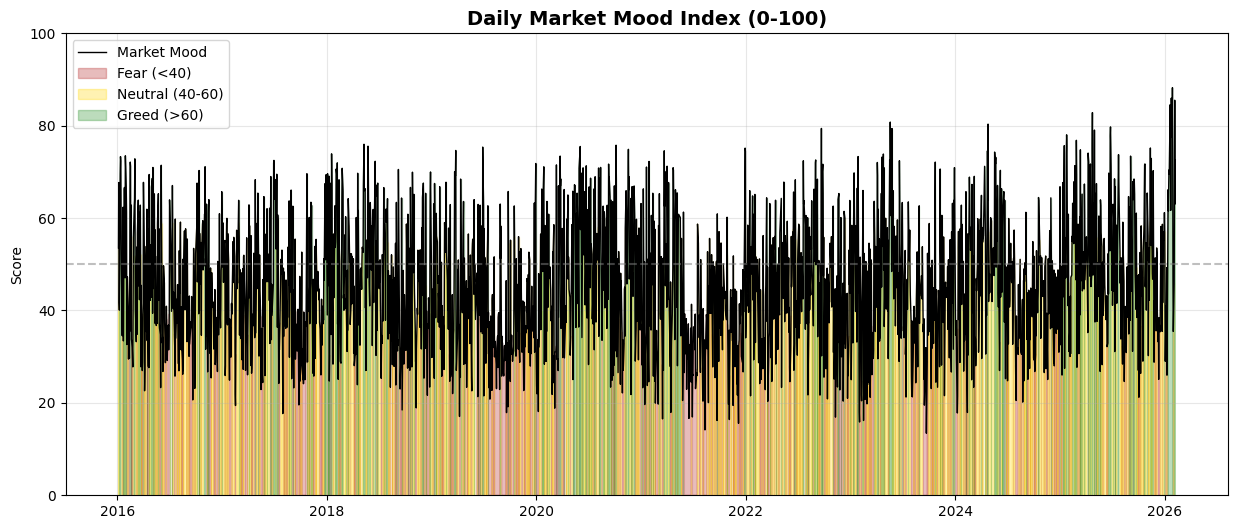

In [271]:
sample_mood = historical_df[['SEANCE']+ cols_to_merge].drop_duplicates('SEANCE').sort_values('SEANCE').tail(10)
display(sample_mood)

# Visualize Market Mood History
plt.figure(figsize=(15, 6))
mood_data = market_daily.sort_values('SEANCE')
plt.plot(mood_data['SEANCE'], mood_data['MarketMood'], color='black', linewidth=1, label='Market Mood')

# Color zones
plt.fill_between(mood_data['SEANCE'], mood_data['MarketMood'], 0, where=(mood_data['MarketMood'] < 40), color='firebrick', alpha=0.3, label='Fear (<40)')
plt.fill_between(mood_data['SEANCE'], mood_data['MarketMood'], 0, where=((mood_data['MarketMood'] >= 40) & (mood_data['MarketMood'] <= 60)), color='gold', alpha=0.3, label='Neutral (40-60)')
plt.fill_between(mood_data['SEANCE'], mood_data['MarketMood'], 0, where=(mood_data['MarketMood'] > 60), color='forestgreen', alpha=0.3, label='Greed (>60)')

plt.title('Daily Market Mood Index (0-100)', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 100)
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

In [272]:
def fit_daily_score_params(historical_df: pd.DataFrame) -> dict:
    """
    Calculate normalization parameters for daily score calculation from historical data.
    
    Args:
        historical_df: Historical market data
        
    Returns:
        dict: Dictionary containing normalization parameters
    """
    df = historical_df.copy()
    
    # Extract unique daily values for indices
    market_daily = df.groupby('SEANCE').first().reset_index()[['SEANCE', 'TUNINDEX_INDICE_JOUR', 'TUNINDEX20_INDICE_JOUR']]
    
    # Calculate returns for Direction Score
    market_daily['TUNINDEX_RET'] = market_daily['TUNINDEX_INDICE_JOUR'].pct_change().fillna(0)
    market_daily['TUNINDEX20_RET'] = market_daily['TUNINDEX20_INDICE_JOUR'].pct_change().fillna(0)
    
    # Direction Score parameters (mean and std for z-score normalization)
    ti_mean = market_daily['TUNINDEX_RET'].mean()
    ti_std = market_daily['TUNINDEX_RET'].std()
    ti20_mean = market_daily['TUNINDEX20_RET'].mean()
    ti20_std = market_daily['TUNINDEX20_RET'].std()
    
    # Intensity Score parameters (percentiles for normalization)
    intensity_raw = df.groupby('SEANCE')['VARIATION'].apply(lambda x: x.abs().mean())
    p10_intensity = intensity_raw.quantile(0.10)
    p90_intensity = intensity_raw.quantile(0.90)
    
    # News Score parameters (mean and std for z-score normalization)
    daily_sentiment = df.groupby('SEANCE')['Mean_Weighted_Sentiment'].mean()
    sent_mean = daily_sentiment.mean()
    sent_std = daily_sentiment.std()
    
    params = {
        'tunindex_ret_mean': ti_mean,
        'tunindex_ret_std': ti_std,
        'tunindex20_ret_mean': ti20_mean,
        'tunindex20_ret_std': ti20_std,
        'intensity_p10': p10_intensity,
        'intensity_p90': p90_intensity,
        'sentiment_mean': sent_mean,
        'sentiment_std': sent_std
    }
    
    return params

In [273]:
params = fit_daily_score_params(historical_df)

In [275]:
import json

with open('../models/market_mood_params.json', 'w') as f:
    json.dump(params, f, indent=2)

In [276]:
historical_df

SEANCE  GROUPE          CODE         VALEUR  OUVERTURE  CLOTURE  \
0     2016-01-05      11  TN0001000108       MONOPRIX      14.20    13.90   
1     2016-01-06      11  TN0001000108       MONOPRIX      13.90    13.90   
2     2016-01-07      11  TN0001000108       MONOPRIX      13.95    13.90   
3     2016-01-08      11  TN0001000108       MONOPRIX      13.90    13.87   
4     2016-01-11      11  TN0001000108       MONOPRIX      13.87    13.70   
...          ...     ...           ...            ...        ...      ...   
97106 2026-02-02      11  TNQPQXRODTH8  SMART TUNISIE      19.00    19.30   
97107 2026-02-03      11  TNQPQXRODTH8  SMART TUNISIE      19.30    19.30   
97108 2026-02-04      11  TNQPQXRODTH8  SMART TUNISIE      19.30    19.50   
97109 2026-02-05      11  TNQPQXRODTH8  SMART TUNISIE      19.50    19.50   
97110 2026-02-06      11  TNQPQXRODTH8  SMART TUNISIE      19.30    19.45   

       PLUS_BAS  PLUS_HAUT  QUANTITE_NEGOCIEE  NB_TRANSACTION  ...  \
0         13.78      14.20               2588              26  ...   
1         13.84      13.98              10930              42  ...   
2         13.81      13.95               4203              24  ...   
3         13.60      13.90               9588              43  ...   
4         13.70      13.87               1060               9  ...   
...         ...        ...                ...             ...  ...   
97106     18.90      19.30               1830               6  ...   
97107     19.30      19.35               1311              13  ...   
97108     19.30      19.50               2283              17  ...   
97109     19.50      19.50                897               8  ...   
97110     19.30      19.50               4569              18  ...   

       VARIATION_ANOMALY_POST_NEWS  VARIATION_ANOMALY_PRE_NEWS  \
0                                0                           0   
1                                0                           0   
2                                0                           0   
3                                0                           0   
4                                0                           0   
...                            ...                         ...   
97106                            0                           0   
97107                            0                           0   
97108                            0                           0   
97109                            0                           0   
97110                            0                           0   

       VOLUME_ANOMALY_POST_NEWS  VOLUME_ANOMALY_PRE_NEWS  DirectionScore  \
0                             0                        0       45.261760   
1                             0                        0      100.000000   
2                             0                        0       30.626715   
3                             0                        0       18.810666   
4                             0                        0      100.000000   
...                         ...                      ...             ...   
97106                         0                        0       21.577424   
97107                         0                        0       91.760010   
97108                         0                        0      100.000000   
97109                         0                        0       70.527443   
97110                         0                        0       93.340569   

       BreadthScore  LiquidityScore  IntensityScore   NewsScore  MarketMood  
0         47.058824       54.334584      100.000000   31.245120   53.543978  
1         42.857143       63.682914       78.002019   31.245120   67.695082  
2         23.529412       54.923634       81.211457   31.245120   41.747110  
3         33.333333       57.430326       77.312794   31.245120   40.079619  
4         48.648649       52.626125       97.247109   31.245120   69.528789  
...             ...             ...             ...         ...       

## 5-Day Forecast Inference

In [287]:
# 2026 holidays and weekends
holidays_2026 = [
    pd.Timestamp('2026-01-01'),
    pd.Timestamp('2026-03-20'), pd.Timestamp('2026-03-21'), pd.Timestamp('2026-03-22'),
    pd.Timestamp('2026-04-09'), pd.Timestamp('2026-04-27'), pd.Timestamp('2026-04-28'),
    pd.Timestamp('2026-05-01'),
    pd.Timestamp('2026-06-16'),
    pd.Timestamp('2026-07-25'),
    pd.Timestamp('2026-08-13'), pd.Timestamp('2026-08-25'),
    pd.Timestamp('2026-10-15'),
    pd.Timestamp('2026-12-17')
]

# Generate all weekends in 2026
weekends_2026 = pd.date_range('2026-01-01', '2026-12-31', freq='D')
weekends_2026 = [d for d in weekends_2026 if d.dayofweek >= 5]

# Combine holidays and weekends
non_trading_days_2026 = sorted(list(set(holidays_2026 + weekends_2026)))

print(f"Holidays: {len(holidays_2026)}")
print(f"Weekends: {len(weekends_2026)}")
print(f"Total non-trading days: {len(non_trading_days_2026)}")

Holidays: 14
Weekends: 104
Total non-trading days: 115


In [291]:
# ==============================================================
# 5-DAY FORECAST INFERENCE
# ==============================================================
# Uses saved ARIMA + XGBoost models for price & volume,
# then computes VAR_CLOTURE, VAR_VOLUME, and PROB_LIQUIDITY.
# VAR_X = (X_day - X_day-1) / X_day-1  (day-over-day % variation)
# Zero-volume forecasts → PROB_LIQUIDITY = 0.0 (not NaN).
# ==============================================================

print("=" * 80)
print("5-DAY FORECAST INFERENCE")
print("=" * 80)

HORIZON = 5
PRICE_MODELS_DIR = '../models'
VOLUME_MODELS_DIR = '../models/volume'
epsilon = 1e-6

# ---- Build CODE -> VALEUR mapping ----
code_valeur_map = dataset.drop_duplicates('CODE').set_index('CODE')['VALEUR'].to_dict()

# ---- Generate next 5 business trading days ----
last_date = dataset['SEANCE'].max()
print(f"Origin (last date in data): {last_date.date()}")

forecast_dates = []
candidate = last_date + pd.Timedelta(days=1)
while len(forecast_dates) < HORIZON:
    if candidate not in non_trading_days_2026:
        forecast_dates.append(candidate)
    candidate += pd.Timedelta(days=1)

print(f"Forecast dates: {[d.date() for d in forecast_dates]}")

# ---- Forecast for each ticker ----
tickers = dataset['CODE'].unique()
forecast_rows = []

for code in tqdm(tickers, desc="Forecasting"):
    ticker_df = dataset[dataset['CODE'] == code].sort_values('SEANCE').reset_index(drop=True)
    
    if len(ticker_df) < 20:
        print(f"  Skipping {code}: Insufficient data")
        continue
    
    origin_row = ticker_df.iloc[-1]
    origin_close = origin_row['CLOTURE']
    origin_volume = origin_row['QUANTITE_NEGOCIEE']
    valeur = code_valeur_map.get(code, code)
    
    # ---- Load and extend PRICE models ----
    try:
        price_arima = joblib.load(os.path.join(PRICE_MODELS_DIR, f"arima_model_{code}.pkl"))
        price_xgb = joblib.load(os.path.join(PRICE_MODELS_DIR, f"xgb_residual_model_{code}.pkl"))
        
        # Extend ARIMA to the full series (model was trained on partial data)
        full_close = ticker_df['CLOTURE']
        extended_price_arima = price_arima.apply(full_close)
        price_arima_forecast = extended_price_arima.forecast(steps=HORIZON)
        
        # XGBoost residual prediction using last row features
        origin_features = origin_row[xgb_residual_features].values.reshape(1, -1)
        price_xgb_pred = price_xgb.predict(origin_features)[0]
        
        forecasted_close = price_arima_forecast.values + price_xgb_pred
    except Exception as e:
        print(f"  {code}: Price model failed ({e}), using last price")
        forecasted_close = np.full(HORIZON, origin_close)
    
    # ---- Load and extend VOLUME models ----
    try:
        vol_arima = joblib.load(os.path.join(VOLUME_MODELS_DIR, f"arima_model_volume_{code}.pkl"))
        vol_xgb = joblib.load(os.path.join(VOLUME_MODELS_DIR, f"xgb_residual_model_volume_{code}.pkl"))
        
        full_volume = ticker_df['QUANTITE_NEGOCIEE']
        extended_vol_arima = vol_arima.apply(full_volume)
        vol_arima_forecast = extended_vol_arima.forecast(steps=HORIZON)
        
        vol_xgb_pred = vol_xgb.predict(origin_features)[0]
        
        forecasted_volume = np.maximum(vol_arima_forecast.values + vol_xgb_pred, 0)
    except Exception as e:
        print(f"  {code}: Volume model failed ({e}), using last volume")
        forecasted_volume = np.full(HORIZON, origin_volume)
    
    # ---- Compute rolling avg range (last 5 known days) ----
    range_vals = (ticker_df['PLUS_HAUT'] - ticker_df['PLUS_BAS']).tail(5)
    last_avg_range = range_vals.mean()
    
    # ---- Compute PROB_LIQUIDITY ----
    hist_liq = historical_liquidity.get(code)
    
    # Track previous day's values for day-over-day variation
    prev_close = origin_close
    prev_volume = origin_volume
    
    for h in range(HORIZON):
        fc_close = forecasted_close[h]
        fc_volume = forecasted_volume[h]
        
        # Day-over-day percentage variation: (X_day - X_day-1) / X_day-1
        var_cloture = (fc_close - prev_close) / prev_close if prev_close != 0 else 0
        var_volume = (fc_volume - prev_volume) / prev_volume if prev_volume != 0 else 0
        
        # Liquidity probability
        prob_liq = 0.0  # Default: minimum liquidity
        if hist_liq is not None and len(hist_liq) > 0:
            liq_val = compute_liquidity(fc_volume, fc_close, last_avg_range, epsilon)
            if np.isfinite(liq_val):
                prob_liq = percentileofscore(hist_liq, liq_val) / 100.0
            # else: prob_liq stays 0.0 (zero volume → no liquidity)
        
        forecast_rows.append({
            'SEANCE': forecast_dates[h],
            'CODE': code,
            'VALEUR': valeur,
            'CLOTURE': round(fc_close, 3),
            'VOLUME': int(round(fc_volume)),
            'VAR_CLOTURE': round(var_cloture, 6),
            'VAR_VOLUME': round(var_volume, 6),
            'PROB_LIQUIDITY': round(prob_liq, 4),
        })
        
        # Update previous day values for next iteration
        prev_close = fc_close
        prev_volume = fc_volume

# ---- Build final DataFrame ----
forecast_df = pd.DataFrame(forecast_rows)
forecast_df = forecast_df.sort_values(['CODE', 'SEANCE']).reset_index(drop=True)

print(f"\n{'=' * 80}")
print(f"FORECAST COMPLETE")
print(f"{'=' * 80}")
print(f"Shape: {forecast_df.shape}")
print(f"Tickers: {forecast_df['CODE'].nunique()}")
print(f"Date range: {forecast_df['SEANCE'].min().date()} → {forecast_df['SEANCE'].max().date()}")
print(f"PROB_LIQUIDITY NaN count: {forecast_df['PROB_LIQUIDITY'].isna().sum()}")

# Save to CSV
forecast_path = '../data/forecast_next_5_days.csv'
forecast_df.to_csv(forecast_path, index=False)
print(f"\n✓ Saved to: {forecast_path}")

display(forecast_df)

5-DAY FORECAST INFERENCE
Origin (last date in data): 2026-02-06
Forecast dates: [datetime.date(2026, 2, 9), datetime.date(2026, 2, 10), datetime.date(2026, 2, 11), datetime.date(2026, 2, 12), datetime.date(2026, 2, 13)]


Forecasting: 100%|██████████| 41/41 [00:06<00:00,  6.22it/s]


FORECAST COMPLETE
Shape: (205, 8)
Tickers: 41
Date range: 2026-02-09 → 2026-02-13
PROB_LIQUIDITY NaN count: 0

✓ Saved to: ../data/forecast_next_5_days.csv


SEANCE          CODE         VALEUR  CLOTURE  VOLUME  VAR_CLOTURE  \
0   2026-02-09  TN0001000108       MONOPRIX    6.157   16218    -0.006918   
1   2026-02-10  TN0001000108       MONOPRIX    6.128   90691    -0.004728   
2   2026-02-11  TN0001000108       MONOPRIX    6.169  155402     0.006633   
3   2026-02-12  TN0001000108       MONOPRIX    6.158       0    -0.001755   
4   2026-02-13  TN0001000108       MONOPRIX    6.137       0    -0.003430   
..         ...           ...            ...      ...     ...          ...   
200 2026-02-09  TNQPQXRODTH8  SMART TUNISIE   19.464       0     0.000705   
201 2026-02-10  TNQPQXRODTH8  SMART TUNISIE   19.559    8580     0.004912   
202 2026-02-11  TNQPQXRODTH8  SMART TUNISIE   19.519       0    -0.002074   
203 2026-02-12  TNQPQXRODTH8  SMART TUNISIE   19.243       0    -0.014147   
204 2026-02-13  TNQPQXRODTH8  SMART TUNISIE   19.662     181     0.021819   

     VAR_VOLUME  PROB_LIQUIDITY  
0    323.354886          0.9769  
1      4.592110          0.9943  
2      0.713525          0.9953  
3     -1.000000          0.0000  
4      0.000000          0.0000  
..          ...             ...  
200   -1.000000          0.0000  
201    0.000000          0.9719  
202   -1.000000          0.0000  
203    0.000000          0.0000  
204    0.000000          0.3638  

[205 rows x 8 columns]

In [294]:
# Display forecast results
print("=== 5-Day Forecast Results ===\n")

for date in forecast_dates:
    print(f"\n{date.date()} ({date.day_name()})")
    print("-" * 80)
    day_df = forecast_df[forecast_df['SEANCE'] == date][['VALEUR', 'CLOTURE', 'VOLUME', 'VAR_CLOTURE', 'VAR_VOLUME', 'PROB_LIQUIDITY']]
    display(day_df.reset_index(drop=True).head(10))  # Show top 10 for brevity

=== 5-Day Forecast Results ===


2026-02-09 (Monday)
--------------------------------------------------------------------------------


VALEUR  CLOTURE  VOLUME  VAR_CLOTURE   VAR_VOLUME  \
0                     MONOPRIX    6.157   16218    -0.006918   323.354886   
1                         SFBT   13.510  142260     0.005173     7.587478   
2                     TUNISAIR    0.333     666     0.009218    -0.742801   
3                SPDIT - SICAF   12.828   19341     0.002184  3222.528638   
4                ATTIJARI BANK   68.422   18401    -0.001132    -0.094427   
5                         BIAT  133.545   16955     0.011704     7.331502   
6                      BH BANK   10.273       0     0.002266    -1.000000   
7  TUNISIE LEASING & FACTORING   41.735    8501     0.005666     2.263212   
8                     STB BANK    3.758   11507     0.002150    -0.471362   
9                          ICF   76.893     263    -0.001387    -0.692952   

   PROB_LIQUIDITY  
0          0.9769  
1          0.9613  
2          0.9484  
3          0.8000  
4          0.9120  
5          0.9632  
6          0.0000  
7          0.9317  
8          0.8684  
9          0.3530


2026-02-10 (Tuesday)
--------------------------------------------------------------------------------


VALEUR  CLOTURE  VOLUME  VAR_CLOTURE  VAR_VOLUME  \
0                     MONOPRIX    6.128   90691    -0.004728    4.592110   
1                         SFBT   13.399   43942    -0.008160   -0.691112   
2                     TUNISAIR    0.329   12884    -0.011413   18.355399   
3                SPDIT - SICAF   12.828   21049    -0.000005    0.088293   
4                ATTIJARI BANK   68.151       0    -0.003960   -1.000000   
5                         BIAT  129.662   11565    -0.029077   -0.317856   
6                      BH BANK   10.245       0    -0.002740    0.000000   
7  TUNISIE LEASING & FACTORING   42.056    4470     0.007696   -0.474186   
8                     STB BANK    3.767   33703     0.002475    1.928789   
9                          ICF   76.465    1660    -0.005563    5.324730   

   PROB_LIQUIDITY  
0          0.9943  
1          0.8510  
2          0.9788  
3          0.8059  
4          0.0000  
5          0.9375  
6          0.0000  
7          0.8900  
8          0.9787  
9          0.7563


2026-02-11 (Wednesday)
--------------------------------------------------------------------------------


VALEUR  CLOTURE  VOLUME  VAR_CLOTURE  VAR_VOLUME  \
0                     MONOPRIX    6.169  155402     0.006633    0.713525   
1                         SFBT   13.414  112090     0.001087    1.550830   
2                     TUNISAIR    0.327   11215    -0.007260   -0.129500   
3                SPDIT - SICAF   12.771   11307    -0.004451   -0.462826   
4                ATTIJARI BANK   66.994       0    -0.016985    0.000000   
5                         BIAT  132.835     714     0.024469   -0.938301   
6                      BH BANK   10.247    1782     0.000157    0.000000   
7  TUNISIE LEASING & FACTORING   42.599   16553     0.012902    2.703218   
8                     STB BANK    3.778   15503     0.002695   -0.539998   
9                          ICF   77.104    1115     0.008355   -0.328550   

   PROB_LIQUIDITY  
0          0.9953  
1          0.9538  
2          0.9763  
3          0.7771  
4          0.0000  
5          0.3172  
6          0.7906  
7          0.9676  
8          0.9151  
9          0.6788


2026-02-12 (Thursday)
--------------------------------------------------------------------------------


VALEUR  CLOTURE  VOLUME  VAR_CLOTURE  VAR_VOLUME  \
0                     MONOPRIX    6.158       0    -0.001755   -1.000000   
1                         SFBT   13.378   48883    -0.002643   -0.563890   
2                     TUNISAIR    0.331   18735     0.011591    0.670543   
3                SPDIT - SICAF   12.764   15865    -0.000527    0.403163   
4                ATTIJARI BANK   67.929   43090     0.013952    0.000000   
5                         BIAT  133.421    9629     0.004413   12.494547   
6                      BH BANK   10.325    3145     0.007670    0.764273   
7  TUNISIE LEASING & FACTORING   42.087    4532    -0.012022   -0.726202   
8                     STB BANK    3.764   33464    -0.003650    1.158482   
9                          ICF   77.792    2267     0.008922    1.033838   

   PROB_LIQUIDITY  
0          0.0000  
1          0.8735  
2          0.9842  
3          0.7965  
4          0.9774  
5          0.9193  
6          0.8693  
7          0.8921  
8          0.9787  
9          0.8103


2026-02-13 (Friday)
--------------------------------------------------------------------------------


VALEUR  CLOTURE  VOLUME  VAR_CLOTURE  VAR_VOLUME  \
0                     MONOPRIX    6.137       0    -0.003430    0.000000   
1                         SFBT   13.549   43297     0.012723   -0.114281   
2                     TUNISAIR    0.333   16176     0.006331   -0.136627   
3                SPDIT - SICAF   12.846    3174     0.006387   -0.799949   
4                ATTIJARI BANK   68.639   14459     0.010452   -0.664448   
5                         BIAT  132.798     750    -0.004672   -0.922146   
6                      BH BANK   10.321       0    -0.000438   -1.000000   
7  TUNISIE LEASING & FACTORING   42.495    4207     0.009702   -0.071714   
8                     STB BANK    3.802   24347     0.010264   -0.272429   
9                          ICF   76.972     126    -0.010540   -0.944491   

   PROB_LIQUIDITY  
0          0.0000  
1          0.8502  
2          0.9825  
3          0.7029  
4          0.8751  
5          0.3295  
6          0.0000  
7          0.8834  
8          0.9626  
9          0.2413

In [296]:
# Save forecast to CSV
forecast_output_path = os.path.join('../data', 'forecast_next_5_days.csv')
forecast_df.to_csv(forecast_output_path, index=False)
print(f"Forecast saved to: {forecast_output_path}")

Forecast saved to: ../data\forecast_next_5_days.csv


### Visualizing results

In [298]:
# Load the data
historical_df = pd.read_csv('../data/historical_data.csv', parse_dates=['SEANCE'])
forecast_df = pd.read_csv('../data/forecast_next_5_days.csv', parse_dates=['SEANCE'])

# Get unique tickers
unique_codes = forecast_df['CODE'].unique()
code_to_valeur = historical_df[['CODE', 'VALEUR']].drop_duplicates().set_index('CODE')['VALEUR'].to_dict()

In [299]:
unique_codes

array(['TN0001000108', 'TN0001100254', 'TN0001200401', 'TN0001400704',
       'TN0001600154', 'TN0001800457', 'TN0001900604', 'TN0002100907',
       'TN0002600955', 'TN0003200755', 'TN0003400058', 'TN0003900107',
       'TN0005700018', 'TN0006530018', 'TN0006560015', 'TN0006580013',
       'TN0006590012', 'TN0006610018', 'TN0006660013', 'TN0006780019',
       'TN0007140015', 'TN0007210016', 'TN0007270010', 'TN0007300015',
       'TN0007380017', 'TN0007400013', 'TN0007410012', 'TN0007440019',
       'TN0007530017', 'TN0007540016', 'TN0007550015', 'TN0007570013',
       'TN0007610017', 'TN0007620016', 'TN0007630015', 'TN0007650013',
       'TN0007670011', 'TN0007690019', 'TN0007720014', 'TNNGTFLC2986',
       'TNQPQXRODTH8'], dtype=object)

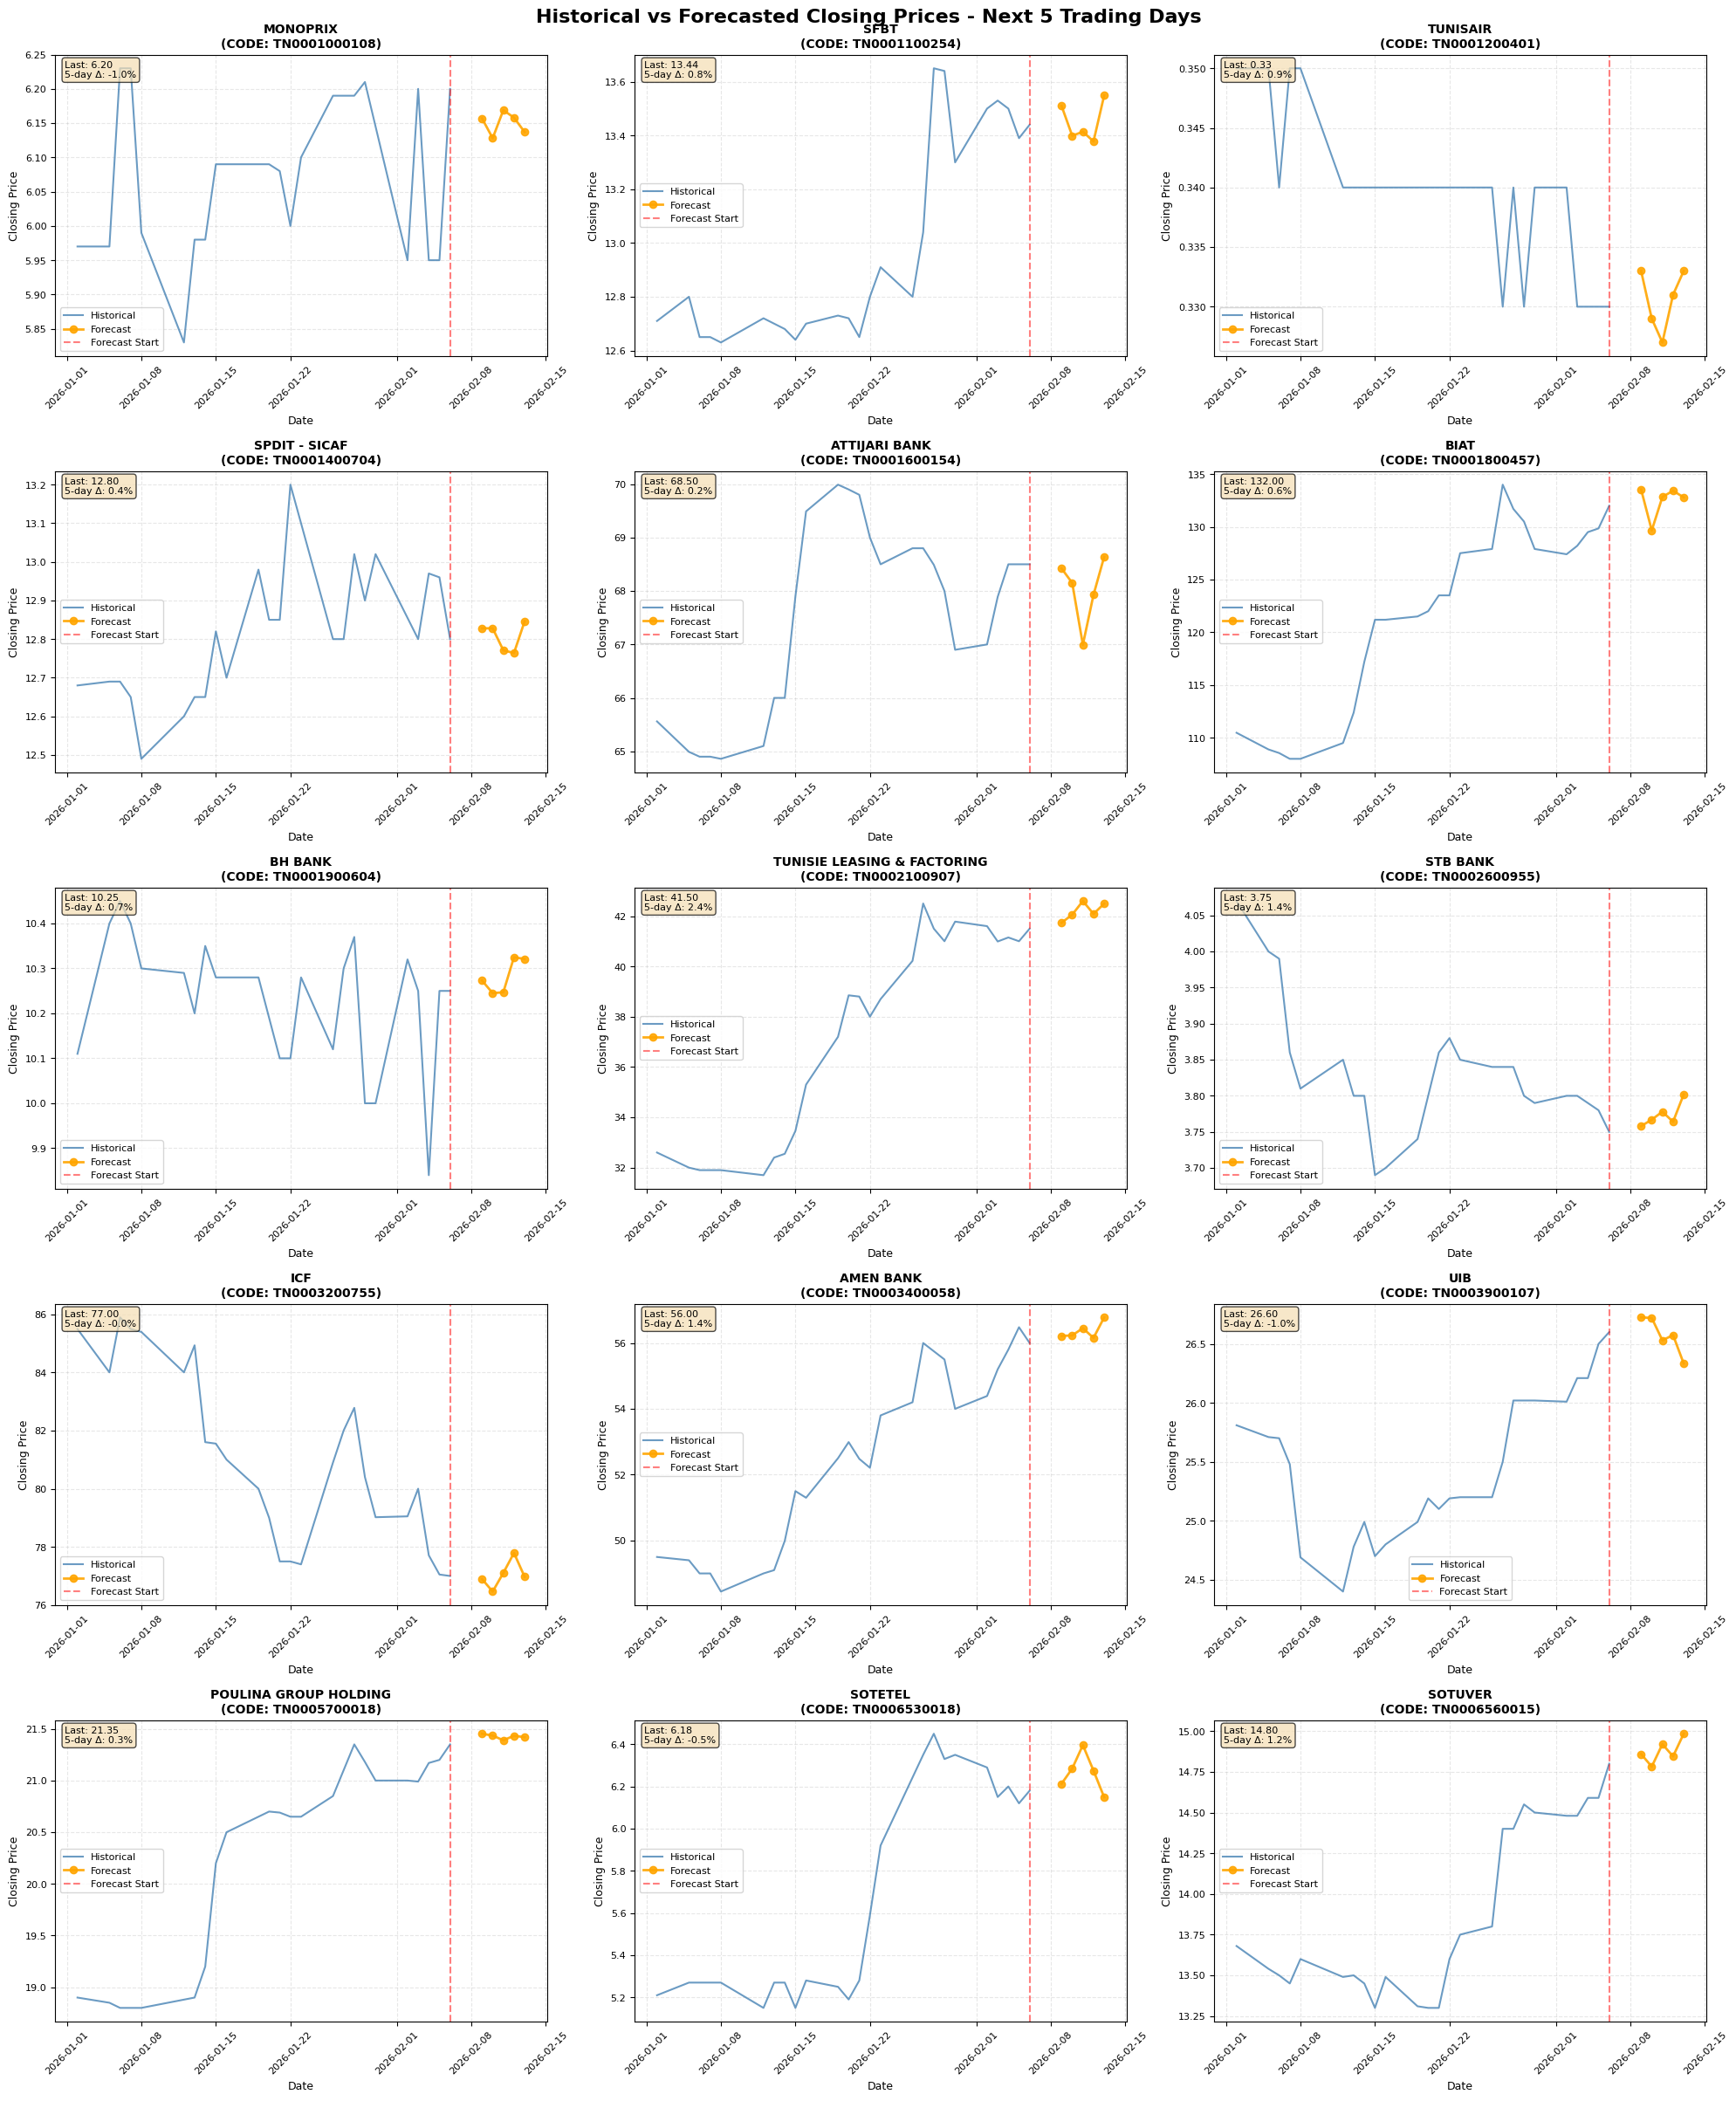


✓ Visualization complete for 15 tickers
Historical period: 2016-01-05 to 2026-02-06
Forecast period: 2026-02-09 to 2026-02-13


In [301]:
# Create 5x3 subplot grid for 15 stocks
fig, axes = plt.subplots(5, 3, figsize=(20, 24))
axes = axes.flatten()

for idx, code in enumerate(unique_codes[:15]):
    # Get historical data for this ticker
    hist_data = historical_df[(historical_df['CODE'] == code) & (historical_df['SEANCE'] >= pd.Timestamp('2026-01-01'))].sort_values('SEANCE')
    
    # Get forecast data for this ticker
    forecast_data = forecast_df[forecast_df['CODE'] == code].sort_values('SEANCE')
    
    # Get ticker name
    valeur = code_to_valeur.get(code, code)
    
    # Plot historical closing prices
    axes[idx].plot(hist_data['SEANCE'], hist_data['CLOTURE'], 
                   label='Historical', color='steelblue', linewidth=1.5, alpha=0.8)
    
    # Plot forecasted closing prices
    axes[idx].plot(forecast_data['SEANCE'], forecast_data['CLOTURE'], 
                   label='Forecast', color='orange', linewidth=2, marker='o', 
                   markersize=6, alpha=0.9)
    
    # Add a vertical line to mark the transition from historical to forecast
    last_hist_date = hist_data['SEANCE'].max()
    axes[idx].axvline(x=last_hist_date, color='red', linestyle='--', 
                      alpha=0.5, linewidth=1.5, label='Forecast Start')
    
    # Formatting
    axes[idx].set_title(f'{valeur}\n(CODE: {code})', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=9)
    axes[idx].set_ylabel('Closing Price', fontsize=9)
    axes[idx].legend(loc='best', fontsize=8)
    axes[idx].grid(alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)
    
    # Add statistics annotation
    last_hist_price = hist_data['CLOTURE'].iloc[-1]
    forecast_change = ((forecast_data['CLOTURE'].iloc[-1] - last_hist_price) / last_hist_price) * 100
    stats_text = f'Last: {last_hist_price:.2f}\n5-day Δ: {forecast_change:.1f}%'
    axes[idx].text(0.02, 0.98, stats_text, 
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.suptitle('Historical vs Forecasted Closing Prices - Next 5 Trading Days', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

print(f"\n✓ Visualization complete for {len(unique_codes[:15])} tickers")
print(f"Historical period: {historical_df['SEANCE'].min().date()} to {historical_df['SEANCE'].max().date()}")
print(f"Forecast period: {forecast_df['SEANCE'].min().date()} to {forecast_df['SEANCE'].max().date()}")